## Importing the necessary modules

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import set_option
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold # for cross validation
from sklearn.model_selection import GridSearchCV # for tuning parameter
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.
from sklearn.preprocessing import StandardScaler, OneHotEncoder # for normalization
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # to the check the error and accuracy of the model
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Importing the datasets

In [187]:
train = pd.read_csv('train_s3TEQDk.csv')
test = pd.read_csv('test_mSzZ8RL.csv')

In [188]:
train.head()

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   
3  BF3NC7KV    Male   34       RG270       Salaried           X1       19   
4  TEASRWXV  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0  
3             No               470454        No        0  
4             No               886787        No        0

In [189]:
test.tail()

ID Gender  Age Region_Code Occupation Channel_Code  Vintage  \
105307  DBENJOYI   Male   52       RG268   Salaried           X2       86   
105308  CWQ72DWS   Male   55       RG277      Other           X2       86   
105309  HDESC8GU   Male   35       RG254   Salaried           X4       15   
105310  2PW4SFCA   Male   53       RG254      Other           X3       93   
105311  F2NOYPPZ   Male   27       RG256   Salaried           X1       21   

       Credit_Product  Avg_Account_Balance Is_Active  
105307            Yes              4242558       Yes  
105308            Yes              1159153        No  
105309             No              1703727        No  
105310             No               737178       Yes  
105311             No               591565        No

In [190]:
train.shape, test.shape

((245725, 11), (105312, 10))

In [191]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               -

(None, None)

Following are the details about the column:
- ID - Unique Identifier for a row
- Gender - Gender of the Customer. This needs to be converted to categorical variable.
- Age - Age of the Customer (in Years)
- Region_code - Code of the Region for the customers. Since this deals with the region to which customer belong, should convert this to categorcial variable.
- Ocuupation - Occupation Type for the customer.
- Channel_code - Acquisition Channel Code for the Customer  (Encoded)
- Vintage - Vintage for the Customer (In Months)
- Credit_product - If the Customer has any active credit product (Home loan,Personal loan, Credit Card etc.)
- Avg_Account_Balance - Average Account Balance for the Customer in last 12 Months.
- Is_Active - If the Customer is Active in last 3 Months.
- Is_Lead(Target) - If the Customer is interested for the Credit Card
                    0 : Customer is not interested
                    1 : Customer is interested

From the above, need to convert Gender, Region_code, Occupation, Channel_code, Credit_Product, Is_Active

In [192]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = ((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(train)

Total  Percent
Credit_Product       29325 11.93407
ID                       0  0.00000
Gender                   0  0.00000
Age                      0  0.00000
Region_Code              0  0.00000
Occupation               0  0.00000
Channel_Code             0  0.00000
Vintage                  0  0.00000
Avg_Account_Balance      0  0.00000
Is_Active                0  0.00000
Is_Lead                  0  0.00000

In [193]:
missing_data(test)

Total  Percent
Credit_Product       12522 11.89038
ID                       0  0.00000
Gender                   0  0.00000
Age                      0  0.00000
Region_Code              0  0.00000
Occupation               0  0.00000
Channel_Code             0  0.00000
Vintage                  0  0.00000
Avg_Account_Balance      0  0.00000
Is_Active                0  0.00000

So we have almost 12% of missing values in credit_product in both test and train set.

In [194]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
train.describe()

Age      Vintage  Avg_Account_Balance      Is_Lead
count 245725.00000 245725.00000         245725.00000 245725.00000
mean      43.85631     46.95914        1128403.10102      0.23721
std       14.82867     32.35314         852936.35607      0.42537
min       23.00000      7.00000          20790.00000      0.00000
25%       30.00000     20.00000         604310.00000      0.00000
50%       43.00000     32.00000         894601.00000      0.00000
75%       54.00000     73.00000        1366666.00000      0.00000
max       85.00000    135.00000       10352009.00000      1.00000

In [195]:
all_df = [train, test]

In [196]:
to_category = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
for feat in to_category:
    for data in all_df:
        data[feat] = data[feat].astype('category')

train['Is_Lead'] = train['Is_Lead'].astype('category')

In [197]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   ID                   105312 non-null  object  
 1   Gender               105312 non-null  category
 2   Age                  105312 non-null  int64   
 3   Region_Code          105312 non-null  category
 4   Occupation           105312 non-null  category
 5   Channel_Code         105312 non-null  category
 6   Vintage              105312 non-null  int64   
 7   Credit_Product       92790 non-null   category
 8   Avg_Account_Balance  105312 non-null  int64   
 9   Is_Active            105312 non-null  category
dtypes: category(6), int64(3), object(1)
memory usage: 3.8+ MB


In [198]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   ID                   245725 non-null  object  
 1   Gender               245725 non-null  category
 2   Age                  245725 non-null  int64   
 3   Region_Code          245725 non-null  category
 4   Occupation           245725 non-null  category
 5   Channel_Code         245725 non-null  category
 6   Vintage              245725 non-null  int64   
 7   Credit_Product       216400 non-null  category
 8   Avg_Account_Balance  245725 non-null  int64   
 9   Is_Active            245725 non-null  category
 10  Is_Lead              245725 non-null  category
dtypes: category(7), int64(3), object(1)
memory usage: 9.1+ MB


In [199]:
def UVA_numeric(data, var_group):
  '''
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(data[i], shade=True)
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))

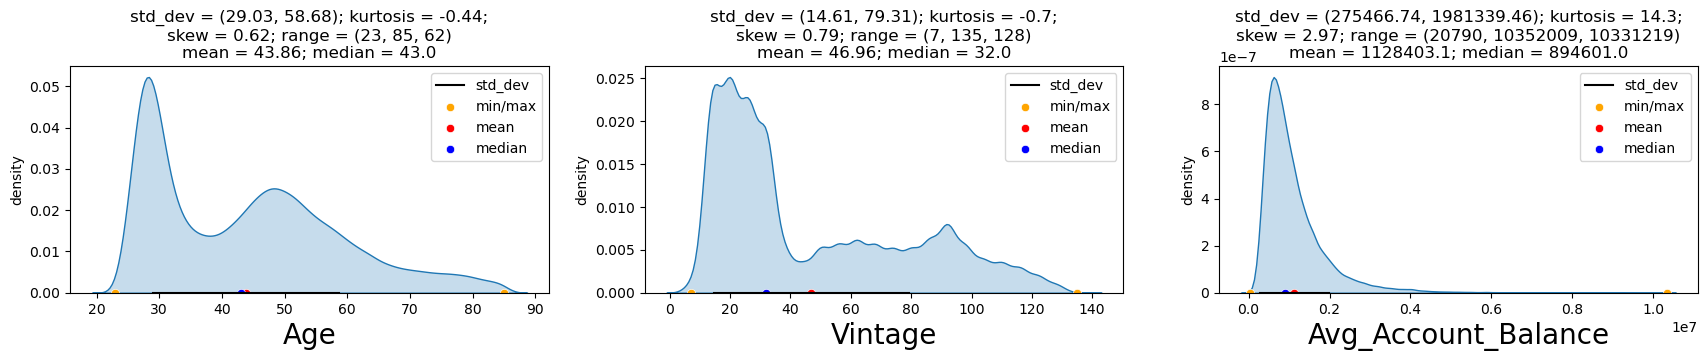

In [200]:
UVA_numeric(train,train.select_dtypes(include='int64').columns)

**Age:**
* Median age is 43
* Most of the customers are between age 29 to 58
* kurtosis = -0.44; very less likely to have extreme values
* skewness = 0.62; age is slightly biased to younger age

**Vintage:**
* Median vintage is 32
* Most customers are joined between 14 to 79 months
* kurtosis = -0.7; very likely to have extreme values
* skewness = 0.79; vintage is slightly biased to new customers.

**Avg Account balance:**
* Median vintage is 1128403.1
* Most customers have balance between 275466 to 1981339.
* kurtosis = 14.3;  Extreme values are present.
* skewness = 2.97; significantly biased towards lower account balance.

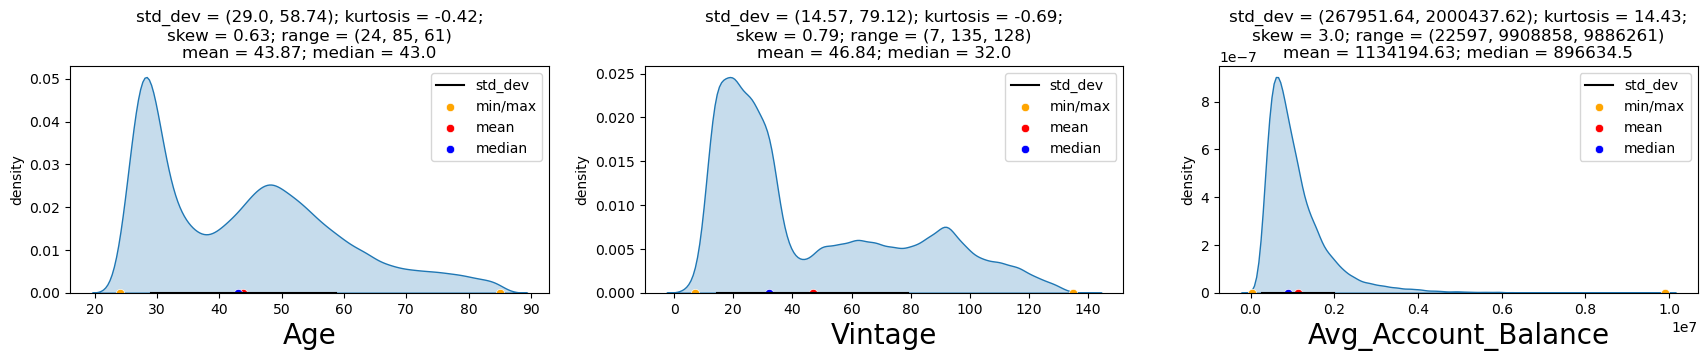

In [201]:
UVA_numeric(test,test.select_dtypes(include='int64').columns)

In [202]:
# Custom function for easy visualisation of Categorical Variables
def UVA_category(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize = (7*size,5), dpi = 100)

  # for every variable
  for j,i in enumerate(var_group):
    norm_count = data[i].value_counts(normalize = True)
    n_uni = data[i].nunique()

  #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.barplot(norm_count, norm_count.index , order = norm_count.index)
    plt.xlabel('fraction/percent', fontsize = 20)
    plt.ylabel('{}'.format(i), fontsize = 20)
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))

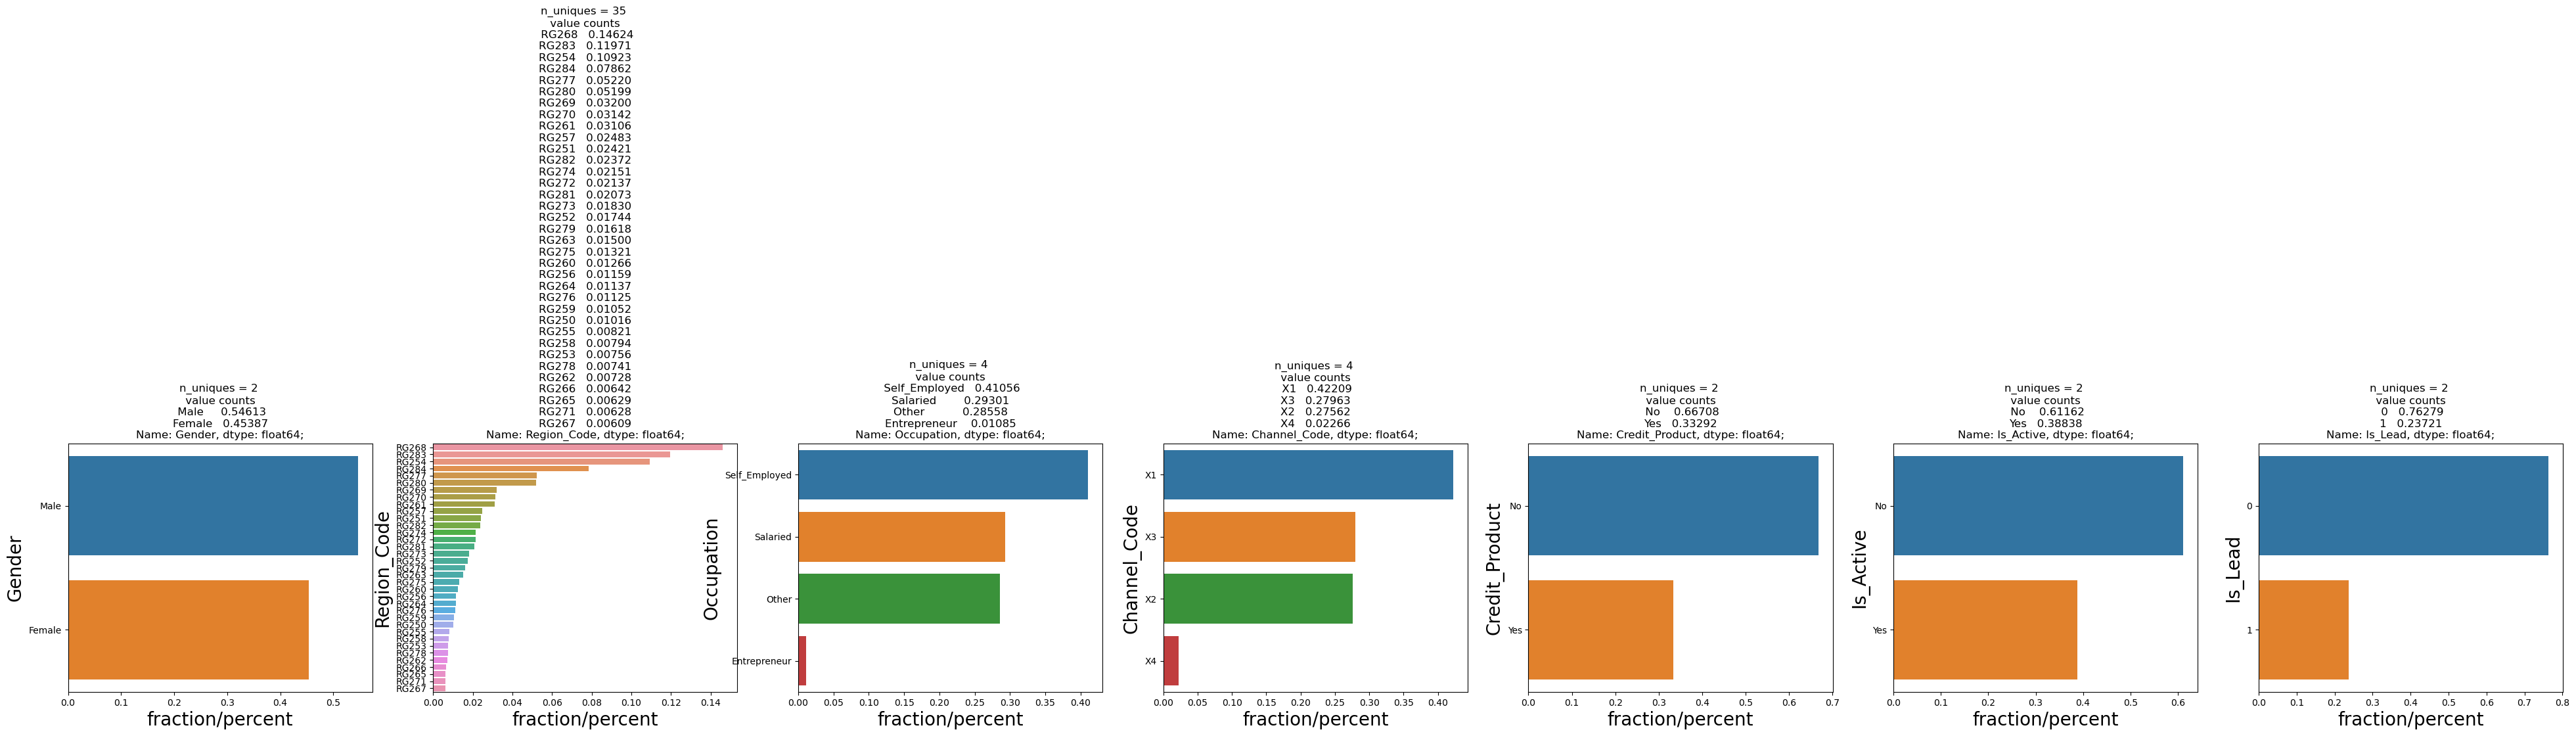

In [203]:
UVA_category(train, train.select_dtypes(include='category').columns)

**Gender:**
Male customer accounts for 1.2 times more than female.

**Region_code:**
Out of the 35 regions, 5 regions alone account for 55% of customers.

**Occupation:**
* Majority of people are self_employed.
* There are extremely few Entrepreneur. Might explain Outlier/Extreme values in credit/debit.

**Credict product:**
Majority of the customers are currently not having any credit products

**Is active:**
Majority of the customers are not active

**Is lead:**
* Most of the customers are not interested in the credit card.
* Customers who are not interested can be explained by less number of active customers.
* From the percentage values, the dataset is highly imbalanced.

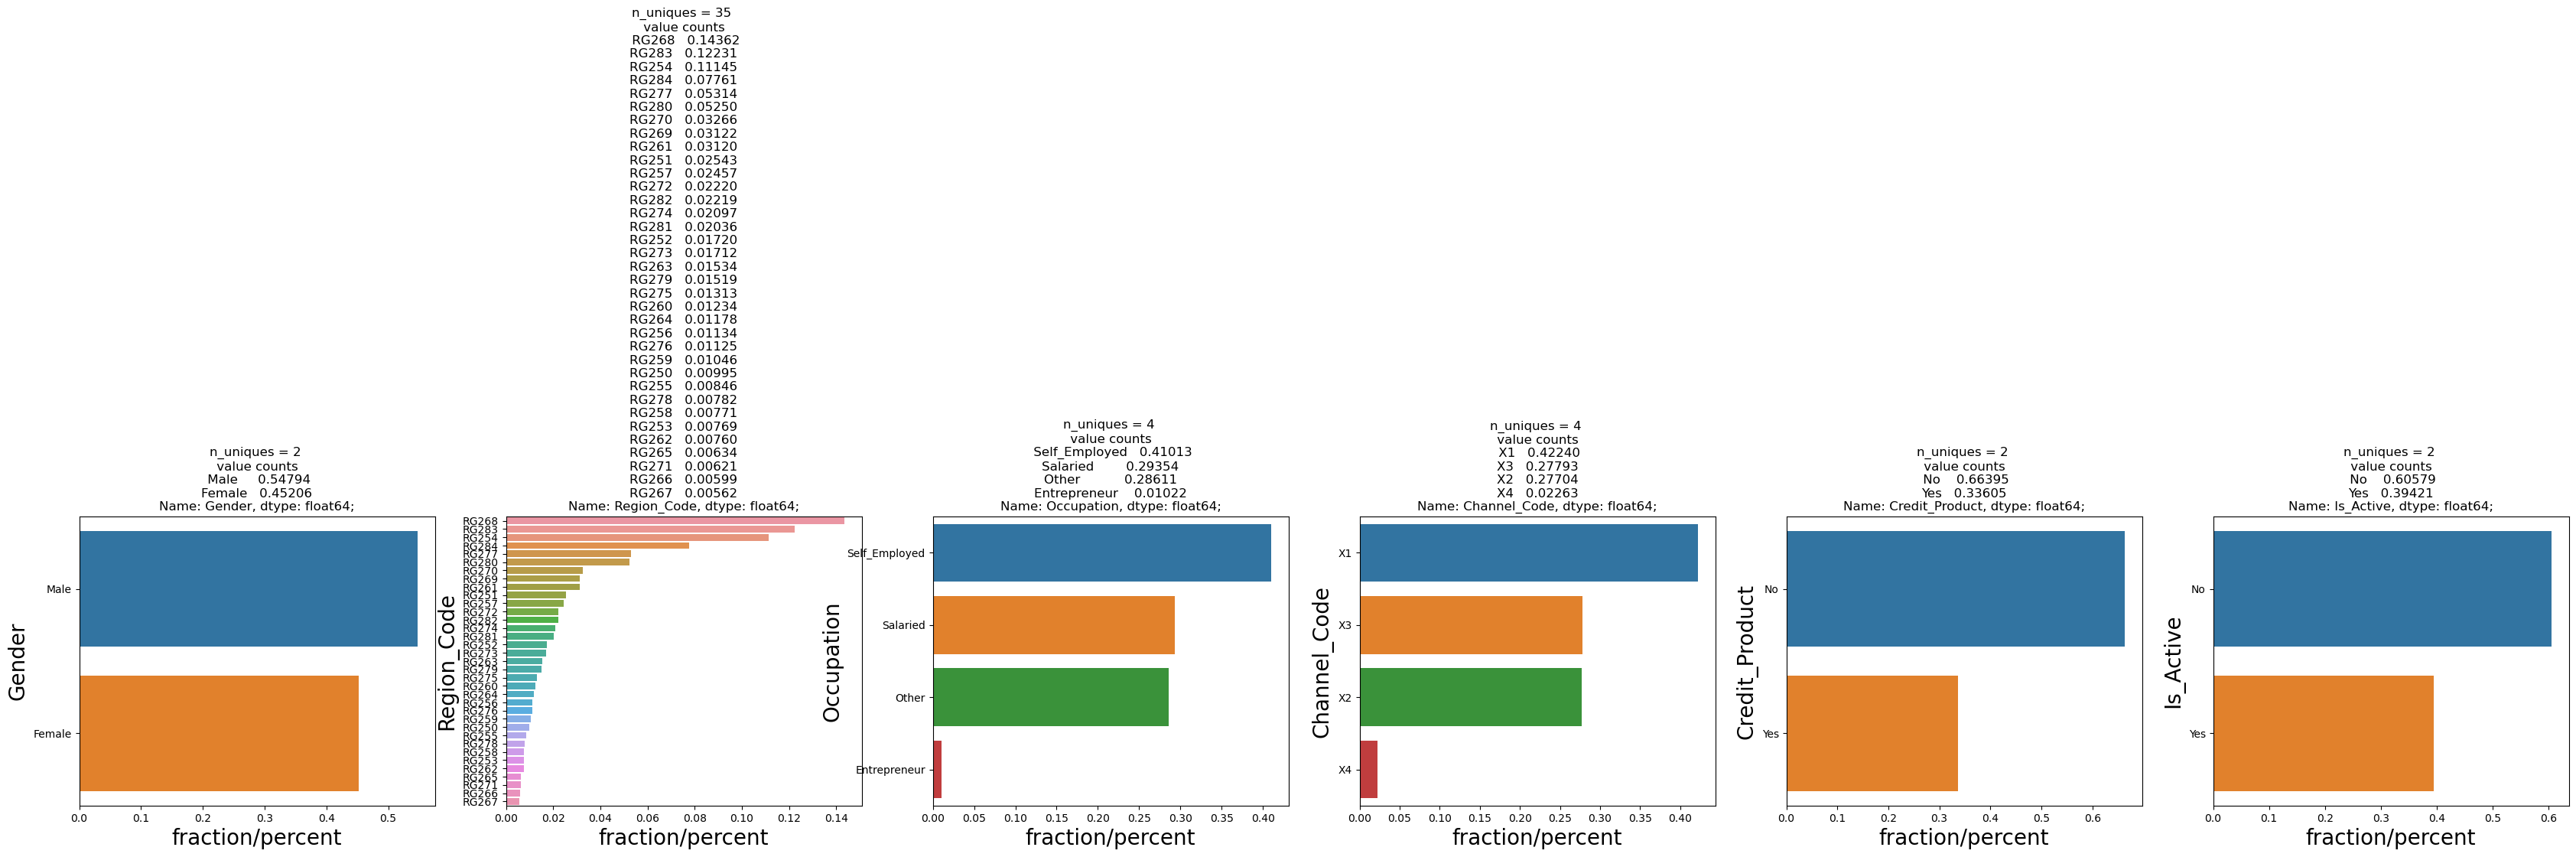

In [204]:
UVA_category(test, test.select_dtypes(include='category').columns)

## Investigation directions from Univariate analysis

1. customer_id can be dropped.
2. Occupation can explain the higher avg account balance customers.
3. Lower avg account balance can be explained by the high number of inactive customers.
4. Person with no credit product can be explained with the occuption and inactivity.

In [205]:
train.drop(['ID'], axis=1, inplace=True)

In [206]:
train.head()

Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  Female   73       RG268          Other           X3       43   
1  Female   30       RG277       Salaried           X1       32   
2  Female   56       RG268  Self_Employed           X3       26   
3    Male   34       RG270       Salaried           X1       19   
4  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active Is_Lead  
0             No              1045696        No       0  
1             No               581988        No       0  
2             No              1484315       Yes       0  
3             No               470454        No       0  
4             No               886787        No       0

## Bivariate analysis

In [207]:
# Function to group all the column based on Is_Lead
def get_is_lead_categories(data, val):
    tmp = data.groupby('Is_Lead')[val].value_counts()
    return pd.DataFrame(data={'Number': tmp.values}, index=tmp.index).reset_index()

In [208]:
get_is_lead_categories(train, 'Occupation')

Is_Lead     Occupation  Number
0       0  Self_Employed   73045
1       0       Salaried   60503
2       0          Other   52984
3       0   Entrepreneur     905
4       1  Self_Employed   27841
5       1          Other   17189
6       1       Salaried   11496
7       1   Entrepreneur    1762

In [209]:
train.select_dtypes(include='category').columns

Index(['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product',
       'Is_Active', 'Is_Lead'],
      dtype='object')

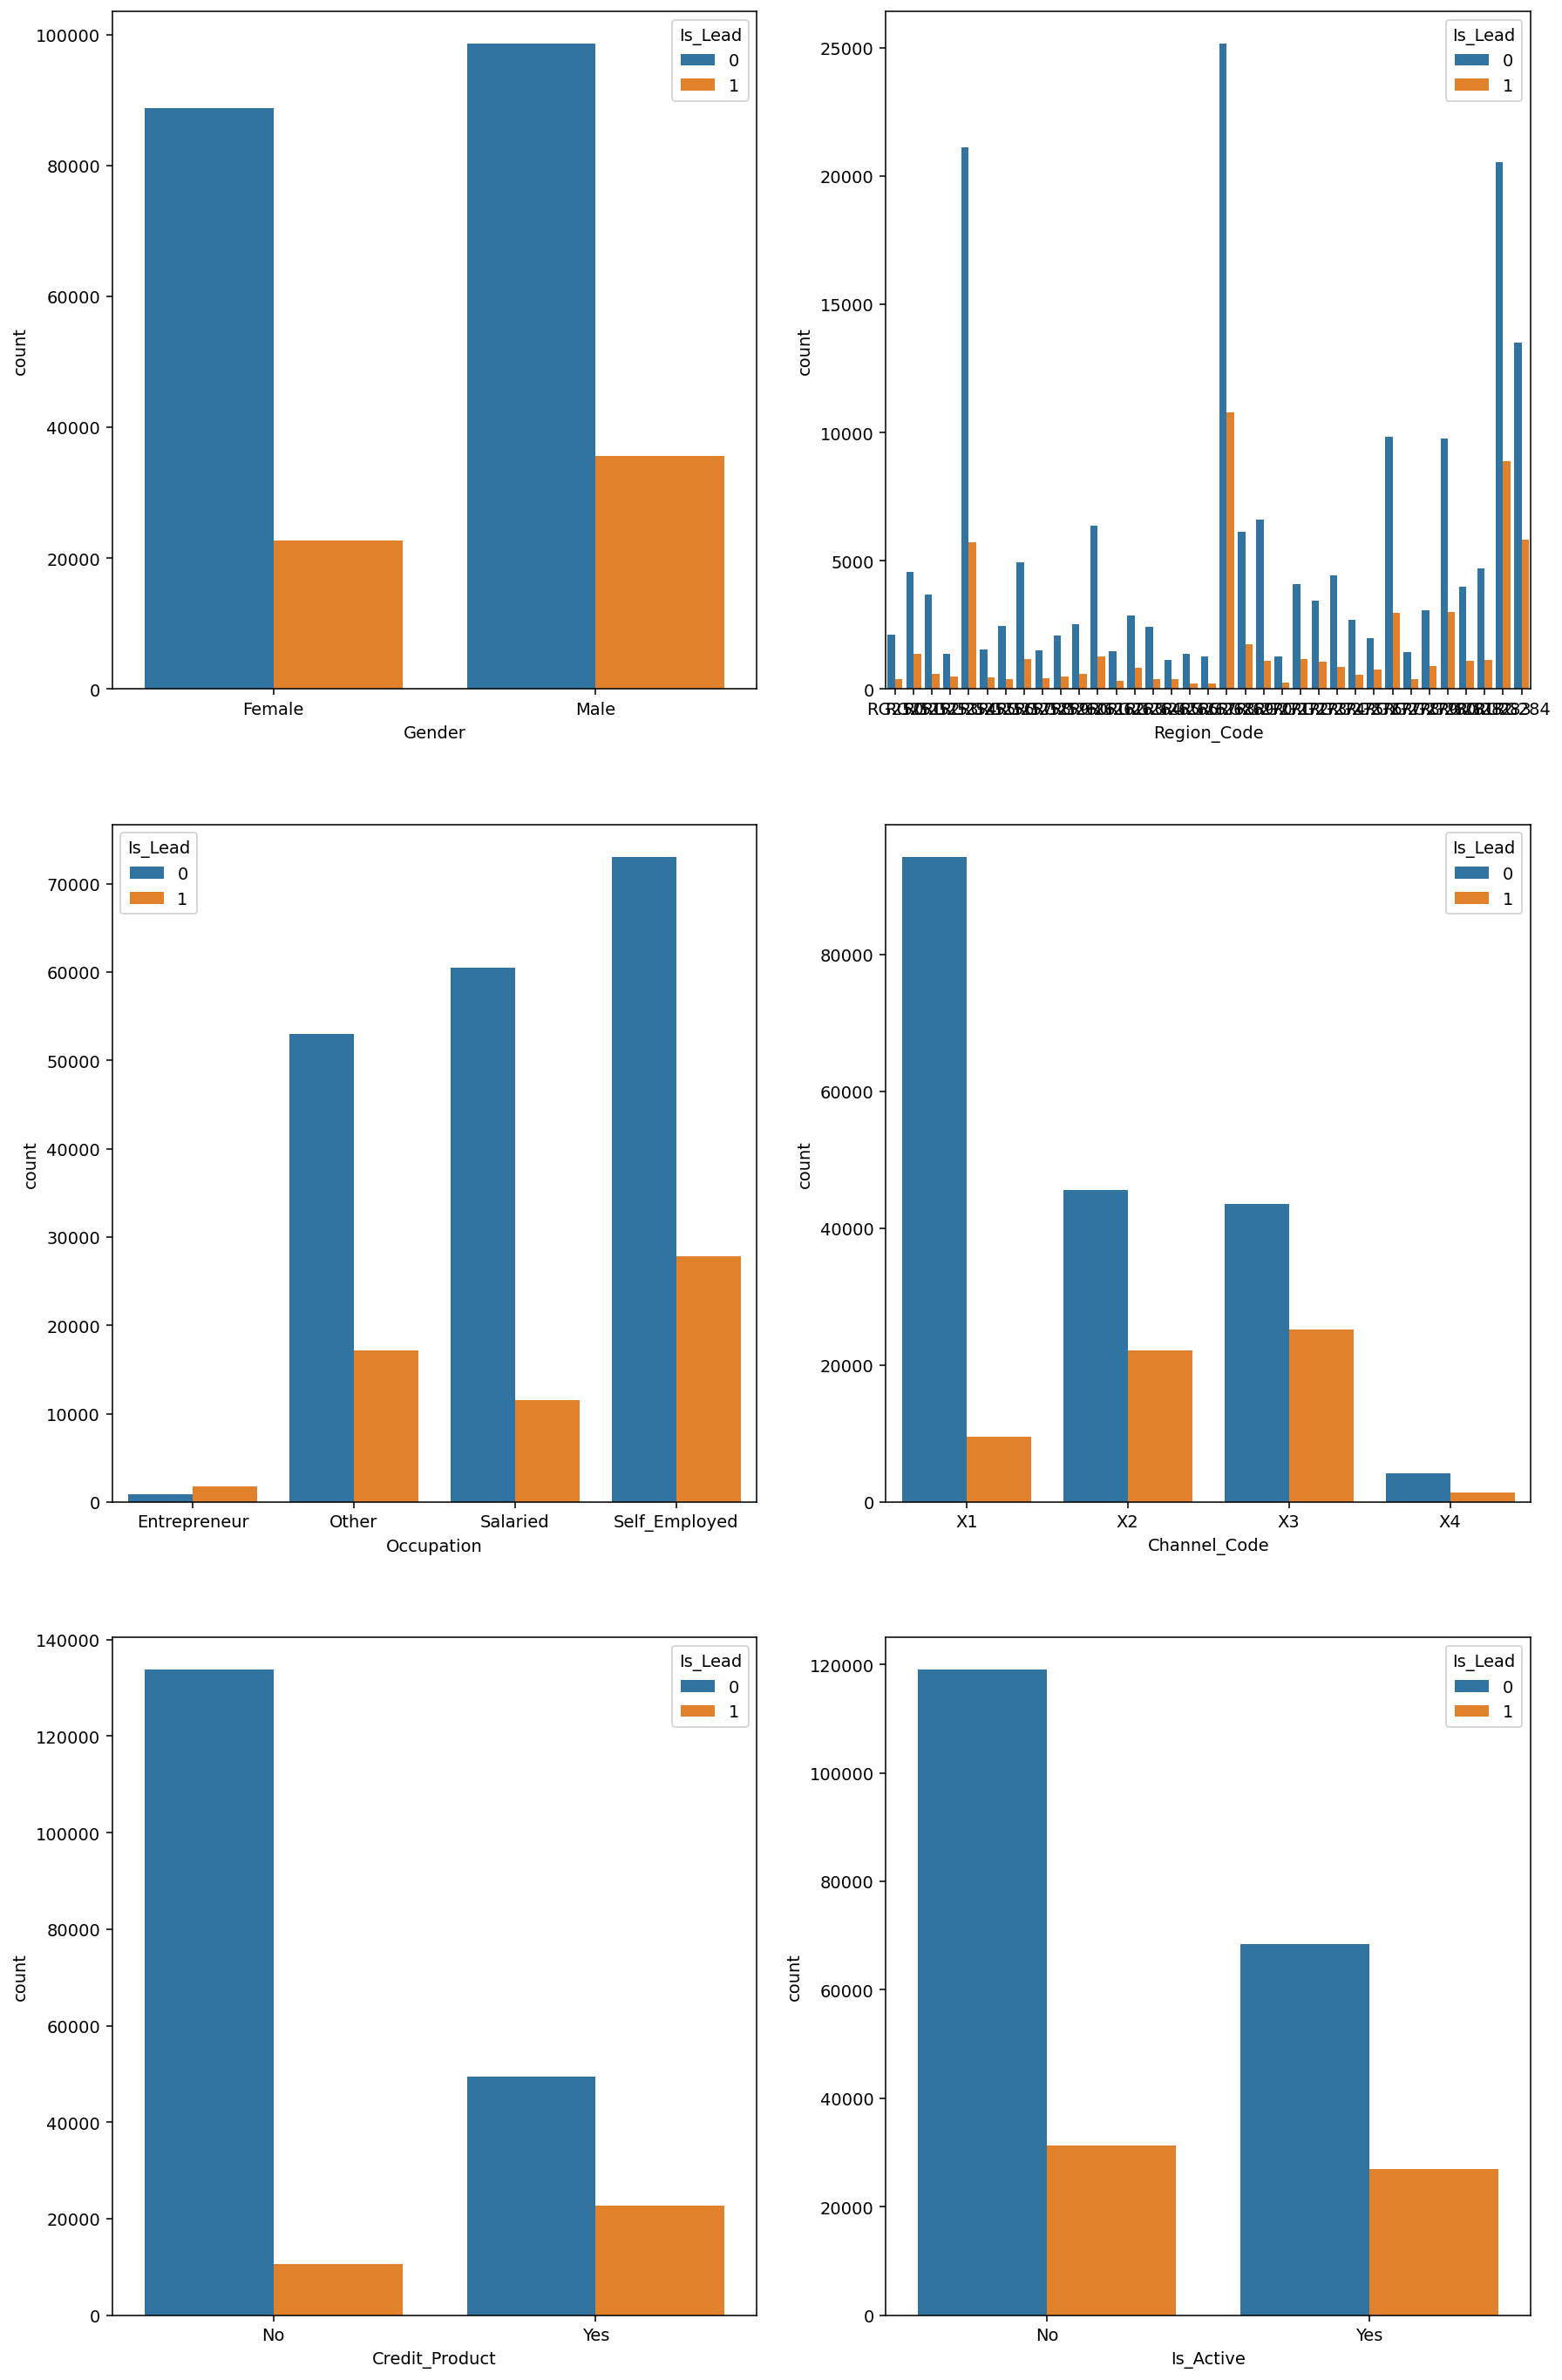

In [210]:
cat_cols = train.select_dtypes(include='category').columns.drop('Is_Lead')
plt.figure(figsize=(15,25), dpi=140)
for i, cols in enumerate(cat_cols):
    plt.subplot(int(len(cat_cols)/2), 2, i+1)
    sns.countplot(x=cols, hue='Is_Lead', data=train)

<Figure size 3500x2800 with 0 Axes>

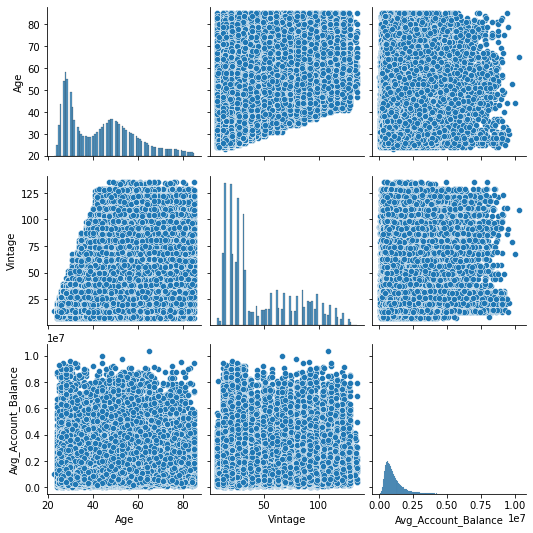

In [211]:
plt.figure(figsize=(25,20), dpi=140)
numer_cols = train.select_dtypes(include='int64').columns
sns.pairplot(train[numer_cols]);

From above plots, can confirm that there is no correlation between the numerical columns

<Figure size 1080x1080 with 0 Axes>

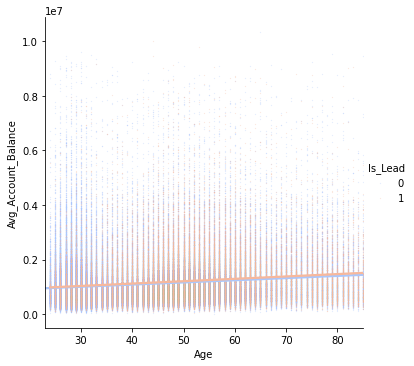

In [212]:
plt.figure(figsize=(15,15))
sns.lmplot(data=train, x='Age', y='Avg_Account_Balance', hue='Is_Lead', palette='coolwarm', scatter_kws={"s": 0.02})

From above plot, couldn't distinguish between lead or not. So avg_account_balance and age are correlated

## Outlier in average account balance

Now can investigate if the outliers in account balance is due to occupation.

In [213]:
train.groupby('Occupation')['Avg_Account_Balance'].median()

Occupation
Entrepreneur     1182890
Other             959188
Salaried          811991
Self_Employed     909072
Name: Avg_Account_Balance, dtype: int64

<AxesSubplot:xlabel='Occupation', ylabel='Avg_Account_Balance'>

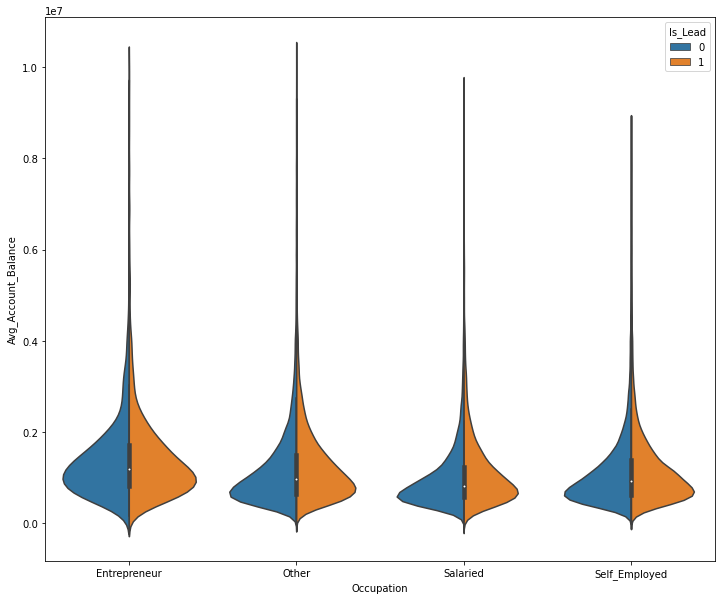

In [214]:
plt.figure(figsize=(12,10))
sns.violinplot(data=train, x='Occupation', y='Avg_Account_Balance', hue='Is_Lead', split=True)

Almost customers with all the occupation has outlier values in which we can see Other and Entrepreneurs have more outlier values. But the median Avg_account balance is more for entrepreneurs. Also the credit card interested people, have fatter tails.

## Lower account balance with inactive customers

<AxesSubplot:xlabel='Is_Active', ylabel='Avg_Account_Balance'>

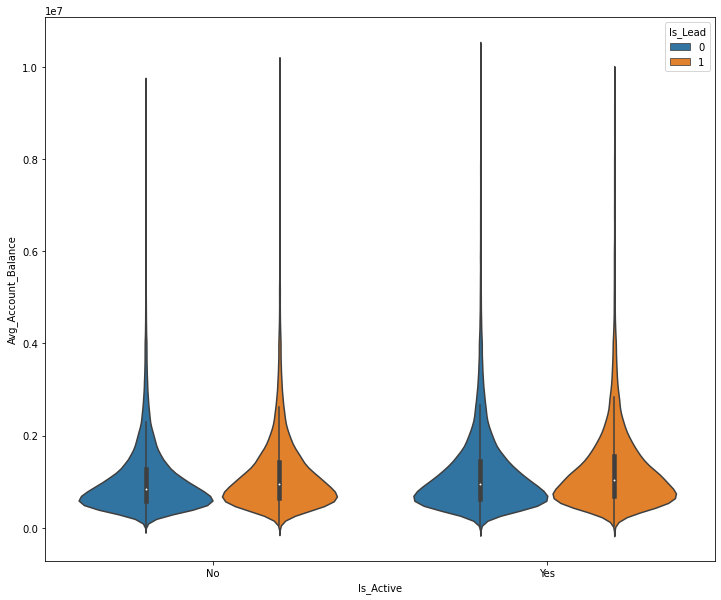

In [215]:
plt.figure(figsize=(12,10))
sns.violinplot(data=train, x='Is_Active', y='Avg_Account_Balance', hue='Is_Lead')

Both active and inactive customers have similar account balance plots i.e both the categories have same lower and almost same higher amount. Also the credit card interested people have fatter tails

In [216]:
train.groupby(['Is_Active','Is_Lead'])['Avg_Account_Balance'].median()

Is_Active  Is_Lead
No         0           831936
           1           944619
Yes        0           943497
           1          1027442
Name: Avg_Account_Balance, dtype: int64

## No credit_product vs in active vs occupation

From the univariate analysis, can see that almost 1/3 has credit products. will try to explain that through occupaiton and activity

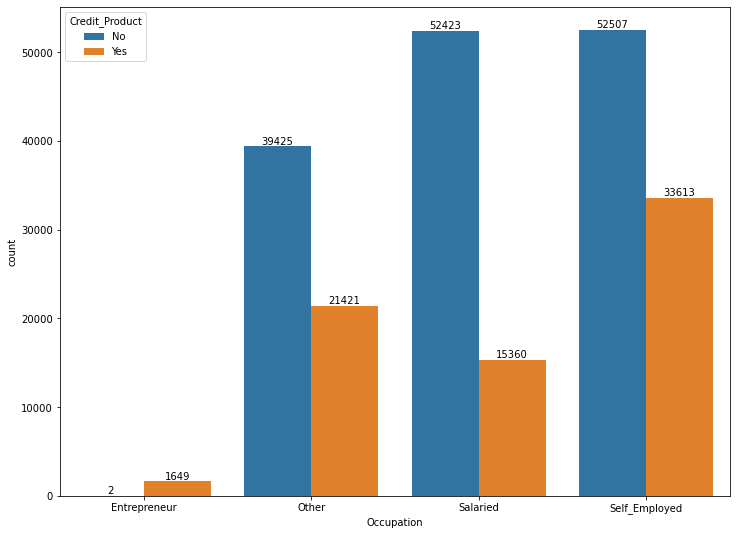

In [217]:
plt.figure(figsize=(12,9))
cplot = sns.countplot(data=train, x='Occupation', hue='Credit_Product')
for count in cplot.patches:
    height = count.get_height()
    plt.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')

From above plot can see that majority of non credit product holders are in self-employed, salaried and other categories.

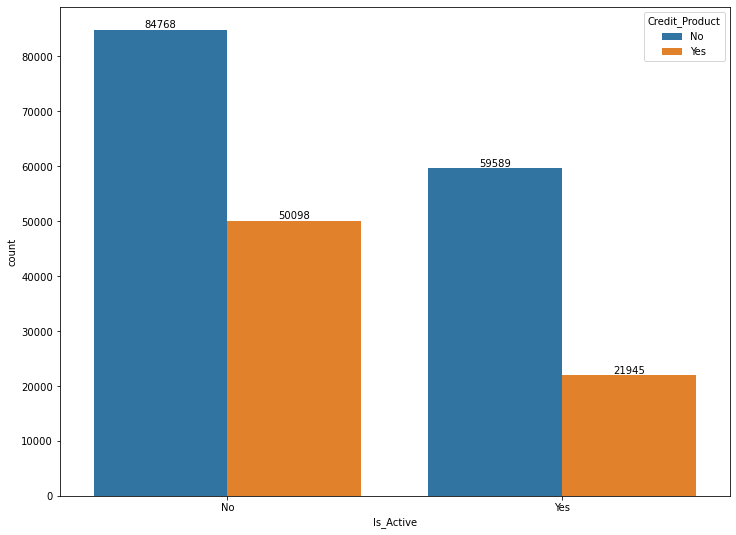

In [218]:
plt.figure(figsize=(12,9))
cplot = sns.countplot(data=train, x='Is_Active', hue='Credit_Product')
for count in cplot.patches:
    height = count.get_height()
    plt.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')

From above plot can see that, some of the inactive accounts also has credit products

## Impute missing values

In our case, we have missing data only in Credit_Product (11%). Lets now impute the occupation specific mode

In [219]:
group_mean = train.groupby('Occupation')['Credit_Product'].agg(pd.Series.mode)
missing_credit = train.loc[train.Credit_Product.isna()==True]
missing_credit['Credit_Product']=missing_credit.apply(lambda row: group_mean[row['Occupation']], axis=1)
train.drop(missing_credit.index, inplace=True)
train = pd.concat([train, missing_credit], ignore_index=True)

<ipython-input-219-93bd477a079d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_credit['Credit_Product']=missing_credit.apply(lambda row: group_mean[row['Occupation']], axis=1)


In [220]:
train.isna().sum()

Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

Now have successfully imputed the group specific mode into the missing column. Lets start building our model.

Now lets impute the missing values in test dataset also with the same mode

In [221]:
missing_credit = test.loc[test.Credit_Product.isna()==True]
missing_credit['Credit_Product']=missing_credit.apply(lambda row: group_mean[row['Occupation']], axis=1)
test.drop(missing_credit.index, inplace=True)
test = pd.concat([test, missing_credit], ignore_index=True)

<ipython-input-221-c9f682f6757c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_credit['Credit_Product']=missing_credit.apply(lambda row: group_mean[row['Occupation']], axis=1)


In [222]:
test.head()

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  VBENBARO    Male   29       RG254          Other           X1       25   
1  VK3KGA9M    Male   31       RG270       Salaried           X1       14   
2  TT8RPZVC    Male   29       RG272          Other           X1       33   
3  SHQZEYTZ  Female   29       RG270          Other           X1       19   
4  MZZAQMPT    Male   60       RG268  Self_Employed           X3      110   

  Credit_Product  Avg_Account_Balance Is_Active  
0            Yes               742366        No  
1             No               215949        No  
2             No               868070        No  
3             No               657087        No  
4             No              4624262        No

## Encoding the data

In [223]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Gender               245725 non-null  category
 1   Age                  245725 non-null  int64   
 2   Region_Code          245725 non-null  category
 3   Occupation           245725 non-null  category
 4   Channel_Code         245725 non-null  category
 5   Vintage              245725 non-null  int64   
 6   Credit_Product       245725 non-null  object  
 7   Avg_Account_Balance  245725 non-null  int64   
 8   Is_Active            245725 non-null  category
 9   Is_Lead              245725 non-null  category
dtypes: category(6), int64(3), object(1)
memory usage: 8.9+ MB


Now the Credit_Product has change to object dtype. Lets change to category

In [224]:
train['Credit_Product'] = train['Credit_Product'].astype('category')
test['Credit_Product'] = test['Credit_Product'].astype('category')

In [225]:
Y = train['Is_Lead']
X = train.drop('Is_Lead', axis=1)

In [226]:
def encode_cats(data,categoricals):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(data.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=data.index) #keep the same index values
    data.drop(categoricals, axis=1, inplace=True)
    return pd.concat([data, X_ohe], axis=1)

In [227]:
categoricals = list(X.select_dtypes('category').columns)
X = encode_cats(X, categoricals)

In [228]:
X.head()

Age  Vintage  Avg_Account_Balance  Gender_Male  Region_Code_RG251  \
0   73       43              1045696      0.00000            0.00000   
1   30       32               581988      0.00000            0.00000   
2   56       26              1484315      0.00000            0.00000   
3   34       19               470454      1.00000            0.00000   
4   30       33               886787      0.00000            0.00000   

   Region_Code_RG252  Region_Code_RG253  Region_Code_RG254  Region_Code_RG255  \
0            0.00000            0.00000            0.00000            0.00000   
1            0.00000            0.00000            0.00000            0.00000   
2            0.00000            0.00000            0.00000            0.00000   
3            0.00000            0.00000            0.00000            0.00000   
4            0.00000            0.00000            0.00000            0.00000   

   Region_Code_RG256  ...  Region_Code_RG283  Region_Code_RG284  \
0            0.00000  ...            0.00000            0.00000   
1            0.00000  ...            0.00000            0.00000   
2            0.00000  ...            0.00000            0.00000   
3            0.00000  ...            0.00000            0.00000   
4            0.00000  ...            0.00000            0.00000   

   Occupation_Other  Occupation_Salaried  Occupation_Self_Employed  \
0           1.00000              0.00000                   0.00000   
1           0.00000              1.00000                   0.00000   
2           0.00000              0.00000                   1.00000   
3           0.00000              1.00000                   0.00000   
4           0.00000              1.00000                   0.00000   

   Channel_Code_X2  Channel_Code_X3  Channel_Code_X4  Credit_Product_Yes  \
0          0.00000          1.00000          0.00000             0.00000   
1          0.00000          0.00000          0.00000             0.00000   
2          0.00000          1.00000          0.00000             0.00000   
3          0.00000          0.00000          0.00000             0.00000   
4          0.00000          0.00000          0.00000             0.00000   

   Is_Active_Yes  
0        0.00000  
1        0.00000  
2        1.00000  
3        0.00000  
4        0.00000  

[5 rows x 46 columns]

In [229]:
categoricals_test = list(test.select_dtypes('category').columns)
test = encode_cats(test, categoricals_test)

In [230]:
test.head()

ID  Age  Vintage  Avg_Account_Balance  Gender_Male  \
0  VBENBARO   29       25               742366      1.00000   
1  VK3KGA9M   31       14               215949      1.00000   
2  TT8RPZVC   29       33               868070      1.00000   
3  SHQZEYTZ   29       19               657087      0.00000   
4  MZZAQMPT   60      110              4624262      1.00000   

   Region_Code_RG251  Region_Code_RG252  Region_Code_RG253  Region_Code_RG254  \
0            0.00000            0.00000            0.00000            1.00000   
1            0.00000            0.00000            0.00000            0.00000   
2            0.00000            0.00000            0.00000            0.00000   
3            0.00000            0.00000            0.00000            0.00000   
4            0.00000            0.00000            0.00000            0.00000   

   Region_Code_RG255  ...  Region_Code_RG283  Region_Code_RG284  \
0            0.00000  ...            0.00000            0.00000   
1            0.00000  ...            0.00000            0.00000   
2            0.00000  ...            0.00000            0.00000   
3            0.00000  ...            0.00000            0.00000   
4            0.00000  ...            0.00000            0.00000   

   Occupation_Other  Occupation_Salaried  Occupation_Self_Employed  \
0           1.00000              0.00000                   0.00000   
1           0.00000              1.00000                   0.00000   
2           1.00000              0.00000                   0.00000   
3           1.00000              0.00000                   0.00000   
4           0.00000              0.00000                   1.00000   

   Channel_Code_X2  Channel_Code_X3  Channel_Code_X4  Credit_Product_Yes  \
0          0.00000          0.00000          0.00000             1.00000   
1          0.00000          0.00000          0.00000             0.00000   
2          0.00000          0.00000          0.00000             0.00000   
3          0.00000          0.00000          0.00000             0.00000   
4          0.00000          1.00000          0.00000             0.00000   

   Is_Active_Yes  
0        0.00000  
1        0.00000  
2        0.00000  
3        0.00000  
4        0.00000  

[5 rows x 47 columns]

## Split the data

In [231]:
#We are using 80-20 split for train-test
VALID_SIZE = 0.2
#We also use random state for reproducibility
RANDOM_STATE = 2018

train_X, valid_X, train_Y, valid_Y = train_test_split(X,Y, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [232]:
train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape, test.shape

((196580, 46), (196580,), (49145, 46), (49145,), (105312, 47))

In [48]:
test.head()

ID  Age  Vintage  Avg_Account_Balance  Gender_Male  \
0  VBENBARO   29       25               742366      1.00000   
1  VK3KGA9M   31       14               215949      1.00000   
2  TT8RPZVC   29       33               868070      1.00000   
3  SHQZEYTZ   29       19               657087      0.00000   
4  MZZAQMPT   60      110              4624262      1.00000   

   Region_Code_RG251  Region_Code_RG252  Region_Code_RG253  Region_Code_RG254  \
0            0.00000            0.00000            0.00000            1.00000   
1            0.00000            0.00000            0.00000            0.00000   
2            0.00000            0.00000            0.00000            0.00000   
3            0.00000            0.00000            0.00000            0.00000   
4            0.00000            0.00000            0.00000            0.00000   

   Region_Code_RG255  ...  Region_Code_RG283  Region_Code_RG284  \
0            0.00000  ...            0.00000            0.00000   
1            0.00000  ...            0.00000            0.00000   
2            0.00000  ...            0.00000            0.00000   
3            0.00000  ...            0.00000            0.00000   
4            0.00000  ...            0.00000            0.00000   

   Occupation_Other  Occupation_Salaried  Occupation_Self_Employed  \
0           1.00000              0.00000                   0.00000   
1           0.00000              1.00000                   0.00000   
2           1.00000              0.00000                   0.00000   
3           1.00000              0.00000                   0.00000   
4           0.00000              0.00000                   1.00000   

   Channel_Code_X2  Channel_Code_X3  Channel_Code_X4  Credit_Product_Yes  \
0          0.00000          0.00000          0.00000             1.00000   
1          0.00000          0.00000          0.00000             0.00000   
2          0.00000          0.00000          0.00000             0.00000   
3          0.00000          0.00000          0.00000             0.00000   
4          0.00000          1.00000          0.00000             0.00000   

   Is_Active_Yes  
0        0.00000  
1        0.00000  
2        0.00000  
3        0.00000  
4        0.00000  

[5 rows x 47 columns]

## Encoded data

In [49]:
def scale_data(X_train, X_val, X_test):
    """
    Input: Features (numpy arrays)
    Output: Scaled data
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index= X_train.index)
    X_val_scaled = scaler.transform(X_val)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index= X_val.index)
    X_test_scaled = scaler.transform(X_test.iloc[:,1:])
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.iloc[:,1:].columns, index= X_test.iloc[:,1:].index)
    X_test_scaled = pd.concat([X_test.iloc[:,0], X_test_scaled], axis=1)
    return X_train_scaled, X_val_scaled, X_test_scaled

In [50]:
train_x_scaled, val_X_scaled, test_scaled= scale_data(train_X, valid_X, test)

In [83]:
test_scaled.head()

ID      Age  Vintage  Avg_Account_Balance  Gender_Male  \
0  VBENBARO -1.00223 -0.67882             -0.45254      0.91214   
1  VK3KGA9M -0.86731 -1.01893             -1.07049      0.91214   
2  TT8RPZVC -1.00223 -0.43147             -0.30498      0.91214   
3  SHQZEYTZ -1.00223 -0.86433             -0.55265     -1.09632   
4  MZZAQMPT  1.08902  1.94928              4.10436      0.91214   

   Region_Code_RG251  Region_Code_RG252  Region_Code_RG253  Region_Code_RG254  \
0           -0.15768           -0.13273           -0.08659            2.84866   
1           -0.15768           -0.13273           -0.08659           -0.35104   
2           -0.15768           -0.13273           -0.08659           -0.35104   
3           -0.15768           -0.13273           -0.08659           -0.35104   
4           -0.15768           -0.13273           -0.08659           -0.35104   

   Region_Code_RG255  ...  Region_Code_RG283  Region_Code_RG284  \
0           -0.09152  ...           -0.36857           -0.29216   
1           -0.09152  ...           -0.36857           -0.29216   
2           -0.09152  ...           -0.36857           -0.29216   
3           -0.09152  ...           -0.36857           -0.29216   
4           -0.09152  ...           -0.36857           -0.29216   

   Occupation_Other  Occupation_Salaried  Occupation_Self_Employed  \
0           1.58382             -0.64384                  -0.83542   
1          -0.63139              1.55318                  -0.83542   
2           1.58382             -0.64384                  -0.83542   
3           1.58382             -0.64384                  -0.83542   
4          -0.63139             -0.64384                   1.19701   

   Channel_Code_X2  Channel_Code_X3  Channel_Code_X4  Credit_Product_Yes  \
0         -0.61782         -0.62173         -0.15283             1.53847   
1         -0.61782         -0.62173         -0.15283            -0.64999   
2         -0.61782         -0.62173         -0.15283            -0.64999   
3         -0.61782         -0.62173         -0.15283            -0.64999   
4         -0.61782          1.60842         -0.15283            -0.64999   

   Is_Active_Yes  
0       -0.79633  
1       -0.79633  
2       -0.79633  
3       -0.79633  
4       -0.79633  

[5 rows x 47 columns]

## Random Forest model

From our analysis, can see Credit_products, Is_Active, Occupation, avg_account_balance have significant effect on the target variable.

In [131]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier
RANDOM_STATE = 2018
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result
#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

In [54]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [55]:
clf.fit(train_X, train_Y)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [56]:
preds = clf.predict_proba(valid_X)

In [67]:
preds_class = clf.predict(valid_X)

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc_score(valid_Y.values, preds[:,1])

0.7541184445793021

In [58]:
test.head()

ID  Age  Vintage  Avg_Account_Balance  Gender_Male  \
0  VBENBARO   29       25               742366      1.00000   
1  VK3KGA9M   31       14               215949      1.00000   
2  TT8RPZVC   29       33               868070      1.00000   
3  SHQZEYTZ   29       19               657087      0.00000   
4  MZZAQMPT   60      110              4624262      1.00000   

   Region_Code_RG251  Region_Code_RG252  Region_Code_RG253  Region_Code_RG254  \
0            0.00000            0.00000            0.00000            1.00000   
1            0.00000            0.00000            0.00000            0.00000   
2            0.00000            0.00000            0.00000            0.00000   
3            0.00000            0.00000            0.00000            0.00000   
4            0.00000            0.00000            0.00000            0.00000   

   Region_Code_RG255  ...  Region_Code_RG283  Region_Code_RG284  \
0            0.00000  ...            0.00000            0.00000   
1            0.00000  ...            0.00000            0.00000   
2            0.00000  ...            0.00000            0.00000   
3            0.00000  ...            0.00000            0.00000   
4            0.00000  ...            0.00000            0.00000   

   Occupation_Other  Occupation_Salaried  Occupation_Self_Employed  \
0           1.00000              0.00000                   0.00000   
1           0.00000              1.00000                   0.00000   
2           1.00000              0.00000                   0.00000   
3           1.00000              0.00000                   0.00000   
4           0.00000              0.00000                   1.00000   

   Channel_Code_X2  Channel_Code_X3  Channel_Code_X4  Credit_Product_Yes  \
0          0.00000          0.00000          0.00000             1.00000   
1          0.00000          0.00000          0.00000             0.00000   
2          0.00000          0.00000          0.00000             0.00000   
3          0.00000          0.00000          0.00000             0.00000   
4          0.00000          1.00000          0.00000             0.00000   

   Is_Active_Yes  
0        0.00000  
1        0.00000  
2        0.00000  
3        0.00000  
4        0.00000  

[5 rows x 47 columns]

In [84]:
preds_test = clf.predict_proba(test.iloc[:,1:])
test_pred = np.stack([test.ID.values,preds_test[:,1]], axis=1)
test_pred = pd.DataFrame(test_pred, columns=['ID', 'Is_Lead'])
test_pred.to_csv('submission.csv', index=False)

In [63]:
test_pred

ID Is_Lead
0       VBENBARO     0.0
1       VK3KGA9M    0.04
2       TT8RPZVC    0.11
3       SHQZEYTZ    0.02
4       MZZAQMPT    0.81
...          ...     ...
105307  ZXCWURWZ    0.99
105308  RKSESPFM    0.27
105309  EPJEMD9H    0.45
105310  GWVNNKSG    0.15
105311  SNHPAJMB    0.35

[105312 rows x 2 columns]

### Feature Importance

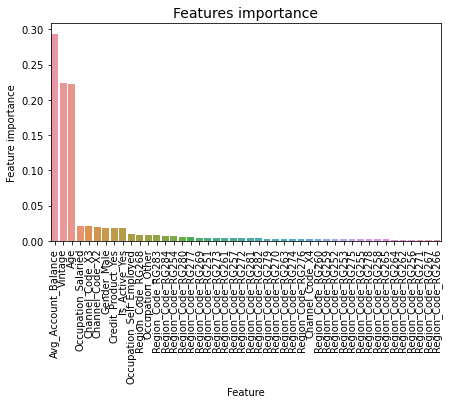

In [65]:
tmp = pd.DataFrame({'Feature': train_X.columns, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

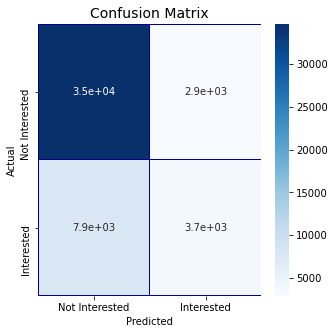

In [68]:
cm = pd.crosstab(valid_Y.values, preds_class, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Interested', 'Interested'],
            yticklabels=['Not Interested', 'Interested'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [111]:
print(classification_report(valid_Y, preds_class))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     37607
           1       0.56      0.32      0.41     11538

    accuracy                           0.78     49145
   macro avg       0.69      0.62      0.64     49145
weighted avg       0.75      0.78      0.76     49145



## Logistic Regression

In [85]:
lr = LogisticRegression(penalty='none')
lr.fit(train_x_scaled[predictors],train_Y)

LogisticRegression(penalty='none')

In [86]:
preds_lr = lr.predict_proba(val_X_scaled[predictors])
preds_lr_class = lr.predict(val_X_scaled[predictors])

In [87]:
roc_auc_score(valid_Y.values, preds_lr[:,1])

0.7007328020051072

### Confusion matrix

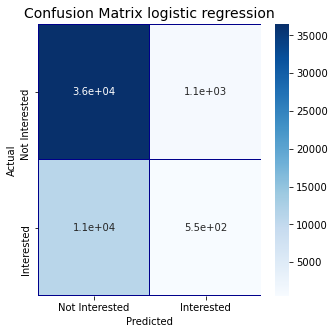

In [88]:
cm = pd.crosstab(valid_Y.values, preds_lr_class, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Interested', 'Interested'],
            yticklabels=['Not Interested', 'Interested'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix logistic regression', fontsize=14)
plt.show()

In [109]:
preds_test_lr = lr.predict_proba(test_scaled[predictors])
test_pred_lr = np.stack([test_scaled.ID.values,preds_test_lr[:,1]], axis=1)
test_pred_lr = pd.DataFrame(test_pred_lr, columns=['ID', 'Is_Lead'])
test_pred_lr.to_csv('submission_lr.csv', index=False)

### classification report

In [112]:
print(classification_report(valid_Y, preds_lr_class))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86     37607
           1       0.33      0.05      0.08     11538

    accuracy                           0.75     49145
   macro avg       0.55      0.51      0.47     49145
weighted avg       0.67      0.75      0.68     49145



## AdaBoost classifier

In [115]:
clf_abc = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [117]:
clf_abc.fit(train_X, train_Y)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [121]:
preds_abc = clf_abc.predict_proba(valid_X)

In [122]:
preds_class_abc = clf_abc.predict(valid_X)

In [123]:
from sklearn.metrics import roc_auc_score
roc_auc_score(valid_Y.values, preds_abc[:,1])

0.76403976883054

### submission

In [124]:
preds_test_abc = clf_abc.predict_proba(test.iloc[:,1:])
test_pred_abc = np.stack([test.ID.values,preds_test[:,1]], axis=1)
test_pred_abc = pd.DataFrame(test_pred_abc, columns=['ID', 'Is_Lead'])
test_pred_abc.to_csv('submission_abc.csv', index=False)

### Feature Importance

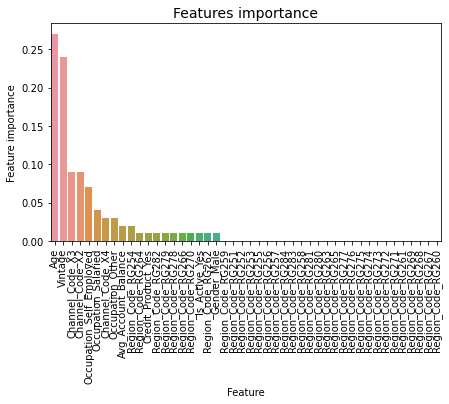

In [126]:
tmp = pd.DataFrame({'Feature': train_X.columns, 'Feature importance': clf_abc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

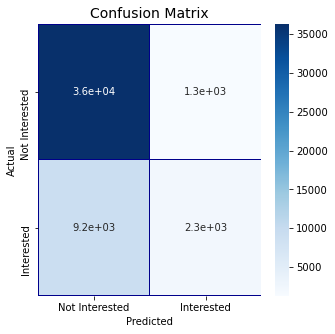

In [127]:
cm = pd.crosstab(valid_Y.values, preds_class_abc, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Interested', 'Interested'],
            yticklabels=['Not Interested', 'Interested'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [128]:
print(classification_report(valid_Y, preds_class_abc))

              precision    recall  f1-score   support

           0       0.80      0.97      0.87     37607
           1       0.64      0.20      0.30     11538

    accuracy                           0.79     49145
   macro avg       0.72      0.58      0.59     49145
weighted avg       0.76      0.79      0.74     49145



## Catboost classifier

In [233]:
clf_cbc = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [234]:
clf_cbc.fit(train_X, train_Y, verbose=True)

0:	total: 56.5ms	remaining: 28.2s
50:	total: 9.39s	remaining: 1m 22s
100:	total: 18.7s	remaining: 1m 13s
150:	total: 28.7s	remaining: 1m 6s
200:	total: 37.9s	remaining: 56.4s
250:	total: 47s	remaining: 46.7s
300:	total: 57s	remaining: 37.7s
350:	total: 1m 6s	remaining: 28.4s
400:	total: 1m 16s	remaining: 18.8s
450:	total: 1m 26s	remaining: 9.39s
499:	total: 1m 35s	remaining: 0us


In [235]:
preds_cbc = clf_cbc.predict_proba(valid_X)
preds_cbc_class = clf_cbc.predict(valid_X)

### Feature importance

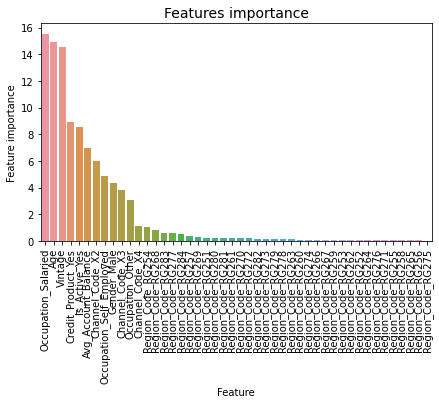

In [236]:
tmp = pd.DataFrame({'Feature': train_X.columns, 'Feature importance': clf_cbc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

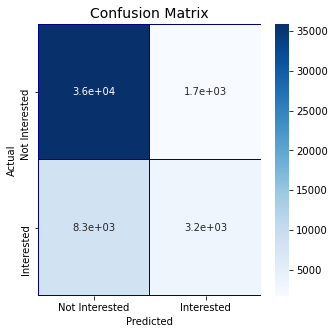

In [237]:
cm = pd.crosstab(valid_Y.values, preds_cbc_class, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Interested', 'Interested'],
            yticklabels=['Not Interested', 'Interested'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [238]:
roc_auc_score(valid_Y.values, preds_cbc[:,1])

0.7882806529321826

In [239]:
print(classification_report(valid_Y, preds_cbc_class))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88     37607
           1       0.65      0.28      0.39     11538

    accuracy                           0.80     49145
   macro avg       0.73      0.62      0.63     49145
weighted avg       0.77      0.80      0.76     49145



In [142]:
preds_test_cbc = clf_cbc.predict_proba(test.iloc[:,1:])
test_pred_cbc = np.stack([test.ID.values,preds_test_cbc[:,1]], axis=1)
test_pred_cbc = pd.DataFrame(test_pred_cbc, columns=['ID', 'Is_Lead'])
test_pred_cbc.to_csv('submission_cbc.csv', index=False)

## XGBoost

In [143]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_X, train_Y)
dvalid = xgb.DMatrix(valid_X, valid_Y)
dtest = xgb.DMatrix(test.iloc[:,1:])

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [144]:
clf_xgb = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[12:47:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.72036	valid-auc:0.72288
[50]	train-auc:0.74750	valid-auc:0.74914
[100]	train-auc:0.76054	valid-auc:0.76173
[150]	train-auc:0.76662	valid-auc:0.76768
[200]	train-auc:0.77030	valid-auc:0.77110
[250]	train-auc:0.77240	valid-auc:0.77306
[300]	train-auc:0.77359	valid-auc:0.77418
[350]	train-auc:0.77464	valid-auc:0.77521
[400]	train-auc:0.77538	valid-auc:0.77593
[450]	train-auc:0.77595	valid-auc:0.77647
[500]	train-auc:0.77644	valid-auc:0.77689
[550]	train-auc:0.77678	valid-auc:0.77714
[600]	train-auc:0.77718	valid-auc:0.77747
[650]	train-auc:0.77755	valid-auc:0.77781
[700]	train-auc:0.77781	valid

In [149]:
preds_xgb = clf_xgb.predict(dvalid)

In [150]:
roc_auc_score(valid_Y, preds_xgb)

0.7790211232632746

### Feature importance

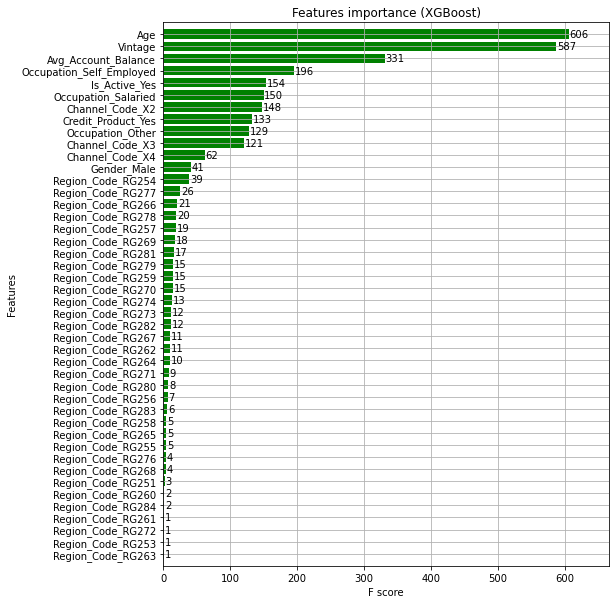

In [146]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,10))
xgb.plot_importance(clf_xgb, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

### submission

In [169]:
preds_test_xgb = clf_xgb.predict(dtest)
test_pred_xgb = np.stack([test.ID.values,preds_test[:,1]], axis=1)
test_pred_xgb = pd.DataFrame(test_pred_xgb, columns=['ID', 'Is_Lead'])
test_pred_xgb.to_csv('submission_xgb.csv', index=False)

## Hyperparameter tuning

In [263]:
grid = {'depth':[6,5,7,8,9,10,11,12,13],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200]
          }

In [265]:
cbc = CatBoostClassifier(task_type='GPU')
gscv = GridSearchCV (estimator = cbc, param_grid = grid, scoring ='accuracy', cv = 5)

In [ ]:
gscv.fit(train_X[predictors], train_Y)

0:	learn: 0.6760883	total: 50.2ms	remaining: 12.5s
1:	learn: 0.6603047	total: 69ms	remaining: 8.55s
2:	learn: 0.6456247	total: 88.7ms	remaining: 7.31s
3:	learn: 0.6320408	total: 109ms	remaining: 6.72s
4:	learn: 0.6196087	total: 129ms	remaining: 6.34s
5:	learn: 0.6079563	total: 150ms	remaining: 6.09s
6:	learn: 0.5973687	total: 170ms	remaining: 5.89s
7:	learn: 0.5873474	total: 190ms	remaining: 5.74s
8:	learn: 0.5780599	total: 210ms	remaining: 5.62s
9:	learn: 0.5696289	total: 230ms	remaining: 5.51s
10:	learn: 0.5617935	total: 250ms	remaining: 5.42s
11:	learn: 0.5545991	total: 269ms	remaining: 5.34s
12:	learn: 0.5477092	total: 291ms	remaining: 5.3s
13:	learn: 0.5414994	total: 311ms	remaining: 5.23s
14:	learn: 0.5356875	total: 331ms	remaining: 5.18s
15:	learn: 0.5301654	total: 350ms	remaining: 5.11s
16:	learn: 0.5252449	total: 367ms	remaining: 5.03s
17:	learn: 0.5208137	total: 385ms	remaining: 4.96s
18:	learn: 0.5165472	total: 403ms	remaining: 4.89s
19:	learn: 0.5123667	total: 420ms	remaini

163:	learn: 0.4433996	total: 3.11s	remaining: 1.63s
164:	learn: 0.4433726	total: 3.13s	remaining: 1.61s
165:	learn: 0.4433247	total: 3.15s	remaining: 1.59s
166:	learn: 0.4432587	total: 3.16s	remaining: 1.57s
167:	learn: 0.4431990	total: 3.18s	remaining: 1.55s
168:	learn: 0.4431249	total: 3.2s	remaining: 1.53s
169:	learn: 0.4430948	total: 3.21s	remaining: 1.51s
170:	learn: 0.4430702	total: 3.23s	remaining: 1.49s
171:	learn: 0.4430411	total: 3.25s	remaining: 1.47s
172:	learn: 0.4430149	total: 3.27s	remaining: 1.45s
173:	learn: 0.4429868	total: 3.28s	remaining: 1.43s
174:	learn: 0.4429533	total: 3.3s	remaining: 1.42s
175:	learn: 0.4429176	total: 3.32s	remaining: 1.4s
176:	learn: 0.4429036	total: 3.34s	remaining: 1.38s
177:	learn: 0.4428702	total: 3.35s	remaining: 1.36s
178:	learn: 0.4428468	total: 3.37s	remaining: 1.34s
179:	learn: 0.4427958	total: 3.39s	remaining: 1.32s
180:	learn: 0.4427678	total: 3.41s	remaining: 1.3s
181:	learn: 0.4427029	total: 3.42s	remaining: 1.28s
182:	learn: 0.44

75:	learn: 0.4499665	total: 1.47s	remaining: 3.37s
76:	learn: 0.4497222	total: 1.49s	remaining: 3.35s
77:	learn: 0.4495616	total: 1.51s	remaining: 3.32s
78:	learn: 0.4492945	total: 1.52s	remaining: 3.3s
79:	learn: 0.4490294	total: 1.54s	remaining: 3.28s
80:	learn: 0.4488525	total: 1.56s	remaining: 3.25s
81:	learn: 0.4486112	total: 1.58s	remaining: 3.23s
82:	learn: 0.4483846	total: 1.6s	remaining: 3.21s
83:	learn: 0.4482557	total: 1.61s	remaining: 3.19s
84:	learn: 0.4481228	total: 1.63s	remaining: 3.17s
85:	learn: 0.4480164	total: 1.65s	remaining: 3.15s
86:	learn: 0.4478992	total: 1.67s	remaining: 3.12s
87:	learn: 0.4477188	total: 1.69s	remaining: 3.1s
88:	learn: 0.4475350	total: 1.7s	remaining: 3.08s
89:	learn: 0.4473485	total: 1.72s	remaining: 3.06s
90:	learn: 0.4472307	total: 1.74s	remaining: 3.04s
91:	learn: 0.4470502	total: 1.76s	remaining: 3.02s
92:	learn: 0.4468549	total: 1.77s	remaining: 2.99s
93:	learn: 0.4467671	total: 1.79s	remaining: 2.97s
94:	learn: 0.4466744	total: 1.81s	r

240:	learn: 0.4405010	total: 4.57s	remaining: 171ms
241:	learn: 0.4404835	total: 4.59s	remaining: 152ms
242:	learn: 0.4404634	total: 4.61s	remaining: 133ms
243:	learn: 0.4404509	total: 4.63s	remaining: 114ms
244:	learn: 0.4404385	total: 4.65s	remaining: 94.9ms
245:	learn: 0.4404258	total: 4.67s	remaining: 75.9ms
246:	learn: 0.4404076	total: 4.68s	remaining: 56.9ms
247:	learn: 0.4403929	total: 4.7s	remaining: 37.9ms
248:	learn: 0.4403788	total: 4.72s	remaining: 19ms
249:	learn: 0.4403667	total: 4.74s	remaining: 0us
0:	learn: 0.6761500	total: 33.5ms	remaining: 8.35s
1:	learn: 0.6604934	total: 53.6ms	remaining: 6.65s
2:	learn: 0.6458556	total: 73.4ms	remaining: 6.05s
3:	learn: 0.6323101	total: 93.8ms	remaining: 5.77s
4:	learn: 0.6199089	total: 114ms	remaining: 5.57s
5:	learn: 0.6082880	total: 134ms	remaining: 5.44s
6:	learn: 0.5977277	total: 153ms	remaining: 5.33s
7:	learn: 0.5877330	total: 174ms	remaining: 5.25s
8:	learn: 0.5784520	total: 192ms	remaining: 5.15s
9:	learn: 0.5700345	total:

157:	learn: 0.4441365	total: 2.94s	remaining: 1.71s
158:	learn: 0.4440707	total: 2.95s	remaining: 1.69s
159:	learn: 0.4440351	total: 2.97s	remaining: 1.67s
160:	learn: 0.4439792	total: 2.99s	remaining: 1.65s
161:	learn: 0.4439078	total: 3.01s	remaining: 1.63s
162:	learn: 0.4438738	total: 3.02s	remaining: 1.61s
163:	learn: 0.4438518	total: 3.04s	remaining: 1.59s
164:	learn: 0.4438213	total: 3.06s	remaining: 1.58s
165:	learn: 0.4437837	total: 3.08s	remaining: 1.56s
166:	learn: 0.4437591	total: 3.1s	remaining: 1.54s
167:	learn: 0.4437135	total: 3.11s	remaining: 1.52s
168:	learn: 0.4436779	total: 3.13s	remaining: 1.5s
169:	learn: 0.4436492	total: 3.15s	remaining: 1.48s
170:	learn: 0.4435960	total: 3.17s	remaining: 1.46s
171:	learn: 0.4435408	total: 3.19s	remaining: 1.45s
172:	learn: 0.4434900	total: 3.21s	remaining: 1.43s
173:	learn: 0.4434619	total: 3.23s	remaining: 1.41s
174:	learn: 0.4434373	total: 3.25s	remaining: 1.39s
175:	learn: 0.4434157	total: 3.26s	remaining: 1.37s
176:	learn: 0.

74:	learn: 0.4516628	total: 1.45s	remaining: 3.39s
75:	learn: 0.4514844	total: 1.47s	remaining: 3.37s
76:	learn: 0.4512133	total: 1.49s	remaining: 3.35s
77:	learn: 0.4510149	total: 1.51s	remaining: 3.34s
78:	learn: 0.4507900	total: 1.53s	remaining: 3.32s
79:	learn: 0.4505972	total: 1.55s	remaining: 3.3s
80:	learn: 0.4503715	total: 1.57s	remaining: 3.29s
81:	learn: 0.4501224	total: 1.59s	remaining: 3.27s
82:	learn: 0.4499792	total: 1.62s	remaining: 3.25s
83:	learn: 0.4498559	total: 1.64s	remaining: 3.24s
84:	learn: 0.4497076	total: 1.66s	remaining: 3.22s
85:	learn: 0.4495850	total: 1.68s	remaining: 3.21s
86:	learn: 0.4493626	total: 1.7s	remaining: 3.19s
87:	learn: 0.4491193	total: 1.72s	remaining: 3.17s
88:	learn: 0.4489320	total: 1.74s	remaining: 3.15s
89:	learn: 0.4487555	total: 1.77s	remaining: 3.14s
90:	learn: 0.4486199	total: 1.79s	remaining: 3.13s
91:	learn: 0.4484058	total: 1.81s	remaining: 3.11s
92:	learn: 0.4482054	total: 1.83s	remaining: 3.09s
93:	learn: 0.4480696	total: 1.85s

237:	learn: 0.4418604	total: 4.49s	remaining: 226ms
238:	learn: 0.4418334	total: 4.51s	remaining: 208ms
239:	learn: 0.4418188	total: 4.53s	remaining: 189ms
240:	learn: 0.4417894	total: 4.54s	remaining: 170ms
241:	learn: 0.4417729	total: 4.56s	remaining: 151ms
242:	learn: 0.4417530	total: 4.58s	remaining: 132ms
243:	learn: 0.4417349	total: 4.6s	remaining: 113ms
244:	learn: 0.4417010	total: 4.62s	remaining: 94.2ms
245:	learn: 0.4416927	total: 4.63s	remaining: 75.4ms
246:	learn: 0.4416788	total: 4.65s	remaining: 56.5ms
247:	learn: 0.4416631	total: 4.67s	remaining: 37.7ms
248:	learn: 0.4416474	total: 4.69s	remaining: 18.8ms
249:	learn: 0.4416341	total: 4.71s	remaining: 0us
0:	learn: 0.6762989	total: 22.1ms	remaining: 5.51s
1:	learn: 0.6609205	total: 42ms	remaining: 5.2s
2:	learn: 0.6462802	total: 61.9ms	remaining: 5.1s
3:	learn: 0.6327316	total: 81.8ms	remaining: 5.03s
4:	learn: 0.6202100	total: 102ms	remaining: 4.99s
5:	learn: 0.6084853	total: 121ms	remaining: 4.91s
6:	learn: 0.5978817	to

159:	learn: 0.4436878	total: 3.08s	remaining: 1.73s
160:	learn: 0.4436486	total: 3.09s	remaining: 1.71s
161:	learn: 0.4436209	total: 3.11s	remaining: 1.69s
162:	learn: 0.4435609	total: 3.13s	remaining: 1.67s
163:	learn: 0.4435301	total: 3.15s	remaining: 1.65s
164:	learn: 0.4434928	total: 3.17s	remaining: 1.63s
165:	learn: 0.4434418	total: 3.19s	remaining: 1.61s
166:	learn: 0.4434189	total: 3.2s	remaining: 1.59s
167:	learn: 0.4434015	total: 3.22s	remaining: 1.57s
168:	learn: 0.4433714	total: 3.24s	remaining: 1.55s
169:	learn: 0.4433408	total: 3.26s	remaining: 1.53s
170:	learn: 0.4433156	total: 3.28s	remaining: 1.51s
171:	learn: 0.4432497	total: 3.3s	remaining: 1.5s
172:	learn: 0.4432164	total: 3.31s	remaining: 1.48s
173:	learn: 0.4431964	total: 3.33s	remaining: 1.46s
174:	learn: 0.4431622	total: 3.36s	remaining: 1.44s
175:	learn: 0.4431479	total: 3.38s	remaining: 1.42s
176:	learn: 0.4431235	total: 3.41s	remaining: 1.41s
177:	learn: 0.4430879	total: 3.43s	remaining: 1.39s
178:	learn: 0.4

74:	learn: 0.6535651	total: 1.48s	remaining: 3.46s
75:	learn: 0.6530893	total: 1.5s	remaining: 3.44s
76:	learn: 0.6526084	total: 1.52s	remaining: 3.42s
77:	learn: 0.6521273	total: 1.54s	remaining: 3.4s
78:	learn: 0.6516552	total: 1.56s	remaining: 3.39s
79:	learn: 0.6511763	total: 1.58s	remaining: 3.37s
80:	learn: 0.6507002	total: 1.6s	remaining: 3.35s
81:	learn: 0.6502238	total: 1.63s	remaining: 3.33s
82:	learn: 0.6497564	total: 1.64s	remaining: 3.31s
83:	learn: 0.6492937	total: 1.66s	remaining: 3.29s
84:	learn: 0.6488206	total: 1.68s	remaining: 3.27s
85:	learn: 0.6483502	total: 1.7s	remaining: 3.25s
86:	learn: 0.6478942	total: 1.72s	remaining: 3.23s
87:	learn: 0.6474246	total: 1.74s	remaining: 3.21s
88:	learn: 0.6469681	total: 1.76s	remaining: 3.19s
89:	learn: 0.6465012	total: 1.78s	remaining: 3.17s
90:	learn: 0.6460355	total: 1.81s	remaining: 3.16s
91:	learn: 0.6455828	total: 1.83s	remaining: 3.15s
92:	learn: 0.6451216	total: 1.85s	remaining: 3.13s
93:	learn: 0.6446617	total: 1.87s	r

236:	learn: 0.5898849	total: 4.59s	remaining: 252ms
237:	learn: 0.5895637	total: 4.61s	remaining: 233ms
238:	learn: 0.5892436	total: 4.63s	remaining: 213ms
239:	learn: 0.5889223	total: 4.65s	remaining: 194ms
240:	learn: 0.5886024	total: 4.67s	remaining: 174ms
241:	learn: 0.5882888	total: 4.68s	remaining: 155ms
242:	learn: 0.5879798	total: 4.7s	remaining: 135ms
243:	learn: 0.5876684	total: 4.72s	remaining: 116ms
244:	learn: 0.5873540	total: 4.74s	remaining: 96.7ms
245:	learn: 0.5870377	total: 4.75s	remaining: 77.3ms
246:	learn: 0.5867287	total: 4.77s	remaining: 58ms
247:	learn: 0.5864238	total: 4.79s	remaining: 38.6ms
248:	learn: 0.5861197	total: 4.81s	remaining: 19.3ms
249:	learn: 0.5858082	total: 4.83s	remaining: 0us
0:	learn: 0.6925619	total: 23.8ms	remaining: 5.92s
1:	learn: 0.6919806	total: 43.7ms	remaining: 5.42s
2:	learn: 0.6913981	total: 63.7ms	remaining: 5.24s
3:	learn: 0.6908171	total: 83.7ms	remaining: 5.14s
4:	learn: 0.6902376	total: 103ms	remaining: 5.04s
5:	learn: 0.689659

151:	learn: 0.6197544	total: 2.92s	remaining: 1.88s
152:	learn: 0.6193598	total: 2.94s	remaining: 1.86s
153:	learn: 0.6189663	total: 2.95s	remaining: 1.84s
154:	learn: 0.6185726	total: 2.97s	remaining: 1.82s
155:	learn: 0.6181748	total: 2.99s	remaining: 1.8s
156:	learn: 0.6177903	total: 3.01s	remaining: 1.78s
157:	learn: 0.6174043	total: 3.02s	remaining: 1.76s
158:	learn: 0.6170129	total: 3.04s	remaining: 1.74s
159:	learn: 0.6166296	total: 3.06s	remaining: 1.72s
160:	learn: 0.6162402	total: 3.08s	remaining: 1.7s
161:	learn: 0.6158506	total: 3.1s	remaining: 1.68s
162:	learn: 0.6154715	total: 3.11s	remaining: 1.66s
163:	learn: 0.6150922	total: 3.13s	remaining: 1.64s
164:	learn: 0.6147131	total: 3.15s	remaining: 1.62s
165:	learn: 0.6143250	total: 3.17s	remaining: 1.6s
166:	learn: 0.6139410	total: 3.18s	remaining: 1.58s
167:	learn: 0.6135547	total: 3.2s	remaining: 1.56s
168:	learn: 0.6131695	total: 3.22s	remaining: 1.54s
169:	learn: 0.6127877	total: 3.24s	remaining: 1.52s
170:	learn: 0.612

64:	learn: 0.6585124	total: 1.24s	remaining: 3.54s
65:	learn: 0.6580276	total: 1.26s	remaining: 3.52s
66:	learn: 0.6575471	total: 1.28s	remaining: 3.5s
67:	learn: 0.6570616	total: 1.3s	remaining: 3.49s
68:	learn: 0.6565743	total: 1.33s	remaining: 3.48s
69:	learn: 0.6560912	total: 1.35s	remaining: 3.46s
70:	learn: 0.6556029	total: 1.37s	remaining: 3.45s
71:	learn: 0.6551285	total: 1.39s	remaining: 3.43s
72:	learn: 0.6546450	total: 1.4s	remaining: 3.4s
73:	learn: 0.6541725	total: 1.42s	remaining: 3.38s
74:	learn: 0.6536912	total: 1.44s	remaining: 3.36s
75:	learn: 0.6532149	total: 1.46s	remaining: 3.34s
76:	learn: 0.6527328	total: 1.48s	remaining: 3.32s
77:	learn: 0.6522532	total: 1.49s	remaining: 3.29s
78:	learn: 0.6517837	total: 1.51s	remaining: 3.27s
79:	learn: 0.6513066	total: 1.53s	remaining: 3.25s
80:	learn: 0.6508311	total: 1.55s	remaining: 3.23s
81:	learn: 0.6503562	total: 1.57s	remaining: 3.22s
82:	learn: 0.6498921	total: 1.59s	remaining: 3.2s
83:	learn: 0.6494317	total: 1.61s	re

228:	learn: 0.5927583	total: 4.36s	remaining: 400ms
229:	learn: 0.5924353	total: 4.38s	remaining: 381ms
230:	learn: 0.5921094	total: 4.4s	remaining: 362ms
231:	learn: 0.5917826	total: 4.42s	remaining: 343ms
232:	learn: 0.5914567	total: 4.43s	remaining: 324ms
233:	learn: 0.5911390	total: 4.45s	remaining: 304ms
234:	learn: 0.5908154	total: 4.47s	remaining: 285ms
235:	learn: 0.5904909	total: 4.49s	remaining: 266ms
236:	learn: 0.5901737	total: 4.5s	remaining: 247ms
237:	learn: 0.5898540	total: 4.53s	remaining: 228ms
238:	learn: 0.5895360	total: 4.55s	remaining: 209ms
239:	learn: 0.5892174	total: 4.57s	remaining: 190ms
240:	learn: 0.5888981	total: 4.58s	remaining: 171ms
241:	learn: 0.5885862	total: 4.6s	remaining: 152ms
242:	learn: 0.5882789	total: 4.62s	remaining: 133ms
243:	learn: 0.5879684	total: 4.64s	remaining: 114ms
244:	learn: 0.5876515	total: 4.66s	remaining: 95ms
245:	learn: 0.5873379	total: 4.67s	remaining: 76ms
246:	learn: 0.5870304	total: 4.69s	remaining: 57ms
247:	learn: 0.5867

144:	learn: 0.6228772	total: 2.72s	remaining: 1.97s
145:	learn: 0.6224829	total: 2.74s	remaining: 1.95s
146:	learn: 0.6220811	total: 2.76s	remaining: 1.93s
147:	learn: 0.6216802	total: 2.78s	remaining: 1.91s
148:	learn: 0.6212829	total: 2.8s	remaining: 1.9s
149:	learn: 0.6208893	total: 2.81s	remaining: 1.88s
150:	learn: 0.6204884	total: 2.83s	remaining: 1.86s
151:	learn: 0.6200969	total: 2.85s	remaining: 1.84s
152:	learn: 0.6197012	total: 2.87s	remaining: 1.82s
153:	learn: 0.6193093	total: 2.88s	remaining: 1.8s
154:	learn: 0.6189229	total: 2.9s	remaining: 1.78s
155:	learn: 0.6185270	total: 2.92s	remaining: 1.76s
156:	learn: 0.6181450	total: 2.94s	remaining: 1.74s
157:	learn: 0.6177606	total: 2.96s	remaining: 1.72s
158:	learn: 0.6173707	total: 2.97s	remaining: 1.7s
159:	learn: 0.6169958	total: 2.99s	remaining: 1.68s
160:	learn: 0.6166077	total: 3.01s	remaining: 1.66s
161:	learn: 0.6162204	total: 3.03s	remaining: 1.64s
162:	learn: 0.6158445	total: 3.04s	remaining: 1.63s
163:	learn: 0.615

54:	learn: 0.6634421	total: 1.05s	remaining: 3.74s
55:	learn: 0.6629337	total: 1.07s	remaining: 3.72s
56:	learn: 0.6624380	total: 1.09s	remaining: 3.71s
57:	learn: 0.6619292	total: 1.11s	remaining: 3.69s
58:	learn: 0.6614273	total: 1.13s	remaining: 3.67s
59:	learn: 0.6609212	total: 1.15s	remaining: 3.65s
60:	learn: 0.6604189	total: 1.17s	remaining: 3.63s
61:	learn: 0.6599267	total: 1.19s	remaining: 3.61s
62:	learn: 0.6594260	total: 1.21s	remaining: 3.59s
63:	learn: 0.6589328	total: 1.23s	remaining: 3.56s
64:	learn: 0.6584357	total: 1.25s	remaining: 3.54s
65:	learn: 0.6579448	total: 1.26s	remaining: 3.52s
66:	learn: 0.6574635	total: 1.28s	remaining: 3.5s
67:	learn: 0.6569780	total: 1.3s	remaining: 3.48s
68:	learn: 0.6564856	total: 1.32s	remaining: 3.46s
69:	learn: 0.6559998	total: 1.33s	remaining: 3.43s
70:	learn: 0.6555090	total: 1.35s	remaining: 3.41s
71:	learn: 0.6550353	total: 1.37s	remaining: 3.39s
72:	learn: 0.6545547	total: 1.39s	remaining: 3.37s
73:	learn: 0.6540818	total: 1.41s

216:	learn: 0.5964387	total: 4.14s	remaining: 630ms
217:	learn: 0.5961021	total: 4.16s	remaining: 611ms
218:	learn: 0.5957718	total: 4.18s	remaining: 592ms
219:	learn: 0.5954461	total: 4.2s	remaining: 573ms
220:	learn: 0.5951226	total: 4.22s	remaining: 554ms
221:	learn: 0.5947950	total: 4.24s	remaining: 534ms
222:	learn: 0.5944608	total: 4.25s	remaining: 515ms
223:	learn: 0.5941289	total: 4.27s	remaining: 496ms
224:	learn: 0.5938066	total: 4.29s	remaining: 477ms
225:	learn: 0.5934740	total: 4.31s	remaining: 458ms
226:	learn: 0.5931491	total: 4.33s	remaining: 438ms
227:	learn: 0.5928168	total: 4.35s	remaining: 419ms
228:	learn: 0.5924864	total: 4.37s	remaining: 400ms
229:	learn: 0.5921574	total: 4.38s	remaining: 381ms
230:	learn: 0.5918299	total: 4.4s	remaining: 362ms
231:	learn: 0.5915096	total: 4.42s	remaining: 343ms
232:	learn: 0.5911829	total: 4.44s	remaining: 324ms
233:	learn: 0.5908578	total: 4.46s	remaining: 305ms
234:	learn: 0.5905348	total: 4.48s	remaining: 286ms
235:	learn: 0.

132:	learn: 0.4655476	total: 2.56s	remaining: 2.25s
133:	learn: 0.4652396	total: 2.58s	remaining: 2.24s
134:	learn: 0.4649333	total: 2.6s	remaining: 2.22s
135:	learn: 0.4646351	total: 2.62s	remaining: 2.2s
136:	learn: 0.4643298	total: 2.64s	remaining: 2.18s
137:	learn: 0.4640348	total: 2.66s	remaining: 2.16s
138:	learn: 0.4637787	total: 2.68s	remaining: 2.14s
139:	learn: 0.4635302	total: 2.69s	remaining: 2.12s
140:	learn: 0.4632490	total: 2.71s	remaining: 2.1s
141:	learn: 0.4629672	total: 2.73s	remaining: 2.08s
142:	learn: 0.4627479	total: 2.75s	remaining: 2.06s
143:	learn: 0.4625333	total: 2.77s	remaining: 2.04s
144:	learn: 0.4622513	total: 2.78s	remaining: 2.02s
145:	learn: 0.4619557	total: 2.8s	remaining: 2s
146:	learn: 0.4617515	total: 2.82s	remaining: 1.98s
147:	learn: 0.4615512	total: 2.84s	remaining: 1.96s
148:	learn: 0.4613346	total: 2.86s	remaining: 1.94s
149:	learn: 0.4611414	total: 2.88s	remaining: 1.92s
150:	learn: 0.4608675	total: 2.9s	remaining: 1.9s
151:	learn: 0.4606839

44:	learn: 0.5363425	total: 850ms	remaining: 3.87s
45:	learn: 0.5345298	total: 869ms	remaining: 3.85s
46:	learn: 0.5327001	total: 886ms	remaining: 3.83s
47:	learn: 0.5309920	total: 904ms	remaining: 3.8s
48:	learn: 0.5294607	total: 922ms	remaining: 3.78s
49:	learn: 0.5278124	total: 939ms	remaining: 3.76s
50:	learn: 0.5260981	total: 958ms	remaining: 3.74s
51:	learn: 0.5244464	total: 977ms	remaining: 3.72s
52:	learn: 0.5228908	total: 996ms	remaining: 3.7s
53:	learn: 0.5213836	total: 1.01s	remaining: 3.68s
54:	learn: 0.5199197	total: 1.04s	remaining: 3.67s
55:	learn: 0.5185395	total: 1.06s	remaining: 3.66s
56:	learn: 0.5171211	total: 1.08s	remaining: 3.65s
57:	learn: 0.5157369	total: 1.1s	remaining: 3.63s
58:	learn: 0.5144261	total: 1.11s	remaining: 3.61s
59:	learn: 0.5131089	total: 1.13s	remaining: 3.59s
60:	learn: 0.5117696	total: 1.15s	remaining: 3.57s
61:	learn: 0.5105601	total: 1.17s	remaining: 3.54s
62:	learn: 0.5093589	total: 1.19s	remaining: 3.52s
63:	learn: 0.5081324	total: 1.21s	

210:	learn: 0.4514079	total: 3.96s	remaining: 732ms
211:	learn: 0.4513276	total: 3.98s	remaining: 713ms
212:	learn: 0.4512481	total: 4s	remaining: 694ms
213:	learn: 0.4511657	total: 4.01s	remaining: 675ms
214:	learn: 0.4510507	total: 4.03s	remaining: 656ms
215:	learn: 0.4509634	total: 4.05s	remaining: 637ms
216:	learn: 0.4508699	total: 4.07s	remaining: 618ms
217:	learn: 0.4507716	total: 4.08s	remaining: 600ms
218:	learn: 0.4506838	total: 4.1s	remaining: 581ms
219:	learn: 0.4506133	total: 4.12s	remaining: 562ms
220:	learn: 0.4505293	total: 4.14s	remaining: 543ms
221:	learn: 0.4504661	total: 4.15s	remaining: 524ms
222:	learn: 0.4503986	total: 4.17s	remaining: 505ms
223:	learn: 0.4503177	total: 4.19s	remaining: 487ms
224:	learn: 0.4502345	total: 4.21s	remaining: 468ms
225:	learn: 0.4501436	total: 4.23s	remaining: 449ms
226:	learn: 0.4500761	total: 4.25s	remaining: 431ms
227:	learn: 0.4499856	total: 4.27s	remaining: 412ms
228:	learn: 0.4499246	total: 4.29s	remaining: 393ms
229:	learn: 0.44

126:	learn: 0.4681695	total: 2.3s	remaining: 2.23s
127:	learn: 0.4678673	total: 2.32s	remaining: 2.21s
128:	learn: 0.4675227	total: 2.34s	remaining: 2.19s
129:	learn: 0.4671995	total: 2.35s	remaining: 2.17s
130:	learn: 0.4668750	total: 2.37s	remaining: 2.15s
131:	learn: 0.4665571	total: 2.39s	remaining: 2.13s
132:	learn: 0.4662624	total: 2.4s	remaining: 2.12s
133:	learn: 0.4659210	total: 2.42s	remaining: 2.1s
134:	learn: 0.4656514	total: 2.44s	remaining: 2.08s
135:	learn: 0.4653481	total: 2.46s	remaining: 2.06s
136:	learn: 0.4650839	total: 2.48s	remaining: 2.04s
137:	learn: 0.4647816	total: 2.49s	remaining: 2.02s
138:	learn: 0.4645196	total: 2.51s	remaining: 2s
139:	learn: 0.4642711	total: 2.53s	remaining: 1.99s
140:	learn: 0.4639793	total: 2.54s	remaining: 1.97s
141:	learn: 0.4636735	total: 2.56s	remaining: 1.95s
142:	learn: 0.4634611	total: 2.58s	remaining: 1.93s
143:	learn: 0.4632515	total: 2.6s	remaining: 1.91s
144:	learn: 0.4629636	total: 2.62s	remaining: 1.89s
145:	learn: 0.46274

44:	learn: 0.5373392	total: 838ms	remaining: 3.82s
45:	learn: 0.5355052	total: 856ms	remaining: 3.8s
46:	learn: 0.5337131	total: 874ms	remaining: 3.77s
47:	learn: 0.5319559	total: 893ms	remaining: 3.76s
48:	learn: 0.5302721	total: 911ms	remaining: 3.74s
49:	learn: 0.5286531	total: 933ms	remaining: 3.73s
50:	learn: 0.5269680	total: 954ms	remaining: 3.72s
51:	learn: 0.5253243	total: 976ms	remaining: 3.71s
52:	learn: 0.5237862	total: 998ms	remaining: 3.71s
53:	learn: 0.5222278	total: 1.02s	remaining: 3.7s
54:	learn: 0.5207425	total: 1.04s	remaining: 3.68s
55:	learn: 0.5193787	total: 1.05s	remaining: 3.65s
56:	learn: 0.5179186	total: 1.07s	remaining: 3.63s
57:	learn: 0.5165153	total: 1.09s	remaining: 3.61s
58:	learn: 0.5151673	total: 1.11s	remaining: 3.58s
59:	learn: 0.5138707	total: 1.12s	remaining: 3.56s
60:	learn: 0.5125429	total: 1.14s	remaining: 3.54s
61:	learn: 0.5113581	total: 1.16s	remaining: 3.52s
62:	learn: 0.5101710	total: 1.18s	remaining: 3.49s
63:	learn: 0.5089387	total: 1.2s	

207:	learn: 0.4530114	total: 3.77s	remaining: 761ms
208:	learn: 0.4529068	total: 3.79s	remaining: 743ms
209:	learn: 0.4527823	total: 3.81s	remaining: 725ms
210:	learn: 0.4526789	total: 3.83s	remaining: 707ms
211:	learn: 0.4525971	total: 3.85s	remaining: 690ms
212:	learn: 0.4524923	total: 3.87s	remaining: 672ms
213:	learn: 0.4523998	total: 3.89s	remaining: 654ms
214:	learn: 0.4523160	total: 3.91s	remaining: 636ms
215:	learn: 0.4522352	total: 3.93s	remaining: 618ms
216:	learn: 0.4521435	total: 3.94s	remaining: 600ms
217:	learn: 0.4520758	total: 3.97s	remaining: 582ms
218:	learn: 0.4519808	total: 3.98s	remaining: 564ms
219:	learn: 0.4519162	total: 4s	remaining: 546ms
220:	learn: 0.4518525	total: 4.02s	remaining: 528ms
221:	learn: 0.4517876	total: 4.04s	remaining: 510ms
222:	learn: 0.4517218	total: 4.06s	remaining: 491ms
223:	learn: 0.4516577	total: 4.08s	remaining: 473ms
224:	learn: 0.4515790	total: 4.09s	remaining: 455ms
225:	learn: 0.4514911	total: 4.11s	remaining: 437ms
226:	learn: 0.4

121:	learn: 0.4694665	total: 2.28s	remaining: 2.39s
122:	learn: 0.4690740	total: 2.3s	remaining: 2.37s
123:	learn: 0.4686952	total: 2.31s	remaining: 2.35s
124:	learn: 0.4683760	total: 2.33s	remaining: 2.33s
125:	learn: 0.4680171	total: 2.35s	remaining: 2.31s
126:	learn: 0.4676804	total: 2.37s	remaining: 2.29s
127:	learn: 0.4672932	total: 2.38s	remaining: 2.27s
128:	learn: 0.4669452	total: 2.4s	remaining: 2.25s
129:	learn: 0.4666560	total: 2.42s	remaining: 2.23s
130:	learn: 0.4663100	total: 2.44s	remaining: 2.21s
131:	learn: 0.4659866	total: 2.46s	remaining: 2.19s
132:	learn: 0.4657057	total: 2.48s	remaining: 2.18s
133:	learn: 0.4653565	total: 2.5s	remaining: 2.16s
134:	learn: 0.4651141	total: 2.52s	remaining: 2.14s
135:	learn: 0.4648083	total: 2.54s	remaining: 2.13s
136:	learn: 0.4644839	total: 2.55s	remaining: 2.11s
137:	learn: 0.4642304	total: 2.57s	remaining: 2.09s
138:	learn: 0.4639395	total: 2.59s	remaining: 2.07s
139:	learn: 0.4636768	total: 2.61s	remaining: 2.05s
140:	learn: 0.4

32:	learn: 0.4458383	total: 609ms	remaining: 4.01s
33:	learn: 0.4456841	total: 627ms	remaining: 3.98s
34:	learn: 0.4452903	total: 645ms	remaining: 3.96s
35:	learn: 0.4451236	total: 663ms	remaining: 3.94s
36:	learn: 0.4449308	total: 680ms	remaining: 3.91s
37:	learn: 0.4446465	total: 697ms	remaining: 3.89s
38:	learn: 0.4445334	total: 715ms	remaining: 3.87s
39:	learn: 0.4443931	total: 732ms	remaining: 3.84s
40:	learn: 0.4442758	total: 749ms	remaining: 3.82s
41:	learn: 0.4442076	total: 767ms	remaining: 3.8s
42:	learn: 0.4439069	total: 784ms	remaining: 3.77s
43:	learn: 0.4437256	total: 801ms	remaining: 3.75s
44:	learn: 0.4436578	total: 819ms	remaining: 3.73s
45:	learn: 0.4435810	total: 836ms	remaining: 3.71s
46:	learn: 0.4433807	total: 854ms	remaining: 3.69s
47:	learn: 0.4433035	total: 871ms	remaining: 3.67s
48:	learn: 0.4432270	total: 889ms	remaining: 3.65s
49:	learn: 0.4430935	total: 907ms	remaining: 3.63s
50:	learn: 0.4429620	total: 925ms	remaining: 3.61s
51:	learn: 0.4428210	total: 943m

201:	learn: 0.4364865	total: 3.73s	remaining: 886ms
202:	learn: 0.4364672	total: 3.75s	remaining: 867ms
203:	learn: 0.4364485	total: 3.76s	remaining: 849ms
204:	learn: 0.4364224	total: 3.78s	remaining: 830ms
205:	learn: 0.4363890	total: 3.8s	remaining: 811ms
206:	learn: 0.4363627	total: 3.81s	remaining: 793ms
207:	learn: 0.4363356	total: 3.83s	remaining: 774ms
208:	learn: 0.4363153	total: 3.85s	remaining: 755ms
209:	learn: 0.4362907	total: 3.87s	remaining: 737ms
210:	learn: 0.4362634	total: 3.88s	remaining: 718ms
211:	learn: 0.4362192	total: 3.9s	remaining: 700ms
212:	learn: 0.4361883	total: 3.92s	remaining: 681ms
213:	learn: 0.4361722	total: 3.94s	remaining: 663ms
214:	learn: 0.4361540	total: 3.96s	remaining: 645ms
215:	learn: 0.4361177	total: 3.98s	remaining: 626ms
216:	learn: 0.4360878	total: 4s	remaining: 608ms
217:	learn: 0.4360669	total: 4.02s	remaining: 590ms
218:	learn: 0.4360380	total: 4.04s	remaining: 572ms
219:	learn: 0.4360135	total: 4.06s	remaining: 554ms
220:	learn: 0.435

122:	learn: 0.4381078	total: 2.29s	remaining: 2.37s
123:	learn: 0.4380757	total: 2.31s	remaining: 2.35s
124:	learn: 0.4380479	total: 2.33s	remaining: 2.33s
125:	learn: 0.4380052	total: 2.35s	remaining: 2.31s
126:	learn: 0.4379709	total: 2.37s	remaining: 2.29s
127:	learn: 0.4379409	total: 2.39s	remaining: 2.28s
128:	learn: 0.4379046	total: 2.41s	remaining: 2.26s
129:	learn: 0.4378684	total: 2.43s	remaining: 2.24s
130:	learn: 0.4378436	total: 2.45s	remaining: 2.22s
131:	learn: 0.4378104	total: 2.46s	remaining: 2.2s
132:	learn: 0.4377546	total: 2.48s	remaining: 2.19s
133:	learn: 0.4377211	total: 2.5s	remaining: 2.17s
134:	learn: 0.4376817	total: 2.52s	remaining: 2.15s
135:	learn: 0.4376133	total: 2.54s	remaining: 2.13s
136:	learn: 0.4375858	total: 2.56s	remaining: 2.11s
137:	learn: 0.4375668	total: 2.58s	remaining: 2.09s
138:	learn: 0.4375051	total: 2.6s	remaining: 2.08s
139:	learn: 0.4374756	total: 2.62s	remaining: 2.06s
140:	learn: 0.4374406	total: 2.63s	remaining: 2.04s
141:	learn: 0.4

33:	learn: 0.4464943	total: 623ms	remaining: 3.96s
34:	learn: 0.4462131	total: 641ms	remaining: 3.94s
35:	learn: 0.4460842	total: 659ms	remaining: 3.92s
36:	learn: 0.4459375	total: 676ms	remaining: 3.89s
37:	learn: 0.4456333	total: 693ms	remaining: 3.87s
38:	learn: 0.4454904	total: 711ms	remaining: 3.85s
39:	learn: 0.4453315	total: 729ms	remaining: 3.83s
40:	learn: 0.4451769	total: 747ms	remaining: 3.81s
41:	learn: 0.4450681	total: 765ms	remaining: 3.79s
42:	learn: 0.4447981	total: 782ms	remaining: 3.77s
43:	learn: 0.4446383	total: 800ms	remaining: 3.75s
44:	learn: 0.4442768	total: 819ms	remaining: 3.73s
45:	learn: 0.4442053	total: 838ms	remaining: 3.71s
46:	learn: 0.4439507	total: 855ms	remaining: 3.69s
47:	learn: 0.4438574	total: 872ms	remaining: 3.67s
48:	learn: 0.4438001	total: 889ms	remaining: 3.65s
49:	learn: 0.4436665	total: 907ms	remaining: 3.63s
50:	learn: 0.4435743	total: 924ms	remaining: 3.61s
51:	learn: 0.4434400	total: 943ms	remaining: 3.59s
52:	learn: 0.4433647	total: 964

194:	learn: 0.4373531	total: 3.59s	remaining: 1.01s
195:	learn: 0.4373233	total: 3.61s	remaining: 994ms
196:	learn: 0.4372952	total: 3.63s	remaining: 976ms
197:	learn: 0.4372692	total: 3.65s	remaining: 957ms
198:	learn: 0.4372518	total: 3.66s	remaining: 939ms
199:	learn: 0.4372293	total: 3.68s	remaining: 921ms
200:	learn: 0.4372120	total: 3.7s	remaining: 902ms
201:	learn: 0.4371679	total: 3.72s	remaining: 884ms
202:	learn: 0.4371361	total: 3.74s	remaining: 866ms
203:	learn: 0.4371069	total: 3.76s	remaining: 848ms
204:	learn: 0.4370850	total: 3.78s	remaining: 829ms
205:	learn: 0.4370661	total: 3.8s	remaining: 811ms
206:	learn: 0.4370466	total: 3.82s	remaining: 793ms
207:	learn: 0.4370262	total: 3.83s	remaining: 775ms
208:	learn: 0.4370096	total: 3.85s	remaining: 756ms
209:	learn: 0.4369800	total: 3.87s	remaining: 738ms
210:	learn: 0.4369537	total: 3.89s	remaining: 719ms
211:	learn: 0.4369270	total: 3.91s	remaining: 701ms
212:	learn: 0.4369054	total: 3.93s	remaining: 682ms
213:	learn: 0.

108:	learn: 0.4401689	total: 2.11s	remaining: 2.73s
109:	learn: 0.4401425	total: 2.13s	remaining: 2.71s
110:	learn: 0.4400876	total: 2.15s	remaining: 2.7s
111:	learn: 0.4400374	total: 2.17s	remaining: 2.68s
112:	learn: 0.4399738	total: 2.19s	remaining: 2.66s
113:	learn: 0.4399090	total: 2.21s	remaining: 2.64s
114:	learn: 0.4398721	total: 2.23s	remaining: 2.62s
115:	learn: 0.4397893	total: 2.25s	remaining: 2.6s
116:	learn: 0.4397433	total: 2.27s	remaining: 2.58s
117:	learn: 0.4397184	total: 2.29s	remaining: 2.56s
118:	learn: 0.4396727	total: 2.31s	remaining: 2.54s
119:	learn: 0.4396450	total: 2.32s	remaining: 2.52s
120:	learn: 0.4396002	total: 2.34s	remaining: 2.5s
121:	learn: 0.4395536	total: 2.36s	remaining: 2.47s
122:	learn: 0.4394988	total: 2.38s	remaining: 2.45s
123:	learn: 0.4394568	total: 2.39s	remaining: 2.43s
124:	learn: 0.4394206	total: 2.41s	remaining: 2.41s
125:	learn: 0.4393792	total: 2.43s	remaining: 2.39s
126:	learn: 0.4393282	total: 2.45s	remaining: 2.37s
127:	learn: 0.4

21:	learn: 0.4518196	total: 432ms	remaining: 4.47s
22:	learn: 0.4508027	total: 454ms	remaining: 4.48s
23:	learn: 0.4502798	total: 474ms	remaining: 4.47s
24:	learn: 0.4495568	total: 493ms	remaining: 4.44s
25:	learn: 0.4490031	total: 512ms	remaining: 4.41s
26:	learn: 0.4484300	total: 531ms	remaining: 4.38s
27:	learn: 0.4481389	total: 550ms	remaining: 4.36s
28:	learn: 0.4478138	total: 569ms	remaining: 4.34s
29:	learn: 0.4475198	total: 589ms	remaining: 4.32s
30:	learn: 0.4472756	total: 607ms	remaining: 4.29s
31:	learn: 0.4471145	total: 625ms	remaining: 4.26s
32:	learn: 0.4466772	total: 645ms	remaining: 4.24s
33:	learn: 0.4464416	total: 665ms	remaining: 4.22s
34:	learn: 0.4461832	total: 685ms	remaining: 4.21s
35:	learn: 0.4458265	total: 705ms	remaining: 4.19s
36:	learn: 0.4456706	total: 723ms	remaining: 4.16s
37:	learn: 0.4454851	total: 741ms	remaining: 4.13s
38:	learn: 0.4453705	total: 758ms	remaining: 4.1s
39:	learn: 0.4450420	total: 775ms	remaining: 4.07s
40:	learn: 0.4447655	total: 793m

181:	learn: 0.4373476	total: 3.3s	remaining: 1.23s
182:	learn: 0.4373236	total: 3.32s	remaining: 1.21s
183:	learn: 0.4372983	total: 3.33s	remaining: 1.2s
184:	learn: 0.4372745	total: 3.35s	remaining: 1.18s
185:	learn: 0.4372391	total: 3.37s	remaining: 1.16s
186:	learn: 0.4372208	total: 3.39s	remaining: 1.14s
187:	learn: 0.4371984	total: 3.4s	remaining: 1.12s
188:	learn: 0.4371797	total: 3.42s	remaining: 1.1s
189:	learn: 0.4371563	total: 3.44s	remaining: 1.09s
190:	learn: 0.4371266	total: 3.46s	remaining: 1.07s
191:	learn: 0.4370992	total: 3.47s	remaining: 1.05s
192:	learn: 0.4370781	total: 3.49s	remaining: 1.03s
193:	learn: 0.4370500	total: 3.51s	remaining: 1.01s
194:	learn: 0.4370286	total: 3.53s	remaining: 995ms
195:	learn: 0.4370062	total: 3.54s	remaining: 977ms
196:	learn: 0.4369841	total: 3.56s	remaining: 959ms
197:	learn: 0.4369587	total: 3.58s	remaining: 940ms
198:	learn: 0.4369351	total: 3.6s	remaining: 922ms
199:	learn: 0.4368980	total: 3.62s	remaining: 904ms
200:	learn: 0.436

92:	learn: 0.4368663	total: 1.71s	remaining: 2.88s
93:	learn: 0.4368295	total: 1.72s	remaining: 2.86s
94:	learn: 0.4367956	total: 1.74s	remaining: 2.84s
95:	learn: 0.4367625	total: 1.76s	remaining: 2.82s
96:	learn: 0.4367015	total: 1.77s	remaining: 2.8s
97:	learn: 0.4366625	total: 1.79s	remaining: 2.78s
98:	learn: 0.4366215	total: 1.81s	remaining: 2.76s
99:	learn: 0.4365475	total: 1.83s	remaining: 2.74s
100:	learn: 0.4364930	total: 1.85s	remaining: 2.72s
101:	learn: 0.4364291	total: 1.86s	remaining: 2.71s
102:	learn: 0.4363867	total: 1.88s	remaining: 2.69s
103:	learn: 0.4363462	total: 1.9s	remaining: 2.67s
104:	learn: 0.4362846	total: 1.92s	remaining: 2.65s
105:	learn: 0.4362381	total: 1.94s	remaining: 2.63s
106:	learn: 0.4362150	total: 1.96s	remaining: 2.61s
107:	learn: 0.4361719	total: 1.97s	remaining: 2.6s
108:	learn: 0.4361147	total: 1.99s	remaining: 2.58s
109:	learn: 0.4360580	total: 2.01s	remaining: 2.56s
110:	learn: 0.4359971	total: 2.03s	remaining: 2.54s
111:	learn: 0.4359457	t

10:	learn: 0.4496942	total: 221ms	remaining: 4.8s
11:	learn: 0.4487576	total: 238ms	remaining: 4.72s
12:	learn: 0.4479912	total: 256ms	remaining: 4.66s
13:	learn: 0.4467679	total: 273ms	remaining: 4.61s
14:	learn: 0.4460747	total: 291ms	remaining: 4.56s
15:	learn: 0.4454587	total: 309ms	remaining: 4.53s
16:	learn: 0.4445956	total: 327ms	remaining: 4.48s
17:	learn: 0.4442277	total: 346ms	remaining: 4.46s
18:	learn: 0.4439521	total: 364ms	remaining: 4.42s
19:	learn: 0.4435738	total: 381ms	remaining: 4.39s
20:	learn: 0.4431585	total: 399ms	remaining: 4.35s
21:	learn: 0.4429940	total: 417ms	remaining: 4.33s
22:	learn: 0.4428548	total: 437ms	remaining: 4.32s
23:	learn: 0.4426071	total: 457ms	remaining: 4.3s
24:	learn: 0.4424140	total: 476ms	remaining: 4.29s
25:	learn: 0.4421844	total: 495ms	remaining: 4.26s
26:	learn: 0.4418228	total: 514ms	remaining: 4.24s
27:	learn: 0.4416441	total: 533ms	remaining: 4.23s
28:	learn: 0.4415041	total: 553ms	remaining: 4.21s
29:	learn: 0.4414066	total: 572ms

172:	learn: 0.4325264	total: 3.21s	remaining: 1.43s
173:	learn: 0.4324915	total: 3.23s	remaining: 1.41s
174:	learn: 0.4324548	total: 3.25s	remaining: 1.39s
175:	learn: 0.4324120	total: 3.27s	remaining: 1.38s
176:	learn: 0.4323585	total: 3.29s	remaining: 1.36s
177:	learn: 0.4323144	total: 3.31s	remaining: 1.34s
178:	learn: 0.4322780	total: 3.33s	remaining: 1.32s
179:	learn: 0.4322484	total: 3.35s	remaining: 1.3s
180:	learn: 0.4322139	total: 3.37s	remaining: 1.28s
181:	learn: 0.4321658	total: 3.39s	remaining: 1.27s
182:	learn: 0.4321339	total: 3.41s	remaining: 1.25s
183:	learn: 0.4321033	total: 3.43s	remaining: 1.23s
184:	learn: 0.4320706	total: 3.45s	remaining: 1.21s
185:	learn: 0.4320551	total: 3.46s	remaining: 1.19s
186:	learn: 0.4320243	total: 3.48s	remaining: 1.17s
187:	learn: 0.4319785	total: 3.5s	remaining: 1.16s
188:	learn: 0.4319479	total: 3.52s	remaining: 1.14s
189:	learn: 0.4319158	total: 3.54s	remaining: 1.12s
190:	learn: 0.4318640	total: 3.56s	remaining: 1.1s
191:	learn: 0.4

86:	learn: 0.4378607	total: 1.62s	remaining: 3.03s
87:	learn: 0.4378084	total: 1.64s	remaining: 3.02s
88:	learn: 0.4377298	total: 1.66s	remaining: 3s
89:	learn: 0.4376894	total: 1.68s	remaining: 2.98s
90:	learn: 0.4376378	total: 1.7s	remaining: 2.96s
91:	learn: 0.4375712	total: 1.72s	remaining: 2.94s
92:	learn: 0.4375238	total: 1.73s	remaining: 2.93s
93:	learn: 0.4374878	total: 1.75s	remaining: 2.9s
94:	learn: 0.4374268	total: 1.77s	remaining: 2.89s
95:	learn: 0.4373769	total: 1.79s	remaining: 2.87s
96:	learn: 0.4373209	total: 1.8s	remaining: 2.85s
97:	learn: 0.4372534	total: 1.82s	remaining: 2.83s
98:	learn: 0.4372002	total: 1.84s	remaining: 2.81s
99:	learn: 0.4371286	total: 1.86s	remaining: 2.79s
100:	learn: 0.4370712	total: 1.88s	remaining: 2.77s
101:	learn: 0.4370017	total: 1.9s	remaining: 2.75s
102:	learn: 0.4369765	total: 1.91s	remaining: 2.73s
103:	learn: 0.4369408	total: 1.93s	remaining: 2.71s
104:	learn: 0.4368998	total: 1.95s	remaining: 2.69s
105:	learn: 0.4368430	total: 1.96

246:	learn: 0.4315442	total: 4.53s	remaining: 55ms
247:	learn: 0.4315141	total: 4.55s	remaining: 36.7ms
248:	learn: 0.4314849	total: 4.57s	remaining: 18.3ms
249:	learn: 0.4314503	total: 4.58s	remaining: 0us
0:	learn: 0.5944936	total: 22.2ms	remaining: 5.53s
1:	learn: 0.5397970	total: 42ms	remaining: 5.21s
2:	learn: 0.5072279	total: 63.2ms	remaining: 5.21s
3:	learn: 0.4886515	total: 84.4ms	remaining: 5.19s
4:	learn: 0.4758448	total: 105ms	remaining: 5.16s
5:	learn: 0.4670398	total: 125ms	remaining: 5.06s
6:	learn: 0.4612233	total: 143ms	remaining: 4.97s
7:	learn: 0.4567745	total: 163ms	remaining: 4.93s
8:	learn: 0.4542535	total: 183ms	remaining: 4.89s
9:	learn: 0.4524034	total: 202ms	remaining: 4.85s
10:	learn: 0.4502552	total: 222ms	remaining: 4.83s
11:	learn: 0.4491300	total: 242ms	remaining: 4.81s
12:	learn: 0.4479911	total: 262ms	remaining: 4.78s
13:	learn: 0.4474266	total: 282ms	remaining: 4.75s
14:	learn: 0.4469231	total: 301ms	remaining: 4.71s
15:	learn: 0.4464944	total: 318ms	re

162:	learn: 0.4342636	total: 2.95s	remaining: 1.57s
163:	learn: 0.4342393	total: 2.97s	remaining: 1.56s
164:	learn: 0.4341959	total: 2.98s	remaining: 1.54s
165:	learn: 0.4341519	total: 3s	remaining: 1.52s
166:	learn: 0.4341073	total: 3.02s	remaining: 1.5s
167:	learn: 0.4340775	total: 3.04s	remaining: 1.48s
168:	learn: 0.4340513	total: 3.06s	remaining: 1.46s
169:	learn: 0.4339970	total: 3.07s	remaining: 1.45s
170:	learn: 0.4339743	total: 3.09s	remaining: 1.43s
171:	learn: 0.4339323	total: 3.11s	remaining: 1.41s
172:	learn: 0.4339073	total: 3.13s	remaining: 1.39s
173:	learn: 0.4338693	total: 3.14s	remaining: 1.37s
174:	learn: 0.4338289	total: 3.16s	remaining: 1.35s
175:	learn: 0.4337975	total: 3.18s	remaining: 1.34s
176:	learn: 0.4337682	total: 3.2s	remaining: 1.32s
177:	learn: 0.4337427	total: 3.21s	remaining: 1.3s
178:	learn: 0.4336989	total: 3.23s	remaining: 1.28s
179:	learn: 0.4336696	total: 3.25s	remaining: 1.26s
180:	learn: 0.4336290	total: 3.27s	remaining: 1.25s
181:	learn: 0.4335

82:	learn: 0.4376435	total: 1.49s	remaining: 2.99s
83:	learn: 0.4376014	total: 1.5s	remaining: 2.97s
84:	learn: 0.4375417	total: 1.52s	remaining: 2.96s
85:	learn: 0.4374721	total: 1.54s	remaining: 2.94s
86:	learn: 0.4374289	total: 1.56s	remaining: 2.92s
87:	learn: 0.4373878	total: 1.57s	remaining: 2.9s
88:	learn: 0.4373287	total: 1.59s	remaining: 2.88s
89:	learn: 0.4372829	total: 1.61s	remaining: 2.87s
90:	learn: 0.4372420	total: 1.63s	remaining: 2.85s
91:	learn: 0.4371775	total: 1.65s	remaining: 2.83s
92:	learn: 0.4371425	total: 1.67s	remaining: 2.81s
93:	learn: 0.4370998	total: 1.68s	remaining: 2.79s
94:	learn: 0.4370270	total: 1.7s	remaining: 2.78s
95:	learn: 0.4369748	total: 1.72s	remaining: 2.76s
96:	learn: 0.4369303	total: 1.74s	remaining: 2.74s
97:	learn: 0.4368769	total: 1.76s	remaining: 2.73s
98:	learn: 0.4368326	total: 1.78s	remaining: 2.71s
99:	learn: 0.4367919	total: 1.8s	remaining: 2.69s
100:	learn: 0.4367548	total: 1.82s	remaining: 2.68s
101:	learn: 0.4366947	total: 1.83s

241:	learn: 0.4311291	total: 4.42s	remaining: 146ms
242:	learn: 0.4311046	total: 4.43s	remaining: 128ms
243:	learn: 0.4310796	total: 4.45s	remaining: 109ms
244:	learn: 0.4310537	total: 4.47s	remaining: 91.2ms
245:	learn: 0.4310191	total: 4.49s	remaining: 73ms
246:	learn: 0.4309890	total: 4.5s	remaining: 54.7ms
247:	learn: 0.4309607	total: 4.52s	remaining: 36.5ms
248:	learn: 0.4309093	total: 4.54s	remaining: 18.2ms
249:	learn: 0.4308761	total: 4.56s	remaining: 0us
0:	learn: 0.5573764	total: 23.3ms	remaining: 5.81s
1:	learn: 0.5027995	total: 43.1ms	remaining: 5.34s
2:	learn: 0.4770615	total: 62.8ms	remaining: 5.17s
3:	learn: 0.4637499	total: 82.3ms	remaining: 5.06s
4:	learn: 0.4574255	total: 102ms	remaining: 4.98s
5:	learn: 0.4531259	total: 122ms	remaining: 4.95s
6:	learn: 0.4503268	total: 142ms	remaining: 4.94s
7:	learn: 0.4487911	total: 161ms	remaining: 4.87s
8:	learn: 0.4473022	total: 179ms	remaining: 4.81s
9:	learn: 0.4467431	total: 198ms	remaining: 4.76s
10:	learn: 0.4457289	total: 

162:	learn: 0.4309003	total: 2.97s	remaining: 1.58s
163:	learn: 0.4308439	total: 2.98s	remaining: 1.56s
164:	learn: 0.4307805	total: 3s	remaining: 1.55s
165:	learn: 0.4307410	total: 3.02s	remaining: 1.53s
166:	learn: 0.4306859	total: 3.04s	remaining: 1.51s
167:	learn: 0.4306482	total: 3.06s	remaining: 1.49s
168:	learn: 0.4305688	total: 3.07s	remaining: 1.47s
169:	learn: 0.4305390	total: 3.09s	remaining: 1.45s
170:	learn: 0.4304625	total: 3.11s	remaining: 1.44s
171:	learn: 0.4304195	total: 3.13s	remaining: 1.42s
172:	learn: 0.4303453	total: 3.14s	remaining: 1.4s
173:	learn: 0.4303051	total: 3.16s	remaining: 1.38s
174:	learn: 0.4302521	total: 3.18s	remaining: 1.36s
175:	learn: 0.4301982	total: 3.2s	remaining: 1.34s
176:	learn: 0.4301618	total: 3.22s	remaining: 1.33s
177:	learn: 0.4301085	total: 3.24s	remaining: 1.31s
178:	learn: 0.4300571	total: 3.25s	remaining: 1.29s
179:	learn: 0.4300229	total: 3.27s	remaining: 1.27s
180:	learn: 0.4299676	total: 3.29s	remaining: 1.25s
181:	learn: 0.429

82:	learn: 0.4348930	total: 1.5s	remaining: 3.01s
83:	learn: 0.4348234	total: 1.51s	remaining: 2.99s
84:	learn: 0.4347441	total: 1.53s	remaining: 2.97s
85:	learn: 0.4346822	total: 1.55s	remaining: 2.96s
86:	learn: 0.4346355	total: 1.57s	remaining: 2.94s
87:	learn: 0.4345730	total: 1.59s	remaining: 2.92s
88:	learn: 0.4344995	total: 1.6s	remaining: 2.9s
89:	learn: 0.4344355	total: 1.62s	remaining: 2.88s
90:	learn: 0.4343539	total: 1.64s	remaining: 2.87s
91:	learn: 0.4343096	total: 1.66s	remaining: 2.85s
92:	learn: 0.4342420	total: 1.68s	remaining: 2.83s
93:	learn: 0.4341725	total: 1.69s	remaining: 2.81s
94:	learn: 0.4340940	total: 1.71s	remaining: 2.79s
95:	learn: 0.4340386	total: 1.73s	remaining: 2.77s
96:	learn: 0.4339883	total: 1.75s	remaining: 2.75s
97:	learn: 0.4339402	total: 1.76s	remaining: 2.73s
98:	learn: 0.4338836	total: 1.78s	remaining: 2.72s
99:	learn: 0.4338558	total: 1.8s	remaining: 2.7s
100:	learn: 0.4337874	total: 1.82s	remaining: 2.68s
101:	learn: 0.4337120	total: 1.83s	

242:	learn: 0.4268768	total: 4.38s	remaining: 126ms
243:	learn: 0.4268439	total: 4.4s	remaining: 108ms
244:	learn: 0.4268062	total: 4.42s	remaining: 90.1ms
245:	learn: 0.4267814	total: 4.43s	remaining: 72.1ms
246:	learn: 0.4267262	total: 4.45s	remaining: 54.1ms
247:	learn: 0.4266963	total: 4.47s	remaining: 36ms
248:	learn: 0.4266352	total: 4.49s	remaining: 18ms
249:	learn: 0.4265870	total: 4.5s	remaining: 0us
0:	learn: 0.5578743	total: 20.6ms	remaining: 5.14s
1:	learn: 0.5039738	total: 39.5ms	remaining: 4.9s
2:	learn: 0.4757203	total: 59.5ms	remaining: 4.9s
3:	learn: 0.4641439	total: 78.5ms	remaining: 4.83s
4:	learn: 0.4568468	total: 97.5ms	remaining: 4.78s
5:	learn: 0.4531507	total: 116ms	remaining: 4.73s
6:	learn: 0.4510857	total: 136ms	remaining: 4.72s
7:	learn: 0.4493671	total: 156ms	remaining: 4.72s
8:	learn: 0.4484497	total: 175ms	remaining: 4.69s
9:	learn: 0.4477338	total: 194ms	remaining: 4.66s
10:	learn: 0.4461942	total: 214ms	remaining: 4.65s
11:	learn: 0.4454267	total: 234ms

159:	learn: 0.4319089	total: 2.9s	remaining: 1.63s
160:	learn: 0.4318647	total: 2.92s	remaining: 1.61s
161:	learn: 0.4318149	total: 2.93s	remaining: 1.59s
162:	learn: 0.4317585	total: 2.95s	remaining: 1.57s
163:	learn: 0.4317120	total: 2.97s	remaining: 1.56s
164:	learn: 0.4316758	total: 2.99s	remaining: 1.54s
165:	learn: 0.4316411	total: 3.01s	remaining: 1.52s
166:	learn: 0.4315934	total: 3.03s	remaining: 1.5s
167:	learn: 0.4315234	total: 3.04s	remaining: 1.49s
168:	learn: 0.4314801	total: 3.06s	remaining: 1.47s
169:	learn: 0.4314387	total: 3.08s	remaining: 1.45s
170:	learn: 0.4313975	total: 3.1s	remaining: 1.43s
171:	learn: 0.4313523	total: 3.11s	remaining: 1.41s
172:	learn: 0.4313022	total: 3.13s	remaining: 1.39s
173:	learn: 0.4312555	total: 3.15s	remaining: 1.38s
174:	learn: 0.4311972	total: 3.17s	remaining: 1.36s
175:	learn: 0.4311487	total: 3.19s	remaining: 1.34s
176:	learn: 0.4311227	total: 3.2s	remaining: 1.32s
177:	learn: 0.4311026	total: 3.22s	remaining: 1.3s
178:	learn: 0.431

79:	learn: 0.4362919	total: 1.46s	remaining: 3.1s
80:	learn: 0.4362534	total: 1.48s	remaining: 3.08s
81:	learn: 0.4361956	total: 1.49s	remaining: 3.06s
82:	learn: 0.4361542	total: 1.51s	remaining: 3.04s
83:	learn: 0.4360907	total: 1.53s	remaining: 3.02s
84:	learn: 0.4360443	total: 1.55s	remaining: 3s
85:	learn: 0.4359459	total: 1.56s	remaining: 2.98s
86:	learn: 0.4359024	total: 1.58s	remaining: 2.97s
87:	learn: 0.4358051	total: 1.6s	remaining: 2.95s
88:	learn: 0.4357705	total: 1.62s	remaining: 2.93s
89:	learn: 0.4357257	total: 1.64s	remaining: 2.91s
90:	learn: 0.4356538	total: 1.66s	remaining: 2.9s
91:	learn: 0.4355599	total: 1.68s	remaining: 2.88s
92:	learn: 0.4355045	total: 1.69s	remaining: 2.86s
93:	learn: 0.4354623	total: 1.71s	remaining: 2.84s
94:	learn: 0.4354108	total: 1.73s	remaining: 2.82s
95:	learn: 0.4353571	total: 1.75s	remaining: 2.8s
96:	learn: 0.4352775	total: 1.76s	remaining: 2.78s
97:	learn: 0.4352347	total: 1.78s	remaining: 2.76s
98:	learn: 0.4351698	total: 1.8s	remai

245:	learn: 0.4278382	total: 4.57s	remaining: 74.3ms
246:	learn: 0.4277946	total: 4.59s	remaining: 55.7ms
247:	learn: 0.4277534	total: 4.61s	remaining: 37.2ms
248:	learn: 0.4277085	total: 4.62s	remaining: 18.6ms
249:	learn: 0.4276681	total: 4.64s	remaining: 0us
0:	learn: 0.5590149	total: 26.6ms	remaining: 6.62s
1:	learn: 0.5043102	total: 46.1ms	remaining: 5.71s
2:	learn: 0.4775611	total: 65.6ms	remaining: 5.41s
3:	learn: 0.4653440	total: 84.1ms	remaining: 5.17s
4:	learn: 0.4585275	total: 103ms	remaining: 5.04s
5:	learn: 0.4538163	total: 122ms	remaining: 4.96s
6:	learn: 0.4507768	total: 141ms	remaining: 4.9s
7:	learn: 0.4491607	total: 161ms	remaining: 4.86s
8:	learn: 0.4482240	total: 180ms	remaining: 4.83s
9:	learn: 0.4474923	total: 200ms	remaining: 4.8s
10:	learn: 0.4458492	total: 220ms	remaining: 4.78s
11:	learn: 0.4453975	total: 239ms	remaining: 4.74s
12:	learn: 0.4449138	total: 259ms	remaining: 4.72s
13:	learn: 0.4445812	total: 279ms	remaining: 4.7s
14:	learn: 0.4441059	total: 297ms

159:	learn: 0.4314158	total: 3.07s	remaining: 1.73s
160:	learn: 0.4313643	total: 3.09s	remaining: 1.71s
161:	learn: 0.4313242	total: 3.11s	remaining: 1.69s
162:	learn: 0.4312487	total: 3.13s	remaining: 1.67s
163:	learn: 0.4311842	total: 3.14s	remaining: 1.65s
164:	learn: 0.4311443	total: 3.16s	remaining: 1.63s
165:	learn: 0.4311054	total: 3.18s	remaining: 1.61s
166:	learn: 0.4310604	total: 3.2s	remaining: 1.59s
167:	learn: 0.4310287	total: 3.21s	remaining: 1.57s
168:	learn: 0.4309898	total: 3.23s	remaining: 1.55s
169:	learn: 0.4309378	total: 3.25s	remaining: 1.53s
170:	learn: 0.4308950	total: 3.27s	remaining: 1.51s
171:	learn: 0.4308355	total: 3.29s	remaining: 1.49s
172:	learn: 0.4307969	total: 3.31s	remaining: 1.47s
173:	learn: 0.4307464	total: 3.32s	remaining: 1.45s
174:	learn: 0.4307002	total: 3.34s	remaining: 1.43s
175:	learn: 0.4306497	total: 3.36s	remaining: 1.41s
176:	learn: 0.4306135	total: 3.38s	remaining: 1.39s
177:	learn: 0.4305462	total: 3.4s	remaining: 1.38s
178:	learn: 0.

69:	learn: 0.4520692	total: 1.28s	remaining: 3.31s
70:	learn: 0.4518109	total: 1.3s	remaining: 3.29s
71:	learn: 0.4514996	total: 1.32s	remaining: 3.27s
72:	learn: 0.4512813	total: 1.34s	remaining: 3.25s
73:	learn: 0.4510794	total: 1.36s	remaining: 3.23s
74:	learn: 0.4508947	total: 1.37s	remaining: 3.21s
75:	learn: 0.4507292	total: 1.39s	remaining: 3.19s
76:	learn: 0.4505050	total: 1.41s	remaining: 3.17s
77:	learn: 0.4503124	total: 1.43s	remaining: 3.15s
78:	learn: 0.4500815	total: 1.44s	remaining: 3.13s
79:	learn: 0.4498930	total: 1.46s	remaining: 3.11s
80:	learn: 0.4497104	total: 1.48s	remaining: 3.09s
81:	learn: 0.4494576	total: 1.5s	remaining: 3.07s
82:	learn: 0.4492354	total: 1.52s	remaining: 3.06s
83:	learn: 0.4490997	total: 1.54s	remaining: 3.04s
84:	learn: 0.4489518	total: 1.56s	remaining: 3.02s
85:	learn: 0.4488241	total: 1.57s	remaining: 3s
86:	learn: 0.4487158	total: 1.59s	remaining: 2.98s
87:	learn: 0.4484924	total: 1.61s	remaining: 2.96s
88:	learn: 0.4482499	total: 1.63s	re

234:	learn: 0.4412618	total: 4.34s	remaining: 277ms
235:	learn: 0.4412443	total: 4.36s	remaining: 259ms
236:	learn: 0.4412115	total: 4.38s	remaining: 240ms
237:	learn: 0.4411967	total: 4.41s	remaining: 222ms
238:	learn: 0.4411859	total: 4.42s	remaining: 204ms
239:	learn: 0.4411627	total: 4.45s	remaining: 185ms
240:	learn: 0.4411263	total: 4.46s	remaining: 167ms
241:	learn: 0.4410892	total: 4.48s	remaining: 148ms
242:	learn: 0.4410757	total: 4.5s	remaining: 130ms
243:	learn: 0.4410583	total: 4.52s	remaining: 111ms
244:	learn: 0.4410416	total: 4.54s	remaining: 92.7ms
245:	learn: 0.4410250	total: 4.56s	remaining: 74.2ms
246:	learn: 0.4409926	total: 4.58s	remaining: 55.6ms
247:	learn: 0.4409810	total: 4.59s	remaining: 37.1ms
248:	learn: 0.4409665	total: 4.61s	remaining: 18.5ms
249:	learn: 0.4409508	total: 4.63s	remaining: 0us
0:	learn: 0.6759082	total: 22.8ms	remaining: 5.69s
1:	learn: 0.6600443	total: 42.4ms	remaining: 5.26s
2:	learn: 0.6452694	total: 62.2ms	remaining: 5.12s
3:	learn: 0.6

155:	learn: 0.4428807	total: 2.88s	remaining: 1.73s
156:	learn: 0.4428525	total: 2.9s	remaining: 1.72s
157:	learn: 0.4428131	total: 2.92s	remaining: 1.7s
158:	learn: 0.4427699	total: 2.94s	remaining: 1.68s
159:	learn: 0.4427399	total: 2.96s	remaining: 1.67s
160:	learn: 0.4427034	total: 2.98s	remaining: 1.65s
161:	learn: 0.4426309	total: 3s	remaining: 1.63s
162:	learn: 0.4426075	total: 3.02s	remaining: 1.61s
163:	learn: 0.4425788	total: 3.04s	remaining: 1.59s
164:	learn: 0.4425430	total: 3.06s	remaining: 1.57s
165:	learn: 0.4424845	total: 3.08s	remaining: 1.56s
166:	learn: 0.4424593	total: 3.1s	remaining: 1.54s
167:	learn: 0.4424171	total: 3.12s	remaining: 1.52s
168:	learn: 0.4423424	total: 3.14s	remaining: 1.5s
169:	learn: 0.4423119	total: 3.16s	remaining: 1.49s
170:	learn: 0.4422878	total: 3.17s	remaining: 1.47s
171:	learn: 0.4422559	total: 3.19s	remaining: 1.45s
172:	learn: 0.4422229	total: 3.21s	remaining: 1.43s
173:	learn: 0.4421887	total: 3.23s	remaining: 1.41s
174:	learn: 0.44213

73:	learn: 0.4516811	total: 1.49s	remaining: 3.55s
74:	learn: 0.4514989	total: 1.51s	remaining: 3.53s
75:	learn: 0.4512454	total: 1.53s	remaining: 3.51s
76:	learn: 0.4510046	total: 1.55s	remaining: 3.49s
77:	learn: 0.4507207	total: 1.57s	remaining: 3.46s
78:	learn: 0.4505493	total: 1.59s	remaining: 3.44s
79:	learn: 0.4503561	total: 1.61s	remaining: 3.42s
80:	learn: 0.4501416	total: 1.63s	remaining: 3.4s
81:	learn: 0.4498983	total: 1.65s	remaining: 3.37s
82:	learn: 0.4497497	total: 1.67s	remaining: 3.36s
83:	learn: 0.4496038	total: 1.69s	remaining: 3.34s
84:	learn: 0.4494836	total: 1.71s	remaining: 3.32s
85:	learn: 0.4493713	total: 1.73s	remaining: 3.3s
86:	learn: 0.4492488	total: 1.75s	remaining: 3.28s
87:	learn: 0.4490945	total: 1.77s	remaining: 3.26s
88:	learn: 0.4489122	total: 1.79s	remaining: 3.24s
89:	learn: 0.4487695	total: 1.81s	remaining: 3.22s
90:	learn: 0.4486598	total: 1.83s	remaining: 3.2s
91:	learn: 0.4484443	total: 1.85s	remaining: 3.17s
92:	learn: 0.4482419	total: 1.86s	

238:	learn: 0.4417098	total: 4.55s	remaining: 210ms
239:	learn: 0.4416958	total: 4.58s	remaining: 191ms
240:	learn: 0.4416563	total: 4.59s	remaining: 172ms
241:	learn: 0.4416412	total: 4.62s	remaining: 153ms
242:	learn: 0.4416123	total: 4.63s	remaining: 134ms
243:	learn: 0.4415950	total: 4.66s	remaining: 114ms
244:	learn: 0.4415853	total: 4.67s	remaining: 95.4ms
245:	learn: 0.4415727	total: 4.69s	remaining: 76.3ms
246:	learn: 0.4415460	total: 4.71s	remaining: 57.2ms
247:	learn: 0.4415324	total: 4.73s	remaining: 38.2ms
248:	learn: 0.4415175	total: 4.75s	remaining: 19.1ms
249:	learn: 0.4415039	total: 4.78s	remaining: 0us
0:	learn: 0.6760793	total: 29.3ms	remaining: 7.29s
1:	learn: 0.6603653	total: 48.9ms	remaining: 6.07s
2:	learn: 0.6456138	total: 68.6ms	remaining: 5.64s
3:	learn: 0.6319795	total: 88.2ms	remaining: 5.42s
4:	learn: 0.6195477	total: 106ms	remaining: 5.2s
5:	learn: 0.6078710	total: 126ms	remaining: 5.12s
6:	learn: 0.5973300	total: 145ms	remaining: 5.04s
7:	learn: 0.5872968	

154:	learn: 0.4440540	total: 3.01s	remaining: 1.84s
155:	learn: 0.4439933	total: 3.03s	remaining: 1.82s
156:	learn: 0.4439354	total: 3.05s	remaining: 1.8s
157:	learn: 0.4439071	total: 3.06s	remaining: 1.78s
158:	learn: 0.4438868	total: 3.08s	remaining: 1.76s
159:	learn: 0.4438547	total: 3.1s	remaining: 1.75s
160:	learn: 0.4438110	total: 3.12s	remaining: 1.73s
161:	learn: 0.4437702	total: 3.14s	remaining: 1.71s
162:	learn: 0.4437467	total: 3.16s	remaining: 1.69s
163:	learn: 0.4437094	total: 3.18s	remaining: 1.67s
164:	learn: 0.4436701	total: 3.2s	remaining: 1.65s
165:	learn: 0.4436282	total: 3.22s	remaining: 1.63s
166:	learn: 0.4435969	total: 3.24s	remaining: 1.61s
167:	learn: 0.4435748	total: 3.25s	remaining: 1.59s
168:	learn: 0.4435484	total: 3.27s	remaining: 1.57s
169:	learn: 0.4435180	total: 3.29s	remaining: 1.55s
170:	learn: 0.4434659	total: 3.31s	remaining: 1.53s
171:	learn: 0.4434196	total: 3.33s	remaining: 1.51s
172:	learn: 0.4433683	total: 3.35s	remaining: 1.49s
173:	learn: 0.4

67:	learn: 0.4528822	total: 1.27s	remaining: 3.39s
68:	learn: 0.4525524	total: 1.29s	remaining: 3.38s
69:	learn: 0.4522755	total: 1.31s	remaining: 3.36s
70:	learn: 0.4519691	total: 1.33s	remaining: 3.34s
71:	learn: 0.4517125	total: 1.35s	remaining: 3.33s
72:	learn: 0.4514711	total: 1.36s	remaining: 3.31s
73:	learn: 0.4512315	total: 1.38s	remaining: 3.29s
74:	learn: 0.4510437	total: 1.4s	remaining: 3.28s
75:	learn: 0.4508649	total: 1.42s	remaining: 3.25s
76:	learn: 0.4506337	total: 1.44s	remaining: 3.23s
77:	learn: 0.4504311	total: 1.46s	remaining: 3.22s
78:	learn: 0.4502552	total: 1.48s	remaining: 3.2s
79:	learn: 0.4500703	total: 1.5s	remaining: 3.18s
80:	learn: 0.4499200	total: 1.52s	remaining: 3.16s
81:	learn: 0.4496597	total: 1.53s	remaining: 3.15s
82:	learn: 0.4495050	total: 1.55s	remaining: 3.13s
83:	learn: 0.4493859	total: 1.57s	remaining: 3.11s
84:	learn: 0.4492081	total: 1.59s	remaining: 3.09s
85:	learn: 0.4490129	total: 1.61s	remaining: 3.07s
86:	learn: 0.4488718	total: 1.63s	

226:	learn: 0.4417088	total: 4.21s	remaining: 426ms
227:	learn: 0.4416611	total: 4.23s	remaining: 408ms
228:	learn: 0.4416428	total: 4.25s	remaining: 389ms
229:	learn: 0.4416225	total: 4.27s	remaining: 371ms
230:	learn: 0.4415645	total: 4.29s	remaining: 353ms
231:	learn: 0.4415427	total: 4.31s	remaining: 334ms
232:	learn: 0.4415289	total: 4.33s	remaining: 316ms
233:	learn: 0.4415131	total: 4.35s	remaining: 297ms
234:	learn: 0.4414860	total: 4.37s	remaining: 279ms
235:	learn: 0.4414599	total: 4.38s	remaining: 260ms
236:	learn: 0.4414460	total: 4.4s	remaining: 242ms
237:	learn: 0.4414119	total: 4.42s	remaining: 223ms
238:	learn: 0.4413989	total: 4.44s	remaining: 205ms
239:	learn: 0.4413807	total: 4.46s	remaining: 186ms
240:	learn: 0.4413587	total: 4.48s	remaining: 167ms
241:	learn: 0.4413401	total: 4.5s	remaining: 149ms
242:	learn: 0.4413088	total: 4.52s	remaining: 130ms
243:	learn: 0.4412907	total: 4.53s	remaining: 111ms
244:	learn: 0.4412728	total: 4.55s	remaining: 92.9ms
245:	learn: 0

142:	learn: 0.6234899	total: 2.68s	remaining: 2s
143:	learn: 0.6230872	total: 2.7s	remaining: 1.99s
144:	learn: 0.6226817	total: 2.72s	remaining: 1.97s
145:	learn: 0.6222856	total: 2.73s	remaining: 1.95s
146:	learn: 0.6218826	total: 2.75s	remaining: 1.93s
147:	learn: 0.6214810	total: 2.77s	remaining: 1.91s
148:	learn: 0.6210833	total: 2.79s	remaining: 1.89s
149:	learn: 0.6206893	total: 2.8s	remaining: 1.87s
150:	learn: 0.6202869	total: 2.82s	remaining: 1.85s
151:	learn: 0.6198946	total: 2.84s	remaining: 1.83s
152:	learn: 0.6195007	total: 2.86s	remaining: 1.81s
153:	learn: 0.6191079	total: 2.88s	remaining: 1.79s
154:	learn: 0.6187202	total: 2.89s	remaining: 1.77s
155:	learn: 0.6183229	total: 2.91s	remaining: 1.75s
156:	learn: 0.6179395	total: 2.93s	remaining: 1.74s
157:	learn: 0.6175545	total: 2.95s	remaining: 1.72s
158:	learn: 0.6171635	total: 2.96s	remaining: 1.7s
159:	learn: 0.6167883	total: 2.98s	remaining: 1.68s
160:	learn: 0.6163996	total: 3s	remaining: 1.66s
161:	learn: 0.6160101

55:	learn: 0.6626771	total: 1.09s	remaining: 3.79s
56:	learn: 0.6621894	total: 1.11s	remaining: 3.77s
57:	learn: 0.6616830	total: 1.13s	remaining: 3.75s
58:	learn: 0.6611750	total: 1.15s	remaining: 3.73s
59:	learn: 0.6606712	total: 1.17s	remaining: 3.71s
60:	learn: 0.6601707	total: 1.19s	remaining: 3.68s
61:	learn: 0.6596794	total: 1.21s	remaining: 3.66s
62:	learn: 0.6591764	total: 1.22s	remaining: 3.63s
63:	learn: 0.6586777	total: 1.24s	remaining: 3.61s
64:	learn: 0.6581823	total: 1.26s	remaining: 3.58s
65:	learn: 0.6576944	total: 1.28s	remaining: 3.56s
66:	learn: 0.6572120	total: 1.3s	remaining: 3.55s
67:	learn: 0.6567266	total: 1.32s	remaining: 3.54s
68:	learn: 0.6562361	total: 1.34s	remaining: 3.52s
69:	learn: 0.6557547	total: 1.36s	remaining: 3.51s
70:	learn: 0.6552614	total: 1.38s	remaining: 3.49s
71:	learn: 0.6547819	total: 1.4s	remaining: 3.47s
72:	learn: 0.6542945	total: 1.42s	remaining: 3.45s
73:	learn: 0.6538210	total: 1.44s	remaining: 3.43s
74:	learn: 0.6533359	total: 1.46s

221:	learn: 0.5942851	total: 4.27s	remaining: 538ms
222:	learn: 0.5939533	total: 4.29s	remaining: 519ms
223:	learn: 0.5936194	total: 4.31s	remaining: 500ms
224:	learn: 0.5932942	total: 4.33s	remaining: 481ms
225:	learn: 0.5929700	total: 4.34s	remaining: 461ms
226:	learn: 0.5926425	total: 4.36s	remaining: 442ms
227:	learn: 0.5923090	total: 4.38s	remaining: 423ms
228:	learn: 0.5919803	total: 4.4s	remaining: 403ms
229:	learn: 0.5916554	total: 4.41s	remaining: 384ms
230:	learn: 0.5913276	total: 4.43s	remaining: 365ms
231:	learn: 0.5909989	total: 4.45s	remaining: 345ms
232:	learn: 0.5906739	total: 4.47s	remaining: 326ms
233:	learn: 0.5903484	total: 4.49s	remaining: 307ms
234:	learn: 0.5900239	total: 4.5s	remaining: 288ms
235:	learn: 0.5896970	total: 4.52s	remaining: 268ms
236:	learn: 0.5893790	total: 4.54s	remaining: 249ms
237:	learn: 0.5890539	total: 4.56s	remaining: 230ms
238:	learn: 0.5887334	total: 4.58s	remaining: 211ms
239:	learn: 0.5884121	total: 4.6s	remaining: 192ms
240:	learn: 0.5

142:	learn: 0.6236815	total: 2.72s	remaining: 2.04s
143:	learn: 0.6232814	total: 2.74s	remaining: 2.02s
144:	learn: 0.6228758	total: 2.75s	remaining: 2s
145:	learn: 0.6224813	total: 2.77s	remaining: 1.98s
146:	learn: 0.6220802	total: 2.79s	remaining: 1.96s
147:	learn: 0.6216870	total: 2.81s	remaining: 1.94s
148:	learn: 0.6212921	total: 2.83s	remaining: 1.92s
149:	learn: 0.6209008	total: 2.84s	remaining: 1.9s
150:	learn: 0.6205000	total: 2.86s	remaining: 1.88s
151:	learn: 0.6201074	total: 2.88s	remaining: 1.86s
152:	learn: 0.6197166	total: 2.9s	remaining: 1.84s
153:	learn: 0.6193250	total: 2.91s	remaining: 1.82s
154:	learn: 0.6189386	total: 2.93s	remaining: 1.8s
155:	learn: 0.6185427	total: 2.95s	remaining: 1.78s
156:	learn: 0.6181612	total: 2.97s	remaining: 1.76s
157:	learn: 0.6177745	total: 2.99s	remaining: 1.74s
158:	learn: 0.6173822	total: 3s	remaining: 1.72s
159:	learn: 0.6170007	total: 3.02s	remaining: 1.7s
160:	learn: 0.6166132	total: 3.04s	remaining: 1.68s
161:	learn: 0.6162245	

60:	learn: 0.6602822	total: 1.23s	remaining: 3.82s
61:	learn: 0.6597928	total: 1.25s	remaining: 3.79s
62:	learn: 0.6592910	total: 1.27s	remaining: 3.77s
63:	learn: 0.6588021	total: 1.29s	remaining: 3.75s
64:	learn: 0.6583070	total: 1.31s	remaining: 3.72s
65:	learn: 0.6578205	total: 1.33s	remaining: 3.7s
66:	learn: 0.6573396	total: 1.35s	remaining: 3.68s
67:	learn: 0.6568556	total: 1.36s	remaining: 3.65s
68:	learn: 0.6563654	total: 1.38s	remaining: 3.63s
69:	learn: 0.6558795	total: 1.4s	remaining: 3.61s
70:	learn: 0.6553882	total: 1.42s	remaining: 3.58s
71:	learn: 0.6549110	total: 1.44s	remaining: 3.56s
72:	learn: 0.6544256	total: 1.46s	remaining: 3.55s
73:	learn: 0.6539537	total: 1.49s	remaining: 3.54s
74:	learn: 0.6534729	total: 1.51s	remaining: 3.52s
75:	learn: 0.6529986	total: 1.53s	remaining: 3.5s
76:	learn: 0.6525181	total: 1.55s	remaining: 3.48s
77:	learn: 0.6520348	total: 1.57s	remaining: 3.47s
78:	learn: 0.6515661	total: 1.59s	remaining: 3.45s
79:	learn: 0.6510854	total: 1.61s	

225:	learn: 0.5933981	total: 4.38s	remaining: 465ms
226:	learn: 0.5930750	total: 4.39s	remaining: 445ms
227:	learn: 0.5927468	total: 4.41s	remaining: 426ms
228:	learn: 0.5924192	total: 4.43s	remaining: 406ms
229:	learn: 0.5920923	total: 4.45s	remaining: 387ms
230:	learn: 0.5917658	total: 4.46s	remaining: 367ms
231:	learn: 0.5914485	total: 4.48s	remaining: 348ms
232:	learn: 0.5911240	total: 4.5s	remaining: 328ms
233:	learn: 0.5908063	total: 4.52s	remaining: 309ms
234:	learn: 0.5904831	total: 4.54s	remaining: 290ms
235:	learn: 0.5901575	total: 4.55s	remaining: 270ms
236:	learn: 0.5898436	total: 4.57s	remaining: 251ms
237:	learn: 0.5895199	total: 4.59s	remaining: 231ms
238:	learn: 0.5892004	total: 4.61s	remaining: 212ms
239:	learn: 0.5888802	total: 4.63s	remaining: 193ms
240:	learn: 0.5885626	total: 4.64s	remaining: 173ms
241:	learn: 0.5882512	total: 4.66s	remaining: 154ms
242:	learn: 0.5879432	total: 4.68s	remaining: 135ms
243:	learn: 0.5876329	total: 4.7s	remaining: 116ms
244:	learn: 0.

C:\Users\pmanicka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "_catboost.pyx", line 5438, in _catboost._CoutLogPrinter
  File "_catboost.pyx", line 5438, in _catboost._CoutLogPrinter
  File "_catboost.pyx", line 5438, in _catboost._CoutLogPrinter
  [Previous line repeated 192 more times]
  File "C:\Users\pmanicka\Anaconda3\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\pmanicka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pmanicka\Anaconda3\lib\site-packages\catboost\core.py", line 4539, in f

0:	learn: 0.6873592	total: 21.5ms	remaining: 5.34s
1:	learn: 0.6817177	total: 43ms	remaining: 5.33s
2:	learn: 0.6761900	total: 63.3ms	remaining: 5.21s
3:	learn: 0.6708020	total: 83.3ms	remaining: 5.13s
4:	learn: 0.6655498	total: 105ms	remaining: 5.12s
5:	learn: 0.6604311	total: 128ms	remaining: 5.22s
6:	learn: 0.6554418	total: 151ms	remaining: 5.25s
7:	learn: 0.6505798	total: 171ms	remaining: 5.18s
8:	learn: 0.6458720	total: 190ms	remaining: 5.1s
9:	learn: 0.6413132	total: 209ms	remaining: 5.02s
10:	learn: 0.6369179	total: 230ms	remaining: 5s
11:	learn: 0.6326498	total: 251ms	remaining: 4.97s
12:	learn: 0.6284595	total: 271ms	remaining: 4.93s
13:	learn: 0.6242713	total: 290ms	remaining: 4.89s
14:	learn: 0.6203801	total: 309ms	remaining: 4.85s
15:	learn: 0.6164244	total: 330ms	remaining: 4.83s
16:	learn: 0.6125696	total: 350ms	remaining: 4.79s
17:	learn: 0.6089227	total: 369ms	remaining: 4.76s
18:	learn: 0.6052330	total: 387ms	remaining: 4.71s
19:	learn: 0.6016719	total: 406ms	remaining

165:	learn: 0.4579768	total: 3.12s	remaining: 1.58s
166:	learn: 0.4577969	total: 3.14s	remaining: 1.56s
167:	learn: 0.4576330	total: 3.16s	remaining: 1.54s
168:	learn: 0.4574259	total: 3.18s	remaining: 1.52s
169:	learn: 0.4573073	total: 3.2s	remaining: 1.5s
170:	learn: 0.4571286	total: 3.22s	remaining: 1.49s
171:	learn: 0.4569271	total: 3.24s	remaining: 1.47s
172:	learn: 0.4567527	total: 3.26s	remaining: 1.45s
173:	learn: 0.4565579	total: 3.27s	remaining: 1.43s
174:	learn: 0.4564161	total: 3.29s	remaining: 1.41s
175:	learn: 0.4562466	total: 3.31s	remaining: 1.39s
176:	learn: 0.4560983	total: 3.33s	remaining: 1.37s
177:	learn: 0.4559539	total: 3.35s	remaining: 1.36s
178:	learn: 0.4557759	total: 3.38s	remaining: 1.34s
179:	learn: 0.4556157	total: 3.4s	remaining: 1.32s
180:	learn: 0.4554656	total: 3.42s	remaining: 1.3s
181:	learn: 0.4552849	total: 3.44s	remaining: 1.28s
182:	learn: 0.4551403	total: 3.46s	remaining: 1.27s
183:	learn: 0.4549813	total: 3.48s	remaining: 1.25s
184:	learn: 0.45

77:	learn: 0.4938566	total: 1.49s	remaining: 3.29s
78:	learn: 0.4930074	total: 1.51s	remaining: 3.28s
79:	learn: 0.4921323	total: 1.53s	remaining: 3.26s
80:	learn: 0.4912827	total: 1.55s	remaining: 3.24s
81:	learn: 0.4904537	total: 1.57s	remaining: 3.22s
82:	learn: 0.4896114	total: 1.59s	remaining: 3.2s
83:	learn: 0.4888910	total: 1.61s	remaining: 3.19s
84:	learn: 0.4881507	total: 1.63s	remaining: 3.17s
85:	learn: 0.4873818	total: 1.65s	remaining: 3.15s
86:	learn: 0.4867233	total: 1.67s	remaining: 3.13s
87:	learn: 0.4859700	total: 1.69s	remaining: 3.11s
88:	learn: 0.4852556	total: 1.71s	remaining: 3.09s
89:	learn: 0.4845223	total: 1.73s	remaining: 3.07s
90:	learn: 0.4838393	total: 1.75s	remaining: 3.05s
91:	learn: 0.4832489	total: 1.77s	remaining: 3.03s
92:	learn: 0.4825177	total: 1.79s	remaining: 3.02s
93:	learn: 0.4818542	total: 1.81s	remaining: 3s
94:	learn: 0.4812044	total: 1.82s	remaining: 2.98s
95:	learn: 0.4805838	total: 1.84s	remaining: 2.96s
96:	learn: 0.4800256	total: 1.86s	r

C:\Users\pmanicka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "_catboost.pyx", line 5438, in _catboost._CoutLogPrinter
  File "_catboost.pyx", line 5438, in _catboost._CoutLogPrinter
  File "_catboost.pyx", line 5438, in _catboost._CoutLogPrinter
  [Previous line repeated 79 more times]
  File "C:\Users\pmanicka\Anaconda3\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\pmanicka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pmanicka\Anaconda3\lib\site-packages\catboost\core.py", line 4539, in fi

0:	learn: 0.6873795	total: 21.4ms	remaining: 5.34s
1:	learn: 0.6817583	total: 41.3ms	remaining: 5.12s
2:	learn: 0.6762512	total: 61.5ms	remaining: 5.06s
3:	learn: 0.6708829	total: 81.3ms	remaining: 5s
4:	learn: 0.6657155	total: 101ms	remaining: 4.97s
5:	learn: 0.6606110	total: 122ms	remaining: 4.96s
6:	learn: 0.6556356	total: 142ms	remaining: 4.93s
7:	learn: 0.6507868	total: 162ms	remaining: 4.91s
8:	learn: 0.6460608	total: 182ms	remaining: 4.87s
9:	learn: 0.6415311	total: 199ms	remaining: 4.79s
10:	learn: 0.6371509	total: 218ms	remaining: 4.73s
11:	learn: 0.6329062	total: 236ms	remaining: 4.69s
12:	learn: 0.6286235	total: 256ms	remaining: 4.67s
13:	learn: 0.6244500	total: 276ms	remaining: 4.65s
14:	learn: 0.6205369	total: 295ms	remaining: 4.62s
15:	learn: 0.6166013	total: 314ms	remaining: 4.59s
16:	learn: 0.6127665	total: 333ms	remaining: 4.57s
17:	learn: 0.6090453	total: 353ms	remaining: 4.55s
18:	learn: 0.6053619	total: 372ms	remaining: 4.52s
19:	learn: 0.6017815	total: 391ms	remain

167:	learn: 0.4581685	total: 3.15s	remaining: 1.54s
168:	learn: 0.4580015	total: 3.17s	remaining: 1.52s
169:	learn: 0.4578211	total: 3.19s	remaining: 1.5s
170:	learn: 0.4576798	total: 3.2s	remaining: 1.48s
171:	learn: 0.4575055	total: 3.22s	remaining: 1.46s
172:	learn: 0.4573409	total: 3.24s	remaining: 1.44s
173:	learn: 0.4571681	total: 3.26s	remaining: 1.42s
174:	learn: 0.4570262	total: 3.28s	remaining: 1.4s
175:	learn: 0.4568932	total: 3.29s	remaining: 1.38s
176:	learn: 0.4567448	total: 3.31s	remaining: 1.36s
177:	learn: 0.4565938	total: 3.33s	remaining: 1.35s
178:	learn: 0.4564635	total: 3.35s	remaining: 1.33s
179:	learn: 0.4563228	total: 3.36s	remaining: 1.31s
180:	learn: 0.4561972	total: 3.38s	remaining: 1.29s
181:	learn: 0.4560323	total: 3.4s	remaining: 1.27s
182:	learn: 0.4558831	total: 3.42s	remaining: 1.25s
183:	learn: 0.4557216	total: 3.43s	remaining: 1.23s
184:	learn: 0.4556264	total: 3.45s	remaining: 1.21s
185:	learn: 0.4554929	total: 3.47s	remaining: 1.19s
186:	learn: 0.45

87:	learn: 0.4870090	total: 1.67s	remaining: 3.08s
88:	learn: 0.4863594	total: 1.69s	remaining: 3.06s
89:	learn: 0.4856306	total: 1.71s	remaining: 3.04s
90:	learn: 0.4849958	total: 1.73s	remaining: 3.02s
91:	learn: 0.4843936	total: 1.74s	remaining: 2.99s
92:	learn: 0.4837659	total: 1.76s	remaining: 2.97s
93:	learn: 0.4831144	total: 1.78s	remaining: 2.95s
94:	learn: 0.4824740	total: 1.8s	remaining: 2.93s
95:	learn: 0.4818764	total: 1.82s	remaining: 2.91s
96:	learn: 0.4813205	total: 1.83s	remaining: 2.9s
97:	learn: 0.4807907	total: 1.85s	remaining: 2.88s
98:	learn: 0.4802279	total: 1.87s	remaining: 2.86s
99:	learn: 0.4796454	total: 1.9s	remaining: 2.84s
100:	learn: 0.4791100	total: 1.92s	remaining: 2.83s
101:	learn: 0.4785431	total: 1.93s	remaining: 2.81s
102:	learn: 0.4779956	total: 1.95s	remaining: 2.79s
103:	learn: 0.4775481	total: 1.97s	remaining: 2.77s
104:	learn: 0.4770189	total: 1.99s	remaining: 2.75s
105:	learn: 0.4765171	total: 2.01s	remaining: 2.73s
106:	learn: 0.4760095	total:

0:	learn: 0.6874166	total: 22.6ms	remaining: 5.64s
1:	learn: 0.6818322	total: 42.6ms	remaining: 5.28s
2:	learn: 0.6763381	total: 62.4ms	remaining: 5.14s
3:	learn: 0.6709821	total: 81.7ms	remaining: 5.02s
4:	learn: 0.6657894	total: 101ms	remaining: 4.95s
5:	learn: 0.6606954	total: 120ms	remaining: 4.9s
6:	learn: 0.6556712	total: 140ms	remaining: 4.85s
7:	learn: 0.6508311	total: 160ms	remaining: 4.84s
8:	learn: 0.6460828	total: 179ms	remaining: 4.8s
9:	learn: 0.6415627	total: 200ms	remaining: 4.79s
10:	learn: 0.6371802	total: 218ms	remaining: 4.74s
11:	learn: 0.6328889	total: 238ms	remaining: 4.71s
12:	learn: 0.6286129	total: 257ms	remaining: 4.68s
13:	learn: 0.6244461	total: 276ms	remaining: 4.66s
14:	learn: 0.6205248	total: 295ms	remaining: 4.63s
15:	learn: 0.6165755	total: 314ms	remaining: 4.59s
16:	learn: 0.6126857	total: 334ms	remaining: 4.58s
17:	learn: 0.6090394	total: 354ms	remaining: 4.56s
18:	learn: 0.6053444	total: 373ms	remaining: 4.53s
19:	learn: 0.6017439	total: 392ms	remai

162:	learn: 0.4584646	total: 3.1s	remaining: 1.66s
163:	learn: 0.4582726	total: 3.12s	remaining: 1.64s
164:	learn: 0.4580907	total: 3.14s	remaining: 1.62s
165:	learn: 0.4578628	total: 3.16s	remaining: 1.6s
166:	learn: 0.4576923	total: 3.17s	remaining: 1.58s
167:	learn: 0.4575159	total: 3.19s	remaining: 1.56s
168:	learn: 0.4573439	total: 3.21s	remaining: 1.54s
169:	learn: 0.4571778	total: 3.23s	remaining: 1.52s
170:	learn: 0.4570554	total: 3.24s	remaining: 1.5s
171:	learn: 0.4568813	total: 3.26s	remaining: 1.48s
172:	learn: 0.4567022	total: 3.28s	remaining: 1.46s
173:	learn: 0.4565170	total: 3.3s	remaining: 1.44s
174:	learn: 0.4563943	total: 3.32s	remaining: 1.42s
175:	learn: 0.4562585	total: 3.33s	remaining: 1.4s
176:	learn: 0.4560994	total: 3.35s	remaining: 1.38s
177:	learn: 0.4559432	total: 3.37s	remaining: 1.36s
178:	learn: 0.4557991	total: 3.39s	remaining: 1.34s
179:	learn: 0.4556375	total: 3.4s	remaining: 1.32s
180:	learn: 0.4555156	total: 3.42s	remaining: 1.3s
181:	learn: 0.45535

75:	learn: 0.4409980	total: 1.48s	remaining: 3.39s
76:	learn: 0.4409248	total: 1.5s	remaining: 3.37s
77:	learn: 0.4408092	total: 1.52s	remaining: 3.35s
78:	learn: 0.4407668	total: 1.54s	remaining: 3.33s
79:	learn: 0.4407053	total: 1.56s	remaining: 3.31s
80:	learn: 0.4406580	total: 1.58s	remaining: 3.29s
81:	learn: 0.4405714	total: 1.6s	remaining: 3.27s
82:	learn: 0.4405316	total: 1.62s	remaining: 3.25s
83:	learn: 0.4404888	total: 1.64s	remaining: 3.23s
84:	learn: 0.4404260	total: 1.65s	remaining: 3.21s
85:	learn: 0.4403916	total: 1.67s	remaining: 3.19s
86:	learn: 0.4403192	total: 1.69s	remaining: 3.16s
87:	learn: 0.4402549	total: 1.71s	remaining: 3.14s
88:	learn: 0.4401846	total: 1.73s	remaining: 3.12s
89:	learn: 0.4400966	total: 1.74s	remaining: 3.1s
90:	learn: 0.4400544	total: 1.76s	remaining: 3.08s
91:	learn: 0.4400353	total: 1.78s	remaining: 3.05s
92:	learn: 0.4399752	total: 1.8s	remaining: 3.03s
93:	learn: 0.4399338	total: 1.81s	remaining: 3.01s
94:	learn: 0.4398991	total: 1.84s	r

235:	learn: 0.4354376	total: 4.43s	remaining: 263ms
236:	learn: 0.4354142	total: 4.46s	remaining: 244ms
237:	learn: 0.4353870	total: 4.47s	remaining: 226ms
238:	learn: 0.4353697	total: 4.5s	remaining: 207ms
239:	learn: 0.4353463	total: 4.52s	remaining: 188ms
240:	learn: 0.4353203	total: 4.54s	remaining: 169ms
241:	learn: 0.4352989	total: 4.56s	remaining: 151ms
242:	learn: 0.4352673	total: 4.58s	remaining: 132ms
243:	learn: 0.4352454	total: 4.6s	remaining: 113ms
244:	learn: 0.4352188	total: 4.62s	remaining: 94.3ms
245:	learn: 0.4351970	total: 4.64s	remaining: 75.5ms
246:	learn: 0.4351657	total: 4.66s	remaining: 56.6ms
247:	learn: 0.4351491	total: 4.68s	remaining: 37.8ms
248:	learn: 0.4351330	total: 4.7s	remaining: 18.9ms
249:	learn: 0.4351143	total: 4.72s	remaining: 0us
0:	learn: 0.6387962	total: 22.2ms	remaining: 5.53s
1:	learn: 0.5982325	total: 41.4ms	remaining: 5.13s
2:	learn: 0.5662470	total: 60.5ms	remaining: 4.98s
3:	learn: 0.5417821	total: 81ms	remaining: 4.98s
4:	learn: 0.523565

148:	learn: 0.4370310	total: 2.73s	remaining: 1.85s
149:	learn: 0.4369956	total: 2.75s	remaining: 1.83s
150:	learn: 0.4369734	total: 2.77s	remaining: 1.82s
151:	learn: 0.4369368	total: 2.79s	remaining: 1.8s
152:	learn: 0.4369029	total: 2.81s	remaining: 1.78s
153:	learn: 0.4368772	total: 2.83s	remaining: 1.76s
154:	learn: 0.4368543	total: 2.85s	remaining: 1.74s
155:	learn: 0.4368207	total: 2.86s	remaining: 1.73s
156:	learn: 0.4367986	total: 2.88s	remaining: 1.71s
157:	learn: 0.4367822	total: 2.9s	remaining: 1.69s
158:	learn: 0.4367393	total: 2.92s	remaining: 1.67s
159:	learn: 0.4367103	total: 2.94s	remaining: 1.65s
160:	learn: 0.4366724	total: 2.95s	remaining: 1.63s
161:	learn: 0.4366395	total: 2.97s	remaining: 1.61s
162:	learn: 0.4366126	total: 2.99s	remaining: 1.59s
163:	learn: 0.4365864	total: 3.01s	remaining: 1.58s
164:	learn: 0.4365601	total: 3.02s	remaining: 1.56s
165:	learn: 0.4365277	total: 3.04s	remaining: 1.54s
166:	learn: 0.4364984	total: 3.06s	remaining: 1.52s
167:	learn: 0.

59:	learn: 0.4426983	total: 1.09s	remaining: 3.44s
60:	learn: 0.4425803	total: 1.1s	remaining: 3.42s
61:	learn: 0.4424978	total: 1.12s	remaining: 3.4s
62:	learn: 0.4423616	total: 1.14s	remaining: 3.38s
63:	learn: 0.4421929	total: 1.16s	remaining: 3.37s
64:	learn: 0.4421028	total: 1.18s	remaining: 3.35s
65:	learn: 0.4420121	total: 1.19s	remaining: 3.33s
66:	learn: 0.4419460	total: 1.21s	remaining: 3.31s
67:	learn: 0.4418871	total: 1.23s	remaining: 3.29s
68:	learn: 0.4418425	total: 1.25s	remaining: 3.27s
69:	learn: 0.4417637	total: 1.26s	remaining: 3.25s
70:	learn: 0.4417247	total: 1.28s	remaining: 3.23s
71:	learn: 0.4416768	total: 1.3s	remaining: 3.21s
72:	learn: 0.4416344	total: 1.32s	remaining: 3.19s
73:	learn: 0.4415802	total: 1.33s	remaining: 3.18s
74:	learn: 0.4415350	total: 1.35s	remaining: 3.16s
75:	learn: 0.4414786	total: 1.37s	remaining: 3.14s
76:	learn: 0.4414062	total: 1.39s	remaining: 3.12s
77:	learn: 0.4413383	total: 1.41s	remaining: 3.1s
78:	learn: 0.4412651	total: 1.42s	r

223:	learn: 0.4364383	total: 4.08s	remaining: 473ms
224:	learn: 0.4364172	total: 4.09s	remaining: 455ms
225:	learn: 0.4364003	total: 4.11s	remaining: 437ms
226:	learn: 0.4363732	total: 4.13s	remaining: 419ms
227:	learn: 0.4363528	total: 4.15s	remaining: 401ms
228:	learn: 0.4363300	total: 4.17s	remaining: 383ms
229:	learn: 0.4363062	total: 4.19s	remaining: 364ms
230:	learn: 0.4362816	total: 4.21s	remaining: 346ms
231:	learn: 0.4362544	total: 4.23s	remaining: 328ms
232:	learn: 0.4362334	total: 4.24s	remaining: 310ms
233:	learn: 0.4362106	total: 4.26s	remaining: 291ms
234:	learn: 0.4361857	total: 4.28s	remaining: 273ms
235:	learn: 0.4361621	total: 4.3s	remaining: 255ms
236:	learn: 0.4361470	total: 4.32s	remaining: 237ms
237:	learn: 0.4361180	total: 4.33s	remaining: 219ms
238:	learn: 0.4360805	total: 4.35s	remaining: 200ms
239:	learn: 0.4360555	total: 4.37s	remaining: 182ms
240:	learn: 0.4360182	total: 4.39s	remaining: 164ms
241:	learn: 0.4359991	total: 4.41s	remaining: 146ms
242:	learn: 0

137:	learn: 0.4387572	total: 2.53s	remaining: 2.05s
138:	learn: 0.4387203	total: 2.55s	remaining: 2.04s
139:	learn: 0.4387004	total: 2.57s	remaining: 2.02s
140:	learn: 0.4386713	total: 2.59s	remaining: 2s
141:	learn: 0.4386474	total: 2.61s	remaining: 1.98s
142:	learn: 0.4386276	total: 2.63s	remaining: 1.97s
143:	learn: 0.4385962	total: 2.65s	remaining: 1.95s
144:	learn: 0.4385694	total: 2.66s	remaining: 1.93s
145:	learn: 0.4385348	total: 2.68s	remaining: 1.91s
146:	learn: 0.4385041	total: 2.7s	remaining: 1.89s
147:	learn: 0.4384787	total: 2.71s	remaining: 1.87s
148:	learn: 0.4384586	total: 2.73s	remaining: 1.85s
149:	learn: 0.4384053	total: 2.75s	remaining: 1.83s
150:	learn: 0.4383816	total: 2.77s	remaining: 1.82s
151:	learn: 0.4383453	total: 2.79s	remaining: 1.8s
152:	learn: 0.4383103	total: 2.81s	remaining: 1.78s
153:	learn: 0.4382801	total: 2.83s	remaining: 1.76s
154:	learn: 0.4382208	total: 2.85s	remaining: 1.75s
155:	learn: 0.4381738	total: 2.87s	remaining: 1.73s
156:	learn: 0.438

46:	learn: 0.4437578	total: 840ms	remaining: 3.63s
47:	learn: 0.4436647	total: 858ms	remaining: 3.61s
48:	learn: 0.4435959	total: 875ms	remaining: 3.59s
49:	learn: 0.4435271	total: 892ms	remaining: 3.57s
50:	learn: 0.4434297	total: 910ms	remaining: 3.55s
51:	learn: 0.4433190	total: 927ms	remaining: 3.53s
52:	learn: 0.4431983	total: 945ms	remaining: 3.51s
53:	learn: 0.4431087	total: 962ms	remaining: 3.49s
54:	learn: 0.4430353	total: 980ms	remaining: 3.47s
55:	learn: 0.4429837	total: 997ms	remaining: 3.45s
56:	learn: 0.4428484	total: 1.01s	remaining: 3.43s
57:	learn: 0.4427088	total: 1.03s	remaining: 3.42s
58:	learn: 0.4425551	total: 1.05s	remaining: 3.4s
59:	learn: 0.4425021	total: 1.07s	remaining: 3.38s
60:	learn: 0.4423259	total: 1.09s	remaining: 3.37s
61:	learn: 0.4422397	total: 1.1s	remaining: 3.35s
62:	learn: 0.4421574	total: 1.12s	remaining: 3.33s
63:	learn: 0.4420640	total: 1.14s	remaining: 3.32s
64:	learn: 0.4419481	total: 1.16s	remaining: 3.3s
65:	learn: 0.4418193	total: 1.18s	

206:	learn: 0.4365284	total: 3.76s	remaining: 782ms
207:	learn: 0.4364980	total: 3.78s	remaining: 764ms
208:	learn: 0.4364542	total: 3.8s	remaining: 746ms
209:	learn: 0.4364290	total: 3.82s	remaining: 728ms
210:	learn: 0.4364136	total: 3.84s	remaining: 709ms
211:	learn: 0.4363891	total: 3.86s	remaining: 691ms
212:	learn: 0.4363590	total: 3.88s	remaining: 673ms
213:	learn: 0.4363288	total: 3.89s	remaining: 655ms
214:	learn: 0.4363021	total: 3.91s	remaining: 637ms
215:	learn: 0.4362831	total: 3.93s	remaining: 618ms
216:	learn: 0.4362567	total: 3.94s	remaining: 600ms
217:	learn: 0.4362350	total: 3.96s	remaining: 582ms
218:	learn: 0.4362162	total: 3.98s	remaining: 564ms
219:	learn: 0.4361880	total: 4s	remaining: 546ms
220:	learn: 0.4361668	total: 4.02s	remaining: 528ms
221:	learn: 0.4361454	total: 4.04s	remaining: 510ms
222:	learn: 0.4361132	total: 4.06s	remaining: 492ms
223:	learn: 0.4360889	total: 4.08s	remaining: 474ms
224:	learn: 0.4360675	total: 4.1s	remaining: 456ms
225:	learn: 0.436

126:	learn: 0.4351254	total: 2.31s	remaining: 2.24s
127:	learn: 0.4350824	total: 2.33s	remaining: 2.22s
128:	learn: 0.4350456	total: 2.35s	remaining: 2.2s
129:	learn: 0.4350098	total: 2.37s	remaining: 2.19s
130:	learn: 0.4349674	total: 2.38s	remaining: 2.17s
131:	learn: 0.4349210	total: 2.4s	remaining: 2.15s
132:	learn: 0.4348766	total: 2.42s	remaining: 2.13s
133:	learn: 0.4348197	total: 2.44s	remaining: 2.11s
134:	learn: 0.4347825	total: 2.46s	remaining: 2.09s
135:	learn: 0.4347497	total: 2.47s	remaining: 2.07s
136:	learn: 0.4346970	total: 2.49s	remaining: 2.05s
137:	learn: 0.4346591	total: 2.51s	remaining: 2.04s
138:	learn: 0.4346176	total: 2.53s	remaining: 2.02s
139:	learn: 0.4345853	total: 2.54s	remaining: 2s
140:	learn: 0.4345436	total: 2.56s	remaining: 1.98s
141:	learn: 0.4344934	total: 2.58s	remaining: 1.96s
142:	learn: 0.4344485	total: 2.6s	remaining: 1.94s
143:	learn: 0.4344081	total: 2.61s	remaining: 1.92s
144:	learn: 0.4343622	total: 2.63s	remaining: 1.91s
145:	learn: 0.4342

43:	learn: 0.4396164	total: 820ms	remaining: 3.84s
44:	learn: 0.4395223	total: 837ms	remaining: 3.81s
45:	learn: 0.4393567	total: 859ms	remaining: 3.81s
46:	learn: 0.4392599	total: 879ms	remaining: 3.8s
47:	learn: 0.4391883	total: 897ms	remaining: 3.77s
48:	learn: 0.4391286	total: 915ms	remaining: 3.75s
49:	learn: 0.4390465	total: 932ms	remaining: 3.73s
50:	learn: 0.4389808	total: 950ms	remaining: 3.71s
51:	learn: 0.4388549	total: 969ms	remaining: 3.69s
52:	learn: 0.4387811	total: 988ms	remaining: 3.67s
53:	learn: 0.4387368	total: 1.01s	remaining: 3.65s
54:	learn: 0.4386893	total: 1.03s	remaining: 3.64s
55:	learn: 0.4385985	total: 1.05s	remaining: 3.62s
56:	learn: 0.4385237	total: 1.06s	remaining: 3.61s
57:	learn: 0.4384639	total: 1.08s	remaining: 3.59s
58:	learn: 0.4383502	total: 1.1s	remaining: 3.57s
59:	learn: 0.4382291	total: 1.12s	remaining: 3.55s
60:	learn: 0.4381813	total: 1.14s	remaining: 3.53s
61:	learn: 0.4381256	total: 1.16s	remaining: 3.52s
62:	learn: 0.4380679	total: 1.18s

209:	learn: 0.4310287	total: 3.89s	remaining: 742ms
210:	learn: 0.4309941	total: 3.91s	remaining: 723ms
211:	learn: 0.4309529	total: 3.93s	remaining: 705ms
212:	learn: 0.4309137	total: 3.95s	remaining: 686ms
213:	learn: 0.4308842	total: 3.97s	remaining: 667ms
214:	learn: 0.4308524	total: 3.98s	remaining: 649ms
215:	learn: 0.4308241	total: 4s	remaining: 630ms
216:	learn: 0.4307787	total: 4.02s	remaining: 611ms
217:	learn: 0.4307397	total: 4.04s	remaining: 593ms
218:	learn: 0.4306947	total: 4.05s	remaining: 574ms
219:	learn: 0.4306610	total: 4.07s	remaining: 555ms
220:	learn: 0.4306185	total: 4.09s	remaining: 537ms
221:	learn: 0.4305773	total: 4.11s	remaining: 518ms
222:	learn: 0.4305337	total: 4.13s	remaining: 500ms
223:	learn: 0.4304927	total: 4.14s	remaining: 481ms
224:	learn: 0.4304541	total: 4.16s	remaining: 462ms
225:	learn: 0.4304205	total: 4.18s	remaining: 444ms
226:	learn: 0.4303878	total: 4.2s	remaining: 425ms
227:	learn: 0.4303359	total: 4.21s	remaining: 407ms
228:	learn: 0.43

124:	learn: 0.4358932	total: 2.28s	remaining: 2.28s
125:	learn: 0.4358573	total: 2.3s	remaining: 2.26s
126:	learn: 0.4358015	total: 2.32s	remaining: 2.24s
127:	learn: 0.4357641	total: 2.33s	remaining: 2.22s
128:	learn: 0.4357155	total: 2.35s	remaining: 2.21s
129:	learn: 0.4356704	total: 2.37s	remaining: 2.19s
130:	learn: 0.4356224	total: 2.39s	remaining: 2.17s
131:	learn: 0.4356020	total: 2.4s	remaining: 2.15s
132:	learn: 0.4355837	total: 2.42s	remaining: 2.13s
133:	learn: 0.4355302	total: 2.44s	remaining: 2.11s
134:	learn: 0.4354967	total: 2.46s	remaining: 2.09s
135:	learn: 0.4354646	total: 2.47s	remaining: 2.07s
136:	learn: 0.4354164	total: 2.49s	remaining: 2.06s
137:	learn: 0.4353626	total: 2.51s	remaining: 2.04s
138:	learn: 0.4353251	total: 2.53s	remaining: 2.02s
139:	learn: 0.4352837	total: 2.54s	remaining: 2s
140:	learn: 0.4352519	total: 2.56s	remaining: 1.98s
141:	learn: 0.4352272	total: 2.58s	remaining: 1.96s
142:	learn: 0.4351862	total: 2.6s	remaining: 1.94s
143:	learn: 0.4351

33:	learn: 0.4420713	total: 652ms	remaining: 4.14s
34:	learn: 0.4418941	total: 672ms	remaining: 4.13s
35:	learn: 0.4418199	total: 691ms	remaining: 4.1s
36:	learn: 0.4416342	total: 709ms	remaining: 4.08s
37:	learn: 0.4414888	total: 728ms	remaining: 4.06s
38:	learn: 0.4414166	total: 746ms	remaining: 4.03s
39:	learn: 0.4413251	total: 764ms	remaining: 4.01s
40:	learn: 0.4410881	total: 783ms	remaining: 3.99s
41:	learn: 0.4410308	total: 800ms	remaining: 3.96s
42:	learn: 0.4408964	total: 818ms	remaining: 3.94s
43:	learn: 0.4408038	total: 837ms	remaining: 3.92s
44:	learn: 0.4407084	total: 856ms	remaining: 3.9s
45:	learn: 0.4406287	total: 874ms	remaining: 3.88s
46:	learn: 0.4404848	total: 892ms	remaining: 3.85s
47:	learn: 0.4404130	total: 910ms	remaining: 3.83s
48:	learn: 0.4403628	total: 927ms	remaining: 3.8s
49:	learn: 0.4402342	total: 945ms	remaining: 3.78s
50:	learn: 0.4401435	total: 962ms	remaining: 3.75s
51:	learn: 0.4400392	total: 980ms	remaining: 3.73s
52:	learn: 0.4399520	total: 999ms	

202:	learn: 0.4325622	total: 3.79s	remaining: 878ms
203:	learn: 0.4325215	total: 3.81s	remaining: 859ms
204:	learn: 0.4324959	total: 3.83s	remaining: 840ms
205:	learn: 0.4324802	total: 3.84s	remaining: 821ms
206:	learn: 0.4324498	total: 3.87s	remaining: 803ms
207:	learn: 0.4324050	total: 3.88s	remaining: 785ms
208:	learn: 0.4323758	total: 3.9s	remaining: 766ms
209:	learn: 0.4323327	total: 3.92s	remaining: 747ms
210:	learn: 0.4322903	total: 3.94s	remaining: 729ms
211:	learn: 0.4322616	total: 3.96s	remaining: 710ms
212:	learn: 0.4322240	total: 3.98s	remaining: 691ms
213:	learn: 0.4321826	total: 4s	remaining: 673ms
214:	learn: 0.4321424	total: 4.02s	remaining: 654ms
215:	learn: 0.4321213	total: 4.03s	remaining: 635ms
216:	learn: 0.4320712	total: 4.05s	remaining: 616ms
217:	learn: 0.4320487	total: 4.07s	remaining: 597ms
218:	learn: 0.4320067	total: 4.09s	remaining: 579ms
219:	learn: 0.4319667	total: 4.11s	remaining: 560ms
220:	learn: 0.4319305	total: 4.12s	remaining: 541ms
221:	learn: 0.43

118:	learn: 0.4356108	total: 2.25s	remaining: 2.48s
119:	learn: 0.4355343	total: 2.27s	remaining: 2.46s
120:	learn: 0.4354877	total: 2.29s	remaining: 2.44s
121:	learn: 0.4354466	total: 2.31s	remaining: 2.42s
122:	learn: 0.4353995	total: 2.33s	remaining: 2.41s
123:	learn: 0.4353636	total: 2.35s	remaining: 2.39s
124:	learn: 0.4352997	total: 2.37s	remaining: 2.37s
125:	learn: 0.4352441	total: 2.38s	remaining: 2.35s
126:	learn: 0.4351996	total: 2.4s	remaining: 2.33s
127:	learn: 0.4351568	total: 2.42s	remaining: 2.31s
128:	learn: 0.4351230	total: 2.44s	remaining: 2.29s
129:	learn: 0.4350823	total: 2.46s	remaining: 2.27s
130:	learn: 0.4350423	total: 2.47s	remaining: 2.25s
131:	learn: 0.4350007	total: 2.49s	remaining: 2.23s
132:	learn: 0.4349644	total: 2.51s	remaining: 2.21s
133:	learn: 0.4348901	total: 2.53s	remaining: 2.19s
134:	learn: 0.4348521	total: 2.54s	remaining: 2.17s
135:	learn: 0.4348085	total: 2.56s	remaining: 2.15s
136:	learn: 0.4347493	total: 2.58s	remaining: 2.13s
137:	learn: 0

32:	learn: 0.4396614	total: 617ms	remaining: 4.06s
33:	learn: 0.4395437	total: 636ms	remaining: 4.04s
34:	learn: 0.4393952	total: 654ms	remaining: 4.02s
35:	learn: 0.4392853	total: 673ms	remaining: 4s
36:	learn: 0.4391755	total: 693ms	remaining: 3.99s
37:	learn: 0.4390869	total: 710ms	remaining: 3.96s
38:	learn: 0.4389914	total: 728ms	remaining: 3.94s
39:	learn: 0.4389061	total: 746ms	remaining: 3.92s
40:	learn: 0.4387972	total: 763ms	remaining: 3.89s
41:	learn: 0.4387201	total: 780ms	remaining: 3.87s
42:	learn: 0.4386643	total: 798ms	remaining: 3.84s
43:	learn: 0.4385835	total: 816ms	remaining: 3.82s
44:	learn: 0.4384912	total: 834ms	remaining: 3.8s
45:	learn: 0.4383546	total: 851ms	remaining: 3.77s
46:	learn: 0.4382401	total: 869ms	remaining: 3.75s
47:	learn: 0.4381267	total: 886ms	remaining: 3.73s
48:	learn: 0.4380892	total: 904ms	remaining: 3.71s
49:	learn: 0.4380179	total: 921ms	remaining: 3.68s
50:	learn: 0.4379349	total: 939ms	remaining: 3.66s
51:	learn: 0.4377719	total: 956ms	r

193:	learn: 0.4291321	total: 3.54s	remaining: 1.02s
194:	learn: 0.4290905	total: 3.56s	remaining: 1s
195:	learn: 0.4290650	total: 3.58s	remaining: 985ms
196:	learn: 0.4290281	total: 3.59s	remaining: 967ms
197:	learn: 0.4289659	total: 3.61s	remaining: 948ms
198:	learn: 0.4289204	total: 3.63s	remaining: 930ms
199:	learn: 0.4288752	total: 3.65s	remaining: 912ms
200:	learn: 0.4288495	total: 3.66s	remaining: 893ms
201:	learn: 0.4288254	total: 3.68s	remaining: 874ms
202:	learn: 0.4287809	total: 3.7s	remaining: 856ms
203:	learn: 0.4287545	total: 3.71s	remaining: 838ms
204:	learn: 0.4287175	total: 3.73s	remaining: 819ms
205:	learn: 0.4286671	total: 3.75s	remaining: 801ms
206:	learn: 0.4286334	total: 3.77s	remaining: 784ms
207:	learn: 0.4286069	total: 3.79s	remaining: 765ms
208:	learn: 0.4285585	total: 3.81s	remaining: 747ms
209:	learn: 0.4284996	total: 3.83s	remaining: 729ms
210:	learn: 0.4284388	total: 3.85s	remaining: 711ms
211:	learn: 0.4283928	total: 3.87s	remaining: 694ms
212:	learn: 0.42

110:	learn: 0.4329258	total: 2.1s	remaining: 2.62s
111:	learn: 0.4328785	total: 2.11s	remaining: 2.6s
112:	learn: 0.4327973	total: 2.13s	remaining: 2.59s
113:	learn: 0.4327517	total: 2.15s	remaining: 2.57s
114:	learn: 0.4327059	total: 2.17s	remaining: 2.54s
115:	learn: 0.4326495	total: 2.19s	remaining: 2.52s
116:	learn: 0.4326100	total: 2.2s	remaining: 2.5s
117:	learn: 0.4325507	total: 2.22s	remaining: 2.48s
118:	learn: 0.4324784	total: 2.24s	remaining: 2.46s
119:	learn: 0.4323907	total: 2.26s	remaining: 2.44s
120:	learn: 0.4323271	total: 2.27s	remaining: 2.42s
121:	learn: 0.4322806	total: 2.29s	remaining: 2.4s
122:	learn: 0.4322185	total: 2.31s	remaining: 2.38s
123:	learn: 0.4321503	total: 2.33s	remaining: 2.37s
124:	learn: 0.4320902	total: 2.35s	remaining: 2.35s
125:	learn: 0.4320577	total: 2.36s	remaining: 2.33s
126:	learn: 0.4320148	total: 2.38s	remaining: 2.31s
127:	learn: 0.4319296	total: 2.4s	remaining: 2.29s
128:	learn: 0.4318821	total: 2.42s	remaining: 2.27s
129:	learn: 0.4318

22:	learn: 0.4418500	total: 446ms	remaining: 4.41s
23:	learn: 0.4416891	total: 465ms	remaining: 4.37s
24:	learn: 0.4415370	total: 483ms	remaining: 4.34s
25:	learn: 0.4412690	total: 502ms	remaining: 4.32s
26:	learn: 0.4411297	total: 521ms	remaining: 4.3s
27:	learn: 0.4410075	total: 541ms	remaining: 4.29s
28:	learn: 0.4409116	total: 559ms	remaining: 4.26s
29:	learn: 0.4407871	total: 577ms	remaining: 4.23s
30:	learn: 0.4406968	total: 595ms	remaining: 4.21s
31:	learn: 0.4405408	total: 614ms	remaining: 4.18s
32:	learn: 0.4404352	total: 632ms	remaining: 4.16s
33:	learn: 0.4403572	total: 652ms	remaining: 4.14s
34:	learn: 0.4402394	total: 670ms	remaining: 4.12s
35:	learn: 0.4400752	total: 688ms	remaining: 4.09s
36:	learn: 0.4399514	total: 708ms	remaining: 4.07s
37:	learn: 0.4398318	total: 727ms	remaining: 4.06s
38:	learn: 0.4397337	total: 748ms	remaining: 4.04s
39:	learn: 0.4396431	total: 768ms	remaining: 4.03s
40:	learn: 0.4394330	total: 788ms	remaining: 4.02s
41:	learn: 0.4393611	total: 807m

189:	learn: 0.4305127	total: 3.57s	remaining: 1.13s
190:	learn: 0.4304699	total: 3.59s	remaining: 1.11s
191:	learn: 0.4304214	total: 3.61s	remaining: 1.09s
192:	learn: 0.4304016	total: 3.63s	remaining: 1.07s
193:	learn: 0.4303791	total: 3.65s	remaining: 1.05s
194:	learn: 0.4303362	total: 3.66s	remaining: 1.03s
195:	learn: 0.4302962	total: 3.68s	remaining: 1.01s
196:	learn: 0.4302244	total: 3.7s	remaining: 996ms
197:	learn: 0.4301965	total: 3.72s	remaining: 977ms
198:	learn: 0.4301702	total: 3.74s	remaining: 958ms
199:	learn: 0.4301349	total: 3.76s	remaining: 940ms
200:	learn: 0.4300966	total: 3.78s	remaining: 921ms
201:	learn: 0.4300181	total: 3.8s	remaining: 902ms
202:	learn: 0.4299845	total: 3.81s	remaining: 883ms
203:	learn: 0.4299413	total: 3.83s	remaining: 864ms
204:	learn: 0.4298853	total: 3.85s	remaining: 845ms
205:	learn: 0.4298502	total: 3.87s	remaining: 827ms
206:	learn: 0.4297888	total: 3.89s	remaining: 808ms
207:	learn: 0.4297509	total: 3.91s	remaining: 789ms
208:	learn: 0.

109:	learn: 0.4344135	total: 2.1s	remaining: 2.67s
110:	learn: 0.4343675	total: 2.12s	remaining: 2.65s
111:	learn: 0.4343028	total: 2.14s	remaining: 2.64s
112:	learn: 0.4342584	total: 2.16s	remaining: 2.62s
113:	learn: 0.4342231	total: 2.18s	remaining: 2.6s
114:	learn: 0.4341961	total: 2.2s	remaining: 2.58s
115:	learn: 0.4341371	total: 2.21s	remaining: 2.56s
116:	learn: 0.4340563	total: 2.23s	remaining: 2.54s
117:	learn: 0.4339979	total: 2.25s	remaining: 2.52s
118:	learn: 0.4339289	total: 2.27s	remaining: 2.5s
119:	learn: 0.4338737	total: 2.29s	remaining: 2.49s
120:	learn: 0.4338278	total: 2.32s	remaining: 2.47s
121:	learn: 0.4337692	total: 2.34s	remaining: 2.45s
122:	learn: 0.4337091	total: 2.36s	remaining: 2.43s
123:	learn: 0.4336527	total: 2.38s	remaining: 2.41s
124:	learn: 0.4336066	total: 2.4s	remaining: 2.4s
125:	learn: 0.4335398	total: 2.42s	remaining: 2.38s
126:	learn: 0.4334866	total: 2.43s	remaining: 2.36s
127:	learn: 0.4334302	total: 2.45s	remaining: 2.34s
128:	learn: 0.4333

20:	learn: 0.4418683	total: 419ms	remaining: 4.57s
21:	learn: 0.4416448	total: 439ms	remaining: 4.55s
22:	learn: 0.4414816	total: 458ms	remaining: 4.52s
23:	learn: 0.4412922	total: 477ms	remaining: 4.49s
24:	learn: 0.4411082	total: 496ms	remaining: 4.46s
25:	learn: 0.4410304	total: 516ms	remaining: 4.44s
26:	learn: 0.4409290	total: 536ms	remaining: 4.42s
27:	learn: 0.4408011	total: 557ms	remaining: 4.41s
28:	learn: 0.4406183	total: 577ms	remaining: 4.4s
29:	learn: 0.4403641	total: 598ms	remaining: 4.38s
30:	learn: 0.4401666	total: 618ms	remaining: 4.36s
31:	learn: 0.4400652	total: 636ms	remaining: 4.33s
32:	learn: 0.4399485	total: 654ms	remaining: 4.3s
33:	learn: 0.4398458	total: 673ms	remaining: 4.28s
34:	learn: 0.4397398	total: 693ms	remaining: 4.26s
35:	learn: 0.4396320	total: 715ms	remaining: 4.25s
36:	learn: 0.4394645	total: 735ms	remaining: 4.23s
37:	learn: 0.4393648	total: 755ms	remaining: 4.21s
38:	learn: 0.4392791	total: 775ms	remaining: 4.19s
39:	learn: 0.4391900	total: 794ms

189:	learn: 0.4297373	total: 3.89s	remaining: 1.23s
190:	learn: 0.4297013	total: 3.91s	remaining: 1.21s
191:	learn: 0.4296436	total: 3.93s	remaining: 1.19s
192:	learn: 0.4296053	total: 3.95s	remaining: 1.17s
193:	learn: 0.4295457	total: 3.97s	remaining: 1.15s
194:	learn: 0.4294990	total: 3.99s	remaining: 1.12s
195:	learn: 0.4294455	total: 4.01s	remaining: 1.1s
196:	learn: 0.4294024	total: 4.03s	remaining: 1.08s
197:	learn: 0.4293570	total: 4.05s	remaining: 1.06s
198:	learn: 0.4293228	total: 4.07s	remaining: 1.04s
199:	learn: 0.4292590	total: 4.09s	remaining: 1.02s
200:	learn: 0.4292181	total: 4.11s	remaining: 1s
201:	learn: 0.4291843	total: 4.13s	remaining: 982ms
202:	learn: 0.4291484	total: 4.16s	remaining: 962ms
203:	learn: 0.4290868	total: 4.18s	remaining: 942ms
204:	learn: 0.4290327	total: 4.2s	remaining: 922ms
205:	learn: 0.4289739	total: 4.22s	remaining: 902ms
206:	learn: 0.4289150	total: 4.25s	remaining: 882ms
207:	learn: 0.4288861	total: 4.27s	remaining: 862ms
208:	learn: 0.428

101:	learn: 0.4468584	total: 1.89s	remaining: 2.73s
102:	learn: 0.4467980	total: 1.9s	remaining: 2.72s
103:	learn: 0.4466482	total: 1.92s	remaining: 2.7s
104:	learn: 0.4465772	total: 1.94s	remaining: 2.68s
105:	learn: 0.4465171	total: 1.96s	remaining: 2.66s
106:	learn: 0.4464040	total: 1.98s	remaining: 2.65s
107:	learn: 0.4463118	total: 2s	remaining: 2.63s
108:	learn: 0.4462317	total: 2.02s	remaining: 2.61s
109:	learn: 0.4461908	total: 2.03s	remaining: 2.59s
110:	learn: 0.4461329	total: 2.05s	remaining: 2.57s
111:	learn: 0.4460665	total: 2.07s	remaining: 2.55s
112:	learn: 0.4460059	total: 2.09s	remaining: 2.53s
113:	learn: 0.4458862	total: 2.1s	remaining: 2.51s
114:	learn: 0.4458317	total: 2.12s	remaining: 2.49s
115:	learn: 0.4457752	total: 2.14s	remaining: 2.47s
116:	learn: 0.4457066	total: 2.16s	remaining: 2.45s
117:	learn: 0.4456317	total: 2.17s	remaining: 2.43s
118:	learn: 0.4455755	total: 2.19s	remaining: 2.41s
119:	learn: 0.4454631	total: 2.21s	remaining: 2.4s
120:	learn: 0.44542

10:	learn: 0.5614304	total: 232ms	remaining: 5.03s
11:	learn: 0.5541748	total: 254ms	remaining: 5.04s
12:	learn: 0.5472388	total: 275ms	remaining: 5.01s
13:	learn: 0.5411681	total: 295ms	remaining: 4.96s
14:	learn: 0.5353026	total: 316ms	remaining: 4.95s
15:	learn: 0.5298415	total: 337ms	remaining: 4.93s
16:	learn: 0.5248499	total: 358ms	remaining: 4.91s
17:	learn: 0.5203150	total: 379ms	remaining: 4.88s
18:	learn: 0.5159269	total: 399ms	remaining: 4.86s
19:	learn: 0.5117506	total: 420ms	remaining: 4.83s
20:	learn: 0.5081507	total: 441ms	remaining: 4.81s
21:	learn: 0.5047504	total: 463ms	remaining: 4.79s
22:	learn: 0.5015537	total: 485ms	remaining: 4.78s
23:	learn: 0.4987066	total: 506ms	remaining: 4.76s
24:	learn: 0.4959397	total: 528ms	remaining: 4.75s
25:	learn: 0.4934406	total: 551ms	remaining: 4.74s
26:	learn: 0.4907200	total: 572ms	remaining: 4.72s
27:	learn: 0.4884105	total: 594ms	remaining: 4.71s
28:	learn: 0.4862631	total: 619ms	remaining: 4.72s
29:	learn: 0.4841275	total: 645

175:	learn: 0.4421459	total: 3.79s	remaining: 1.59s
176:	learn: 0.4421265	total: 3.81s	remaining: 1.57s
177:	learn: 0.4420730	total: 3.83s	remaining: 1.55s
178:	learn: 0.4420419	total: 3.85s	remaining: 1.53s
179:	learn: 0.4420219	total: 3.87s	remaining: 1.51s
180:	learn: 0.4419971	total: 3.89s	remaining: 1.48s
181:	learn: 0.4419236	total: 3.91s	remaining: 1.46s
182:	learn: 0.4418770	total: 3.93s	remaining: 1.44s
183:	learn: 0.4418539	total: 3.95s	remaining: 1.42s
184:	learn: 0.4418136	total: 3.97s	remaining: 1.39s
185:	learn: 0.4417856	total: 3.99s	remaining: 1.37s
186:	learn: 0.4417599	total: 4.01s	remaining: 1.35s
187:	learn: 0.4417427	total: 4.02s	remaining: 1.33s
188:	learn: 0.4417087	total: 4.04s	remaining: 1.3s
189:	learn: 0.4416810	total: 4.06s	remaining: 1.28s
190:	learn: 0.4416527	total: 4.08s	remaining: 1.26s
191:	learn: 0.4416213	total: 4.1s	remaining: 1.24s
192:	learn: 0.4416067	total: 4.12s	remaining: 1.22s
193:	learn: 0.4415791	total: 4.13s	remaining: 1.19s
194:	learn: 0.

94:	learn: 0.4480628	total: 1.87s	remaining: 3.05s
95:	learn: 0.4479494	total: 1.89s	remaining: 3.03s
96:	learn: 0.4478223	total: 1.91s	remaining: 3.01s
97:	learn: 0.4477284	total: 1.93s	remaining: 2.99s
98:	learn: 0.4475672	total: 1.95s	remaining: 2.98s
99:	learn: 0.4474356	total: 1.97s	remaining: 2.96s
100:	learn: 0.4473477	total: 1.99s	remaining: 2.94s
101:	learn: 0.4472735	total: 2.01s	remaining: 2.91s
102:	learn: 0.4471682	total: 2.03s	remaining: 2.89s
103:	learn: 0.4470835	total: 2.05s	remaining: 2.87s
104:	learn: 0.4470149	total: 2.06s	remaining: 2.85s
105:	learn: 0.4469408	total: 2.08s	remaining: 2.83s
106:	learn: 0.4468697	total: 2.1s	remaining: 2.81s
107:	learn: 0.4467709	total: 2.12s	remaining: 2.79s
108:	learn: 0.4466972	total: 2.14s	remaining: 2.76s
109:	learn: 0.4466418	total: 2.15s	remaining: 2.74s
110:	learn: 0.4465279	total: 2.17s	remaining: 2.72s
111:	learn: 0.4464343	total: 2.19s	remaining: 2.7s
112:	learn: 0.4462940	total: 2.21s	remaining: 2.68s
113:	learn: 0.446213

10:	learn: 0.5621582	total: 227ms	remaining: 4.93s
11:	learn: 0.5549837	total: 248ms	remaining: 4.91s
12:	learn: 0.5481041	total: 266ms	remaining: 4.86s
13:	learn: 0.5420345	total: 286ms	remaining: 4.82s
14:	learn: 0.5362286	total: 306ms	remaining: 4.79s
15:	learn: 0.5308195	total: 326ms	remaining: 4.77s
16:	learn: 0.5258909	total: 346ms	remaining: 4.74s
17:	learn: 0.5213845	total: 369ms	remaining: 4.75s
18:	learn: 0.5170626	total: 390ms	remaining: 4.74s
19:	learn: 0.5129859	total: 409ms	remaining: 4.71s
20:	learn: 0.5093691	total: 428ms	remaining: 4.67s
21:	learn: 0.5059026	total: 447ms	remaining: 4.63s
22:	learn: 0.5027274	total: 466ms	remaining: 4.6s
23:	learn: 0.4998138	total: 485ms	remaining: 4.57s
24:	learn: 0.4970513	total: 505ms	remaining: 4.55s
25:	learn: 0.4945584	total: 526ms	remaining: 4.53s
26:	learn: 0.4918859	total: 547ms	remaining: 4.51s
27:	learn: 0.4895614	total: 566ms	remaining: 4.49s
28:	learn: 0.4874276	total: 585ms	remaining: 4.46s
29:	learn: 0.4852883	total: 605m

172:	learn: 0.4434341	total: 3.32s	remaining: 1.48s
173:	learn: 0.4434060	total: 3.34s	remaining: 1.46s
174:	learn: 0.4433822	total: 3.36s	remaining: 1.44s
175:	learn: 0.4433595	total: 3.38s	remaining: 1.42s
176:	learn: 0.4433017	total: 3.4s	remaining: 1.4s
177:	learn: 0.4432631	total: 3.42s	remaining: 1.38s
178:	learn: 0.4432308	total: 3.44s	remaining: 1.36s
179:	learn: 0.4432115	total: 3.45s	remaining: 1.34s
180:	learn: 0.4431650	total: 3.47s	remaining: 1.32s
181:	learn: 0.4431152	total: 3.49s	remaining: 1.3s
182:	learn: 0.4430931	total: 3.51s	remaining: 1.28s
183:	learn: 0.4430771	total: 3.53s	remaining: 1.27s
184:	learn: 0.4430624	total: 3.55s	remaining: 1.25s
185:	learn: 0.4430434	total: 3.57s	remaining: 1.23s
186:	learn: 0.4430241	total: 3.6s	remaining: 1.21s
187:	learn: 0.4430012	total: 3.62s	remaining: 1.19s
188:	learn: 0.4429666	total: 3.64s	remaining: 1.17s
189:	learn: 0.4429445	total: 3.66s	remaining: 1.15s
190:	learn: 0.4429240	total: 3.67s	remaining: 1.14s
191:	learn: 0.44

82:	learn: 0.4493705	total: 1.71s	remaining: 3.43s
83:	learn: 0.4491442	total: 1.73s	remaining: 3.41s
84:	learn: 0.4490014	total: 1.75s	remaining: 3.39s
85:	learn: 0.4488146	total: 1.77s	remaining: 3.37s
86:	learn: 0.4486838	total: 1.79s	remaining: 3.35s
87:	learn: 0.4485279	total: 1.81s	remaining: 3.33s
88:	learn: 0.4483803	total: 1.83s	remaining: 3.31s
89:	learn: 0.4482011	total: 1.85s	remaining: 3.3s
90:	learn: 0.4481109	total: 1.88s	remaining: 3.28s
91:	learn: 0.4479978	total: 1.9s	remaining: 3.26s
92:	learn: 0.4478454	total: 1.92s	remaining: 3.24s
93:	learn: 0.4477443	total: 1.94s	remaining: 3.22s
94:	learn: 0.4475970	total: 1.96s	remaining: 3.19s
95:	learn: 0.4475026	total: 1.98s	remaining: 3.17s
96:	learn: 0.4474194	total: 2s	remaining: 3.15s
97:	learn: 0.4473259	total: 2.02s	remaining: 3.13s
98:	learn: 0.4471906	total: 2.03s	remaining: 3.1s
99:	learn: 0.4470460	total: 2.05s	remaining: 3.08s
100:	learn: 0.4469609	total: 2.07s	remaining: 3.06s
101:	learn: 0.4468796	total: 2.09s	r

0:	learn: 0.6925664	total: 23.9ms	remaining: 5.95s
1:	learn: 0.6919871	total: 52.6ms	remaining: 6.53s
2:	learn: 0.6914090	total: 83.1ms	remaining: 6.84s
3:	learn: 0.6908326	total: 120ms	remaining: 7.37s
4:	learn: 0.6902573	total: 144ms	remaining: 7.04s
5:	learn: 0.6896833	total: 164ms	remaining: 6.67s
6:	learn: 0.6891111	total: 184ms	remaining: 6.38s
7:	learn: 0.6885401	total: 203ms	remaining: 6.13s
8:	learn: 0.6879707	total: 223ms	remaining: 5.98s
9:	learn: 0.6874097	total: 246ms	remaining: 5.91s
10:	learn: 0.6868408	total: 266ms	remaining: 5.79s
11:	learn: 0.6862757	total: 289ms	remaining: 5.74s
12:	learn: 0.6857118	total: 309ms	remaining: 5.63s
13:	learn: 0.6851494	total: 329ms	remaining: 5.55s
14:	learn: 0.6845901	total: 352ms	remaining: 5.51s
15:	learn: 0.6840323	total: 373ms	remaining: 5.45s
16:	learn: 0.6834741	total: 395ms	remaining: 5.42s
17:	learn: 0.6829246	total: 419ms	remaining: 5.41s
18:	learn: 0.6823690	total: 444ms	remaining: 5.39s
19:	learn: 0.6818168	total: 468ms	rema

161:	learn: 0.6162412	total: 3.38s	remaining: 1.83s
162:	learn: 0.6158643	total: 3.4s	remaining: 1.81s
163:	learn: 0.6154844	total: 3.42s	remaining: 1.79s
164:	learn: 0.6151042	total: 3.44s	remaining: 1.77s
165:	learn: 0.6147185	total: 3.45s	remaining: 1.75s
166:	learn: 0.6143351	total: 3.47s	remaining: 1.73s
167:	learn: 0.6139512	total: 3.49s	remaining: 1.7s
168:	learn: 0.6135684	total: 3.51s	remaining: 1.68s
169:	learn: 0.6131977	total: 3.52s	remaining: 1.66s
170:	learn: 0.6128244	total: 3.54s	remaining: 1.64s
171:	learn: 0.6124443	total: 3.56s	remaining: 1.61s
172:	learn: 0.6120669	total: 3.58s	remaining: 1.59s
173:	learn: 0.6117033	total: 3.6s	remaining: 1.57s
174:	learn: 0.6113383	total: 3.62s	remaining: 1.55s
175:	learn: 0.6109668	total: 3.64s	remaining: 1.53s
176:	learn: 0.6106026	total: 3.66s	remaining: 1.51s
177:	learn: 0.6102394	total: 3.68s	remaining: 1.49s
178:	learn: 0.6098707	total: 3.7s	remaining: 1.47s
179:	learn: 0.6095058	total: 3.72s	remaining: 1.45s
180:	learn: 0.60

73:	learn: 0.6539462	total: 1.45s	remaining: 3.45s
74:	learn: 0.6534622	total: 1.47s	remaining: 3.43s
75:	learn: 0.6529838	total: 1.49s	remaining: 3.41s
76:	learn: 0.6525024	total: 1.51s	remaining: 3.4s
77:	learn: 0.6520201	total: 1.53s	remaining: 3.38s
78:	learn: 0.6515592	total: 1.55s	remaining: 3.36s
79:	learn: 0.6510794	total: 1.57s	remaining: 3.34s
80:	learn: 0.6506007	total: 1.59s	remaining: 3.32s
81:	learn: 0.6501233	total: 1.61s	remaining: 3.3s
82:	learn: 0.6496551	total: 1.63s	remaining: 3.29s
83:	learn: 0.6491918	total: 1.65s	remaining: 3.27s
84:	learn: 0.6487180	total: 1.67s	remaining: 3.25s
85:	learn: 0.6482451	total: 1.69s	remaining: 3.22s
86:	learn: 0.6477871	total: 1.71s	remaining: 3.2s
87:	learn: 0.6473167	total: 1.73s	remaining: 3.18s
88:	learn: 0.6468519	total: 1.75s	remaining: 3.16s
89:	learn: 0.6463837	total: 1.77s	remaining: 3.14s
90:	learn: 0.6459168	total: 1.79s	remaining: 3.12s
91:	learn: 0.6454636	total: 1.81s	remaining: 3.1s
92:	learn: 0.6450023	total: 1.82s	r

238:	learn: 0.5889785	total: 4.59s	remaining: 211ms
239:	learn: 0.5886573	total: 4.61s	remaining: 192ms
240:	learn: 0.5883384	total: 4.63s	remaining: 173ms
241:	learn: 0.5880190	total: 4.65s	remaining: 154ms
242:	learn: 0.5877085	total: 4.67s	remaining: 135ms
243:	learn: 0.5873966	total: 4.69s	remaining: 115ms
244:	learn: 0.5870789	total: 4.71s	remaining: 96.2ms
245:	learn: 0.5867621	total: 4.73s	remaining: 76.9ms
246:	learn: 0.5864467	total: 4.75s	remaining: 57.7ms
247:	learn: 0.5861402	total: 4.77s	remaining: 38.5ms
248:	learn: 0.5858350	total: 4.79s	remaining: 19.2ms
249:	learn: 0.5855239	total: 4.81s	remaining: 0us
0:	learn: 0.6925687	total: 19.6ms	remaining: 4.87s
1:	learn: 0.6919916	total: 38.4ms	remaining: 4.77s
2:	learn: 0.6914153	total: 57.1ms	remaining: 4.7s
3:	learn: 0.6908402	total: 75ms	remaining: 4.61s
4:	learn: 0.6902669	total: 92.9ms	remaining: 4.55s
5:	learn: 0.6896948	total: 111ms	remaining: 4.52s
6:	learn: 0.6891241	total: 129ms	remaining: 4.49s
7:	learn: 0.6885552	t

155:	learn: 0.6187741	total: 3.09s	remaining: 1.86s
156:	learn: 0.6183935	total: 3.11s	remaining: 1.84s
157:	learn: 0.6180073	total: 3.13s	remaining: 1.82s
158:	learn: 0.6176159	total: 3.15s	remaining: 1.8s
159:	learn: 0.6172337	total: 3.17s	remaining: 1.78s
160:	learn: 0.6168466	total: 3.18s	remaining: 1.76s
161:	learn: 0.6164575	total: 3.2s	remaining: 1.74s
162:	learn: 0.6160826	total: 3.22s	remaining: 1.72s
163:	learn: 0.6157043	total: 3.24s	remaining: 1.7s
164:	learn: 0.6153272	total: 3.25s	remaining: 1.68s
165:	learn: 0.6149420	total: 3.27s	remaining: 1.66s
166:	learn: 0.6145601	total: 3.29s	remaining: 1.64s
167:	learn: 0.6141773	total: 3.31s	remaining: 1.62s
168:	learn: 0.6137953	total: 3.33s	remaining: 1.6s
169:	learn: 0.6134158	total: 3.35s	remaining: 1.57s
170:	learn: 0.6130440	total: 3.37s	remaining: 1.55s
171:	learn: 0.6126649	total: 3.39s	remaining: 1.53s
172:	learn: 0.6122868	total: 3.41s	remaining: 1.52s
173:	learn: 0.6119252	total: 3.43s	remaining: 1.5s
174:	learn: 0.611

73:	learn: 0.6541413	total: 1.49s	remaining: 3.54s
74:	learn: 0.6536606	total: 1.52s	remaining: 3.54s
75:	learn: 0.6531857	total: 1.54s	remaining: 3.54s
76:	learn: 0.6527061	total: 1.57s	remaining: 3.54s
77:	learn: 0.6522260	total: 1.61s	remaining: 3.54s
78:	learn: 0.6517588	total: 1.64s	remaining: 3.55s
79:	learn: 0.6512814	total: 1.67s	remaining: 3.55s
80:	learn: 0.6508067	total: 1.7s	remaining: 3.54s
81:	learn: 0.6503315	total: 1.73s	remaining: 3.54s
82:	learn: 0.6498771	total: 1.75s	remaining: 3.53s
83:	learn: 0.6494157	total: 1.78s	remaining: 3.52s
84:	learn: 0.6489441	total: 1.8s	remaining: 3.5s
85:	learn: 0.6484750	total: 1.82s	remaining: 3.48s
86:	learn: 0.6480060	total: 1.85s	remaining: 3.47s
87:	learn: 0.6475383	total: 1.88s	remaining: 3.46s
88:	learn: 0.6470823	total: 1.91s	remaining: 3.45s
89:	learn: 0.6466166	total: 1.93s	remaining: 3.43s
90:	learn: 0.6461577	total: 1.95s	remaining: 3.4s
91:	learn: 0.6457068	total: 1.97s	remaining: 3.38s
92:	learn: 0.6452467	total: 1.99s	r

232:	learn: 0.5914125	total: 6.08s	remaining: 444ms
233:	learn: 0.5910943	total: 6.1s	remaining: 417ms
234:	learn: 0.5907706	total: 6.13s	remaining: 391ms
235:	learn: 0.5904466	total: 6.15s	remaining: 365ms
236:	learn: 0.5901315	total: 6.17s	remaining: 338ms
237:	learn: 0.5898092	total: 6.19s	remaining: 312ms
238:	learn: 0.5894909	total: 6.22s	remaining: 286ms
239:	learn: 0.5891710	total: 6.24s	remaining: 260ms
240:	learn: 0.5888533	total: 6.26s	remaining: 234ms
241:	learn: 0.5885411	total: 6.28s	remaining: 208ms
242:	learn: 0.5882332	total: 6.3s	remaining: 182ms
243:	learn: 0.5879224	total: 6.33s	remaining: 156ms
244:	learn: 0.5876062	total: 6.35s	remaining: 130ms
245:	learn: 0.5872927	total: 6.37s	remaining: 104ms
246:	learn: 0.5869849	total: 6.39s	remaining: 77.6ms
247:	learn: 0.5866808	total: 6.41s	remaining: 51.7ms
248:	learn: 0.5863770	total: 6.43s	remaining: 25.8ms
249:	learn: 0.5860675	total: 6.45s	remaining: 0us
0:	learn: 0.6925745	total: 32.2ms	remaining: 8.03s
1:	learn: 0.69

151:	learn: 0.6201293	total: 2.95s	remaining: 1.9s
152:	learn: 0.6197375	total: 2.97s	remaining: 1.88s
153:	learn: 0.6193448	total: 2.99s	remaining: 1.86s
154:	learn: 0.6189580	total: 3.01s	remaining: 1.84s
155:	learn: 0.6185638	total: 3.02s	remaining: 1.82s
156:	learn: 0.6181807	total: 3.04s	remaining: 1.8s
157:	learn: 0.6177940	total: 3.06s	remaining: 1.78s
158:	learn: 0.6174102	total: 3.08s	remaining: 1.76s
159:	learn: 0.6170327	total: 3.09s	remaining: 1.74s
160:	learn: 0.6166420	total: 3.11s	remaining: 1.72s
161:	learn: 0.6162513	total: 3.13s	remaining: 1.7s
162:	learn: 0.6158743	total: 3.15s	remaining: 1.68s
163:	learn: 0.6154957	total: 3.17s	remaining: 1.66s
164:	learn: 0.6151176	total: 3.19s	remaining: 1.64s
165:	learn: 0.6147314	total: 3.21s	remaining: 1.62s
166:	learn: 0.6143473	total: 3.22s	remaining: 1.6s
167:	learn: 0.6139649	total: 3.24s	remaining: 1.58s
168:	learn: 0.6135833	total: 3.26s	remaining: 1.56s
169:	learn: 0.6132005	total: 3.28s	remaining: 1.54s
170:	learn: 0.61

67:	learn: 0.5039100	total: 1.47s	remaining: 3.94s
68:	learn: 0.5028215	total: 1.49s	remaining: 3.92s
69:	learn: 0.5017356	total: 1.51s	remaining: 3.89s
70:	learn: 0.5007178	total: 1.53s	remaining: 3.86s
71:	learn: 0.4997184	total: 1.55s	remaining: 3.84s
72:	learn: 0.4987294	total: 1.57s	remaining: 3.82s
73:	learn: 0.4977931	total: 1.6s	remaining: 3.8s
74:	learn: 0.4968745	total: 1.62s	remaining: 3.78s
75:	learn: 0.4959930	total: 1.64s	remaining: 3.76s
76:	learn: 0.4951039	total: 1.67s	remaining: 3.74s
77:	learn: 0.4942907	total: 1.69s	remaining: 3.72s
78:	learn: 0.4935392	total: 1.71s	remaining: 3.71s
79:	learn: 0.4926193	total: 1.73s	remaining: 3.69s
80:	learn: 0.4917912	total: 1.76s	remaining: 3.66s
81:	learn: 0.4909633	total: 1.78s	remaining: 3.64s
82:	learn: 0.4901774	total: 1.8s	remaining: 3.63s
83:	learn: 0.4894586	total: 1.82s	remaining: 3.6s
84:	learn: 0.4887557	total: 1.84s	remaining: 3.58s
85:	learn: 0.4880149	total: 1.87s	remaining: 3.56s
86:	learn: 0.4873552	total: 1.89s	r

228:	learn: 0.4506088	total: 4.85s	remaining: 444ms
229:	learn: 0.4505305	total: 4.87s	remaining: 423ms
230:	learn: 0.4504326	total: 4.89s	remaining: 402ms
231:	learn: 0.4503662	total: 4.91s	remaining: 381ms
232:	learn: 0.4502760	total: 4.93s	remaining: 360ms
233:	learn: 0.4502156	total: 4.96s	remaining: 339ms
234:	learn: 0.4501493	total: 4.98s	remaining: 318ms
235:	learn: 0.4500976	total: 5s	remaining: 297ms
236:	learn: 0.4500172	total: 5.02s	remaining: 275ms
237:	learn: 0.4499562	total: 5.04s	remaining: 254ms
238:	learn: 0.4498864	total: 5.06s	remaining: 233ms
239:	learn: 0.4498249	total: 5.09s	remaining: 212ms
240:	learn: 0.4497724	total: 5.11s	remaining: 191ms
241:	learn: 0.4497145	total: 5.13s	remaining: 170ms
242:	learn: 0.4496641	total: 5.15s	remaining: 148ms
243:	learn: 0.4496070	total: 5.17s	remaining: 127ms
244:	learn: 0.4495564	total: 5.19s	remaining: 106ms
245:	learn: 0.4494954	total: 5.21s	remaining: 84.8ms
246:	learn: 0.4494473	total: 5.24s	remaining: 63.6ms
247:	learn: 0

146:	learn: 0.4611562	total: 3.22s	remaining: 2.26s
147:	learn: 0.4609186	total: 3.24s	remaining: 2.23s
148:	learn: 0.4607116	total: 3.26s	remaining: 2.21s
149:	learn: 0.4605234	total: 3.28s	remaining: 2.19s
150:	learn: 0.4603074	total: 3.3s	remaining: 2.17s
151:	learn: 0.4600764	total: 3.32s	remaining: 2.14s
152:	learn: 0.4598389	total: 3.35s	remaining: 2.12s
153:	learn: 0.4596009	total: 3.37s	remaining: 2.1s
154:	learn: 0.4593616	total: 3.39s	remaining: 2.08s
155:	learn: 0.4591843	total: 3.41s	remaining: 2.05s
156:	learn: 0.4589479	total: 3.42s	remaining: 2.03s
157:	learn: 0.4587476	total: 3.44s	remaining: 2.01s
158:	learn: 0.4585958	total: 3.46s	remaining: 1.98s
159:	learn: 0.4584348	total: 3.48s	remaining: 1.96s
160:	learn: 0.4582322	total: 3.5s	remaining: 1.94s
161:	learn: 0.4580293	total: 3.52s	remaining: 1.91s
162:	learn: 0.4578135	total: 3.54s	remaining: 1.89s
163:	learn: 0.4576423	total: 3.57s	remaining: 1.87s
164:	learn: 0.4574560	total: 3.59s	remaining: 1.85s
165:	learn: 0.4

63:	learn: 0.5091781	total: 1.53s	remaining: 4.44s
64:	learn: 0.5081122	total: 1.55s	remaining: 4.41s
65:	learn: 0.5069221	total: 1.57s	remaining: 4.37s
66:	learn: 0.5058270	total: 1.59s	remaining: 4.34s
67:	learn: 0.5047748	total: 1.61s	remaining: 4.3s
68:	learn: 0.5036956	total: 1.63s	remaining: 4.27s
69:	learn: 0.5026672	total: 1.65s	remaining: 4.24s
70:	learn: 0.5016294	total: 1.67s	remaining: 4.21s
71:	learn: 0.5006163	total: 1.69s	remaining: 4.17s
72:	learn: 0.4996267	total: 1.71s	remaining: 4.14s
73:	learn: 0.4986389	total: 1.73s	remaining: 4.12s
74:	learn: 0.4977020	total: 1.75s	remaining: 4.09s
75:	learn: 0.4968229	total: 1.77s	remaining: 4.07s
76:	learn: 0.4959385	total: 1.8s	remaining: 4.04s
77:	learn: 0.4951012	total: 1.82s	remaining: 4.01s
78:	learn: 0.4942659	total: 1.84s	remaining: 3.99s
79:	learn: 0.4933956	total: 1.86s	remaining: 3.96s
80:	learn: 0.4925524	total: 1.89s	remaining: 3.93s
81:	learn: 0.4917144	total: 1.91s	remaining: 3.91s
82:	learn: 0.4908864	total: 1.94s

223:	learn: 0.4517625	total: 5.33s	remaining: 619ms
224:	learn: 0.4516842	total: 5.35s	remaining: 595ms
225:	learn: 0.4515936	total: 5.38s	remaining: 571ms
226:	learn: 0.4515155	total: 5.4s	remaining: 547ms
227:	learn: 0.4514189	total: 5.42s	remaining: 523ms
228:	learn: 0.4513575	total: 5.44s	remaining: 499ms
229:	learn: 0.4512718	total: 5.47s	remaining: 475ms
230:	learn: 0.4511723	total: 5.49s	remaining: 451ms
231:	learn: 0.4511050	total: 5.51s	remaining: 428ms
232:	learn: 0.4510267	total: 5.54s	remaining: 404ms
233:	learn: 0.4509654	total: 5.56s	remaining: 380ms
234:	learn: 0.4509024	total: 5.58s	remaining: 356ms
235:	learn: 0.4508470	total: 5.61s	remaining: 333ms
236:	learn: 0.4507615	total: 5.63s	remaining: 309ms
237:	learn: 0.4506882	total: 5.66s	remaining: 285ms
238:	learn: 0.4506117	total: 5.68s	remaining: 261ms
239:	learn: 0.4505470	total: 5.7s	remaining: 238ms
240:	learn: 0.4504825	total: 5.72s	remaining: 214ms
241:	learn: 0.4504310	total: 5.75s	remaining: 190ms
242:	learn: 0.

140:	learn: 0.4639335	total: 3.12s	remaining: 2.42s
141:	learn: 0.4636685	total: 3.15s	remaining: 2.39s
142:	learn: 0.4634595	total: 3.17s	remaining: 2.37s
143:	learn: 0.4632118	total: 3.19s	remaining: 2.35s
144:	learn: 0.4629597	total: 3.21s	remaining: 2.32s
145:	learn: 0.4627565	total: 3.23s	remaining: 2.3s
146:	learn: 0.4625292	total: 3.25s	remaining: 2.27s
147:	learn: 0.4623179	total: 3.26s	remaining: 2.25s
148:	learn: 0.4621285	total: 3.28s	remaining: 2.22s
149:	learn: 0.4619380	total: 3.3s	remaining: 2.2s
150:	learn: 0.4616998	total: 3.32s	remaining: 2.18s
151:	learn: 0.4615199	total: 3.35s	remaining: 2.16s
152:	learn: 0.4612676	total: 3.37s	remaining: 2.14s
153:	learn: 0.4610244	total: 3.39s	remaining: 2.12s
154:	learn: 0.4607832	total: 3.41s	remaining: 2.09s
155:	learn: 0.4606082	total: 3.44s	remaining: 2.07s
156:	learn: 0.4603671	total: 3.46s	remaining: 2.05s
157:	learn: 0.4602007	total: 3.48s	remaining: 2.03s
158:	learn: 0.4600478	total: 3.5s	remaining: 2.01s
159:	learn: 0.45

57:	learn: 0.5163981	total: 1.29s	remaining: 4.28s
58:	learn: 0.5150893	total: 1.32s	remaining: 4.26s
59:	learn: 0.5138278	total: 1.34s	remaining: 4.25s
60:	learn: 0.5124684	total: 1.37s	remaining: 4.24s
61:	learn: 0.5112796	total: 1.39s	remaining: 4.21s
62:	learn: 0.5100428	total: 1.41s	remaining: 4.2s
63:	learn: 0.5088124	total: 1.44s	remaining: 4.18s
64:	learn: 0.5076011	total: 1.46s	remaining: 4.15s
65:	learn: 0.5064998	total: 1.48s	remaining: 4.13s
66:	learn: 0.5053494	total: 1.5s	remaining: 4.11s
67:	learn: 0.5042780	total: 1.53s	remaining: 4.09s
68:	learn: 0.5031973	total: 1.55s	remaining: 4.07s
69:	learn: 0.5021188	total: 1.57s	remaining: 4.05s
70:	learn: 0.5011133	total: 1.6s	remaining: 4.03s
71:	learn: 0.5001939	total: 1.62s	remaining: 4.01s
72:	learn: 0.4992013	total: 1.64s	remaining: 3.99s
73:	learn: 0.4982378	total: 1.67s	remaining: 3.97s
74:	learn: 0.4973095	total: 1.69s	remaining: 3.94s
75:	learn: 0.4963718	total: 1.71s	remaining: 3.92s
76:	learn: 0.4954637	total: 1.74s	

225:	learn: 0.4511902	total: 5.14s	remaining: 546ms
226:	learn: 0.4511196	total: 5.17s	remaining: 523ms
227:	learn: 0.4510219	total: 5.19s	remaining: 501ms
228:	learn: 0.4509422	total: 5.21s	remaining: 478ms
229:	learn: 0.4508594	total: 5.23s	remaining: 455ms
230:	learn: 0.4507976	total: 5.25s	remaining: 432ms
231:	learn: 0.4507333	total: 5.28s	remaining: 409ms
232:	learn: 0.4506626	total: 5.3s	remaining: 387ms
233:	learn: 0.4505902	total: 5.32s	remaining: 364ms
234:	learn: 0.4505219	total: 5.34s	remaining: 341ms
235:	learn: 0.4504322	total: 5.36s	remaining: 318ms
236:	learn: 0.4503722	total: 5.38s	remaining: 295ms
237:	learn: 0.4503084	total: 5.41s	remaining: 273ms
238:	learn: 0.4502320	total: 5.43s	remaining: 250ms
239:	learn: 0.4501676	total: 5.45s	remaining: 227ms
240:	learn: 0.4500984	total: 5.47s	remaining: 204ms
241:	learn: 0.4500471	total: 5.5s	remaining: 182ms
242:	learn: 0.4499975	total: 5.52s	remaining: 159ms
243:	learn: 0.4499512	total: 5.55s	remaining: 136ms
244:	learn: 0.

139:	learn: 0.4382183	total: 2.97s	remaining: 2.33s
140:	learn: 0.4381893	total: 2.99s	remaining: 2.31s
141:	learn: 0.4381539	total: 3.02s	remaining: 2.29s
142:	learn: 0.4381299	total: 3.04s	remaining: 2.27s
143:	learn: 0.4380933	total: 3.06s	remaining: 2.25s
144:	learn: 0.4380508	total: 3.08s	remaining: 2.23s
145:	learn: 0.4380143	total: 3.1s	remaining: 2.21s
146:	learn: 0.4379789	total: 3.12s	remaining: 2.19s
147:	learn: 0.4379477	total: 3.15s	remaining: 2.17s
148:	learn: 0.4378792	total: 3.17s	remaining: 2.15s
149:	learn: 0.4378319	total: 3.19s	remaining: 2.13s
150:	learn: 0.4378013	total: 3.22s	remaining: 2.11s
151:	learn: 0.4377751	total: 3.24s	remaining: 2.09s
152:	learn: 0.4377476	total: 3.26s	remaining: 2.07s
153:	learn: 0.4377217	total: 3.28s	remaining: 2.04s
154:	learn: 0.4376905	total: 3.3s	remaining: 2.02s
155:	learn: 0.4376554	total: 3.32s	remaining: 2s
156:	learn: 0.4376254	total: 3.34s	remaining: 1.98s
157:	learn: 0.4375955	total: 3.36s	remaining: 1.96s
158:	learn: 0.437

49:	learn: 0.4425082	total: 1.05s	remaining: 4.2s
50:	learn: 0.4423686	total: 1.07s	remaining: 4.19s
51:	learn: 0.4422444	total: 1.1s	remaining: 4.18s
52:	learn: 0.4420469	total: 1.12s	remaining: 4.16s
53:	learn: 0.4419791	total: 1.14s	remaining: 4.15s
54:	learn: 0.4419076	total: 1.16s	remaining: 4.13s
55:	learn: 0.4418385	total: 1.19s	remaining: 4.11s
56:	learn: 0.4417559	total: 1.21s	remaining: 4.09s
57:	learn: 0.4416385	total: 1.23s	remaining: 4.07s
58:	learn: 0.4415417	total: 1.25s	remaining: 4.05s
59:	learn: 0.4414583	total: 1.27s	remaining: 4.03s
60:	learn: 0.4413821	total: 1.29s	remaining: 4.01s
61:	learn: 0.4413115	total: 1.33s	remaining: 4.03s
62:	learn: 0.4412148	total: 1.37s	remaining: 4.07s
63:	learn: 0.4411243	total: 1.41s	remaining: 4.11s
64:	learn: 0.4409763	total: 1.45s	remaining: 4.12s
65:	learn: 0.4409062	total: 1.47s	remaining: 4.11s
66:	learn: 0.4408479	total: 1.5s	remaining: 4.08s
67:	learn: 0.4407993	total: 1.52s	remaining: 4.06s
68:	learn: 0.4407222	total: 1.54s	

211:	learn: 0.4355852	total: 4.69s	remaining: 840ms
212:	learn: 0.4355652	total: 4.71s	remaining: 818ms
213:	learn: 0.4355345	total: 4.73s	remaining: 795ms
214:	learn: 0.4355141	total: 4.75s	remaining: 773ms
215:	learn: 0.4354967	total: 4.77s	remaining: 751ms
216:	learn: 0.4354207	total: 4.79s	remaining: 728ms
217:	learn: 0.4353929	total: 4.81s	remaining: 706ms
218:	learn: 0.4353674	total: 4.83s	remaining: 684ms
219:	learn: 0.4353490	total: 4.85s	remaining: 661ms
220:	learn: 0.4353306	total: 4.87s	remaining: 639ms
221:	learn: 0.4353074	total: 4.89s	remaining: 617ms
222:	learn: 0.4352849	total: 4.91s	remaining: 595ms
223:	learn: 0.4352705	total: 4.95s	remaining: 574ms
224:	learn: 0.4352512	total: 4.98s	remaining: 553ms
225:	learn: 0.4352259	total: 5s	remaining: 531ms
226:	learn: 0.4351996	total: 5.02s	remaining: 509ms
227:	learn: 0.4351768	total: 5.04s	remaining: 486ms
228:	learn: 0.4351544	total: 5.06s	remaining: 464ms
229:	learn: 0.4351355	total: 5.08s	remaining: 442ms
230:	learn: 0.4

126:	learn: 0.4393284	total: 2.97s	remaining: 2.87s
127:	learn: 0.4392933	total: 2.99s	remaining: 2.85s
128:	learn: 0.4392617	total: 3.01s	remaining: 2.82s
129:	learn: 0.4392374	total: 3.03s	remaining: 2.79s
130:	learn: 0.4392064	total: 3.05s	remaining: 2.77s
131:	learn: 0.4391727	total: 3.07s	remaining: 2.74s
132:	learn: 0.4391398	total: 3.09s	remaining: 2.72s
133:	learn: 0.4390887	total: 3.11s	remaining: 2.69s
134:	learn: 0.4390498	total: 3.13s	remaining: 2.67s
135:	learn: 0.4390223	total: 3.15s	remaining: 2.64s
136:	learn: 0.4389941	total: 3.17s	remaining: 2.61s
137:	learn: 0.4389618	total: 3.19s	remaining: 2.59s
138:	learn: 0.4389322	total: 3.21s	remaining: 2.56s
139:	learn: 0.4389050	total: 3.23s	remaining: 2.54s
140:	learn: 0.4388763	total: 3.26s	remaining: 2.52s
141:	learn: 0.4388378	total: 3.29s	remaining: 2.5s
142:	learn: 0.4388037	total: 3.35s	remaining: 2.5s
143:	learn: 0.4387614	total: 3.41s	remaining: 2.51s
144:	learn: 0.4387386	total: 3.45s	remaining: 2.5s
145:	learn: 0.4

38:	learn: 0.4452169	total: 820ms	remaining: 4.44s
39:	learn: 0.4450714	total: 843ms	remaining: 4.42s
40:	learn: 0.4449166	total: 863ms	remaining: 4.4s
41:	learn: 0.4447273	total: 883ms	remaining: 4.37s
42:	learn: 0.4444769	total: 906ms	remaining: 4.36s
43:	learn: 0.4443964	total: 926ms	remaining: 4.33s
44:	learn: 0.4442984	total: 947ms	remaining: 4.31s
45:	learn: 0.4441826	total: 967ms	remaining: 4.29s
46:	learn: 0.4440182	total: 988ms	remaining: 4.26s
47:	learn: 0.4439187	total: 1.01s	remaining: 4.25s
48:	learn: 0.4438457	total: 1.03s	remaining: 4.23s
49:	learn: 0.4437955	total: 1.05s	remaining: 4.21s
50:	learn: 0.4436403	total: 1.07s	remaining: 4.19s
51:	learn: 0.4435333	total: 1.09s	remaining: 4.17s
52:	learn: 0.4434189	total: 1.12s	remaining: 4.16s
53:	learn: 0.4432987	total: 1.14s	remaining: 4.13s
54:	learn: 0.4432394	total: 1.16s	remaining: 4.12s
55:	learn: 0.4431426	total: 1.18s	remaining: 4.1s
56:	learn: 0.4430814	total: 1.2s	remaining: 4.07s
57:	learn: 0.4429474	total: 1.23s	

203:	learn: 0.4370013	total: 4.53s	remaining: 1.02s
204:	learn: 0.4369670	total: 4.55s	remaining: 999ms
205:	learn: 0.4369452	total: 4.58s	remaining: 977ms
206:	learn: 0.4369186	total: 4.6s	remaining: 955ms
207:	learn: 0.4368975	total: 4.62s	remaining: 933ms
208:	learn: 0.4368736	total: 4.64s	remaining: 911ms
209:	learn: 0.4368427	total: 4.66s	remaining: 888ms
210:	learn: 0.4368205	total: 4.68s	remaining: 865ms
211:	learn: 0.4368017	total: 4.7s	remaining: 843ms
212:	learn: 0.4367765	total: 4.72s	remaining: 820ms
213:	learn: 0.4367449	total: 4.74s	remaining: 797ms
214:	learn: 0.4367185	total: 4.76s	remaining: 775ms
215:	learn: 0.4366929	total: 4.78s	remaining: 753ms
216:	learn: 0.4366588	total: 4.8s	remaining: 730ms
217:	learn: 0.4366365	total: 4.82s	remaining: 708ms
218:	learn: 0.4366078	total: 4.84s	remaining: 685ms
219:	learn: 0.4365790	total: 4.86s	remaining: 663ms
220:	learn: 0.4365517	total: 4.88s	remaining: 640ms
221:	learn: 0.4365138	total: 4.9s	remaining: 618ms
222:	learn: 0.43

122:	learn: 0.4391045	total: 2.53s	remaining: 2.61s
123:	learn: 0.4390659	total: 2.56s	remaining: 2.6s
124:	learn: 0.4390282	total: 2.58s	remaining: 2.58s
125:	learn: 0.4389759	total: 2.6s	remaining: 2.56s
126:	learn: 0.4389398	total: 2.62s	remaining: 2.54s
127:	learn: 0.4389161	total: 2.65s	remaining: 2.52s
128:	learn: 0.4388728	total: 2.67s	remaining: 2.5s
129:	learn: 0.4388446	total: 2.69s	remaining: 2.48s
130:	learn: 0.4387950	total: 2.71s	remaining: 2.46s
131:	learn: 0.4387678	total: 2.73s	remaining: 2.44s
132:	learn: 0.4387407	total: 2.75s	remaining: 2.42s
133:	learn: 0.4386998	total: 2.77s	remaining: 2.4s
134:	learn: 0.4386692	total: 2.79s	remaining: 2.38s
135:	learn: 0.4386427	total: 2.81s	remaining: 2.36s
136:	learn: 0.4385898	total: 2.83s	remaining: 2.33s
137:	learn: 0.4385684	total: 2.85s	remaining: 2.31s
138:	learn: 0.4385425	total: 2.87s	remaining: 2.29s
139:	learn: 0.4385052	total: 2.89s	remaining: 2.27s
140:	learn: 0.4384752	total: 2.92s	remaining: 2.25s
141:	learn: 0.43

39:	learn: 0.4406353	total: 836ms	remaining: 4.39s
40:	learn: 0.4405475	total: 859ms	remaining: 4.38s
41:	learn: 0.4404738	total: 885ms	remaining: 4.38s
42:	learn: 0.4403889	total: 908ms	remaining: 4.37s
43:	learn: 0.4403095	total: 929ms	remaining: 4.35s
44:	learn: 0.4402290	total: 950ms	remaining: 4.33s
45:	learn: 0.4401517	total: 972ms	remaining: 4.31s
46:	learn: 0.4399651	total: 996ms	remaining: 4.3s
47:	learn: 0.4398834	total: 1.02s	remaining: 4.28s
48:	learn: 0.4398272	total: 1.04s	remaining: 4.27s
49:	learn: 0.4397368	total: 1.06s	remaining: 4.25s
50:	learn: 0.4396350	total: 1.08s	remaining: 4.23s
51:	learn: 0.4394821	total: 1.11s	remaining: 4.21s
52:	learn: 0.4393604	total: 1.13s	remaining: 4.19s
53:	learn: 0.4392902	total: 1.15s	remaining: 4.17s
54:	learn: 0.4391286	total: 1.17s	remaining: 4.15s
55:	learn: 0.4390584	total: 1.19s	remaining: 4.14s
56:	learn: 0.4389863	total: 1.22s	remaining: 4.12s
57:	learn: 0.4389351	total: 1.24s	remaining: 4.09s
58:	learn: 0.4388743	total: 1.26

207:	learn: 0.4321310	total: 5.09s	remaining: 1.03s
208:	learn: 0.4320892	total: 5.11s	remaining: 1s
209:	learn: 0.4320503	total: 5.13s	remaining: 977ms
210:	learn: 0.4320055	total: 5.15s	remaining: 952ms
211:	learn: 0.4319782	total: 5.17s	remaining: 927ms
212:	learn: 0.4319406	total: 5.2s	remaining: 903ms
213:	learn: 0.4319001	total: 5.22s	remaining: 878ms
214:	learn: 0.4318622	total: 5.24s	remaining: 853ms
215:	learn: 0.4318220	total: 5.26s	remaining: 828ms
216:	learn: 0.4317541	total: 5.28s	remaining: 804ms
217:	learn: 0.4317263	total: 5.3s	remaining: 779ms
218:	learn: 0.4316837	total: 5.33s	remaining: 754ms
219:	learn: 0.4316303	total: 5.35s	remaining: 729ms
220:	learn: 0.4316009	total: 5.37s	remaining: 704ms
221:	learn: 0.4315733	total: 5.39s	remaining: 679ms
222:	learn: 0.4315224	total: 5.41s	remaining: 655ms
223:	learn: 0.4314784	total: 5.43s	remaining: 631ms
224:	learn: 0.4314567	total: 5.46s	remaining: 606ms
225:	learn: 0.4314307	total: 5.48s	remaining: 582ms
226:	learn: 0.431

117:	learn: 0.4350586	total: 2.99s	remaining: 3.35s
118:	learn: 0.4349992	total: 3.06s	remaining: 3.37s
119:	learn: 0.4349563	total: 3.12s	remaining: 3.38s
120:	learn: 0.4349109	total: 3.16s	remaining: 3.37s
121:	learn: 0.4348654	total: 3.19s	remaining: 3.34s
122:	learn: 0.4348286	total: 3.21s	remaining: 3.31s
123:	learn: 0.4347944	total: 3.23s	remaining: 3.28s
124:	learn: 0.4347775	total: 3.25s	remaining: 3.25s
125:	learn: 0.4347454	total: 3.28s	remaining: 3.22s
126:	learn: 0.4346951	total: 3.3s	remaining: 3.19s
127:	learn: 0.4346292	total: 3.32s	remaining: 3.17s
128:	learn: 0.4345962	total: 3.35s	remaining: 3.14s
129:	learn: 0.4345393	total: 3.37s	remaining: 3.11s
130:	learn: 0.4345066	total: 3.39s	remaining: 3.08s
131:	learn: 0.4344422	total: 3.42s	remaining: 3.05s
132:	learn: 0.4343952	total: 3.44s	remaining: 3.02s
133:	learn: 0.4343250	total: 3.46s	remaining: 3s
134:	learn: 0.4342659	total: 3.49s	remaining: 2.97s
135:	learn: 0.4342236	total: 3.51s	remaining: 2.94s
136:	learn: 0.43

28:	learn: 0.4428330	total: 664ms	remaining: 5.06s
29:	learn: 0.4426765	total: 685ms	remaining: 5.03s
30:	learn: 0.4424481	total: 705ms	remaining: 4.98s
31:	learn: 0.4422582	total: 728ms	remaining: 4.96s
32:	learn: 0.4421177	total: 748ms	remaining: 4.92s
33:	learn: 0.4420297	total: 768ms	remaining: 4.88s
34:	learn: 0.4418931	total: 791ms	remaining: 4.86s
35:	learn: 0.4417956	total: 813ms	remaining: 4.83s
36:	learn: 0.4416321	total: 834ms	remaining: 4.8s
37:	learn: 0.4415659	total: 855ms	remaining: 4.77s
38:	learn: 0.4414763	total: 877ms	remaining: 4.75s
39:	learn: 0.4413807	total: 898ms	remaining: 4.71s
40:	learn: 0.4412377	total: 919ms	remaining: 4.69s
41:	learn: 0.4411718	total: 940ms	remaining: 4.65s
42:	learn: 0.4410021	total: 962ms	remaining: 4.63s
43:	learn: 0.4409333	total: 984ms	remaining: 4.61s
44:	learn: 0.4408593	total: 1s	remaining: 4.58s
45:	learn: 0.4408079	total: 1.03s	remaining: 4.56s
46:	learn: 0.4405972	total: 1.05s	remaining: 4.55s
47:	learn: 0.4405125	total: 1.08s	r

192:	learn: 0.4333423	total: 4.22s	remaining: 1.25s
193:	learn: 0.4333079	total: 4.25s	remaining: 1.23s
194:	learn: 0.4332669	total: 4.27s	remaining: 1.2s
195:	learn: 0.4332414	total: 4.29s	remaining: 1.18s
196:	learn: 0.4331883	total: 4.31s	remaining: 1.16s
197:	learn: 0.4331580	total: 4.33s	remaining: 1.14s
198:	learn: 0.4331353	total: 4.35s	remaining: 1.11s
199:	learn: 0.4331077	total: 4.37s	remaining: 1.09s
200:	learn: 0.4330786	total: 4.39s	remaining: 1.07s
201:	learn: 0.4330386	total: 4.41s	remaining: 1.05s
202:	learn: 0.4330006	total: 4.43s	remaining: 1.03s
203:	learn: 0.4329555	total: 4.46s	remaining: 1s
204:	learn: 0.4329297	total: 4.48s	remaining: 983ms
205:	learn: 0.4329027	total: 4.5s	remaining: 961ms
206:	learn: 0.4328587	total: 4.52s	remaining: 939ms
207:	learn: 0.4328159	total: 4.54s	remaining: 916ms
208:	learn: 0.4327817	total: 4.56s	remaining: 894ms
209:	learn: 0.4327476	total: 4.58s	remaining: 872ms
210:	learn: 0.4326991	total: 4.6s	remaining: 850ms
211:	learn: 0.4326

107:	learn: 0.4367008	total: 2.35s	remaining: 3.1s
108:	learn: 0.4366631	total: 2.38s	remaining: 3.07s
109:	learn: 0.4366241	total: 2.4s	remaining: 3.05s
110:	learn: 0.4365928	total: 2.42s	remaining: 3.03s
111:	learn: 0.4365507	total: 2.44s	remaining: 3s
112:	learn: 0.4365210	total: 2.46s	remaining: 2.98s
113:	learn: 0.4364924	total: 2.48s	remaining: 2.96s
114:	learn: 0.4364507	total: 2.5s	remaining: 2.94s
115:	learn: 0.4363994	total: 2.53s	remaining: 2.92s
116:	learn: 0.4363438	total: 2.55s	remaining: 2.9s
117:	learn: 0.4362958	total: 2.57s	remaining: 2.88s
118:	learn: 0.4362562	total: 2.6s	remaining: 2.86s
119:	learn: 0.4361783	total: 2.62s	remaining: 2.84s
120:	learn: 0.4361389	total: 2.64s	remaining: 2.81s
121:	learn: 0.4360982	total: 2.66s	remaining: 2.79s
122:	learn: 0.4360263	total: 2.68s	remaining: 2.76s
123:	learn: 0.4359918	total: 2.7s	remaining: 2.74s
124:	learn: 0.4359406	total: 2.72s	remaining: 2.72s
125:	learn: 0.4359053	total: 2.74s	remaining: 2.69s
126:	learn: 0.4358563

20:	learn: 0.4442530	total: 446ms	remaining: 4.87s
21:	learn: 0.4440897	total: 471ms	remaining: 4.88s
22:	learn: 0.4436446	total: 496ms	remaining: 4.9s
23:	learn: 0.4435068	total: 521ms	remaining: 4.9s
24:	learn: 0.4433410	total: 546ms	remaining: 4.91s
25:	learn: 0.4430165	total: 567ms	remaining: 4.88s
26:	learn: 0.4429168	total: 587ms	remaining: 4.85s
27:	learn: 0.4428026	total: 610ms	remaining: 4.84s
28:	learn: 0.4425647	total: 635ms	remaining: 4.84s
29:	learn: 0.4423367	total: 659ms	remaining: 4.83s
30:	learn: 0.4421794	total: 681ms	remaining: 4.81s
31:	learn: 0.4420574	total: 704ms	remaining: 4.79s
32:	learn: 0.4419007	total: 726ms	remaining: 4.78s
33:	learn: 0.4418032	total: 750ms	remaining: 4.76s
34:	learn: 0.4416167	total: 771ms	remaining: 4.74s
35:	learn: 0.4414851	total: 794ms	remaining: 4.72s
36:	learn: 0.4413159	total: 817ms	remaining: 4.7s
37:	learn: 0.4411365	total: 839ms	remaining: 4.68s
38:	learn: 0.4410557	total: 859ms	remaining: 4.65s
39:	learn: 0.4409793	total: 883ms	

181:	learn: 0.4333240	total: 3.98s	remaining: 1.49s
182:	learn: 0.4332942	total: 4s	remaining: 1.46s
183:	learn: 0.4332423	total: 4.02s	remaining: 1.44s
184:	learn: 0.4332207	total: 4.04s	remaining: 1.42s
185:	learn: 0.4331847	total: 4.06s	remaining: 1.4s
186:	learn: 0.4331541	total: 4.08s	remaining: 1.38s
187:	learn: 0.4330948	total: 4.1s	remaining: 1.35s
188:	learn: 0.4330678	total: 4.12s	remaining: 1.33s
189:	learn: 0.4330339	total: 4.15s	remaining: 1.31s
190:	learn: 0.4329956	total: 4.17s	remaining: 1.29s
191:	learn: 0.4329502	total: 4.19s	remaining: 1.27s
192:	learn: 0.4329165	total: 4.21s	remaining: 1.24s
193:	learn: 0.4328827	total: 4.23s	remaining: 1.22s
194:	learn: 0.4328293	total: 4.25s	remaining: 1.2s
195:	learn: 0.4327975	total: 4.27s	remaining: 1.18s
196:	learn: 0.4327634	total: 4.29s	remaining: 1.16s
197:	learn: 0.4327311	total: 4.32s	remaining: 1.13s
198:	learn: 0.4327051	total: 4.34s	remaining: 1.11s
199:	learn: 0.4326732	total: 4.36s	remaining: 1.09s
200:	learn: 0.4326

95:	learn: 0.4348249	total: 2.13s	remaining: 3.41s
96:	learn: 0.4347320	total: 2.15s	remaining: 3.39s
97:	learn: 0.4346836	total: 2.17s	remaining: 3.37s
98:	learn: 0.4346282	total: 2.19s	remaining: 3.34s
99:	learn: 0.4345942	total: 2.21s	remaining: 3.31s
100:	learn: 0.4345284	total: 2.23s	remaining: 3.29s
101:	learn: 0.4344534	total: 2.25s	remaining: 3.27s
102:	learn: 0.4344066	total: 2.27s	remaining: 3.25s
103:	learn: 0.4343651	total: 2.29s	remaining: 3.22s
104:	learn: 0.4343042	total: 2.32s	remaining: 3.2s
105:	learn: 0.4342313	total: 2.34s	remaining: 3.17s
106:	learn: 0.4341838	total: 2.36s	remaining: 3.15s
107:	learn: 0.4340707	total: 2.38s	remaining: 3.13s
108:	learn: 0.4340313	total: 2.4s	remaining: 3.1s
109:	learn: 0.4340006	total: 2.42s	remaining: 3.08s
110:	learn: 0.4339490	total: 2.44s	remaining: 3.06s
111:	learn: 0.4338751	total: 2.46s	remaining: 3.03s
112:	learn: 0.4338208	total: 2.48s	remaining: 3.01s
113:	learn: 0.4337698	total: 2.51s	remaining: 3s
114:	learn: 0.4337208	t

10:	learn: 0.4448844	total: 237ms	remaining: 5.14s
11:	learn: 0.4445524	total: 260ms	remaining: 5.15s
12:	learn: 0.4440550	total: 280ms	remaining: 5.11s
13:	learn: 0.4433230	total: 301ms	remaining: 5.08s
14:	learn: 0.4429363	total: 325ms	remaining: 5.08s
15:	learn: 0.4426484	total: 345ms	remaining: 5.04s
16:	learn: 0.4422989	total: 367ms	remaining: 5.03s
17:	learn: 0.4420605	total: 388ms	remaining: 5s
18:	learn: 0.4418097	total: 408ms	remaining: 4.96s
19:	learn: 0.4416614	total: 430ms	remaining: 4.94s
20:	learn: 0.4413743	total: 452ms	remaining: 4.92s
21:	learn: 0.4412206	total: 475ms	remaining: 4.92s
22:	learn: 0.4408634	total: 498ms	remaining: 4.92s
23:	learn: 0.4406423	total: 522ms	remaining: 4.92s
24:	learn: 0.4405045	total: 545ms	remaining: 4.91s
25:	learn: 0.4403456	total: 567ms	remaining: 4.89s
26:	learn: 0.4401710	total: 591ms	remaining: 4.88s
27:	learn: 0.4400484	total: 618ms	remaining: 4.9s
28:	learn: 0.4399434	total: 644ms	remaining: 4.91s
29:	learn: 0.4396825	total: 670ms	r

177:	learn: 0.4297742	total: 4.01s	remaining: 1.62s
178:	learn: 0.4297552	total: 4.03s	remaining: 1.6s
179:	learn: 0.4297090	total: 4.05s	remaining: 1.58s
180:	learn: 0.4296694	total: 4.08s	remaining: 1.55s
181:	learn: 0.4296248	total: 4.1s	remaining: 1.53s
182:	learn: 0.4296015	total: 4.12s	remaining: 1.51s
183:	learn: 0.4295633	total: 4.14s	remaining: 1.49s
184:	learn: 0.4295293	total: 4.16s	remaining: 1.46s
185:	learn: 0.4294747	total: 4.19s	remaining: 1.44s
186:	learn: 0.4294452	total: 4.21s	remaining: 1.42s
187:	learn: 0.4294070	total: 4.23s	remaining: 1.4s
188:	learn: 0.4293507	total: 4.26s	remaining: 1.37s
189:	learn: 0.4293151	total: 4.28s	remaining: 1.35s
190:	learn: 0.4292593	total: 4.3s	remaining: 1.33s
191:	learn: 0.4291899	total: 4.32s	remaining: 1.3s
192:	learn: 0.4291649	total: 4.34s	remaining: 1.28s
193:	learn: 0.4291352	total: 4.37s	remaining: 1.26s
194:	learn: 0.4290712	total: 4.39s	remaining: 1.24s
195:	learn: 0.4290439	total: 4.41s	remaining: 1.22s
196:	learn: 0.428

90:	learn: 0.4357874	total: 2.4s	remaining: 4.19s
91:	learn: 0.4357449	total: 2.42s	remaining: 4.15s
92:	learn: 0.4356587	total: 2.44s	remaining: 4.12s
93:	learn: 0.4355923	total: 2.46s	remaining: 4.08s
94:	learn: 0.4355368	total: 2.48s	remaining: 4.05s
95:	learn: 0.4354731	total: 2.5s	remaining: 4.01s
96:	learn: 0.4354080	total: 2.52s	remaining: 3.98s
97:	learn: 0.4353472	total: 2.54s	remaining: 3.94s
98:	learn: 0.4353000	total: 2.56s	remaining: 3.91s
99:	learn: 0.4352171	total: 2.58s	remaining: 3.87s
100:	learn: 0.4351508	total: 2.6s	remaining: 3.84s
101:	learn: 0.4350437	total: 2.63s	remaining: 3.81s
102:	learn: 0.4349775	total: 2.65s	remaining: 3.78s
103:	learn: 0.4348912	total: 2.67s	remaining: 3.75s
104:	learn: 0.4348701	total: 2.69s	remaining: 3.72s
105:	learn: 0.4348135	total: 2.71s	remaining: 3.69s
106:	learn: 0.4347685	total: 2.74s	remaining: 3.66s
107:	learn: 0.4346875	total: 2.76s	remaining: 3.63s
108:	learn: 0.4346270	total: 2.78s	remaining: 3.6s
109:	learn: 0.4345800	tota

0:	learn: 0.5577325	total: 23.3ms	remaining: 5.8s
1:	learn: 0.5038523	total: 43ms	remaining: 5.33s
2:	learn: 0.4776956	total: 66.5ms	remaining: 5.48s
3:	learn: 0.4647200	total: 89.5ms	remaining: 5.51s
4:	learn: 0.4578328	total: 110ms	remaining: 5.39s
5:	learn: 0.4532714	total: 130ms	remaining: 5.31s
6:	learn: 0.4506221	total: 152ms	remaining: 5.28s
7:	learn: 0.4491316	total: 172ms	remaining: 5.21s
8:	learn: 0.4480955	total: 194ms	remaining: 5.19s
9:	learn: 0.4471907	total: 214ms	remaining: 5.13s
10:	learn: 0.4460574	total: 236ms	remaining: 5.13s
11:	learn: 0.4455986	total: 257ms	remaining: 5.09s
12:	learn: 0.4451863	total: 278ms	remaining: 5.07s
13:	learn: 0.4448373	total: 300ms	remaining: 5.06s
14:	learn: 0.4444864	total: 325ms	remaining: 5.09s
15:	learn: 0.4442507	total: 349ms	remaining: 5.11s
16:	learn: 0.4440484	total: 374ms	remaining: 5.12s
17:	learn: 0.4433534	total: 396ms	remaining: 5.11s
18:	learn: 0.4431562	total: 419ms	remaining: 5.09s
19:	learn: 0.4428781	total: 441ms	remain

170:	learn: 0.4315941	total: 5.86s	remaining: 2.71s
171:	learn: 0.4315444	total: 5.88s	remaining: 2.67s
172:	learn: 0.4315110	total: 5.9s	remaining: 2.63s
173:	learn: 0.4314555	total: 5.92s	remaining: 2.59s
174:	learn: 0.4314156	total: 5.95s	remaining: 2.55s
175:	learn: 0.4313712	total: 5.97s	remaining: 2.51s
176:	learn: 0.4313168	total: 5.99s	remaining: 2.47s
177:	learn: 0.4312882	total: 6.01s	remaining: 2.43s
178:	learn: 0.4312566	total: 6.03s	remaining: 2.39s
179:	learn: 0.4312246	total: 6.06s	remaining: 2.35s
180:	learn: 0.4311730	total: 6.08s	remaining: 2.32s
181:	learn: 0.4311145	total: 6.1s	remaining: 2.28s
182:	learn: 0.4310570	total: 6.12s	remaining: 2.24s
183:	learn: 0.4310219	total: 6.14s	remaining: 2.2s
184:	learn: 0.4309918	total: 6.16s	remaining: 2.17s
185:	learn: 0.4309412	total: 6.18s	remaining: 2.13s
186:	learn: 0.4309010	total: 6.21s	remaining: 2.09s
187:	learn: 0.4308748	total: 6.23s	remaining: 2.05s
188:	learn: 0.4308412	total: 6.25s	remaining: 2.02s
189:	learn: 0.4

81:	learn: 0.4358539	total: 1.85s	remaining: 3.8s
82:	learn: 0.4357777	total: 1.88s	remaining: 3.78s
83:	learn: 0.4357307	total: 1.9s	remaining: 3.75s
84:	learn: 0.4356571	total: 1.92s	remaining: 3.73s
85:	learn: 0.4355934	total: 1.94s	remaining: 3.7s
86:	learn: 0.4355242	total: 1.96s	remaining: 3.67s
87:	learn: 0.4354832	total: 1.98s	remaining: 3.64s
88:	learn: 0.4353858	total: 2s	remaining: 3.62s
89:	learn: 0.4353404	total: 2.02s	remaining: 3.59s
90:	learn: 0.4352907	total: 2.04s	remaining: 3.57s
91:	learn: 0.4352006	total: 2.06s	remaining: 3.54s
92:	learn: 0.4351498	total: 2.08s	remaining: 3.52s
93:	learn: 0.4350924	total: 2.11s	remaining: 3.5s
94:	learn: 0.4350226	total: 2.13s	remaining: 3.47s
95:	learn: 0.4349538	total: 2.15s	remaining: 3.44s
96:	learn: 0.4349017	total: 2.17s	remaining: 3.42s
97:	learn: 0.4348107	total: 2.19s	remaining: 3.39s
98:	learn: 0.4347566	total: 2.21s	remaining: 3.37s
99:	learn: 0.4347307	total: 2.23s	remaining: 3.34s
100:	learn: 0.4346827	total: 2.25s	rem

244:	learn: 0.4279228	total: 5.44s	remaining: 111ms
245:	learn: 0.4278756	total: 5.47s	remaining: 88.9ms
246:	learn: 0.4278119	total: 5.53s	remaining: 67.2ms
247:	learn: 0.4277741	total: 5.61s	remaining: 45.3ms
248:	learn: 0.4276872	total: 5.68s	remaining: 22.8ms
249:	learn: 0.4276566	total: 5.75s	remaining: 0us
0:	learn: 0.6761523	total: 22.4ms	remaining: 5.57s
1:	learn: 0.6607913	total: 43.5ms	remaining: 5.39s
2:	learn: 0.6461819	total: 66.2ms	remaining: 5.45s
3:	learn: 0.6326507	total: 88.1ms	remaining: 5.42s
4:	learn: 0.6201944	total: 110ms	remaining: 5.39s
5:	learn: 0.6085718	total: 132ms	remaining: 5.37s
6:	learn: 0.5978207	total: 167ms	remaining: 5.8s
7:	learn: 0.5878549	total: 226ms	remaining: 6.84s
8:	learn: 0.5785818	total: 283ms	remaining: 7.57s
9:	learn: 0.5700913	total: 337ms	remaining: 8.09s
10:	learn: 0.5622097	total: 393ms	remaining: 8.54s
11:	learn: 0.5550030	total: 449ms	remaining: 8.9s
12:	learn: 0.5481043	total: 508ms	remaining: 9.26s
13:	learn: 0.5419060	total: 567

162:	learn: 0.4433042	total: 7.75s	remaining: 4.14s
163:	learn: 0.4432638	total: 7.78s	remaining: 4.08s
164:	learn: 0.4432307	total: 7.8s	remaining: 4.02s
165:	learn: 0.4431856	total: 7.82s	remaining: 3.96s
166:	learn: 0.4431247	total: 7.84s	remaining: 3.9s
167:	learn: 0.4430874	total: 7.87s	remaining: 3.84s
168:	learn: 0.4430612	total: 7.89s	remaining: 3.78s
169:	learn: 0.4430342	total: 7.91s	remaining: 3.72s
170:	learn: 0.4430083	total: 7.93s	remaining: 3.66s
171:	learn: 0.4429720	total: 7.95s	remaining: 3.61s
172:	learn: 0.4429468	total: 7.97s	remaining: 3.55s
173:	learn: 0.4429180	total: 8s	remaining: 3.49s
174:	learn: 0.4428854	total: 8.02s	remaining: 3.44s
175:	learn: 0.4428544	total: 8.04s	remaining: 3.38s
176:	learn: 0.4428188	total: 8.07s	remaining: 3.33s
177:	learn: 0.4427861	total: 8.1s	remaining: 3.27s
178:	learn: 0.4427400	total: 8.12s	remaining: 3.22s
179:	learn: 0.4427214	total: 8.14s	remaining: 3.17s
180:	learn: 0.4426931	total: 8.16s	remaining: 3.11s
181:	learn: 0.4426

74:	learn: 0.4502861	total: 1.72s	remaining: 4.01s
75:	learn: 0.4501150	total: 1.74s	remaining: 3.99s
76:	learn: 0.4498687	total: 1.76s	remaining: 3.96s
77:	learn: 0.4497114	total: 1.78s	remaining: 3.93s
78:	learn: 0.4494475	total: 1.8s	remaining: 3.91s
79:	learn: 0.4491647	total: 1.83s	remaining: 3.89s
80:	learn: 0.4489987	total: 1.85s	remaining: 3.87s
81:	learn: 0.4487619	total: 1.88s	remaining: 3.84s
82:	learn: 0.4485183	total: 1.9s	remaining: 3.82s
83:	learn: 0.4483889	total: 2.04s	remaining: 4.03s
84:	learn: 0.4481869	total: 2.06s	remaining: 4s
85:	learn: 0.4480831	total: 2.08s	remaining: 3.97s
86:	learn: 0.4479706	total: 2.1s	remaining: 3.94s
87:	learn: 0.4478051	total: 2.12s	remaining: 3.91s
88:	learn: 0.4476180	total: 2.15s	remaining: 3.88s
89:	learn: 0.4474554	total: 2.17s	remaining: 3.86s
90:	learn: 0.4473182	total: 2.19s	remaining: 3.83s
91:	learn: 0.4471297	total: 2.21s	remaining: 3.8s
92:	learn: 0.4469305	total: 2.24s	remaining: 3.78s
93:	learn: 0.4468356	total: 2.26s	rema

240:	learn: 0.4405781	total: 5.62s	remaining: 210ms
241:	learn: 0.4405602	total: 5.64s	remaining: 187ms
242:	learn: 0.4405416	total: 5.7s	remaining: 164ms
243:	learn: 0.4405310	total: 5.76s	remaining: 142ms
244:	learn: 0.4405194	total: 5.82s	remaining: 119ms
245:	learn: 0.4405065	total: 5.87s	remaining: 95.5ms
246:	learn: 0.4404889	total: 5.93s	remaining: 72.1ms
247:	learn: 0.4404748	total: 5.99s	remaining: 48.3ms
248:	learn: 0.4404606	total: 6.04s	remaining: 24.3ms
249:	learn: 0.4404487	total: 6.1s	remaining: 0us
0:	learn: 0.6762176	total: 24.8ms	remaining: 6.17s
1:	learn: 0.6606150	total: 48.9ms	remaining: 6.07s
2:	learn: 0.6460668	total: 72.9ms	remaining: 6s
3:	learn: 0.6325920	total: 95.1ms	remaining: 5.85s
4:	learn: 0.6202096	total: 120ms	remaining: 5.88s
5:	learn: 0.6086337	total: 142ms	remaining: 5.79s
6:	learn: 0.5980554	total: 165ms	remaining: 5.72s
7:	learn: 0.5880911	total: 189ms	remaining: 5.71s
8:	learn: 0.5788243	total: 211ms	remaining: 5.66s
9:	learn: 0.5703865	total: 23

153:	learn: 0.4443142	total: 5.54s	remaining: 3.45s
154:	learn: 0.4442813	total: 5.6s	remaining: 3.43s
155:	learn: 0.4442301	total: 5.66s	remaining: 3.41s
156:	learn: 0.4441715	total: 5.71s	remaining: 3.38s
157:	learn: 0.4441449	total: 5.77s	remaining: 3.36s
158:	learn: 0.4440819	total: 5.83s	remaining: 3.33s
159:	learn: 0.4440520	total: 5.88s	remaining: 3.31s
160:	learn: 0.4440263	total: 5.93s	remaining: 3.28s
161:	learn: 0.4439617	total: 6s	remaining: 3.26s
162:	learn: 0.4439283	total: 6.06s	remaining: 3.23s
163:	learn: 0.4438999	total: 6.11s	remaining: 3.21s
164:	learn: 0.4438708	total: 6.17s	remaining: 3.18s
165:	learn: 0.4438020	total: 6.23s	remaining: 3.15s
166:	learn: 0.4437773	total: 6.28s	remaining: 3.12s
167:	learn: 0.4437321	total: 6.34s	remaining: 3.1s
168:	learn: 0.4437075	total: 6.4s	remaining: 3.07s
169:	learn: 0.4436783	total: 6.46s	remaining: 3.04s
170:	learn: 0.4436245	total: 6.51s	remaining: 3.01s
171:	learn: 0.4435675	total: 6.57s	remaining: 2.98s
172:	learn: 0.4435

65:	learn: 0.4539833	total: 1.47s	remaining: 4.11s
66:	learn: 0.4537036	total: 1.49s	remaining: 4.08s
67:	learn: 0.4533400	total: 1.52s	remaining: 4.06s
68:	learn: 0.4530468	total: 1.54s	remaining: 4.04s
69:	learn: 0.4527440	total: 1.57s	remaining: 4.03s
70:	learn: 0.4524786	total: 1.59s	remaining: 4s
71:	learn: 0.4521073	total: 1.61s	remaining: 3.98s
72:	learn: 0.4519081	total: 1.63s	remaining: 3.95s
73:	learn: 0.4516796	total: 1.65s	remaining: 3.93s
74:	learn: 0.4514968	total: 1.68s	remaining: 3.92s
75:	learn: 0.4513230	total: 1.7s	remaining: 3.89s
76:	learn: 0.4510768	total: 1.72s	remaining: 3.87s
77:	learn: 0.4508795	total: 1.75s	remaining: 3.85s
78:	learn: 0.4506195	total: 1.77s	remaining: 3.83s
79:	learn: 0.4504437	total: 1.79s	remaining: 3.8s
80:	learn: 0.4502754	total: 1.81s	remaining: 3.78s
81:	learn: 0.4500250	total: 1.83s	remaining: 3.76s
82:	learn: 0.4498120	total: 1.86s	remaining: 3.74s
83:	learn: 0.4496700	total: 1.88s	remaining: 3.72s
84:	learn: 0.4495498	total: 1.9s	rem

226:	learn: 0.4421359	total: 6.05s	remaining: 613ms
227:	learn: 0.4421059	total: 6.11s	remaining: 590ms
228:	learn: 0.4420844	total: 6.17s	remaining: 566ms
229:	learn: 0.4420659	total: 6.22s	remaining: 541ms
230:	learn: 0.4420475	total: 6.28s	remaining: 517ms
231:	learn: 0.4420282	total: 6.34s	remaining: 492ms
232:	learn: 0.4420148	total: 6.4s	remaining: 467ms
233:	learn: 0.4419998	total: 6.45s	remaining: 441ms
234:	learn: 0.4419852	total: 6.51s	remaining: 416ms
235:	learn: 0.4419649	total: 6.57s	remaining: 390ms
236:	learn: 0.4419432	total: 6.63s	remaining: 364ms
237:	learn: 0.4419262	total: 6.7s	remaining: 338ms
238:	learn: 0.4419109	total: 6.79s	remaining: 313ms
239:	learn: 0.4418909	total: 6.85s	remaining: 285ms
240:	learn: 0.4418781	total: 6.91s	remaining: 258ms
241:	learn: 0.4418611	total: 6.97s	remaining: 230ms
242:	learn: 0.4418454	total: 7.03s	remaining: 203ms
243:	learn: 0.4418276	total: 7.09s	remaining: 174ms
244:	learn: 0.4417919	total: 7.17s	remaining: 146ms
245:	learn: 0.

137:	learn: 0.4446117	total: 7.89s	remaining: 6.4s
138:	learn: 0.4445502	total: 7.95s	remaining: 6.35s
139:	learn: 0.4445101	total: 8.01s	remaining: 6.29s
140:	learn: 0.4444693	total: 8.06s	remaining: 6.23s
141:	learn: 0.4444315	total: 8.12s	remaining: 6.18s
142:	learn: 0.4443748	total: 8.18s	remaining: 6.12s
143:	learn: 0.4443339	total: 8.23s	remaining: 6.06s
144:	learn: 0.4442482	total: 8.29s	remaining: 6s
145:	learn: 0.4442078	total: 8.35s	remaining: 5.95s
146:	learn: 0.4441386	total: 8.4s	remaining: 5.89s
147:	learn: 0.4441096	total: 8.46s	remaining: 5.83s
148:	learn: 0.4440460	total: 8.52s	remaining: 5.77s
149:	learn: 0.4439638	total: 8.58s	remaining: 5.72s
150:	learn: 0.4439355	total: 8.63s	remaining: 5.66s
151:	learn: 0.4439067	total: 8.69s	remaining: 5.6s
152:	learn: 0.4438722	total: 8.75s	remaining: 5.55s
153:	learn: 0.4438445	total: 8.81s	remaining: 5.49s
154:	learn: 0.4438204	total: 8.86s	remaining: 5.43s
155:	learn: 0.4437951	total: 8.92s	remaining: 5.38s
156:	learn: 0.4437

48:	learn: 0.6665528	total: 1.08s	remaining: 4.42s
49:	learn: 0.6660498	total: 1.1s	remaining: 4.39s
50:	learn: 0.6655387	total: 1.12s	remaining: 4.37s
51:	learn: 0.6650291	total: 1.14s	remaining: 4.34s
52:	learn: 0.6645205	total: 1.16s	remaining: 4.31s
53:	learn: 0.6640298	total: 1.18s	remaining: 4.3s
54:	learn: 0.6635228	total: 1.21s	remaining: 4.28s
55:	learn: 0.6630273	total: 1.23s	remaining: 4.27s
56:	learn: 0.6625399	total: 1.25s	remaining: 4.25s
57:	learn: 0.6620385	total: 1.27s	remaining: 4.22s
58:	learn: 0.6615373	total: 1.3s	remaining: 4.2s
59:	learn: 0.6610367	total: 1.32s	remaining: 4.18s
60:	learn: 0.6605388	total: 1.34s	remaining: 4.16s
61:	learn: 0.6600504	total: 1.36s	remaining: 4.14s
62:	learn: 0.6595544	total: 1.39s	remaining: 4.12s
63:	learn: 0.6590645	total: 1.41s	remaining: 4.09s
64:	learn: 0.6585821	total: 1.43s	remaining: 4.07s
65:	learn: 0.6580947	total: 1.45s	remaining: 4.04s
66:	learn: 0.6576120	total: 1.47s	remaining: 4.02s
67:	learn: 0.6571270	total: 1.49s	r

208:	learn: 0.5994216	total: 9.19s	remaining: 1.8s
209:	learn: 0.5990766	total: 9.24s	remaining: 1.76s
210:	learn: 0.5987320	total: 9.3s	remaining: 1.72s
211:	learn: 0.5983970	total: 9.35s	remaining: 1.68s
212:	learn: 0.5980641	total: 9.41s	remaining: 1.63s
213:	learn: 0.5977261	total: 9.47s	remaining: 1.59s
214:	learn: 0.5973949	total: 9.53s	remaining: 1.55s
215:	learn: 0.5970605	total: 9.58s	remaining: 1.51s
216:	learn: 0.5967249	total: 9.64s	remaining: 1.47s
217:	learn: 0.5963874	total: 9.7s	remaining: 1.42s
218:	learn: 0.5960551	total: 9.76s	remaining: 1.38s
219:	learn: 0.5957280	total: 9.82s	remaining: 1.34s
220:	learn: 0.5954060	total: 9.88s	remaining: 1.3s
221:	learn: 0.5950840	total: 9.94s	remaining: 1.25s
222:	learn: 0.5947511	total: 10s	remaining: 1.21s
223:	learn: 0.5944176	total: 10.1s	remaining: 1.17s
224:	learn: 0.5940947	total: 10.1s	remaining: 1.12s
225:	learn: 0.5937627	total: 10.2s	remaining: 1.08s
226:	learn: 0.5934352	total: 10.2s	remaining: 1.04s
227:	learn: 0.5931

121:	learn: 0.6323088	total: 7.13s	remaining: 7.48s
122:	learn: 0.6318792	total: 7.19s	remaining: 7.42s
123:	learn: 0.6314525	total: 7.25s	remaining: 7.37s
124:	learn: 0.6310250	total: 7.31s	remaining: 7.31s
125:	learn: 0.6306042	total: 7.36s	remaining: 7.25s
126:	learn: 0.6301843	total: 7.42s	remaining: 7.19s
127:	learn: 0.6297667	total: 7.48s	remaining: 7.13s
128:	learn: 0.6293432	total: 7.54s	remaining: 7.07s
129:	learn: 0.6289210	total: 7.59s	remaining: 7.01s
130:	learn: 0.6284998	total: 7.65s	remaining: 6.95s
131:	learn: 0.6280817	total: 7.71s	remaining: 6.89s
132:	learn: 0.6276777	total: 7.76s	remaining: 6.83s
133:	learn: 0.6272709	total: 7.82s	remaining: 6.77s
134:	learn: 0.6268620	total: 7.88s	remaining: 6.71s
135:	learn: 0.6264523	total: 7.93s	remaining: 6.65s
136:	learn: 0.6260372	total: 8s	remaining: 6.59s
137:	learn: 0.6256314	total: 8.05s	remaining: 6.54s
138:	learn: 0.6252205	total: 8.12s	remaining: 6.48s
139:	learn: 0.6248086	total: 8.18s	remaining: 6.43s
140:	learn: 0.6

32:	learn: 0.6749242	total: 1.93s	remaining: 12.7s
33:	learn: 0.6743973	total: 1.99s	remaining: 12.7s
34:	learn: 0.6738688	total: 2.05s	remaining: 12.6s
35:	learn: 0.6733400	total: 2.11s	remaining: 12.6s
36:	learn: 0.6728198	total: 2.17s	remaining: 12.5s
37:	learn: 0.6722910	total: 2.24s	remaining: 12.5s
38:	learn: 0.6717859	total: 2.29s	remaining: 12.4s
39:	learn: 0.6712693	total: 2.35s	remaining: 12.4s
40:	learn: 0.6707471	total: 2.41s	remaining: 12.3s
41:	learn: 0.6702335	total: 2.47s	remaining: 12.2s
42:	learn: 0.6697131	total: 2.53s	remaining: 12.2s
43:	learn: 0.6691948	total: 2.59s	remaining: 12.1s
44:	learn: 0.6686772	total: 2.65s	remaining: 12.1s
45:	learn: 0.6681614	total: 2.71s	remaining: 12s
46:	learn: 0.6676510	total: 2.76s	remaining: 11.9s
47:	learn: 0.6671438	total: 2.81s	remaining: 11.8s
48:	learn: 0.6666319	total: 2.87s	remaining: 11.8s
49:	learn: 0.6661290	total: 2.93s	remaining: 11.7s
50:	learn: 0.6656195	total: 2.99s	remaining: 11.7s
51:	learn: 0.6651111	total: 3.05s

192:	learn: 0.6052575	total: 11.2s	remaining: 3.31s
193:	learn: 0.6048993	total: 11.3s	remaining: 3.26s
194:	learn: 0.6045532	total: 11.3s	remaining: 3.2s
195:	learn: 0.6041969	total: 11.4s	remaining: 3.14s
196:	learn: 0.6038484	total: 11.4s	remaining: 3.08s
197:	learn: 0.6034940	total: 11.5s	remaining: 3.02s
198:	learn: 0.6031465	total: 11.6s	remaining: 2.96s
199:	learn: 0.6027933	total: 11.6s	remaining: 2.9s
200:	learn: 0.6024415	total: 11.7s	remaining: 2.84s
201:	learn: 0.6020907	total: 11.7s	remaining: 2.79s
202:	learn: 0.6017457	total: 11.8s	remaining: 2.73s
203:	learn: 0.6014125	total: 11.8s	remaining: 2.67s
204:	learn: 0.6010700	total: 11.9s	remaining: 2.61s
205:	learn: 0.6007332	total: 12s	remaining: 2.55s
206:	learn: 0.6003953	total: 12s	remaining: 2.5s
207:	learn: 0.6000492	total: 12.1s	remaining: 2.44s
208:	learn: 0.5997043	total: 12.1s	remaining: 2.38s
209:	learn: 0.5993603	total: 12.2s	remaining: 2.32s
210:	learn: 0.5990201	total: 12.3s	remaining: 2.27s
211:	learn: 0.59868

104:	learn: 0.6399791	total: 6.13s	remaining: 8.47s
105:	learn: 0.6395349	total: 6.19s	remaining: 8.41s
106:	learn: 0.6390958	total: 6.25s	remaining: 8.36s
107:	learn: 0.6386525	total: 6.31s	remaining: 8.3s
108:	learn: 0.6382217	total: 6.37s	remaining: 8.24s
109:	learn: 0.6377806	total: 6.43s	remaining: 8.19s
110:	learn: 0.6373419	total: 6.49s	remaining: 8.13s
111:	learn: 0.6369034	total: 6.55s	remaining: 8.07s
112:	learn: 0.6364663	total: 6.61s	remaining: 8.01s
113:	learn: 0.6360293	total: 6.67s	remaining: 7.95s
114:	learn: 0.6355951	total: 6.72s	remaining: 7.89s
115:	learn: 0.6351606	total: 6.78s	remaining: 7.84s
116:	learn: 0.6347439	total: 6.84s	remaining: 7.78s
117:	learn: 0.6343230	total: 6.89s	remaining: 7.71s
118:	learn: 0.6338919	total: 6.95s	remaining: 7.65s
119:	learn: 0.6334731	total: 7.01s	remaining: 7.59s
120:	learn: 0.6330437	total: 7.06s	remaining: 7.53s
121:	learn: 0.6326198	total: 7.12s	remaining: 7.47s
122:	learn: 0.6321932	total: 7.17s	remaining: 7.41s
123:	learn: 0

15:	learn: 0.6841107	total: 938ms	remaining: 13.7s
16:	learn: 0.6835571	total: 996ms	remaining: 13.6s
17:	learn: 0.6830124	total: 1.05s	remaining: 13.5s
18:	learn: 0.6824613	total: 1.11s	remaining: 13.5s
19:	learn: 0.6819176	total: 1.17s	remaining: 13.4s
20:	learn: 0.6813746	total: 1.23s	remaining: 13.4s
21:	learn: 0.6808291	total: 1.29s	remaining: 13.4s
22:	learn: 0.6802835	total: 1.35s	remaining: 13.4s
23:	learn: 0.6797404	total: 1.42s	remaining: 13.3s
24:	learn: 0.6791973	total: 1.48s	remaining: 13.3s
25:	learn: 0.6786753	total: 1.53s	remaining: 13.2s
26:	learn: 0.6781320	total: 1.59s	remaining: 13.2s
27:	learn: 0.6775930	total: 1.65s	remaining: 13.1s
28:	learn: 0.6770552	total: 1.71s	remaining: 13s
29:	learn: 0.6765187	total: 1.77s	remaining: 13s
30:	learn: 0.6759784	total: 1.83s	remaining: 12.9s
31:	learn: 0.6754562	total: 1.89s	remaining: 12.8s
32:	learn: 0.6749378	total: 1.94s	remaining: 12.8s
33:	learn: 0.6744107	total: 2s	remaining: 12.7s
34:	learn: 0.6738780	total: 2.06s	rema

175:	learn: 0.6111612	total: 10.2s	remaining: 4.31s
176:	learn: 0.6107971	total: 10.3s	remaining: 4.25s
177:	learn: 0.6104304	total: 10.4s	remaining: 4.19s
178:	learn: 0.6100639	total: 10.4s	remaining: 4.13s
179:	learn: 0.6096992	total: 10.5s	remaining: 4.07s
180:	learn: 0.6093342	total: 10.5s	remaining: 4.02s
181:	learn: 0.6089758	total: 10.6s	remaining: 3.96s
182:	learn: 0.6086066	total: 10.7s	remaining: 3.9s
183:	learn: 0.6082389	total: 10.7s	remaining: 3.84s
184:	learn: 0.6078720	total: 10.8s	remaining: 3.78s
185:	learn: 0.6075110	total: 10.8s	remaining: 3.72s
186:	learn: 0.6071532	total: 10.9s	remaining: 3.66s
187:	learn: 0.6067929	total: 10.9s	remaining: 3.6s
188:	learn: 0.6064372	total: 11s	remaining: 3.54s
189:	learn: 0.6060740	total: 11s	remaining: 3.49s
190:	learn: 0.6057265	total: 11.1s	remaining: 3.43s
191:	learn: 0.6053711	total: 11.2s	remaining: 3.37s
192:	learn: 0.6050197	total: 11.2s	remaining: 3.31s
193:	learn: 0.6046605	total: 11.3s	remaining: 3.26s
194:	learn: 0.6043

89:	learn: 0.4854189	total: 5.18s	remaining: 9.21s
90:	learn: 0.4847366	total: 5.24s	remaining: 9.16s
91:	learn: 0.4841274	total: 5.3s	remaining: 9.1s
92:	learn: 0.4834991	total: 5.36s	remaining: 9.05s
93:	learn: 0.4828385	total: 5.42s	remaining: 8.99s
94:	learn: 0.4821835	total: 5.48s	remaining: 8.94s
95:	learn: 0.4815656	total: 5.54s	remaining: 8.88s
96:	learn: 0.4810086	total: 5.59s	remaining: 8.82s
97:	learn: 0.4804188	total: 5.65s	remaining: 8.76s
98:	learn: 0.4798403	total: 5.71s	remaining: 8.71s
99:	learn: 0.4792698	total: 5.76s	remaining: 8.64s
100:	learn: 0.4787429	total: 5.82s	remaining: 8.58s
101:	learn: 0.4781735	total: 5.87s	remaining: 8.52s
102:	learn: 0.4776349	total: 5.93s	remaining: 8.46s
103:	learn: 0.4771530	total: 5.99s	remaining: 8.4s
104:	learn: 0.4766190	total: 6.04s	remaining: 8.34s
105:	learn: 0.4761610	total: 6.09s	remaining: 8.28s
106:	learn: 0.4756539	total: 6.15s	remaining: 8.21s
107:	learn: 0.4751970	total: 6.2s	remaining: 8.15s
108:	learn: 0.4747745	total

248:	learn: 0.4493802	total: 14.2s	remaining: 57.2ms
249:	learn: 0.4493284	total: 14.3s	remaining: 0us
0:	learn: 0.6873759	total: 57.6ms	remaining: 14.4s
1:	learn: 0.6817514	total: 113ms	remaining: 14.1s
2:	learn: 0.6762602	total: 171ms	remaining: 14.1s
3:	learn: 0.6709054	total: 231ms	remaining: 14.2s
4:	learn: 0.6657477	total: 289ms	remaining: 14.1s
5:	learn: 0.6606517	total: 345ms	remaining: 14s
6:	learn: 0.6556832	total: 406ms	remaining: 14.1s
7:	learn: 0.6508384	total: 470ms	remaining: 14.2s
8:	learn: 0.6461310	total: 530ms	remaining: 14.2s
9:	learn: 0.6415758	total: 592ms	remaining: 14.2s
10:	learn: 0.6371726	total: 653ms	remaining: 14.2s
11:	learn: 0.6328980	total: 713ms	remaining: 14.1s
12:	learn: 0.6286140	total: 773ms	remaining: 14.1s
13:	learn: 0.6244375	total: 836ms	remaining: 14.1s
14:	learn: 0.6205272	total: 890ms	remaining: 13.9s
15:	learn: 0.6165679	total: 948ms	remaining: 13.9s
16:	learn: 0.6126911	total: 1.01s	remaining: 13.8s
17:	learn: 0.6089521	total: 1.06s	remaini

160:	learn: 0.4583582	total: 9.18s	remaining: 5.08s
161:	learn: 0.4581565	total: 9.24s	remaining: 5.02s
162:	learn: 0.4579401	total: 9.3s	remaining: 4.96s
163:	learn: 0.4577700	total: 9.36s	remaining: 4.91s
164:	learn: 0.4575837	total: 9.42s	remaining: 4.85s
165:	learn: 0.4573760	total: 9.48s	remaining: 4.8s
166:	learn: 0.4571981	total: 9.54s	remaining: 4.74s
167:	learn: 0.4570262	total: 9.6s	remaining: 4.68s
168:	learn: 0.4568559	total: 9.66s	remaining: 4.63s
169:	learn: 0.4566915	total: 9.72s	remaining: 4.57s
170:	learn: 0.4565486	total: 9.78s	remaining: 4.52s
171:	learn: 0.4563483	total: 9.84s	remaining: 4.46s
172:	learn: 0.4561729	total: 9.89s	remaining: 4.4s
173:	learn: 0.4559803	total: 9.95s	remaining: 4.35s
174:	learn: 0.4558283	total: 10s	remaining: 4.29s
175:	learn: 0.4556666	total: 10.1s	remaining: 4.23s
176:	learn: 0.4555321	total: 10.1s	remaining: 4.17s
177:	learn: 0.4553718	total: 10.2s	remaining: 4.12s
178:	learn: 0.4552134	total: 10.2s	remaining: 4.06s
179:	learn: 0.4550

72:	learn: 0.4996772	total: 4.21s	remaining: 10.2s
73:	learn: 0.4987166	total: 4.27s	remaining: 10.1s
74:	learn: 0.4977707	total: 4.32s	remaining: 10.1s
75:	learn: 0.4968430	total: 4.38s	remaining: 10s
76:	learn: 0.4959563	total: 4.43s	remaining: 9.96s
77:	learn: 0.4951622	total: 4.49s	remaining: 9.91s
78:	learn: 0.4943240	total: 4.55s	remaining: 9.85s
79:	learn: 0.4934524	total: 4.61s	remaining: 9.79s
80:	learn: 0.4926135	total: 4.67s	remaining: 9.74s
81:	learn: 0.4917843	total: 4.73s	remaining: 9.69s
82:	learn: 0.4909581	total: 4.79s	remaining: 9.63s
83:	learn: 0.4902220	total: 4.85s	remaining: 9.59s
84:	learn: 0.4894625	total: 4.91s	remaining: 9.53s
85:	learn: 0.4887162	total: 4.97s	remaining: 9.48s
86:	learn: 0.4880575	total: 5.03s	remaining: 9.42s
87:	learn: 0.4873123	total: 5.08s	remaining: 9.36s
88:	learn: 0.4866636	total: 5.14s	remaining: 9.3s
89:	learn: 0.4859373	total: 5.2s	remaining: 9.24s
90:	learn: 0.4852613	total: 5.25s	remaining: 9.18s
91:	learn: 0.4846588	total: 5.31s	r

233:	learn: 0.4510116	total: 13.4s	remaining: 913ms
234:	learn: 0.4509484	total: 13.4s	remaining: 856ms
235:	learn: 0.4508872	total: 13.5s	remaining: 799ms
236:	learn: 0.4508052	total: 13.5s	remaining: 742ms
237:	learn: 0.4507316	total: 13.6s	remaining: 685ms
238:	learn: 0.4506633	total: 13.6s	remaining: 628ms
239:	learn: 0.4505988	total: 13.7s	remaining: 571ms
240:	learn: 0.4505349	total: 13.8s	remaining: 514ms
241:	learn: 0.4504828	total: 13.8s	remaining: 457ms
242:	learn: 0.4504157	total: 13.9s	remaining: 399ms
243:	learn: 0.4503547	total: 13.9s	remaining: 342ms
244:	learn: 0.4503028	total: 14s	remaining: 285ms
245:	learn: 0.4502338	total: 14s	remaining: 228ms
246:	learn: 0.4501919	total: 14.1s	remaining: 171ms
247:	learn: 0.4501170	total: 14.2s	remaining: 114ms
248:	learn: 0.4500663	total: 14.2s	remaining: 57.1ms
249:	learn: 0.4500203	total: 14.3s	remaining: 0us
0:	learn: 0.6874066	total: 61.6ms	remaining: 15.3s
1:	learn: 0.6818095	total: 119ms	remaining: 14.7s
2:	learn: 0.6763514	

144:	learn: 0.4631433	total: 8.24s	remaining: 5.96s
145:	learn: 0.4629264	total: 8.29s	remaining: 5.91s
146:	learn: 0.4626619	total: 8.35s	remaining: 5.85s
147:	learn: 0.4623888	total: 8.4s	remaining: 5.79s
148:	learn: 0.4621982	total: 8.46s	remaining: 5.73s
149:	learn: 0.4620076	total: 8.51s	remaining: 5.67s
150:	learn: 0.4618118	total: 8.57s	remaining: 5.62s
151:	learn: 0.4616323	total: 8.63s	remaining: 5.56s
152:	learn: 0.4613903	total: 8.68s	remaining: 5.5s
153:	learn: 0.4612013	total: 8.73s	remaining: 5.45s
154:	learn: 0.4609446	total: 8.79s	remaining: 5.39s
155:	learn: 0.4607693	total: 8.84s	remaining: 5.33s
156:	learn: 0.4605243	total: 8.9s	remaining: 5.27s
157:	learn: 0.4603596	total: 8.95s	remaining: 5.21s
158:	learn: 0.4602056	total: 9.01s	remaining: 5.16s
159:	learn: 0.4599851	total: 9.07s	remaining: 5.1s
160:	learn: 0.4597787	total: 9.12s	remaining: 5.04s
161:	learn: 0.4595774	total: 9.18s	remaining: 4.99s
162:	learn: 0.4593556	total: 9.24s	remaining: 4.93s
163:	learn: 0.45

56:	learn: 0.5180544	total: 3.26s	remaining: 11s
57:	learn: 0.5166790	total: 3.32s	remaining: 11s
58:	learn: 0.5153694	total: 3.38s	remaining: 10.9s
59:	learn: 0.5140756	total: 3.44s	remaining: 10.9s
60:	learn: 0.5127127	total: 3.5s	remaining: 10.8s
61:	learn: 0.5115225	total: 3.55s	remaining: 10.8s
62:	learn: 0.5102086	total: 3.61s	remaining: 10.7s
63:	learn: 0.5089766	total: 3.67s	remaining: 10.7s
64:	learn: 0.5077665	total: 3.73s	remaining: 10.6s
65:	learn: 0.5065736	total: 3.78s	remaining: 10.5s
66:	learn: 0.5054263	total: 3.84s	remaining: 10.5s
67:	learn: 0.5043553	total: 3.89s	remaining: 10.4s
68:	learn: 0.5032723	total: 3.95s	remaining: 10.4s
69:	learn: 0.5021935	total: 4.01s	remaining: 10.3s
70:	learn: 0.5011897	total: 4.06s	remaining: 10.2s
71:	learn: 0.5002695	total: 4.12s	remaining: 10.2s
72:	learn: 0.4992756	total: 4.18s	remaining: 10.1s
73:	learn: 0.4983025	total: 4.23s	remaining: 10.1s
74:	learn: 0.4973744	total: 4.29s	remaining: 10s
75:	learn: 0.4964943	total: 4.34s	rema

216:	learn: 0.4518860	total: 12.4s	remaining: 1.88s
217:	learn: 0.4518205	total: 12.4s	remaining: 1.83s
218:	learn: 0.4517210	total: 12.5s	remaining: 1.77s
219:	learn: 0.4516229	total: 12.6s	remaining: 1.71s
220:	learn: 0.4515528	total: 12.6s	remaining: 1.66s
221:	learn: 0.4514882	total: 12.7s	remaining: 1.6s
222:	learn: 0.4514214	total: 12.7s	remaining: 1.54s
223:	learn: 0.4513578	total: 12.8s	remaining: 1.48s
224:	learn: 0.4512819	total: 12.8s	remaining: 1.43s
225:	learn: 0.4512145	total: 12.9s	remaining: 1.37s
226:	learn: 0.4511436	total: 13s	remaining: 1.31s
227:	learn: 0.4510464	total: 13s	remaining: 1.26s
228:	learn: 0.4509666	total: 13.1s	remaining: 1.2s
229:	learn: 0.4508980	total: 13.1s	remaining: 1.14s
230:	learn: 0.4508357	total: 13.2s	remaining: 1.08s
231:	learn: 0.4507707	total: 13.2s	remaining: 1.03s
232:	learn: 0.4506646	total: 13.3s	remaining: 971ms
233:	learn: 0.4505922	total: 13.4s	remaining: 914ms
234:	learn: 0.4505149	total: 13.4s	remaining: 857ms
235:	learn: 0.4504

128:	learn: 0.4386405	total: 7.46s	remaining: 7s
129:	learn: 0.4386060	total: 7.52s	remaining: 6.94s
130:	learn: 0.4385654	total: 7.58s	remaining: 6.89s
131:	learn: 0.4385394	total: 7.64s	remaining: 6.83s
132:	learn: 0.4385092	total: 7.7s	remaining: 6.78s
133:	learn: 0.4384769	total: 7.76s	remaining: 6.72s
134:	learn: 0.4384479	total: 7.82s	remaining: 6.66s
135:	learn: 0.4384182	total: 7.88s	remaining: 6.61s
136:	learn: 0.4383888	total: 7.94s	remaining: 6.55s
137:	learn: 0.4383676	total: 8s	remaining: 6.49s
138:	learn: 0.4383482	total: 8.06s	remaining: 6.44s
139:	learn: 0.4383092	total: 8.12s	remaining: 6.38s
140:	learn: 0.4382765	total: 8.18s	remaining: 6.32s
141:	learn: 0.4382548	total: 8.23s	remaining: 6.26s
142:	learn: 0.4381988	total: 8.29s	remaining: 6.2s
143:	learn: 0.4381608	total: 8.35s	remaining: 6.14s
144:	learn: 0.4381334	total: 8.4s	remaining: 6.08s
145:	learn: 0.4381116	total: 8.46s	remaining: 6.02s
146:	learn: 0.4380817	total: 8.52s	remaining: 5.97s
147:	learn: 0.4380575

40:	learn: 0.4436137	total: 2.33s	remaining: 11.9s
41:	learn: 0.4435334	total: 2.39s	remaining: 11.8s
42:	learn: 0.4432785	total: 2.45s	remaining: 11.8s
43:	learn: 0.4431158	total: 2.51s	remaining: 11.7s
44:	learn: 0.4430045	total: 2.56s	remaining: 11.7s
45:	learn: 0.4428838	total: 2.62s	remaining: 11.6s
46:	learn: 0.4427938	total: 2.68s	remaining: 11.6s
47:	learn: 0.4427132	total: 2.73s	remaining: 11.5s
48:	learn: 0.4426323	total: 2.8s	remaining: 11.5s
49:	learn: 0.4424252	total: 2.86s	remaining: 11.4s
50:	learn: 0.4422920	total: 2.92s	remaining: 11.4s
51:	learn: 0.4421526	total: 2.98s	remaining: 11.4s
52:	learn: 0.4420881	total: 3.04s	remaining: 11.3s
53:	learn: 0.4420246	total: 3.1s	remaining: 11.3s
54:	learn: 0.4419479	total: 3.16s	remaining: 11.2s
55:	learn: 0.4418874	total: 3.21s	remaining: 11.1s
56:	learn: 0.4417813	total: 3.27s	remaining: 11.1s
57:	learn: 0.4416668	total: 3.33s	remaining: 11s
58:	learn: 0.4415701	total: 3.4s	remaining: 11s
59:	learn: 0.4415229	total: 3.45s	rema

200:	learn: 0.4358456	total: 11.7s	remaining: 2.85s
201:	learn: 0.4358190	total: 11.8s	remaining: 2.8s
202:	learn: 0.4357923	total: 11.8s	remaining: 2.74s
203:	learn: 0.4357736	total: 11.9s	remaining: 2.68s
204:	learn: 0.4357567	total: 11.9s	remaining: 2.62s
205:	learn: 0.4357349	total: 12s	remaining: 2.56s
206:	learn: 0.4357071	total: 12.1s	remaining: 2.5s
207:	learn: 0.4356936	total: 12.1s	remaining: 2.45s
208:	learn: 0.4356712	total: 12.2s	remaining: 2.39s
209:	learn: 0.4356490	total: 12.2s	remaining: 2.33s
210:	learn: 0.4356321	total: 12.3s	remaining: 2.27s
211:	learn: 0.4356017	total: 12.3s	remaining: 2.21s
212:	learn: 0.4355664	total: 12.4s	remaining: 2.15s
213:	learn: 0.4355433	total: 12.4s	remaining: 2.09s
214:	learn: 0.4355237	total: 12.5s	remaining: 2.04s
215:	learn: 0.4354995	total: 12.6s	remaining: 1.98s
216:	learn: 0.4354229	total: 12.6s	remaining: 1.92s
217:	learn: 0.4353946	total: 12.7s	remaining: 1.86s
218:	learn: 0.4353754	total: 12.7s	remaining: 1.8s
219:	learn: 0.435

112:	learn: 0.4399959	total: 6.59s	remaining: 7.99s
113:	learn: 0.4399658	total: 6.65s	remaining: 7.93s
114:	learn: 0.4399391	total: 6.71s	remaining: 7.88s
115:	learn: 0.4398466	total: 6.77s	remaining: 7.82s
116:	learn: 0.4398193	total: 6.83s	remaining: 7.76s
117:	learn: 0.4397876	total: 6.89s	remaining: 7.71s
118:	learn: 0.4397645	total: 6.95s	remaining: 7.65s
119:	learn: 0.4396966	total: 7.01s	remaining: 7.59s
120:	learn: 0.4396509	total: 7.07s	remaining: 7.54s
121:	learn: 0.4396215	total: 7.13s	remaining: 7.48s
122:	learn: 0.4395811	total: 7.19s	remaining: 7.42s
123:	learn: 0.4395467	total: 7.25s	remaining: 7.36s
124:	learn: 0.4395072	total: 7.3s	remaining: 7.3s
125:	learn: 0.4394764	total: 7.36s	remaining: 7.24s
126:	learn: 0.4394279	total: 7.42s	remaining: 7.18s
127:	learn: 0.4393938	total: 7.47s	remaining: 7.12s
128:	learn: 0.4393600	total: 7.53s	remaining: 7.06s
129:	learn: 0.4393342	total: 7.58s	remaining: 7s
130:	learn: 0.4393167	total: 7.64s	remaining: 6.94s
131:	learn: 0.439

25:	learn: 0.4492736	total: 1.47s	remaining: 12.7s
26:	learn: 0.4485951	total: 1.53s	remaining: 12.7s
27:	learn: 0.4482640	total: 1.59s	remaining: 12.6s
28:	learn: 0.4476470	total: 1.66s	remaining: 12.6s
29:	learn: 0.4473781	total: 1.72s	remaining: 12.6s
30:	learn: 0.4470528	total: 1.77s	remaining: 12.5s
31:	learn: 0.4468054	total: 1.84s	remaining: 12.5s
32:	learn: 0.4464996	total: 1.9s	remaining: 12.5s
33:	learn: 0.4462913	total: 1.96s	remaining: 12.4s
34:	learn: 0.4460240	total: 2.01s	remaining: 12.4s
35:	learn: 0.4458684	total: 2.07s	remaining: 12.3s
36:	learn: 0.4457269	total: 2.13s	remaining: 12.3s
37:	learn: 0.4455905	total: 2.19s	remaining: 12.2s
38:	learn: 0.4454607	total: 2.25s	remaining: 12.2s
39:	learn: 0.4453226	total: 2.31s	remaining: 12.1s
40:	learn: 0.4452142	total: 2.37s	remaining: 12.1s
41:	learn: 0.4451317	total: 2.42s	remaining: 12s
42:	learn: 0.4448212	total: 2.48s	remaining: 11.9s
43:	learn: 0.4447182	total: 2.54s	remaining: 11.9s
44:	learn: 0.4446110	total: 2.59s	

188:	learn: 0.4375677	total: 11s	remaining: 3.55s
189:	learn: 0.4375456	total: 11.1s	remaining: 3.49s
190:	learn: 0.4375225	total: 11.1s	remaining: 3.43s
191:	learn: 0.4374939	total: 11.2s	remaining: 3.38s
192:	learn: 0.4374627	total: 11.2s	remaining: 3.32s
193:	learn: 0.4374402	total: 11.3s	remaining: 3.26s
194:	learn: 0.4374105	total: 11.3s	remaining: 3.2s
195:	learn: 0.4373875	total: 11.4s	remaining: 3.14s
196:	learn: 0.4373505	total: 11.5s	remaining: 3.08s
197:	learn: 0.4373316	total: 11.5s	remaining: 3.02s
198:	learn: 0.4373014	total: 11.6s	remaining: 2.96s
199:	learn: 0.4372780	total: 11.6s	remaining: 2.91s
200:	learn: 0.4372498	total: 11.7s	remaining: 2.85s
201:	learn: 0.4372097	total: 11.8s	remaining: 2.79s
202:	learn: 0.4371782	total: 11.8s	remaining: 2.73s
203:	learn: 0.4371580	total: 11.9s	remaining: 2.68s
204:	learn: 0.4371273	total: 11.9s	remaining: 2.62s
205:	learn: 0.4371019	total: 12s	remaining: 2.56s
206:	learn: 0.4370769	total: 12s	remaining: 2.5s
207:	learn: 0.437060

100:	learn: 0.4399945	total: 5.85s	remaining: 8.63s
101:	learn: 0.4399471	total: 5.91s	remaining: 8.57s
102:	learn: 0.4399126	total: 5.97s	remaining: 8.52s
103:	learn: 0.4398699	total: 6.02s	remaining: 8.45s
104:	learn: 0.4398286	total: 6.08s	remaining: 8.39s
105:	learn: 0.4397807	total: 6.13s	remaining: 8.33s
106:	learn: 0.4397121	total: 6.19s	remaining: 8.28s
107:	learn: 0.4396778	total: 6.25s	remaining: 8.21s
108:	learn: 0.4396365	total: 6.3s	remaining: 8.15s
109:	learn: 0.4395978	total: 6.36s	remaining: 8.1s
110:	learn: 0.4395695	total: 6.43s	remaining: 8.06s
111:	learn: 0.4395365	total: 6.49s	remaining: 8s
112:	learn: 0.4395105	total: 6.55s	remaining: 7.94s
113:	learn: 0.4394871	total: 6.61s	remaining: 7.89s
114:	learn: 0.4394271	total: 6.67s	remaining: 7.83s
115:	learn: 0.4393565	total: 6.73s	remaining: 7.78s
116:	learn: 0.4393288	total: 6.79s	remaining: 7.72s
117:	learn: 0.4393119	total: 6.85s	remaining: 7.67s
118:	learn: 0.4392731	total: 6.92s	remaining: 7.61s
119:	learn: 0.439

12:	learn: 0.4479041	total: 728ms	remaining: 13.3s
13:	learn: 0.4473396	total: 792ms	remaining: 13.3s
14:	learn: 0.4466882	total: 851ms	remaining: 13.3s
15:	learn: 0.4463280	total: 908ms	remaining: 13.3s
16:	learn: 0.4457366	total: 965ms	remaining: 13.2s
17:	learn: 0.4454310	total: 1.02s	remaining: 13.1s
18:	learn: 0.4451657	total: 1.07s	remaining: 13.1s
19:	learn: 0.4445080	total: 1.13s	remaining: 13s
20:	learn: 0.4443148	total: 1.19s	remaining: 12.9s
21:	learn: 0.4441481	total: 1.25s	remaining: 12.9s
22:	learn: 0.4439458	total: 1.3s	remaining: 12.8s
23:	learn: 0.4437192	total: 1.35s	remaining: 12.7s
24:	learn: 0.4434580	total: 1.41s	remaining: 12.7s
25:	learn: 0.4431935	total: 1.47s	remaining: 12.6s
26:	learn: 0.4429906	total: 1.52s	remaining: 12.6s
27:	learn: 0.4427362	total: 1.57s	remaining: 12.5s
28:	learn: 0.4425919	total: 1.63s	remaining: 12.4s
29:	learn: 0.4423895	total: 1.69s	remaining: 12.4s
30:	learn: 0.4422060	total: 1.75s	remaining: 12.3s
31:	learn: 0.4420234	total: 1.81s	

176:	learn: 0.4334890	total: 10.2s	remaining: 4.21s
177:	learn: 0.4334426	total: 10.3s	remaining: 4.15s
178:	learn: 0.4333999	total: 10.3s	remaining: 4.09s
179:	learn: 0.4333799	total: 10.4s	remaining: 4.03s
180:	learn: 0.4333548	total: 10.4s	remaining: 3.97s
181:	learn: 0.4333394	total: 10.5s	remaining: 3.92s
182:	learn: 0.4333143	total: 10.5s	remaining: 3.86s
183:	learn: 0.4332864	total: 10.6s	remaining: 3.8s
184:	learn: 0.4332675	total: 10.7s	remaining: 3.74s
185:	learn: 0.4332277	total: 10.7s	remaining: 3.69s
186:	learn: 0.4331969	total: 10.8s	remaining: 3.63s
187:	learn: 0.4331733	total: 10.8s	remaining: 3.57s
188:	learn: 0.4331344	total: 10.9s	remaining: 3.51s
189:	learn: 0.4331095	total: 10.9s	remaining: 3.46s
190:	learn: 0.4330796	total: 11s	remaining: 3.4s
191:	learn: 0.4330464	total: 11.1s	remaining: 3.34s
192:	learn: 0.4329990	total: 11.1s	remaining: 3.29s
193:	learn: 0.4329716	total: 11.2s	remaining: 3.23s
194:	learn: 0.4329414	total: 11.2s	remaining: 3.17s
195:	learn: 0.43

88:	learn: 0.4364120	total: 5.15s	remaining: 9.32s
89:	learn: 0.4363629	total: 5.21s	remaining: 9.26s
90:	learn: 0.4362703	total: 5.27s	remaining: 9.21s
91:	learn: 0.4362422	total: 5.33s	remaining: 9.15s
92:	learn: 0.4361736	total: 5.38s	remaining: 9.09s
93:	learn: 0.4361504	total: 5.44s	remaining: 9.03s
94:	learn: 0.4361070	total: 5.5s	remaining: 8.97s
95:	learn: 0.4360703	total: 5.56s	remaining: 8.91s
96:	learn: 0.4360374	total: 5.61s	remaining: 8.85s
97:	learn: 0.4360009	total: 5.67s	remaining: 8.8s
98:	learn: 0.4359584	total: 5.73s	remaining: 8.73s
99:	learn: 0.4359159	total: 5.79s	remaining: 8.68s
100:	learn: 0.4358323	total: 5.85s	remaining: 8.63s
101:	learn: 0.4357843	total: 5.91s	remaining: 8.57s
102:	learn: 0.4357356	total: 5.97s	remaining: 8.52s
103:	learn: 0.4356530	total: 6.03s	remaining: 8.46s
104:	learn: 0.4356229	total: 6.09s	remaining: 8.41s
105:	learn: 0.4355683	total: 6.15s	remaining: 8.35s
106:	learn: 0.4355287	total: 6.2s	remaining: 8.29s
107:	learn: 0.4354802	total

248:	learn: 0.4302289	total: 14.4s	remaining: 58ms
249:	learn: 0.4301909	total: 14.5s	remaining: 0us
0:	learn: 0.5949095	total: 57.3ms	remaining: 14.3s
1:	learn: 0.5403412	total: 113ms	remaining: 14s
2:	learn: 0.5076704	total: 172ms	remaining: 14.1s
3:	learn: 0.4892548	total: 230ms	remaining: 14.2s
4:	learn: 0.4762478	total: 285ms	remaining: 14s
5:	learn: 0.4679800	total: 340ms	remaining: 13.8s
6:	learn: 0.4622992	total: 400ms	remaining: 13.9s
7:	learn: 0.4578182	total: 455ms	remaining: 13.7s
8:	learn: 0.4555386	total: 512ms	remaining: 13.7s
9:	learn: 0.4526782	total: 568ms	remaining: 13.6s
10:	learn: 0.4508289	total: 624ms	remaining: 13.6s
11:	learn: 0.4494121	total: 683ms	remaining: 13.5s
12:	learn: 0.4486466	total: 741ms	remaining: 13.5s
13:	learn: 0.4479623	total: 800ms	remaining: 13.5s
14:	learn: 0.4472757	total: 861ms	remaining: 13.5s
15:	learn: 0.4467384	total: 915ms	remaining: 13.4s
16:	learn: 0.4461364	total: 973ms	remaining: 13.3s
17:	learn: 0.4457360	total: 1.03s	remaining: 

160:	learn: 0.4347982	total: 9.39s	remaining: 5.19s
161:	learn: 0.4347555	total: 9.45s	remaining: 5.13s
162:	learn: 0.4347162	total: 9.51s	remaining: 5.08s
163:	learn: 0.4346890	total: 9.57s	remaining: 5.02s
164:	learn: 0.4346577	total: 9.63s	remaining: 4.96s
165:	learn: 0.4346204	total: 9.69s	remaining: 4.9s
166:	learn: 0.4345731	total: 9.74s	remaining: 4.84s
167:	learn: 0.4345226	total: 9.8s	remaining: 4.79s
168:	learn: 0.4344807	total: 9.87s	remaining: 4.73s
169:	learn: 0.4344442	total: 9.92s	remaining: 4.67s
170:	learn: 0.4343931	total: 9.99s	remaining: 4.61s
171:	learn: 0.4343674	total: 10s	remaining: 4.55s
172:	learn: 0.4343171	total: 10.1s	remaining: 4.5s
173:	learn: 0.4342793	total: 10.2s	remaining: 4.44s
174:	learn: 0.4342431	total: 10.2s	remaining: 4.38s
175:	learn: 0.4342199	total: 10.3s	remaining: 4.33s
176:	learn: 0.4341996	total: 10.3s	remaining: 4.27s
177:	learn: 0.4341684	total: 10.4s	remaining: 4.21s
178:	learn: 0.4341415	total: 10.5s	remaining: 4.15s
179:	learn: 0.434

72:	learn: 0.4386866	total: 4.27s	remaining: 10.4s
73:	learn: 0.4386389	total: 4.33s	remaining: 10.3s
74:	learn: 0.4385681	total: 4.38s	remaining: 10.2s
75:	learn: 0.4385183	total: 4.44s	remaining: 10.2s
76:	learn: 0.4384689	total: 4.5s	remaining: 10.1s
77:	learn: 0.4383534	total: 4.55s	remaining: 10s
78:	learn: 0.4383023	total: 4.61s	remaining: 9.98s
79:	learn: 0.4382394	total: 4.67s	remaining: 9.93s
80:	learn: 0.4381585	total: 4.73s	remaining: 9.87s
81:	learn: 0.4381091	total: 4.79s	remaining: 9.81s
82:	learn: 0.4380584	total: 4.85s	remaining: 9.75s
83:	learn: 0.4379912	total: 4.91s	remaining: 9.7s
84:	learn: 0.4379586	total: 4.96s	remaining: 9.64s
85:	learn: 0.4378975	total: 5.02s	remaining: 9.58s
86:	learn: 0.4378564	total: 5.08s	remaining: 9.52s
87:	learn: 0.4378112	total: 5.14s	remaining: 9.46s
88:	learn: 0.4377625	total: 5.2s	remaining: 9.4s
89:	learn: 0.4377113	total: 5.25s	remaining: 9.34s
90:	learn: 0.4376626	total: 5.31s	remaining: 9.28s
91:	learn: 0.4375918	total: 5.37s	rem

232:	learn: 0.4320936	total: 13.7s	remaining: 996ms
233:	learn: 0.4320663	total: 13.7s	remaining: 938ms
234:	learn: 0.4320348	total: 13.8s	remaining: 879ms
235:	learn: 0.4320105	total: 13.8s	remaining: 821ms
236:	learn: 0.4319645	total: 13.9s	remaining: 763ms
237:	learn: 0.4319235	total: 14s	remaining: 706ms
238:	learn: 0.4318935	total: 14.1s	remaining: 647ms
239:	learn: 0.4318660	total: 14.1s	remaining: 588ms
240:	learn: 0.4318279	total: 14.2s	remaining: 529ms
241:	learn: 0.4317958	total: 14.2s	remaining: 470ms
242:	learn: 0.4317564	total: 14.3s	remaining: 412ms
243:	learn: 0.4317320	total: 14.4s	remaining: 353ms
244:	learn: 0.4316973	total: 14.4s	remaining: 294ms
245:	learn: 0.4316687	total: 14.5s	remaining: 235ms
246:	learn: 0.4316343	total: 14.5s	remaining: 177ms
247:	learn: 0.4315999	total: 14.6s	remaining: 118ms
248:	learn: 0.4315550	total: 14.6s	remaining: 58.8ms
249:	learn: 0.4315126	total: 14.7s	remaining: 0us
0:	learn: 0.5959525	total: 57.6ms	remaining: 14.3s
1:	learn: 0.5404

144:	learn: 0.4349624	total: 8.55s	remaining: 6.19s
145:	learn: 0.4349028	total: 8.6s	remaining: 6.13s
146:	learn: 0.4348570	total: 8.66s	remaining: 6.07s
147:	learn: 0.4348278	total: 8.72s	remaining: 6.01s
148:	learn: 0.4347968	total: 8.78s	remaining: 5.95s
149:	learn: 0.4347545	total: 8.84s	remaining: 5.89s
150:	learn: 0.4347251	total: 8.9s	remaining: 5.84s
151:	learn: 0.4346880	total: 8.97s	remaining: 5.78s
152:	learn: 0.4346446	total: 9.03s	remaining: 5.72s
153:	learn: 0.4345843	total: 9.09s	remaining: 5.66s
154:	learn: 0.4345319	total: 9.14s	remaining: 5.6s
155:	learn: 0.4344892	total: 9.2s	remaining: 5.54s
156:	learn: 0.4344555	total: 9.26s	remaining: 5.48s
157:	learn: 0.4344289	total: 9.32s	remaining: 5.42s
158:	learn: 0.4343995	total: 9.38s	remaining: 5.37s
159:	learn: 0.4343495	total: 9.44s	remaining: 5.31s
160:	learn: 0.4343101	total: 9.49s	remaining: 5.25s
161:	learn: 0.4342679	total: 9.56s	remaining: 5.19s
162:	learn: 0.4342238	total: 9.62s	remaining: 5.13s
163:	learn: 0.43

56:	learn: 0.4372610	total: 3.39s	remaining: 11.5s
57:	learn: 0.4371889	total: 3.44s	remaining: 11.4s
58:	learn: 0.4371261	total: 3.5s	remaining: 11.3s
59:	learn: 0.4370784	total: 3.55s	remaining: 11.2s
60:	learn: 0.4369735	total: 3.61s	remaining: 11.2s
61:	learn: 0.4368759	total: 3.67s	remaining: 11.1s
62:	learn: 0.4368175	total: 3.73s	remaining: 11.1s
63:	learn: 0.4367601	total: 3.79s	remaining: 11s
64:	learn: 0.4366880	total: 3.85s	remaining: 11s
65:	learn: 0.4365720	total: 3.91s	remaining: 10.9s
66:	learn: 0.4365126	total: 3.97s	remaining: 10.8s
67:	learn: 0.4364104	total: 4.03s	remaining: 10.8s
68:	learn: 0.4363337	total: 4.09s	remaining: 10.7s
69:	learn: 0.4362584	total: 4.15s	remaining: 10.7s
70:	learn: 0.4361965	total: 4.21s	remaining: 10.6s
71:	learn: 0.4361276	total: 4.27s	remaining: 10.6s
72:	learn: 0.4360430	total: 4.34s	remaining: 10.5s
73:	learn: 0.4359769	total: 4.4s	remaining: 10.5s
74:	learn: 0.4359105	total: 4.46s	remaining: 10.4s
75:	learn: 0.4358483	total: 4.51s	rem

216:	learn: 0.4287894	total: 12.9s	remaining: 1.95s
217:	learn: 0.4287269	total: 12.9s	remaining: 1.9s
218:	learn: 0.4286726	total: 13s	remaining: 1.84s
219:	learn: 0.4286375	total: 13s	remaining: 1.78s
220:	learn: 0.4285897	total: 13.1s	remaining: 1.72s
221:	learn: 0.4285471	total: 13.2s	remaining: 1.66s
222:	learn: 0.4284960	total: 13.2s	remaining: 1.6s
223:	learn: 0.4284531	total: 13.3s	remaining: 1.54s
224:	learn: 0.4284165	total: 13.3s	remaining: 1.48s
225:	learn: 0.4283728	total: 13.4s	remaining: 1.42s
226:	learn: 0.4283291	total: 13.4s	remaining: 1.36s
227:	learn: 0.4282840	total: 13.5s	remaining: 1.3s
228:	learn: 0.4282342	total: 13.6s	remaining: 1.24s
229:	learn: 0.4281838	total: 13.6s	remaining: 1.18s
230:	learn: 0.4281415	total: 13.7s	remaining: 1.12s
231:	learn: 0.4280903	total: 13.7s	remaining: 1.06s
232:	learn: 0.4280587	total: 13.8s	remaining: 1s
233:	learn: 0.4280276	total: 13.8s	remaining: 947ms
234:	learn: 0.4279889	total: 13.9s	remaining: 887ms
235:	learn: 0.4279371	

128:	learn: 0.4322629	total: 7.61s	remaining: 7.14s
129:	learn: 0.4322168	total: 7.67s	remaining: 7.08s
130:	learn: 0.4321761	total: 7.73s	remaining: 7.02s
131:	learn: 0.4321404	total: 7.79s	remaining: 6.96s
132:	learn: 0.4320939	total: 7.85s	remaining: 6.91s
133:	learn: 0.4320385	total: 7.91s	remaining: 6.85s
134:	learn: 0.4319922	total: 7.97s	remaining: 6.79s
135:	learn: 0.4319607	total: 8.03s	remaining: 6.73s
136:	learn: 0.4318964	total: 8.09s	remaining: 6.67s
137:	learn: 0.4318682	total: 8.15s	remaining: 6.62s
138:	learn: 0.4318331	total: 8.21s	remaining: 6.56s
139:	learn: 0.4317857	total: 8.27s	remaining: 6.5s
140:	learn: 0.4317605	total: 8.33s	remaining: 6.44s
141:	learn: 0.4317111	total: 8.39s	remaining: 6.38s
142:	learn: 0.4316696	total: 8.45s	remaining: 6.32s
143:	learn: 0.4316240	total: 8.51s	remaining: 6.27s
144:	learn: 0.4315882	total: 8.57s	remaining: 6.21s
145:	learn: 0.4315386	total: 8.63s	remaining: 6.15s
146:	learn: 0.4314905	total: 8.68s	remaining: 6.08s
147:	learn: 0

40:	learn: 0.4397008	total: 2.42s	remaining: 12.3s
41:	learn: 0.4394993	total: 2.48s	remaining: 12.3s
42:	learn: 0.4394116	total: 2.54s	remaining: 12.2s
43:	learn: 0.4393358	total: 2.6s	remaining: 12.2s
44:	learn: 0.4392600	total: 2.66s	remaining: 12.1s
45:	learn: 0.4391842	total: 2.72s	remaining: 12.1s
46:	learn: 0.4390926	total: 2.78s	remaining: 12s
47:	learn: 0.4389930	total: 2.84s	remaining: 12s
48:	learn: 0.4389387	total: 2.9s	remaining: 11.9s
49:	learn: 0.4388723	total: 2.96s	remaining: 11.8s
50:	learn: 0.4387856	total: 3.02s	remaining: 11.8s
51:	learn: 0.4387099	total: 3.08s	remaining: 11.7s
52:	learn: 0.4385722	total: 3.15s	remaining: 11.7s
53:	learn: 0.4384798	total: 3.21s	remaining: 11.6s
54:	learn: 0.4383910	total: 3.27s	remaining: 11.6s
55:	learn: 0.4383126	total: 3.33s	remaining: 11.5s
56:	learn: 0.4382155	total: 3.39s	remaining: 11.5s
57:	learn: 0.4381740	total: 3.45s	remaining: 11.4s
58:	learn: 0.4381332	total: 3.51s	remaining: 11.4s
59:	learn: 0.4380509	total: 3.57s	rem

203:	learn: 0.4304392	total: 12.1s	remaining: 2.74s
204:	learn: 0.4303868	total: 12.2s	remaining: 2.68s
205:	learn: 0.4303545	total: 12.3s	remaining: 2.62s
206:	learn: 0.4302964	total: 12.3s	remaining: 2.56s
207:	learn: 0.4302333	total: 12.4s	remaining: 2.5s
208:	learn: 0.4301851	total: 12.4s	remaining: 2.44s
209:	learn: 0.4301477	total: 12.5s	remaining: 2.38s
210:	learn: 0.4301082	total: 12.6s	remaining: 2.32s
211:	learn: 0.4300792	total: 12.6s	remaining: 2.26s
212:	learn: 0.4300508	total: 12.7s	remaining: 2.2s
213:	learn: 0.4300115	total: 12.7s	remaining: 2.14s
214:	learn: 0.4299721	total: 12.8s	remaining: 2.08s
215:	learn: 0.4299378	total: 12.8s	remaining: 2.02s
216:	learn: 0.4299126	total: 12.9s	remaining: 1.96s
217:	learn: 0.4298792	total: 13s	remaining: 1.9s
218:	learn: 0.4298354	total: 13s	remaining: 1.84s
219:	learn: 0.4297966	total: 13.1s	remaining: 1.78s
220:	learn: 0.4297626	total: 13.1s	remaining: 1.72s
221:	learn: 0.4297295	total: 13.2s	remaining: 1.67s
222:	learn: 0.42970

116:	learn: 0.4347215	total: 6.94s	remaining: 7.89s
117:	learn: 0.4346711	total: 7s	remaining: 7.83s
118:	learn: 0.4346231	total: 7.06s	remaining: 7.77s
119:	learn: 0.4345766	total: 7.12s	remaining: 7.71s
120:	learn: 0.4345267	total: 7.18s	remaining: 7.65s
121:	learn: 0.4344663	total: 7.24s	remaining: 7.59s
122:	learn: 0.4344202	total: 7.3s	remaining: 7.54s
123:	learn: 0.4343902	total: 7.36s	remaining: 7.48s
124:	learn: 0.4343125	total: 7.42s	remaining: 7.42s
125:	learn: 0.4342647	total: 7.48s	remaining: 7.36s
126:	learn: 0.4342160	total: 7.54s	remaining: 7.3s
127:	learn: 0.4341805	total: 7.6s	remaining: 7.24s
128:	learn: 0.4341317	total: 7.66s	remaining: 7.19s
129:	learn: 0.4340790	total: 7.72s	remaining: 7.13s
130:	learn: 0.4340415	total: 7.78s	remaining: 7.07s
131:	learn: 0.4339817	total: 7.84s	remaining: 7.01s
132:	learn: 0.4339321	total: 7.9s	remaining: 6.95s
133:	learn: 0.4339017	total: 7.96s	remaining: 6.89s
134:	learn: 0.4338499	total: 8.02s	remaining: 6.83s
135:	learn: 0.43381

28:	learn: 0.4406316	total: 1.73s	remaining: 13.2s
29:	learn: 0.4405029	total: 1.79s	remaining: 13.1s
30:	learn: 0.4403217	total: 1.85s	remaining: 13.1s
31:	learn: 0.4402193	total: 1.91s	remaining: 13s
32:	learn: 0.4401204	total: 1.97s	remaining: 13s
33:	learn: 0.4399976	total: 2.03s	remaining: 12.9s
34:	learn: 0.4399209	total: 2.09s	remaining: 12.8s
35:	learn: 0.4397782	total: 2.15s	remaining: 12.8s
36:	learn: 0.4396579	total: 2.21s	remaining: 12.7s
37:	learn: 0.4395612	total: 2.27s	remaining: 12.7s
38:	learn: 0.4394965	total: 2.33s	remaining: 12.6s
39:	learn: 0.4394331	total: 2.39s	remaining: 12.5s
40:	learn: 0.4393134	total: 2.45s	remaining: 12.5s
41:	learn: 0.4392295	total: 2.51s	remaining: 12.4s
42:	learn: 0.4391144	total: 2.57s	remaining: 12.4s
43:	learn: 0.4389580	total: 2.63s	remaining: 12.3s
44:	learn: 0.4388705	total: 2.69s	remaining: 12.3s
45:	learn: 0.4387768	total: 2.75s	remaining: 12.2s
46:	learn: 0.4386864	total: 2.81s	remaining: 12.2s
47:	learn: 0.4386176	total: 2.87s	r

188:	learn: 0.4306374	total: 11.2s	remaining: 3.63s
189:	learn: 0.4306142	total: 11.3s	remaining: 3.57s
190:	learn: 0.4305767	total: 11.4s	remaining: 3.51s
191:	learn: 0.4305381	total: 11.4s	remaining: 3.45s
192:	learn: 0.4305010	total: 11.5s	remaining: 3.39s
193:	learn: 0.4304665	total: 11.5s	remaining: 3.33s
194:	learn: 0.4304030	total: 11.6s	remaining: 3.27s
195:	learn: 0.4303571	total: 11.7s	remaining: 3.21s
196:	learn: 0.4303185	total: 11.7s	remaining: 3.15s
197:	learn: 0.4302743	total: 11.8s	remaining: 3.1s
198:	learn: 0.4302400	total: 11.8s	remaining: 3.04s
199:	learn: 0.4301990	total: 11.9s	remaining: 2.98s
200:	learn: 0.4301558	total: 12s	remaining: 2.92s
201:	learn: 0.4301092	total: 12s	remaining: 2.86s
202:	learn: 0.4300531	total: 12.1s	remaining: 2.8s
203:	learn: 0.4300116	total: 12.1s	remaining: 2.74s
204:	learn: 0.4299720	total: 12.2s	remaining: 2.68s
205:	learn: 0.4299002	total: 12.3s	remaining: 2.62s
206:	learn: 0.4298417	total: 12.3s	remaining: 2.56s
207:	learn: 0.4297

100:	learn: 0.4472973	total: 5.92s	remaining: 8.73s
101:	learn: 0.4472091	total: 5.97s	remaining: 8.67s
102:	learn: 0.4470982	total: 6.03s	remaining: 8.61s
103:	learn: 0.4469859	total: 6.09s	remaining: 8.55s
104:	learn: 0.4468958	total: 6.15s	remaining: 8.49s
105:	learn: 0.4468241	total: 6.2s	remaining: 8.43s
106:	learn: 0.4467467	total: 6.26s	remaining: 8.37s
107:	learn: 0.4466738	total: 6.33s	remaining: 8.32s
108:	learn: 0.4465955	total: 6.38s	remaining: 8.26s
109:	learn: 0.4465271	total: 6.45s	remaining: 8.2s
110:	learn: 0.4464739	total: 6.51s	remaining: 8.15s
111:	learn: 0.4463351	total: 6.57s	remaining: 8.09s
112:	learn: 0.4462356	total: 6.63s	remaining: 8.04s
113:	learn: 0.4461493	total: 6.69s	remaining: 7.98s
114:	learn: 0.4460935	total: 6.75s	remaining: 7.92s
115:	learn: 0.4460284	total: 6.8s	remaining: 7.86s
116:	learn: 0.4459456	total: 6.87s	remaining: 7.8s
117:	learn: 0.4458725	total: 6.92s	remaining: 7.75s
118:	learn: 0.4458294	total: 6.98s	remaining: 7.69s
119:	learn: 0.44

12:	learn: 0.5494660	total: 791ms	remaining: 14.4s
13:	learn: 0.5432296	total: 849ms	remaining: 14.3s
14:	learn: 0.5374458	total: 906ms	remaining: 14.2s
15:	learn: 0.5318697	total: 967ms	remaining: 14.1s
16:	learn: 0.5266904	total: 1.03s	remaining: 14.1s
17:	learn: 0.5220622	total: 1.09s	remaining: 14s
18:	learn: 0.5178081	total: 1.14s	remaining: 13.9s
19:	learn: 0.5137002	total: 1.2s	remaining: 13.8s
20:	learn: 0.5100079	total: 1.26s	remaining: 13.8s
21:	learn: 0.5062746	total: 1.32s	remaining: 13.7s
22:	learn: 0.5029956	total: 1.38s	remaining: 13.6s
23:	learn: 0.5001286	total: 1.44s	remaining: 13.6s
24:	learn: 0.4973172	total: 1.5s	remaining: 13.5s
25:	learn: 0.4946561	total: 1.56s	remaining: 13.4s
26:	learn: 0.4919605	total: 1.62s	remaining: 13.4s
27:	learn: 0.4897497	total: 1.68s	remaining: 13.3s
28:	learn: 0.4875167	total: 1.74s	remaining: 13.3s
29:	learn: 0.4854696	total: 1.8s	remaining: 13.2s
30:	learn: 0.4835681	total: 1.86s	remaining: 13.1s
31:	learn: 0.4816022	total: 1.91s	re

173:	learn: 0.4426113	total: 10.3s	remaining: 4.48s
174:	learn: 0.4425591	total: 10.3s	remaining: 4.42s
175:	learn: 0.4425204	total: 10.4s	remaining: 4.36s
176:	learn: 0.4424986	total: 10.4s	remaining: 4.3s
177:	learn: 0.4424547	total: 10.5s	remaining: 4.25s
178:	learn: 0.4424255	total: 10.6s	remaining: 4.18s
179:	learn: 0.4424014	total: 10.6s	remaining: 4.13s
180:	learn: 0.4423780	total: 10.7s	remaining: 4.07s
181:	learn: 0.4423144	total: 10.7s	remaining: 4s
182:	learn: 0.4422891	total: 10.8s	remaining: 3.95s
183:	learn: 0.4422667	total: 10.8s	remaining: 3.89s
184:	learn: 0.4422247	total: 10.9s	remaining: 3.83s
185:	learn: 0.4421986	total: 11s	remaining: 3.77s
186:	learn: 0.4421736	total: 11s	remaining: 3.71s
187:	learn: 0.4421483	total: 11.1s	remaining: 3.65s
188:	learn: 0.4421237	total: 11.1s	remaining: 3.59s
189:	learn: 0.4420849	total: 11.2s	remaining: 3.54s
190:	learn: 0.4420576	total: 11.3s	remaining: 3.48s
191:	learn: 0.4420250	total: 11.3s	remaining: 3.42s
192:	learn: 0.442010

84:	learn: 0.4501313	total: 5.02s	remaining: 9.74s
85:	learn: 0.4500161	total: 5.08s	remaining: 9.68s
86:	learn: 0.4498836	total: 5.14s	remaining: 9.63s
87:	learn: 0.4496911	total: 5.2s	remaining: 9.57s
88:	learn: 0.4495083	total: 5.26s	remaining: 9.51s
89:	learn: 0.4493565	total: 5.32s	remaining: 9.46s
90:	learn: 0.4492213	total: 5.38s	remaining: 9.4s
91:	learn: 0.4489976	total: 5.44s	remaining: 9.34s
92:	learn: 0.4488814	total: 5.5s	remaining: 9.29s
93:	learn: 0.4487654	total: 5.56s	remaining: 9.22s
94:	learn: 0.4486252	total: 5.62s	remaining: 9.17s
95:	learn: 0.4485359	total: 5.67s	remaining: 9.1s
96:	learn: 0.4484397	total: 5.73s	remaining: 9.04s
97:	learn: 0.4483483	total: 5.79s	remaining: 8.98s
98:	learn: 0.4481929	total: 5.85s	remaining: 8.92s
99:	learn: 0.4480878	total: 5.9s	remaining: 8.86s
100:	learn: 0.4479905	total: 5.96s	remaining: 8.79s
101:	learn: 0.4479100	total: 6.01s	remaining: 8.73s
102:	learn: 0.4477926	total: 6.07s	remaining: 8.66s
103:	learn: 0.4476787	total: 6.12

244:	learn: 0.4420510	total: 14.5s	remaining: 296ms
245:	learn: 0.4420396	total: 14.6s	remaining: 237ms
246:	learn: 0.4420249	total: 14.6s	remaining: 178ms
247:	learn: 0.4420108	total: 14.7s	remaining: 118ms
248:	learn: 0.4419933	total: 14.7s	remaining: 59.2ms
249:	learn: 0.4419793	total: 14.8s	remaining: 0us
0:	learn: 0.6765640	total: 63.5ms	remaining: 15.8s
1:	learn: 0.6612546	total: 123ms	remaining: 15.2s
2:	learn: 0.6470211	total: 184ms	remaining: 15.2s
3:	learn: 0.6338089	total: 245ms	remaining: 15.1s
4:	learn: 0.6215481	total: 308ms	remaining: 15.1s
5:	learn: 0.6101721	total: 370ms	remaining: 15s
6:	learn: 0.5995769	total: 428ms	remaining: 14.9s
7:	learn: 0.5897820	total: 490ms	remaining: 14.8s
8:	learn: 0.5806086	total: 549ms	remaining: 14.7s
9:	learn: 0.5721206	total: 609ms	remaining: 14.6s
10:	learn: 0.5642253	total: 667ms	remaining: 14.5s
11:	learn: 0.5570228	total: 727ms	remaining: 14.4s
12:	learn: 0.5502322	total: 791ms	remaining: 14.4s
13:	learn: 0.5441397	total: 850ms	rem

156:	learn: 0.4444257	total: 9.29s	remaining: 5.5s
157:	learn: 0.4443959	total: 9.36s	remaining: 5.45s
158:	learn: 0.4443566	total: 9.42s	remaining: 5.39s
159:	learn: 0.4443230	total: 9.47s	remaining: 5.33s
160:	learn: 0.4442936	total: 9.53s	remaining: 5.27s
161:	learn: 0.4442489	total: 9.6s	remaining: 5.21s
162:	learn: 0.4441999	total: 9.66s	remaining: 5.15s
163:	learn: 0.4441637	total: 9.72s	remaining: 5.09s
164:	learn: 0.4441318	total: 9.78s	remaining: 5.04s
165:	learn: 0.4440805	total: 9.83s	remaining: 4.98s
166:	learn: 0.4440438	total: 9.88s	remaining: 4.91s
167:	learn: 0.4440224	total: 9.94s	remaining: 4.85s
168:	learn: 0.4439961	total: 9.99s	remaining: 4.79s
169:	learn: 0.4439670	total: 10.1s	remaining: 4.73s
170:	learn: 0.4439145	total: 10.1s	remaining: 4.67s
171:	learn: 0.4438772	total: 10.2s	remaining: 4.62s
172:	learn: 0.4438524	total: 10.2s	remaining: 4.55s
173:	learn: 0.4438224	total: 10.3s	remaining: 4.5s
174:	learn: 0.4438001	total: 10.4s	remaining: 4.44s
175:	learn: 0.4

68:	learn: 0.4534213	total: 4.09s	remaining: 10.7s
69:	learn: 0.4531230	total: 4.15s	remaining: 10.7s
70:	learn: 0.4527780	total: 4.21s	remaining: 10.6s
71:	learn: 0.4523934	total: 4.27s	remaining: 10.6s
72:	learn: 0.4521485	total: 4.33s	remaining: 10.5s
73:	learn: 0.4519115	total: 4.39s	remaining: 10.4s
74:	learn: 0.4517087	total: 4.45s	remaining: 10.4s
75:	learn: 0.4515163	total: 4.51s	remaining: 10.3s
76:	learn: 0.4512761	total: 4.57s	remaining: 10.3s
77:	learn: 0.4510692	total: 4.63s	remaining: 10.2s
78:	learn: 0.4508397	total: 4.69s	remaining: 10.2s
79:	learn: 0.4506481	total: 4.75s	remaining: 10.1s
80:	learn: 0.4504525	total: 4.81s	remaining: 10s
81:	learn: 0.4501918	total: 4.87s	remaining: 9.97s
82:	learn: 0.4500558	total: 4.92s	remaining: 9.9s
83:	learn: 0.4498269	total: 4.97s	remaining: 9.83s
84:	learn: 0.4496656	total: 5.03s	remaining: 9.77s
85:	learn: 0.4495423	total: 5.09s	remaining: 9.71s
86:	learn: 0.4494095	total: 5.15s	remaining: 9.65s
87:	learn: 0.4492166	total: 5.21s	

228:	learn: 0.4420678	total: 13.6s	remaining: 1.25s
229:	learn: 0.4420472	total: 13.6s	remaining: 1.19s
230:	learn: 0.4420182	total: 13.7s	remaining: 1.13s
231:	learn: 0.4419917	total: 13.8s	remaining: 1.07s
232:	learn: 0.4419736	total: 13.8s	remaining: 1.01s
233:	learn: 0.4419543	total: 13.9s	remaining: 949ms
234:	learn: 0.4419269	total: 13.9s	remaining: 890ms
235:	learn: 0.4418938	total: 14s	remaining: 831ms
236:	learn: 0.4418808	total: 14.1s	remaining: 772ms
237:	learn: 0.4418523	total: 14.1s	remaining: 712ms
238:	learn: 0.4418401	total: 14.2s	remaining: 653ms
239:	learn: 0.4418266	total: 14.2s	remaining: 594ms
240:	learn: 0.4418008	total: 14.3s	remaining: 534ms
241:	learn: 0.4417850	total: 14.4s	remaining: 475ms
242:	learn: 0.4417566	total: 14.4s	remaining: 416ms
243:	learn: 0.4417443	total: 14.5s	remaining: 356ms
244:	learn: 0.4417281	total: 14.6s	remaining: 297ms
245:	learn: 0.4417146	total: 14.6s	remaining: 238ms
246:	learn: 0.4416969	total: 14.7s	remaining: 178ms
247:	learn: 0.

139:	learn: 0.6263432	total: 8.43s	remaining: 6.62s
140:	learn: 0.6259424	total: 8.49s	remaining: 6.56s
141:	learn: 0.6255427	total: 8.55s	remaining: 6.5s
142:	learn: 0.6251521	total: 8.61s	remaining: 6.44s
143:	learn: 0.6247544	total: 8.67s	remaining: 6.38s
144:	learn: 0.6243544	total: 8.73s	remaining: 6.32s
145:	learn: 0.6239668	total: 8.79s	remaining: 6.26s
146:	learn: 0.6235718	total: 8.85s	remaining: 6.2s
147:	learn: 0.6231777	total: 8.91s	remaining: 6.14s
148:	learn: 0.6227842	total: 8.96s	remaining: 6.08s
149:	learn: 0.6223922	total: 9.02s	remaining: 6.01s
150:	learn: 0.6220008	total: 9.08s	remaining: 5.95s
151:	learn: 0.6216121	total: 9.14s	remaining: 5.89s
152:	learn: 0.6212225	total: 9.2s	remaining: 5.83s
153:	learn: 0.6208404	total: 9.26s	remaining: 5.77s
154:	learn: 0.6204527	total: 9.32s	remaining: 5.71s
155:	learn: 0.6200661	total: 9.39s	remaining: 5.66s
156:	learn: 0.6196866	total: 9.45s	remaining: 5.59s
157:	learn: 0.6193034	total: 9.51s	remaining: 5.54s
158:	learn: 0.6

52:	learn: 0.6650442	total: 3.24s	remaining: 12s
53:	learn: 0.6645614	total: 3.3s	remaining: 12s
54:	learn: 0.6640653	total: 3.36s	remaining: 11.9s
55:	learn: 0.6635674	total: 3.42s	remaining: 11.8s
56:	learn: 0.6630809	total: 3.48s	remaining: 11.8s
57:	learn: 0.6625881	total: 3.54s	remaining: 11.7s
58:	learn: 0.6620966	total: 3.6s	remaining: 11.7s
59:	learn: 0.6616038	total: 3.66s	remaining: 11.6s
60:	learn: 0.6611146	total: 3.72s	remaining: 11.5s
61:	learn: 0.6606322	total: 3.78s	remaining: 11.5s
62:	learn: 0.6601453	total: 3.84s	remaining: 11.4s
63:	learn: 0.6596572	total: 3.9s	remaining: 11.3s
64:	learn: 0.6591720	total: 3.96s	remaining: 11.3s
65:	learn: 0.6586886	total: 4.02s	remaining: 11.2s
66:	learn: 0.6582069	total: 4.08s	remaining: 11.1s
67:	learn: 0.6577272	total: 4.14s	remaining: 11.1s
68:	learn: 0.6572463	total: 4.2s	remaining: 11s
69:	learn: 0.6567710	total: 4.25s	remaining: 10.9s
70:	learn: 0.6562933	total: 4.32s	remaining: 10.9s
71:	learn: 0.6558148	total: 4.38s	remaini

212:	learn: 0.5992469	total: 12.8s	remaining: 2.23s
213:	learn: 0.5989102	total: 12.9s	remaining: 2.17s
214:	learn: 0.5985790	total: 13s	remaining: 2.11s
215:	learn: 0.5982419	total: 13s	remaining: 2.05s
216:	learn: 0.5979069	total: 13.1s	remaining: 1.99s
217:	learn: 0.5975724	total: 13.1s	remaining: 1.93s
218:	learn: 0.5972376	total: 13.2s	remaining: 1.87s
219:	learn: 0.5969103	total: 13.3s	remaining: 1.81s
220:	learn: 0.5965800	total: 13.3s	remaining: 1.75s
221:	learn: 0.5962603	total: 13.4s	remaining: 1.69s
222:	learn: 0.5959287	total: 13.4s	remaining: 1.63s
223:	learn: 0.5955993	total: 13.5s	remaining: 1.57s
224:	learn: 0.5952761	total: 13.6s	remaining: 1.51s
225:	learn: 0.5949469	total: 13.6s	remaining: 1.45s
226:	learn: 0.5946208	total: 13.7s	remaining: 1.39s
227:	learn: 0.5942935	total: 13.8s	remaining: 1.33s
228:	learn: 0.5939669	total: 13.8s	remaining: 1.27s
229:	learn: 0.5936431	total: 13.9s	remaining: 1.21s
230:	learn: 0.5933246	total: 13.9s	remaining: 1.15s
231:	learn: 0.59

124:	learn: 0.6326342	total: 7.55s	remaining: 7.55s
125:	learn: 0.6322207	total: 7.61s	remaining: 7.49s
126:	learn: 0.6318080	total: 7.67s	remaining: 7.43s
127:	learn: 0.6313990	total: 7.73s	remaining: 7.37s
128:	learn: 0.6309874	total: 7.79s	remaining: 7.31s
129:	learn: 0.6305777	total: 7.85s	remaining: 7.25s
130:	learn: 0.6301678	total: 7.92s	remaining: 7.19s
131:	learn: 0.6297577	total: 7.98s	remaining: 7.13s
132:	learn: 0.6293632	total: 8.04s	remaining: 7.07s
133:	learn: 0.6289637	total: 8.1s	remaining: 7.01s
134:	learn: 0.6285564	total: 8.16s	remaining: 6.95s
135:	learn: 0.6281523	total: 8.22s	remaining: 6.89s
136:	learn: 0.6277481	total: 8.28s	remaining: 6.83s
137:	learn: 0.6273498	total: 8.34s	remaining: 6.77s
138:	learn: 0.6269477	total: 8.41s	remaining: 6.71s
139:	learn: 0.6265466	total: 8.47s	remaining: 6.65s
140:	learn: 0.6261462	total: 8.53s	remaining: 6.59s
141:	learn: 0.6257471	total: 8.59s	remaining: 6.54s
142:	learn: 0.6253582	total: 8.65s	remaining: 6.47s
143:	learn: 0

36:	learn: 0.6732699	total: 2.24s	remaining: 12.9s
37:	learn: 0.6727554	total: 2.3s	remaining: 12.8s
38:	learn: 0.6722437	total: 2.36s	remaining: 12.8s
39:	learn: 0.6717336	total: 2.42s	remaining: 12.7s
40:	learn: 0.6712236	total: 2.48s	remaining: 12.7s
41:	learn: 0.6707208	total: 2.54s	remaining: 12.6s
42:	learn: 0.6702100	total: 2.6s	remaining: 12.5s
43:	learn: 0.6697041	total: 2.67s	remaining: 12.5s
44:	learn: 0.6691958	total: 2.73s	remaining: 12.4s
45:	learn: 0.6686922	total: 2.79s	remaining: 12.4s
46:	learn: 0.6681905	total: 2.85s	remaining: 12.3s
47:	learn: 0.6676900	total: 2.9s	remaining: 12.2s
48:	learn: 0.6671900	total: 2.96s	remaining: 12.1s
49:	learn: 0.6666962	total: 3.02s	remaining: 12.1s
50:	learn: 0.6661981	total: 3.08s	remaining: 12s
51:	learn: 0.6657017	total: 3.14s	remaining: 12s
52:	learn: 0.6652062	total: 3.21s	remaining: 11.9s
53:	learn: 0.6647271	total: 3.27s	remaining: 11.9s
54:	learn: 0.6642431	total: 3.33s	remaining: 11.8s
55:	learn: 0.6637482	total: 3.39s	rema

196:	learn: 0.6052383	total: 11.9s	remaining: 3.19s
197:	learn: 0.6048897	total: 11.9s	remaining: 3.13s
198:	learn: 0.6045397	total: 12s	remaining: 3.07s
199:	learn: 0.6041912	total: 12s	remaining: 3.01s
200:	learn: 0.6038473	total: 12.1s	remaining: 2.95s
201:	learn: 0.6035019	total: 12.2s	remaining: 2.89s
202:	learn: 0.6031573	total: 12.2s	remaining: 2.83s
203:	learn: 0.6028223	total: 12.3s	remaining: 2.77s
204:	learn: 0.6024805	total: 12.3s	remaining: 2.71s
205:	learn: 0.6021449	total: 12.4s	remaining: 2.65s
206:	learn: 0.6018097	total: 12.5s	remaining: 2.59s
207:	learn: 0.6014692	total: 12.5s	remaining: 2.53s
208:	learn: 0.6011298	total: 12.6s	remaining: 2.47s
209:	learn: 0.6007910	total: 12.6s	remaining: 2.41s
210:	learn: 0.6004530	total: 12.7s	remaining: 2.35s
211:	learn: 0.6001217	total: 12.8s	remaining: 2.29s
212:	learn: 0.5997937	total: 12.8s	remaining: 2.23s
213:	learn: 0.5994585	total: 12.9s	remaining: 2.17s
214:	learn: 0.5991300	total: 12.9s	remaining: 2.11s
215:	learn: 0.59

108:	learn: 0.6393119	total: 6.61s	remaining: 8.55s
109:	learn: 0.6388887	total: 6.67s	remaining: 8.49s
110:	learn: 0.6384589	total: 6.73s	remaining: 8.43s
111:	learn: 0.6380251	total: 6.79s	remaining: 8.37s
112:	learn: 0.6375931	total: 6.85s	remaining: 8.3s
113:	learn: 0.6371663	total: 6.91s	remaining: 8.24s
114:	learn: 0.6367373	total: 6.97s	remaining: 8.18s
115:	learn: 0.6363103	total: 7.03s	remaining: 8.12s
116:	learn: 0.6358952	total: 7.09s	remaining: 8.06s
117:	learn: 0.6354733	total: 7.15s	remaining: 8s
118:	learn: 0.6350494	total: 7.21s	remaining: 7.94s
119:	learn: 0.6346315	total: 7.27s	remaining: 7.88s
120:	learn: 0.6342102	total: 7.33s	remaining: 7.82s
121:	learn: 0.6337907	total: 7.39s	remaining: 7.75s
122:	learn: 0.6333711	total: 7.45s	remaining: 7.7s
123:	learn: 0.6329546	total: 7.51s	remaining: 7.63s
124:	learn: 0.6325372	total: 7.58s	remaining: 7.58s
125:	learn: 0.6321239	total: 7.63s	remaining: 7.51s
126:	learn: 0.6317087	total: 7.69s	remaining: 7.45s
127:	learn: 0.631

20:	learn: 0.6000920	total: 1.26s	remaining: 13.8s
21:	learn: 0.5967131	total: 1.32s	remaining: 13.7s
22:	learn: 0.5935511	total: 1.38s	remaining: 13.7s
23:	learn: 0.5904665	total: 1.44s	remaining: 13.6s
24:	learn: 0.5873546	total: 1.51s	remaining: 13.6s
25:	learn: 0.5844367	total: 1.56s	remaining: 13.5s
26:	learn: 0.5814489	total: 1.63s	remaining: 13.4s
27:	learn: 0.5785496	total: 1.69s	remaining: 13.4s
28:	learn: 0.5757214	total: 1.75s	remaining: 13.3s
29:	learn: 0.5729624	total: 1.81s	remaining: 13.3s
30:	learn: 0.5702504	total: 1.87s	remaining: 13.2s
31:	learn: 0.5676496	total: 1.93s	remaining: 13.1s
32:	learn: 0.5651158	total: 1.99s	remaining: 13.1s
33:	learn: 0.5626190	total: 2.04s	remaining: 13s
34:	learn: 0.5601543	total: 2.1s	remaining: 12.9s
35:	learn: 0.5577662	total: 2.16s	remaining: 12.9s
36:	learn: 0.5554584	total: 2.22s	remaining: 12.8s
37:	learn: 0.5531830	total: 2.29s	remaining: 12.7s
38:	learn: 0.5509877	total: 2.34s	remaining: 12.7s
39:	learn: 0.5488497	total: 2.4s	r

184:	learn: 0.4556770	total: 10.9s	remaining: 3.82s
185:	learn: 0.4555554	total: 10.9s	remaining: 3.76s
186:	learn: 0.4554216	total: 11s	remaining: 3.7s
187:	learn: 0.4553153	total: 11.1s	remaining: 3.64s
188:	learn: 0.4551724	total: 11.1s	remaining: 3.59s
189:	learn: 0.4550233	total: 11.2s	remaining: 3.53s
190:	learn: 0.4549225	total: 11.2s	remaining: 3.47s
191:	learn: 0.4547877	total: 11.3s	remaining: 3.41s
192:	learn: 0.4547003	total: 11.3s	remaining: 3.35s
193:	learn: 0.4545704	total: 11.4s	remaining: 3.29s
194:	learn: 0.4544318	total: 11.5s	remaining: 3.23s
195:	learn: 0.4542895	total: 11.5s	remaining: 3.17s
196:	learn: 0.4541753	total: 11.6s	remaining: 3.11s
197:	learn: 0.4540710	total: 11.6s	remaining: 3.06s
198:	learn: 0.4539578	total: 11.7s	remaining: 3s
199:	learn: 0.4538497	total: 11.8s	remaining: 2.94s
200:	learn: 0.4537544	total: 11.8s	remaining: 2.88s
201:	learn: 0.4536479	total: 11.9s	remaining: 2.82s
202:	learn: 0.4535592	total: 11.9s	remaining: 2.76s
203:	learn: 0.4534

96:	learn: 0.4814328	total: 5.75s	remaining: 9.06s
97:	learn: 0.4808960	total: 5.8s	remaining: 9s
98:	learn: 0.4802668	total: 5.86s	remaining: 8.94s
99:	learn: 0.4796972	total: 5.92s	remaining: 8.89s
100:	learn: 0.4791545	total: 5.98s	remaining: 8.83s
101:	learn: 0.4785950	total: 6.04s	remaining: 8.77s
102:	learn: 0.4780745	total: 6.1s	remaining: 8.71s
103:	learn: 0.4775395	total: 6.16s	remaining: 8.65s
104:	learn: 0.4769956	total: 6.22s	remaining: 8.59s
105:	learn: 0.4765357	total: 6.28s	remaining: 8.53s
106:	learn: 0.4760192	total: 6.33s	remaining: 8.47s
107:	learn: 0.4755434	total: 6.39s	remaining: 8.4s
108:	learn: 0.4751110	total: 6.45s	remaining: 8.34s
109:	learn: 0.4746328	total: 6.51s	remaining: 8.28s
110:	learn: 0.4741287	total: 6.57s	remaining: 8.22s
111:	learn: 0.4737210	total: 6.63s	remaining: 8.16s
112:	learn: 0.4732368	total: 6.68s	remaining: 8.1s
113:	learn: 0.4728008	total: 6.74s	remaining: 8.04s
114:	learn: 0.4723476	total: 6.8s	remaining: 7.98s
115:	learn: 0.4719116	to

8:	learn: 0.6474881	total: 532ms	remaining: 14.2s
9:	learn: 0.6430170	total: 592ms	remaining: 14.2s
10:	learn: 0.6386946	total: 654ms	remaining: 14.2s
11:	learn: 0.6344290	total: 713ms	remaining: 14.1s
12:	learn: 0.6302681	total: 774ms	remaining: 14.1s
13:	learn: 0.6262094	total: 834ms	remaining: 14.1s
14:	learn: 0.6223243	total: 892ms	remaining: 14s
15:	learn: 0.6184356	total: 952ms	remaining: 13.9s
16:	learn: 0.6146611	total: 1.01s	remaining: 13.9s
17:	learn: 0.6109768	total: 1.07s	remaining: 13.8s
18:	learn: 0.6073830	total: 1.13s	remaining: 13.8s
19:	learn: 0.6038552	total: 1.19s	remaining: 13.7s
20:	learn: 0.6004175	total: 1.25s	remaining: 13.7s
21:	learn: 0.5970484	total: 1.31s	remaining: 13.6s
22:	learn: 0.5938993	total: 1.38s	remaining: 13.6s
23:	learn: 0.5907171	total: 1.44s	remaining: 13.5s
24:	learn: 0.5876113	total: 1.5s	remaining: 13.5s
25:	learn: 0.5847170	total: 1.56s	remaining: 13.4s
26:	learn: 0.5817573	total: 1.62s	remaining: 13.4s
27:	learn: 0.5788440	total: 1.68s	re

172:	learn: 0.4582011	total: 10.2s	remaining: 4.53s
173:	learn: 0.4580242	total: 10.2s	remaining: 4.47s
174:	learn: 0.4578777	total: 10.3s	remaining: 4.41s
175:	learn: 0.4577173	total: 10.3s	remaining: 4.35s
176:	learn: 0.4575659	total: 10.4s	remaining: 4.29s
177:	learn: 0.4574062	total: 10.5s	remaining: 4.23s
178:	learn: 0.4572294	total: 10.5s	remaining: 4.17s
179:	learn: 0.4570687	total: 10.6s	remaining: 4.11s
180:	learn: 0.4569392	total: 10.6s	remaining: 4.05s
181:	learn: 0.4567817	total: 10.7s	remaining: 3.99s
182:	learn: 0.4566317	total: 10.7s	remaining: 3.93s
183:	learn: 0.4564698	total: 10.8s	remaining: 3.87s
184:	learn: 0.4563746	total: 10.9s	remaining: 3.81s
185:	learn: 0.4562554	total: 10.9s	remaining: 3.76s
186:	learn: 0.4561223	total: 11s	remaining: 3.7s
187:	learn: 0.4559828	total: 11s	remaining: 3.64s
188:	learn: 0.4558372	total: 11.1s	remaining: 3.58s
189:	learn: 0.4557141	total: 11.2s	remaining: 3.52s
190:	learn: 0.4555536	total: 11.2s	remaining: 3.46s
191:	learn: 0.455

84:	learn: 0.4905211	total: 5.05s	remaining: 9.81s
85:	learn: 0.4897928	total: 5.12s	remaining: 9.76s
86:	learn: 0.4891071	total: 5.17s	remaining: 9.7s
87:	learn: 0.4883598	total: 5.23s	remaining: 9.63s
88:	learn: 0.4876760	total: 5.29s	remaining: 9.57s
89:	learn: 0.4869467	total: 5.35s	remaining: 9.51s
90:	learn: 0.4862673	total: 5.41s	remaining: 9.45s
91:	learn: 0.4856664	total: 5.46s	remaining: 9.38s
92:	learn: 0.4850371	total: 5.51s	remaining: 9.31s
93:	learn: 0.4843771	total: 5.57s	remaining: 9.24s
94:	learn: 0.4837384	total: 5.62s	remaining: 9.17s
95:	learn: 0.4831502	total: 5.68s	remaining: 9.11s
96:	learn: 0.4826372	total: 5.74s	remaining: 9.06s
97:	learn: 0.4821173	total: 5.8s	remaining: 9s
98:	learn: 0.4814836	total: 5.86s	remaining: 8.94s
99:	learn: 0.4809403	total: 5.92s	remaining: 8.88s
100:	learn: 0.4804044	total: 5.98s	remaining: 8.82s
101:	learn: 0.4798384	total: 6.04s	remaining: 8.76s
102:	learn: 0.4792880	total: 6.1s	remaining: 8.7s
103:	learn: 0.4788162	total: 6.16s	

244:	learn: 0.4507144	total: 14.4s	remaining: 295ms
245:	learn: 0.4506544	total: 14.5s	remaining: 236ms
246:	learn: 0.4506028	total: 14.6s	remaining: 177ms
247:	learn: 0.4505478	total: 14.6s	remaining: 118ms
248:	learn: 0.4504980	total: 14.7s	remaining: 59ms
249:	learn: 0.4504489	total: 14.7s	remaining: 0us
0:	learn: 0.6876340	total: 61.2ms	remaining: 15.2s
1:	learn: 0.6822539	total: 120ms	remaining: 14.9s
2:	learn: 0.6769215	total: 181ms	remaining: 14.9s
3:	learn: 0.6717180	total: 241ms	remaining: 14.8s
4:	learn: 0.6666403	total: 302ms	remaining: 14.8s
5:	learn: 0.6616857	total: 364ms	remaining: 14.8s
6:	learn: 0.6568513	total: 426ms	remaining: 14.8s
7:	learn: 0.6521560	total: 489ms	remaining: 14.8s
8:	learn: 0.6475743	total: 550ms	remaining: 14.7s
9:	learn: 0.6431033	total: 603ms	remaining: 14.5s
10:	learn: 0.6387869	total: 656ms	remaining: 14.3s
11:	learn: 0.6345353	total: 707ms	remaining: 14s
12:	learn: 0.6303739	total: 767ms	remaining: 14s
13:	learn: 0.6263136	total: 829ms	remaini

156:	learn: 0.4606806	total: 9.26s	remaining: 5.49s
157:	learn: 0.4605142	total: 9.32s	remaining: 5.43s
158:	learn: 0.4603440	total: 9.38s	remaining: 5.37s
159:	learn: 0.4601407	total: 9.44s	remaining: 5.31s
160:	learn: 0.4599344	total: 9.5s	remaining: 5.25s
161:	learn: 0.4597639	total: 9.56s	remaining: 5.19s
162:	learn: 0.4595425	total: 9.62s	remaining: 5.14s
163:	learn: 0.4593422	total: 9.68s	remaining: 5.08s
164:	learn: 0.4591533	total: 9.74s	remaining: 5.02s
165:	learn: 0.4589442	total: 9.8s	remaining: 4.96s
166:	learn: 0.4587655	total: 9.86s	remaining: 4.9s
167:	learn: 0.4585818	total: 9.92s	remaining: 4.84s
168:	learn: 0.4583808	total: 9.98s	remaining: 4.78s
169:	learn: 0.4582167	total: 10s	remaining: 4.72s
170:	learn: 0.4580442	total: 10.1s	remaining: 4.67s
171:	learn: 0.4578695	total: 10.2s	remaining: 4.61s
172:	learn: 0.4576922	total: 10.2s	remaining: 4.55s
173:	learn: 0.4574965	total: 10.3s	remaining: 4.49s
174:	learn: 0.4573561	total: 10.3s	remaining: 4.43s
175:	learn: 0.457

68:	learn: 0.4419804	total: 4.05s	remaining: 10.6s
69:	learn: 0.4419221	total: 4.11s	remaining: 10.6s
70:	learn: 0.4418650	total: 4.17s	remaining: 10.5s
71:	learn: 0.4418336	total: 4.22s	remaining: 10.4s
72:	learn: 0.4417835	total: 4.28s	remaining: 10.4s
73:	learn: 0.4417298	total: 4.34s	remaining: 10.3s
74:	learn: 0.4416968	total: 4.4s	remaining: 10.3s
75:	learn: 0.4416527	total: 4.46s	remaining: 10.2s
76:	learn: 0.4415585	total: 4.53s	remaining: 10.2s
77:	learn: 0.4414449	total: 4.58s	remaining: 10.1s
78:	learn: 0.4413537	total: 4.64s	remaining: 10.1s
79:	learn: 0.4412922	total: 4.71s	remaining: 10s
80:	learn: 0.4412277	total: 4.77s	remaining: 9.95s
81:	learn: 0.4411544	total: 4.83s	remaining: 9.89s
82:	learn: 0.4411182	total: 4.88s	remaining: 9.83s
83:	learn: 0.4410589	total: 4.94s	remaining: 9.77s
84:	learn: 0.4409859	total: 5s	remaining: 9.71s
85:	learn: 0.4408806	total: 5.06s	remaining: 9.64s
86:	learn: 0.4408362	total: 5.12s	remaining: 9.59s
87:	learn: 0.4407770	total: 5.18s	rem

228:	learn: 0.4366989	total: 13.6s	remaining: 1.25s
229:	learn: 0.4366488	total: 13.7s	remaining: 1.19s
230:	learn: 0.4366327	total: 13.7s	remaining: 1.13s
231:	learn: 0.4366063	total: 13.8s	remaining: 1.07s
232:	learn: 0.4365781	total: 13.8s	remaining: 1.01s
233:	learn: 0.4365584	total: 13.9s	remaining: 951ms
234:	learn: 0.4365445	total: 14s	remaining: 891ms
235:	learn: 0.4365238	total: 14s	remaining: 832ms
236:	learn: 0.4365029	total: 14.1s	remaining: 773ms
237:	learn: 0.4364886	total: 14.1s	remaining: 713ms
238:	learn: 0.4364717	total: 14.2s	remaining: 654ms
239:	learn: 0.4364522	total: 14.3s	remaining: 594ms
240:	learn: 0.4364229	total: 14.3s	remaining: 535ms
241:	learn: 0.4364036	total: 14.4s	remaining: 476ms
242:	learn: 0.4363919	total: 14.4s	remaining: 416ms
243:	learn: 0.4363711	total: 14.5s	remaining: 357ms
244:	learn: 0.4363545	total: 14.6s	remaining: 297ms
245:	learn: 0.4363312	total: 14.6s	remaining: 238ms
246:	learn: 0.4363076	total: 14.7s	remaining: 178ms
247:	learn: 0.43

140:	learn: 0.4381648	total: 8.4s	remaining: 6.49s
141:	learn: 0.4381396	total: 8.46s	remaining: 6.43s
142:	learn: 0.4381130	total: 8.52s	remaining: 6.37s
143:	learn: 0.4380943	total: 8.58s	remaining: 6.31s
144:	learn: 0.4380689	total: 8.63s	remaining: 6.25s
145:	learn: 0.4380486	total: 8.69s	remaining: 6.19s
146:	learn: 0.4380127	total: 8.75s	remaining: 6.13s
147:	learn: 0.4379879	total: 8.81s	remaining: 6.07s
148:	learn: 0.4379447	total: 8.86s	remaining: 6.01s
149:	learn: 0.4379074	total: 8.92s	remaining: 5.95s
150:	learn: 0.4378870	total: 8.98s	remaining: 5.89s
151:	learn: 0.4378503	total: 9.04s	remaining: 5.83s
152:	learn: 0.4378282	total: 9.1s	remaining: 5.77s
153:	learn: 0.4378033	total: 9.16s	remaining: 5.71s
154:	learn: 0.4377813	total: 9.22s	remaining: 5.65s
155:	learn: 0.4377605	total: 9.28s	remaining: 5.59s
156:	learn: 0.4377372	total: 9.34s	remaining: 5.53s
157:	learn: 0.4377176	total: 9.4s	remaining: 5.47s
158:	learn: 0.4376784	total: 9.46s	remaining: 5.42s
159:	learn: 0.4

52:	learn: 0.4436797	total: 3.11s	remaining: 11.6s
53:	learn: 0.4436155	total: 3.17s	remaining: 11.5s
54:	learn: 0.4435005	total: 3.23s	remaining: 11.4s
55:	learn: 0.4434334	total: 3.29s	remaining: 11.4s
56:	learn: 0.4433773	total: 3.35s	remaining: 11.3s
57:	learn: 0.4433220	total: 3.4s	remaining: 11.3s
58:	learn: 0.4432667	total: 3.47s	remaining: 11.2s
59:	learn: 0.4432238	total: 3.52s	remaining: 11.2s
60:	learn: 0.4431475	total: 3.58s	remaining: 11.1s
61:	learn: 0.4430671	total: 3.64s	remaining: 11s
62:	learn: 0.4429253	total: 3.7s	remaining: 11s
63:	learn: 0.4427571	total: 3.76s	remaining: 10.9s
64:	learn: 0.4426686	total: 3.82s	remaining: 10.9s
65:	learn: 0.4425759	total: 3.88s	remaining: 10.8s
66:	learn: 0.4424581	total: 3.94s	remaining: 10.8s
67:	learn: 0.4423849	total: 4s	remaining: 10.7s
68:	learn: 0.4423366	total: 4.07s	remaining: 10.7s
69:	learn: 0.4422684	total: 4.13s	remaining: 10.6s
70:	learn: 0.4422112	total: 4.19s	remaining: 10.6s
71:	learn: 0.4420878	total: 4.25s	remain

212:	learn: 0.4376482	total: 12.6s	remaining: 2.2s
213:	learn: 0.4376259	total: 12.7s	remaining: 2.14s
214:	learn: 0.4376055	total: 12.8s	remaining: 2.08s
215:	learn: 0.4375785	total: 12.8s	remaining: 2.02s
216:	learn: 0.4375642	total: 12.9s	remaining: 1.96s
217:	learn: 0.4375409	total: 12.9s	remaining: 1.9s
218:	learn: 0.4375228	total: 13s	remaining: 1.84s
219:	learn: 0.4375005	total: 13.1s	remaining: 1.78s
220:	learn: 0.4374808	total: 13.1s	remaining: 1.72s
221:	learn: 0.4374619	total: 13.2s	remaining: 1.66s
222:	learn: 0.4374359	total: 13.2s	remaining: 1.6s
223:	learn: 0.4374086	total: 13.3s	remaining: 1.54s
224:	learn: 0.4373947	total: 13.4s	remaining: 1.48s
225:	learn: 0.4373779	total: 13.4s	remaining: 1.42s
226:	learn: 0.4373560	total: 13.5s	remaining: 1.36s
227:	learn: 0.4373320	total: 13.5s	remaining: 1.31s
228:	learn: 0.4373106	total: 13.6s	remaining: 1.25s
229:	learn: 0.4372994	total: 13.7s	remaining: 1.19s
230:	learn: 0.4372813	total: 13.7s	remaining: 1.13s
231:	learn: 0.437

124:	learn: 0.4398730	total: 7.46s	remaining: 7.46s
125:	learn: 0.4398532	total: 7.51s	remaining: 7.39s
126:	learn: 0.4398231	total: 7.58s	remaining: 7.34s
127:	learn: 0.4397823	total: 7.64s	remaining: 7.28s
128:	learn: 0.4397550	total: 7.7s	remaining: 7.22s
129:	learn: 0.4397344	total: 7.75s	remaining: 7.16s
130:	learn: 0.4397111	total: 7.82s	remaining: 7.1s
131:	learn: 0.4396636	total: 7.88s	remaining: 7.04s
132:	learn: 0.4396377	total: 7.94s	remaining: 6.98s
133:	learn: 0.4395983	total: 8s	remaining: 6.92s
134:	learn: 0.4395721	total: 8.05s	remaining: 6.86s
135:	learn: 0.4395475	total: 8.12s	remaining: 6.8s
136:	learn: 0.4395217	total: 8.18s	remaining: 6.75s
137:	learn: 0.4395047	total: 8.24s	remaining: 6.68s
138:	learn: 0.4394843	total: 8.3s	remaining: 6.63s
139:	learn: 0.4394668	total: 8.36s	remaining: 6.57s
140:	learn: 0.4394408	total: 8.42s	remaining: 6.51s
141:	learn: 0.4394176	total: 8.48s	remaining: 6.45s
142:	learn: 0.4393601	total: 8.54s	remaining: 6.39s
143:	learn: 0.43932

36:	learn: 0.4458367	total: 2.17s	remaining: 12.5s
37:	learn: 0.4456336	total: 2.23s	remaining: 12.5s
38:	learn: 0.4455022	total: 2.29s	remaining: 12.4s
39:	learn: 0.4453822	total: 2.35s	remaining: 12.3s
40:	learn: 0.4451464	total: 2.41s	remaining: 12.3s
41:	learn: 0.4450607	total: 2.46s	remaining: 12.2s
42:	learn: 0.4448392	total: 2.53s	remaining: 12.2s
43:	learn: 0.4447031	total: 2.59s	remaining: 12.1s
44:	learn: 0.4445729	total: 2.64s	remaining: 12s
45:	learn: 0.4444565	total: 2.7s	remaining: 12s
46:	learn: 0.4443522	total: 2.76s	remaining: 11.9s
47:	learn: 0.4442577	total: 2.82s	remaining: 11.9s
48:	learn: 0.4441681	total: 2.88s	remaining: 11.8s
49:	learn: 0.4440617	total: 2.94s	remaining: 11.8s
50:	learn: 0.4439817	total: 3s	remaining: 11.7s
51:	learn: 0.4437242	total: 3.06s	remaining: 11.7s
52:	learn: 0.4434751	total: 3.13s	remaining: 11.6s
53:	learn: 0.4433786	total: 3.19s	remaining: 11.6s
54:	learn: 0.4433108	total: 3.25s	remaining: 11.5s
55:	learn: 0.4432583	total: 3.31s	remai

196:	learn: 0.4376506	total: 11.7s	remaining: 3.15s
197:	learn: 0.4376229	total: 11.8s	remaining: 3.1s
198:	learn: 0.4376005	total: 11.9s	remaining: 3.04s
199:	learn: 0.4375853	total: 11.9s	remaining: 2.98s
200:	learn: 0.4375628	total: 12s	remaining: 2.92s
201:	learn: 0.4375413	total: 12s	remaining: 2.86s
202:	learn: 0.4375274	total: 12.1s	remaining: 2.8s
203:	learn: 0.4375162	total: 12.2s	remaining: 2.74s
204:	learn: 0.4374951	total: 12.2s	remaining: 2.68s
205:	learn: 0.4374773	total: 12.3s	remaining: 2.62s
206:	learn: 0.4374311	total: 12.3s	remaining: 2.56s
207:	learn: 0.4374162	total: 12.4s	remaining: 2.5s
208:	learn: 0.4373892	total: 12.5s	remaining: 2.44s
209:	learn: 0.4373650	total: 12.5s	remaining: 2.38s
210:	learn: 0.4373217	total: 12.6s	remaining: 2.32s
211:	learn: 0.4372996	total: 12.6s	remaining: 2.26s
212:	learn: 0.4372702	total: 12.7s	remaining: 2.21s
213:	learn: 0.4372381	total: 12.8s	remaining: 2.15s
214:	learn: 0.4372190	total: 12.8s	remaining: 2.09s
215:	learn: 0.43719

108:	learn: 0.4369462	total: 6.5s	remaining: 8.4s
109:	learn: 0.4369067	total: 6.55s	remaining: 8.34s
110:	learn: 0.4368729	total: 6.61s	remaining: 8.28s
111:	learn: 0.4368280	total: 6.67s	remaining: 8.22s
112:	learn: 0.4367822	total: 6.73s	remaining: 8.16s
113:	learn: 0.4367545	total: 6.79s	remaining: 8.1s
114:	learn: 0.4367267	total: 6.85s	remaining: 8.04s
115:	learn: 0.4366779	total: 6.91s	remaining: 7.98s
116:	learn: 0.4366390	total: 6.97s	remaining: 7.92s
117:	learn: 0.4366018	total: 7.03s	remaining: 7.86s
118:	learn: 0.4365707	total: 7.08s	remaining: 7.8s
119:	learn: 0.4365413	total: 7.14s	remaining: 7.73s
120:	learn: 0.4365014	total: 7.2s	remaining: 7.67s
121:	learn: 0.4364674	total: 7.25s	remaining: 7.61s
122:	learn: 0.4364376	total: 7.31s	remaining: 7.55s
123:	learn: 0.4364092	total: 7.37s	remaining: 7.49s
124:	learn: 0.4363836	total: 7.43s	remaining: 7.43s
125:	learn: 0.4363507	total: 7.49s	remaining: 7.37s
126:	learn: 0.4362978	total: 7.55s	remaining: 7.32s
127:	learn: 0.436

20:	learn: 0.4434399	total: 1.24s	remaining: 13.5s
21:	learn: 0.4432003	total: 1.29s	remaining: 13.4s
22:	learn: 0.4429993	total: 1.35s	remaining: 13.3s
23:	learn: 0.4427081	total: 1.4s	remaining: 13.2s
24:	learn: 0.4425137	total: 1.46s	remaining: 13.1s
25:	learn: 0.4422903	total: 1.51s	remaining: 13.1s
26:	learn: 0.4420826	total: 1.58s	remaining: 13s
27:	learn: 0.4419611	total: 1.64s	remaining: 13s
28:	learn: 0.4418242	total: 1.7s	remaining: 12.9s
29:	learn: 0.4416260	total: 1.76s	remaining: 12.9s
30:	learn: 0.4414910	total: 1.81s	remaining: 12.8s
31:	learn: 0.4413694	total: 1.88s	remaining: 12.8s
32:	learn: 0.4411276	total: 1.94s	remaining: 12.7s
33:	learn: 0.4410323	total: 2s	remaining: 12.7s
34:	learn: 0.4408225	total: 2.05s	remaining: 12.6s
35:	learn: 0.4407014	total: 2.11s	remaining: 12.6s
36:	learn: 0.4406060	total: 2.17s	remaining: 12.5s
37:	learn: 0.4404060	total: 2.23s	remaining: 12.4s
38:	learn: 0.4403041	total: 2.29s	remaining: 12.4s
39:	learn: 0.4402287	total: 2.34s	remain

181:	learn: 0.4335662	total: 10.9s	remaining: 4.08s
182:	learn: 0.4335398	total: 11s	remaining: 4.02s
183:	learn: 0.4334952	total: 11s	remaining: 3.96s
184:	learn: 0.4334608	total: 11.1s	remaining: 3.9s
185:	learn: 0.4334492	total: 11.2s	remaining: 3.84s
186:	learn: 0.4334127	total: 11.2s	remaining: 3.78s
187:	learn: 0.4333886	total: 11.3s	remaining: 3.72s
188:	learn: 0.4333586	total: 11.3s	remaining: 3.66s
189:	learn: 0.4333331	total: 11.4s	remaining: 3.6s
190:	learn: 0.4332995	total: 11.5s	remaining: 3.54s
191:	learn: 0.4332680	total: 11.5s	remaining: 3.48s
192:	learn: 0.4332345	total: 11.6s	remaining: 3.42s
193:	learn: 0.4331976	total: 11.6s	remaining: 3.35s
194:	learn: 0.4331536	total: 11.7s	remaining: 3.29s
195:	learn: 0.4331239	total: 11.7s	remaining: 3.23s
196:	learn: 0.4330918	total: 11.8s	remaining: 3.17s
197:	learn: 0.4330632	total: 11.9s	remaining: 3.11s
198:	learn: 0.4330462	total: 11.9s	remaining: 3.05s
199:	learn: 0.4330253	total: 12s	remaining: 2.99s
200:	learn: 0.433007

92:	learn: 0.4382250	total: 5.45s	remaining: 9.21s
93:	learn: 0.4381895	total: 5.51s	remaining: 9.14s
94:	learn: 0.4381593	total: 5.57s	remaining: 9.08s
95:	learn: 0.4381344	total: 5.62s	remaining: 9.02s
96:	learn: 0.4380733	total: 5.68s	remaining: 8.96s
97:	learn: 0.4380354	total: 5.74s	remaining: 8.9s
98:	learn: 0.4380031	total: 5.79s	remaining: 8.84s
99:	learn: 0.4379638	total: 5.85s	remaining: 8.78s
100:	learn: 0.4379195	total: 5.92s	remaining: 8.73s
101:	learn: 0.4378824	total: 5.98s	remaining: 8.68s
102:	learn: 0.4378571	total: 6.04s	remaining: 8.62s
103:	learn: 0.4378330	total: 6.1s	remaining: 8.57s
104:	learn: 0.4377847	total: 6.16s	remaining: 8.51s
105:	learn: 0.4377317	total: 6.22s	remaining: 8.45s
106:	learn: 0.4376916	total: 6.28s	remaining: 8.39s
107:	learn: 0.4376603	total: 6.34s	remaining: 8.33s
108:	learn: 0.4376035	total: 6.4s	remaining: 8.28s
109:	learn: 0.4375652	total: 6.46s	remaining: 8.22s
110:	learn: 0.4375209	total: 6.52s	remaining: 8.16s
111:	learn: 0.4374925	t

4:	learn: 0.4761713	total: 290ms	remaining: 14.2s
5:	learn: 0.4679426	total: 341ms	remaining: 13.9s
6:	learn: 0.4629204	total: 395ms	remaining: 13.7s
7:	learn: 0.4586863	total: 449ms	remaining: 13.6s
8:	learn: 0.4557765	total: 502ms	remaining: 13.5s
9:	learn: 0.4531825	total: 559ms	remaining: 13.4s
10:	learn: 0.4509240	total: 616ms	remaining: 13.4s
11:	learn: 0.4497871	total: 673ms	remaining: 13.3s
12:	learn: 0.4488672	total: 732ms	remaining: 13.3s
13:	learn: 0.4482069	total: 792ms	remaining: 13.3s
14:	learn: 0.4476241	total: 854ms	remaining: 13.4s
15:	learn: 0.4468979	total: 914ms	remaining: 13.4s
16:	learn: 0.4465385	total: 977ms	remaining: 13.4s
17:	learn: 0.4457914	total: 1.04s	remaining: 13.4s
18:	learn: 0.4453362	total: 1.09s	remaining: 13.3s
19:	learn: 0.4449302	total: 1.16s	remaining: 13.3s
20:	learn: 0.4445809	total: 1.22s	remaining: 13.3s
21:	learn: 0.4443745	total: 1.28s	remaining: 13.2s
22:	learn: 0.4442405	total: 1.34s	remaining: 13.2s
23:	learn: 0.4440903	total: 1.4s	rema

168:	learn: 0.4354000	total: 10.1s	remaining: 4.83s
169:	learn: 0.4353749	total: 10.1s	remaining: 4.77s
170:	learn: 0.4353327	total: 10.2s	remaining: 4.71s
171:	learn: 0.4352844	total: 10.3s	remaining: 4.65s
172:	learn: 0.4352658	total: 10.3s	remaining: 4.59s
173:	learn: 0.4352303	total: 10.4s	remaining: 4.53s
174:	learn: 0.4351995	total: 10.4s	remaining: 4.47s
175:	learn: 0.4351745	total: 10.5s	remaining: 4.41s
176:	learn: 0.4351524	total: 10.6s	remaining: 4.35s
177:	learn: 0.4351325	total: 10.6s	remaining: 4.29s
178:	learn: 0.4350938	total: 10.7s	remaining: 4.23s
179:	learn: 0.4350722	total: 10.7s	remaining: 4.17s
180:	learn: 0.4350497	total: 10.8s	remaining: 4.11s
181:	learn: 0.4350260	total: 10.8s	remaining: 4.05s
182:	learn: 0.4349949	total: 10.9s	remaining: 3.99s
183:	learn: 0.4349686	total: 11s	remaining: 3.93s
184:	learn: 0.4349332	total: 11s	remaining: 3.88s
185:	learn: 0.4349035	total: 11.1s	remaining: 3.82s
186:	learn: 0.4348874	total: 11.2s	remaining: 3.76s
187:	learn: 0.43

80:	learn: 0.4384443	total: 4.84s	remaining: 10.1s
81:	learn: 0.4384065	total: 4.91s	remaining: 10.1s
82:	learn: 0.4383532	total: 4.97s	remaining: 10s
83:	learn: 0.4382932	total: 5.03s	remaining: 9.94s
84:	learn: 0.4382557	total: 5.09s	remaining: 9.87s
85:	learn: 0.4381901	total: 5.15s	remaining: 9.82s
86:	learn: 0.4381524	total: 5.21s	remaining: 9.76s
87:	learn: 0.4381189	total: 5.27s	remaining: 9.7s
88:	learn: 0.4380713	total: 5.33s	remaining: 9.64s
89:	learn: 0.4380303	total: 5.39s	remaining: 9.58s
90:	learn: 0.4379885	total: 5.45s	remaining: 9.52s
91:	learn: 0.4379463	total: 5.5s	remaining: 9.46s
92:	learn: 0.4378937	total: 5.57s	remaining: 9.4s
93:	learn: 0.4378544	total: 5.63s	remaining: 9.34s
94:	learn: 0.4377921	total: 5.69s	remaining: 9.28s
95:	learn: 0.4377493	total: 5.75s	remaining: 9.22s
96:	learn: 0.4377161	total: 5.81s	remaining: 9.16s
97:	learn: 0.4376819	total: 5.87s	remaining: 9.1s
98:	learn: 0.4376555	total: 5.92s	remaining: 9.04s
99:	learn: 0.4376192	total: 5.98s	rem

240:	learn: 0.4328642	total: 14.4s	remaining: 538ms
241:	learn: 0.4328231	total: 14.5s	remaining: 479ms
242:	learn: 0.4327892	total: 14.5s	remaining: 419ms
243:	learn: 0.4327649	total: 14.6s	remaining: 359ms
244:	learn: 0.4327423	total: 14.7s	remaining: 299ms
245:	learn: 0.4327148	total: 14.7s	remaining: 239ms
246:	learn: 0.4326786	total: 14.8s	remaining: 179ms
247:	learn: 0.4326547	total: 14.8s	remaining: 120ms
248:	learn: 0.4326052	total: 14.9s	remaining: 59.8ms
249:	learn: 0.4325885	total: 15s	remaining: 0us
0:	learn: 0.5593334	total: 62ms	remaining: 15.4s
1:	learn: 0.5042161	total: 122ms	remaining: 15.1s
2:	learn: 0.4787412	total: 181ms	remaining: 14.9s
3:	learn: 0.4648091	total: 240ms	remaining: 14.8s
4:	learn: 0.4586128	total: 298ms	remaining: 14.6s
5:	learn: 0.4539076	total: 357ms	remaining: 14.5s
6:	learn: 0.4511502	total: 419ms	remaining: 14.5s
7:	learn: 0.4491138	total: 478ms	remaining: 14.5s
8:	learn: 0.4481866	total: 538ms	remaining: 14.4s
9:	learn: 0.4473040	total: 597ms	r

154:	learn: 0.4333027	total: 9.22s	remaining: 5.65s
155:	learn: 0.4332603	total: 9.29s	remaining: 5.59s
156:	learn: 0.4332002	total: 9.35s	remaining: 5.54s
157:	learn: 0.4331736	total: 9.4s	remaining: 5.48s
158:	learn: 0.4331296	total: 9.46s	remaining: 5.42s
159:	learn: 0.4330692	total: 9.53s	remaining: 5.36s
160:	learn: 0.4330297	total: 9.58s	remaining: 5.3s
161:	learn: 0.4330000	total: 9.64s	remaining: 5.24s
162:	learn: 0.4329718	total: 9.7s	remaining: 5.18s
163:	learn: 0.4329284	total: 9.76s	remaining: 5.12s
164:	learn: 0.4328915	total: 9.82s	remaining: 5.06s
165:	learn: 0.4328476	total: 9.88s	remaining: 5s
166:	learn: 0.4328265	total: 9.94s	remaining: 4.94s
167:	learn: 0.4327446	total: 10s	remaining: 4.88s
168:	learn: 0.4327107	total: 10.1s	remaining: 4.82s
169:	learn: 0.4326847	total: 10.1s	remaining: 4.76s
170:	learn: 0.4326202	total: 10.2s	remaining: 4.7s
171:	learn: 0.4326074	total: 10.2s	remaining: 4.64s
172:	learn: 0.4325562	total: 10.3s	remaining: 4.58s
173:	learn: 0.4325179

64:	learn: 0.4369327	total: 3.87s	remaining: 11s
65:	learn: 0.4368855	total: 3.93s	remaining: 11s
66:	learn: 0.4368147	total: 3.99s	remaining: 10.9s
67:	learn: 0.4366938	total: 4.05s	remaining: 10.8s
68:	learn: 0.4366470	total: 4.11s	remaining: 10.8s
69:	learn: 0.4365951	total: 4.17s	remaining: 10.7s
70:	learn: 0.4365182	total: 4.23s	remaining: 10.7s
71:	learn: 0.4364592	total: 4.29s	remaining: 10.6s
72:	learn: 0.4363864	total: 4.35s	remaining: 10.6s
73:	learn: 0.4363111	total: 4.42s	remaining: 10.5s
74:	learn: 0.4361797	total: 4.48s	remaining: 10.4s
75:	learn: 0.4361308	total: 4.53s	remaining: 10.4s
76:	learn: 0.4360942	total: 4.59s	remaining: 10.3s
77:	learn: 0.4360279	total: 4.65s	remaining: 10.3s
78:	learn: 0.4359805	total: 4.71s	remaining: 10.2s
79:	learn: 0.4359345	total: 4.77s	remaining: 10.1s
80:	learn: 0.4358834	total: 4.83s	remaining: 10.1s
81:	learn: 0.4358237	total: 4.89s	remaining: 10s
82:	learn: 0.4357316	total: 4.96s	remaining: 9.97s
83:	learn: 0.4356918	total: 5.01s	rem

224:	learn: 0.4300687	total: 13.4s	remaining: 1.49s
225:	learn: 0.4300356	total: 13.5s	remaining: 1.43s
226:	learn: 0.4300128	total: 13.5s	remaining: 1.37s
227:	learn: 0.4299794	total: 13.6s	remaining: 1.31s
228:	learn: 0.4299562	total: 13.6s	remaining: 1.25s
229:	learn: 0.4299333	total: 13.7s	remaining: 1.19s
230:	learn: 0.4299099	total: 13.8s	remaining: 1.13s
231:	learn: 0.4298745	total: 13.8s	remaining: 1.07s
232:	learn: 0.4298418	total: 13.9s	remaining: 1.01s
233:	learn: 0.4298085	total: 13.9s	remaining: 953ms
234:	learn: 0.4297695	total: 14s	remaining: 894ms
235:	learn: 0.4297334	total: 14.1s	remaining: 834ms
236:	learn: 0.4297035	total: 14.1s	remaining: 775ms
237:	learn: 0.4296805	total: 14.2s	remaining: 715ms
238:	learn: 0.4296558	total: 14.2s	remaining: 656ms
239:	learn: 0.4296218	total: 14.3s	remaining: 596ms
240:	learn: 0.4295494	total: 14.4s	remaining: 536ms
241:	learn: 0.4295176	total: 14.4s	remaining: 477ms
242:	learn: 0.4294738	total: 14.5s	remaining: 417ms
243:	learn: 0.

136:	learn: 0.4345212	total: 8.2s	remaining: 6.76s
137:	learn: 0.4344853	total: 8.26s	remaining: 6.7s
138:	learn: 0.4344384	total: 8.32s	remaining: 6.64s
139:	learn: 0.4343888	total: 8.38s	remaining: 6.58s
140:	learn: 0.4343531	total: 8.44s	remaining: 6.53s
141:	learn: 0.4342775	total: 8.5s	remaining: 6.47s
142:	learn: 0.4342247	total: 8.56s	remaining: 6.41s
143:	learn: 0.4341904	total: 8.62s	remaining: 6.35s
144:	learn: 0.4341504	total: 8.69s	remaining: 6.29s
145:	learn: 0.4341070	total: 8.75s	remaining: 6.23s
146:	learn: 0.4340656	total: 8.81s	remaining: 6.17s
147:	learn: 0.4339833	total: 8.87s	remaining: 6.11s
148:	learn: 0.4339550	total: 8.93s	remaining: 6.05s
149:	learn: 0.4339179	total: 8.99s	remaining: 5.99s
150:	learn: 0.4338887	total: 9.05s	remaining: 5.93s
151:	learn: 0.4338487	total: 9.11s	remaining: 5.88s
152:	learn: 0.4338020	total: 9.17s	remaining: 5.82s
153:	learn: 0.4337600	total: 9.23s	remaining: 5.75s
154:	learn: 0.4337170	total: 9.29s	remaining: 5.69s
155:	learn: 0.4

48:	learn: 0.4393463	total: 2.87s	remaining: 11.8s
49:	learn: 0.4392954	total: 2.93s	remaining: 11.7s
50:	learn: 0.4392552	total: 2.99s	remaining: 11.7s
51:	learn: 0.4391497	total: 3.05s	remaining: 11.6s
52:	learn: 0.4390421	total: 3.11s	remaining: 11.6s
53:	learn: 0.4389467	total: 3.17s	remaining: 11.5s
54:	learn: 0.4388897	total: 3.23s	remaining: 11.5s
55:	learn: 0.4388461	total: 3.29s	remaining: 11.4s
56:	learn: 0.4387991	total: 3.35s	remaining: 11.4s
57:	learn: 0.4387341	total: 3.42s	remaining: 11.3s
58:	learn: 0.4386677	total: 3.48s	remaining: 11.3s
59:	learn: 0.4386012	total: 3.54s	remaining: 11.2s
60:	learn: 0.4385311	total: 3.6s	remaining: 11.2s
61:	learn: 0.4384933	total: 3.66s	remaining: 11.1s
62:	learn: 0.4384263	total: 3.71s	remaining: 11s
63:	learn: 0.4383603	total: 3.77s	remaining: 11s
64:	learn: 0.4383016	total: 3.83s	remaining: 10.9s
65:	learn: 0.4382489	total: 3.9s	remaining: 10.9s
66:	learn: 0.4382011	total: 3.96s	remaining: 10.8s
67:	learn: 0.4381355	total: 4.02s	rem

208:	learn: 0.4318753	total: 12.5s	remaining: 2.44s
209:	learn: 0.4318424	total: 12.5s	remaining: 2.38s
210:	learn: 0.4318044	total: 12.6s	remaining: 2.33s
211:	learn: 0.4317769	total: 12.6s	remaining: 2.27s
212:	learn: 0.4317416	total: 12.7s	remaining: 2.21s
213:	learn: 0.4317120	total: 12.8s	remaining: 2.15s
214:	learn: 0.4316826	total: 12.8s	remaining: 2.09s
215:	learn: 0.4316292	total: 12.9s	remaining: 2.03s
216:	learn: 0.4315844	total: 12.9s	remaining: 1.97s
217:	learn: 0.4315507	total: 13s	remaining: 1.91s
218:	learn: 0.4315007	total: 13.1s	remaining: 1.85s
219:	learn: 0.4314747	total: 13.1s	remaining: 1.79s
220:	learn: 0.4314574	total: 13.2s	remaining: 1.73s
221:	learn: 0.4314351	total: 13.2s	remaining: 1.67s
222:	learn: 0.4314030	total: 13.3s	remaining: 1.61s
223:	learn: 0.4313783	total: 13.3s	remaining: 1.55s
224:	learn: 0.4313410	total: 13.4s	remaining: 1.49s
225:	learn: 0.4313001	total: 13.5s	remaining: 1.43s
226:	learn: 0.4312569	total: 13.5s	remaining: 1.37s
227:	learn: 0.

120:	learn: 0.4349510	total: 7.18s	remaining: 7.66s
121:	learn: 0.4349014	total: 7.24s	remaining: 7.59s
122:	learn: 0.4348723	total: 7.29s	remaining: 7.53s
123:	learn: 0.4348250	total: 7.34s	remaining: 7.46s
124:	learn: 0.4347589	total: 7.4s	remaining: 7.4s
125:	learn: 0.4346955	total: 7.46s	remaining: 7.34s
126:	learn: 0.4346725	total: 7.52s	remaining: 7.28s
127:	learn: 0.4346179	total: 7.58s	remaining: 7.23s
128:	learn: 0.4345547	total: 7.64s	remaining: 7.17s
129:	learn: 0.4344982	total: 7.71s	remaining: 7.11s
130:	learn: 0.4344634	total: 7.77s	remaining: 7.06s
131:	learn: 0.4344233	total: 7.83s	remaining: 7s
132:	learn: 0.4343529	total: 7.89s	remaining: 6.94s
133:	learn: 0.4343057	total: 7.95s	remaining: 6.88s
134:	learn: 0.4342448	total: 8.01s	remaining: 6.82s
135:	learn: 0.4342149	total: 8.07s	remaining: 6.77s
136:	learn: 0.4341630	total: 8.13s	remaining: 6.71s
137:	learn: 0.4341072	total: 8.19s	remaining: 6.65s
138:	learn: 0.4340763	total: 8.25s	remaining: 6.59s
139:	learn: 0.434

30:	learn: 0.5091533	total: 1.2s	remaining: 2.66s
31:	learn: 0.5066587	total: 1.23s	remaining: 2.62s
32:	learn: 0.5042432	total: 1.27s	remaining: 2.58s
33:	learn: 0.5019978	total: 1.31s	remaining: 2.54s
34:	learn: 0.4998396	total: 1.35s	remaining: 2.51s
35:	learn: 0.4977822	total: 1.39s	remaining: 2.47s
36:	learn: 0.4958221	total: 1.43s	remaining: 2.43s
37:	learn: 0.4938777	total: 1.46s	remaining: 2.39s
38:	learn: 0.4920923	total: 1.5s	remaining: 2.35s
39:	learn: 0.4903784	total: 1.54s	remaining: 2.31s
40:	learn: 0.4886854	total: 1.58s	remaining: 2.27s
41:	learn: 0.4870408	total: 1.62s	remaining: 2.23s
42:	learn: 0.4855422	total: 1.66s	remaining: 2.19s
43:	learn: 0.4840478	total: 1.69s	remaining: 2.15s
44:	learn: 0.4825849	total: 1.73s	remaining: 2.12s
45:	learn: 0.4812043	total: 1.77s	remaining: 2.08s
46:	learn: 0.4798488	total: 1.81s	remaining: 2.04s
47:	learn: 0.4785811	total: 1.84s	remaining: 2s
48:	learn: 0.4773899	total: 1.88s	remaining: 1.96s
49:	learn: 0.4762160	total: 1.92s	re

96:	learn: 0.4505652	total: 3.66s	remaining: 113ms
97:	learn: 0.4503954	total: 3.7s	remaining: 75.5ms
98:	learn: 0.4502347	total: 3.74s	remaining: 37.8ms
99:	learn: 0.4499671	total: 3.78s	remaining: 0us
0:	learn: 0.6814415	total: 39.8ms	remaining: 3.94s
1:	learn: 0.6704192	total: 78.9ms	remaining: 3.87s
2:	learn: 0.6598373	total: 119ms	remaining: 3.84s
3:	learn: 0.6498526	total: 158ms	remaining: 3.78s
4:	learn: 0.6406161	total: 196ms	remaining: 3.73s
5:	learn: 0.6316832	total: 235ms	remaining: 3.68s
6:	learn: 0.6233806	total: 275ms	remaining: 3.66s
7:	learn: 0.6153703	total: 314ms	remaining: 3.62s
8:	learn: 0.6078321	total: 354ms	remaining: 3.58s
9:	learn: 0.6007288	total: 392ms	remaining: 3.53s
10:	learn: 0.5939956	total: 431ms	remaining: 3.49s
11:	learn: 0.5875692	total: 469ms	remaining: 3.44s
12:	learn: 0.5815469	total: 507ms	remaining: 3.39s
13:	learn: 0.5756320	total: 546ms	remaining: 3.35s
14:	learn: 0.5700786	total: 585ms	remaining: 3.31s
15:	learn: 0.5647684	total: 623ms	remain

60:	learn: 0.4667553	total: 2.32s	remaining: 1.48s
61:	learn: 0.4660843	total: 2.36s	remaining: 1.44s
62:	learn: 0.4653778	total: 2.39s	remaining: 1.41s
63:	learn: 0.4646775	total: 2.43s	remaining: 1.37s
64:	learn: 0.4640015	total: 2.47s	remaining: 1.33s
65:	learn: 0.4634027	total: 2.51s	remaining: 1.29s
66:	learn: 0.4628520	total: 2.55s	remaining: 1.25s
67:	learn: 0.4622000	total: 2.58s	remaining: 1.22s
68:	learn: 0.4616426	total: 2.62s	remaining: 1.18s
69:	learn: 0.4611591	total: 2.65s	remaining: 1.14s
70:	learn: 0.4606293	total: 2.69s	remaining: 1.1s
71:	learn: 0.4601514	total: 2.73s	remaining: 1.06s
72:	learn: 0.4597068	total: 2.77s	remaining: 1.02s
73:	learn: 0.4592822	total: 2.81s	remaining: 986ms
74:	learn: 0.4587318	total: 2.84s	remaining: 947ms
75:	learn: 0.4583469	total: 2.88s	remaining: 910ms
76:	learn: 0.4579294	total: 2.92s	remaining: 872ms
77:	learn: 0.4575410	total: 2.96s	remaining: 834ms
78:	learn: 0.4571937	total: 2.99s	remaining: 795ms
79:	learn: 0.4568081	total: 3.03

24:	learn: 0.6833634	total: 965ms	remaining: 2.89s
25:	learn: 0.6829877	total: 1s	remaining: 2.85s
26:	learn: 0.6826075	total: 1.04s	remaining: 2.81s
27:	learn: 0.6822246	total: 1.08s	remaining: 2.78s
28:	learn: 0.6818430	total: 1.12s	remaining: 2.74s
29:	learn: 0.6814618	total: 1.16s	remaining: 2.7s
30:	learn: 0.6810872	total: 1.2s	remaining: 2.66s
31:	learn: 0.6807077	total: 1.24s	remaining: 2.63s
32:	learn: 0.6803340	total: 1.27s	remaining: 2.59s
33:	learn: 0.6799634	total: 1.31s	remaining: 2.55s
34:	learn: 0.6795890	total: 1.35s	remaining: 2.51s
35:	learn: 0.6792122	total: 1.39s	remaining: 2.47s
36:	learn: 0.6788432	total: 1.43s	remaining: 2.44s
37:	learn: 0.6784738	total: 1.47s	remaining: 2.4s
38:	learn: 0.6781064	total: 1.51s	remaining: 2.36s
39:	learn: 0.6777384	total: 1.54s	remaining: 2.32s
40:	learn: 0.6773652	total: 1.58s	remaining: 2.28s
41:	learn: 0.6769986	total: 1.62s	remaining: 2.24s
42:	learn: 0.6766329	total: 1.66s	remaining: 2.2s
43:	learn: 0.6762617	total: 1.7s	remai

90:	learn: 0.6596786	total: 3.46s	remaining: 342ms
91:	learn: 0.6593453	total: 3.5s	remaining: 304ms
92:	learn: 0.6590091	total: 3.53s	remaining: 266ms
93:	learn: 0.6586735	total: 3.57s	remaining: 228ms
94:	learn: 0.6583437	total: 3.61s	remaining: 190ms
95:	learn: 0.6580122	total: 3.65s	remaining: 152ms
96:	learn: 0.6576833	total: 3.68s	remaining: 114ms
97:	learn: 0.6573471	total: 3.72s	remaining: 76ms
98:	learn: 0.6570121	total: 3.76s	remaining: 38ms
99:	learn: 0.6566849	total: 3.8s	remaining: 0us
0:	learn: 0.6927513	total: 39.3ms	remaining: 3.89s
1:	learn: 0.6923564	total: 76.1ms	remaining: 3.73s
2:	learn: 0.6919556	total: 114ms	remaining: 3.68s
3:	learn: 0.6915558	total: 153ms	remaining: 3.68s
4:	learn: 0.6911570	total: 193ms	remaining: 3.66s
5:	learn: 0.6907586	total: 232ms	remaining: 3.64s
6:	learn: 0.6903613	total: 272ms	remaining: 3.62s
7:	learn: 0.6899651	total: 311ms	remaining: 3.58s
8:	learn: 0.6895692	total: 351ms	remaining: 3.55s
9:	learn: 0.6891804	total: 390ms	remaining: 

53:	learn: 0.6726534	total: 2.08s	remaining: 1.77s
54:	learn: 0.6722906	total: 2.12s	remaining: 1.74s
55:	learn: 0.6719372	total: 2.16s	remaining: 1.7s
56:	learn: 0.6715786	total: 2.2s	remaining: 1.66s
57:	learn: 0.6712237	total: 2.24s	remaining: 1.62s
58:	learn: 0.6708638	total: 2.28s	remaining: 1.58s
59:	learn: 0.6705102	total: 2.32s	remaining: 1.54s
60:	learn: 0.6701543	total: 2.36s	remaining: 1.51s
61:	learn: 0.6698047	total: 2.39s	remaining: 1.47s
62:	learn: 0.6694476	total: 2.43s	remaining: 1.43s
63:	learn: 0.6690968	total: 2.47s	remaining: 1.39s
64:	learn: 0.6687436	total: 2.51s	remaining: 1.35s
65:	learn: 0.6683958	total: 2.55s	remaining: 1.31s
66:	learn: 0.6680480	total: 2.59s	remaining: 1.27s
67:	learn: 0.6677015	total: 2.62s	remaining: 1.23s
68:	learn: 0.6673509	total: 2.66s	remaining: 1.2s
69:	learn: 0.6670064	total: 2.7s	remaining: 1.16s
70:	learn: 0.6666544	total: 2.74s	remaining: 1.12s
71:	learn: 0.6663095	total: 2.78s	remaining: 1.08s
72:	learn: 0.6659646	total: 2.81s	r

18:	learn: 0.6290274	total: 730ms	remaining: 3.11s
19:	learn: 0.6262364	total: 769ms	remaining: 3.08s
20:	learn: 0.6234962	total: 808ms	remaining: 3.04s
21:	learn: 0.6208397	total: 846ms	remaining: 3s
22:	learn: 0.6181748	total: 884ms	remaining: 2.96s
23:	learn: 0.6156116	total: 922ms	remaining: 2.92s
24:	learn: 0.6130388	total: 960ms	remaining: 2.88s
25:	learn: 0.6105674	total: 998ms	remaining: 2.84s
26:	learn: 0.6081006	total: 1.03s	remaining: 2.8s
27:	learn: 0.6056588	total: 1.07s	remaining: 2.76s
28:	learn: 0.6032593	total: 1.11s	remaining: 2.72s
29:	learn: 0.6009023	total: 1.15s	remaining: 2.68s
30:	learn: 0.5986015	total: 1.18s	remaining: 2.63s
31:	learn: 0.5963444	total: 1.22s	remaining: 2.59s
32:	learn: 0.5941269	total: 1.26s	remaining: 2.55s
33:	learn: 0.5919644	total: 1.3s	remaining: 2.52s
34:	learn: 0.5898109	total: 1.33s	remaining: 2.48s
35:	learn: 0.5876974	total: 1.37s	remaining: 2.44s
36:	learn: 0.5856483	total: 1.41s	remaining: 2.4s
37:	learn: 0.5836256	total: 1.45s	rem

84:	learn: 0.5167673	total: 3.23s	remaining: 570ms
85:	learn: 0.5158211	total: 3.27s	remaining: 532ms
86:	learn: 0.5148710	total: 3.31s	remaining: 494ms
87:	learn: 0.5139464	total: 3.35s	remaining: 456ms
88:	learn: 0.5130230	total: 3.39s	remaining: 419ms
89:	learn: 0.5121156	total: 3.42s	remaining: 380ms
90:	learn: 0.5112225	total: 3.46s	remaining: 342ms
91:	learn: 0.5103362	total: 3.5s	remaining: 304ms
92:	learn: 0.5094626	total: 3.54s	remaining: 266ms
93:	learn: 0.5086272	total: 3.58s	remaining: 228ms
94:	learn: 0.5077841	total: 3.64s	remaining: 192ms
95:	learn: 0.5069491	total: 3.68s	remaining: 153ms
96:	learn: 0.5061576	total: 3.72s	remaining: 115ms
97:	learn: 0.5053833	total: 3.76s	remaining: 76.7ms
98:	learn: 0.5045893	total: 3.81s	remaining: 38.5ms
99:	learn: 0.5038276	total: 3.91s	remaining: 0us
0:	learn: 0.6892058	total: 40.6ms	remaining: 4.01s
1:	learn: 0.6853423	total: 82.6ms	remaining: 4.05s
2:	learn: 0.6814922	total: 126ms	remaining: 4.08s
3:	learn: 0.6777175	total: 167ms	

48:	learn: 0.5637054	total: 1.87s	remaining: 1.95s
49:	learn: 0.5620360	total: 1.91s	remaining: 1.91s
50:	learn: 0.5603800	total: 1.95s	remaining: 1.87s
51:	learn: 0.5587342	total: 1.99s	remaining: 1.84s
52:	learn: 0.5571358	total: 2.03s	remaining: 1.8s
53:	learn: 0.5555912	total: 2.07s	remaining: 1.76s
54:	learn: 0.5540681	total: 2.1s	remaining: 1.72s
55:	learn: 0.5525759	total: 2.14s	remaining: 1.68s
56:	learn: 0.5511222	total: 2.18s	remaining: 1.64s
57:	learn: 0.5496449	total: 2.22s	remaining: 1.61s
58:	learn: 0.5482067	total: 2.26s	remaining: 1.57s
59:	learn: 0.5468057	total: 2.29s	remaining: 1.53s
60:	learn: 0.5453969	total: 2.33s	remaining: 1.49s
61:	learn: 0.5440420	total: 2.37s	remaining: 1.45s
62:	learn: 0.5427019	total: 2.41s	remaining: 1.42s
63:	learn: 0.5413580	total: 2.45s	remaining: 1.38s
64:	learn: 0.5400505	total: 2.48s	remaining: 1.34s
65:	learn: 0.5387482	total: 2.52s	remaining: 1.3s
66:	learn: 0.5374685	total: 2.56s	remaining: 1.26s
67:	learn: 0.5362432	total: 2.6s	r

11:	learn: 0.4887863	total: 452ms	remaining: 3.31s
12:	learn: 0.4835265	total: 489ms	remaining: 3.27s
13:	learn: 0.4790570	total: 526ms	remaining: 3.23s
14:	learn: 0.4752840	total: 563ms	remaining: 3.19s
15:	learn: 0.4717380	total: 601ms	remaining: 3.15s
16:	learn: 0.4686625	total: 638ms	remaining: 3.11s
17:	learn: 0.4659997	total: 675ms	remaining: 3.07s
18:	learn: 0.4634833	total: 713ms	remaining: 3.04s
19:	learn: 0.4614074	total: 751ms	remaining: 3s
20:	learn: 0.4596691	total: 789ms	remaining: 2.97s
21:	learn: 0.4582483	total: 826ms	remaining: 2.93s
22:	learn: 0.4565008	total: 863ms	remaining: 2.89s
23:	learn: 0.4554054	total: 901ms	remaining: 2.85s
24:	learn: 0.4542182	total: 937ms	remaining: 2.81s
25:	learn: 0.4534585	total: 973ms	remaining: 2.77s
26:	learn: 0.4525775	total: 1.01s	remaining: 2.73s
27:	learn: 0.4519561	total: 1.05s	remaining: 2.69s
28:	learn: 0.4512299	total: 1.08s	remaining: 2.65s
29:	learn: 0.4503358	total: 1.12s	remaining: 2.62s
30:	learn: 0.4496983	total: 1.16s	

77:	learn: 0.4409810	total: 2.97s	remaining: 838ms
78:	learn: 0.4409198	total: 3.01s	remaining: 800ms
79:	learn: 0.4408694	total: 3.05s	remaining: 762ms
80:	learn: 0.4408115	total: 3.09s	remaining: 724ms
81:	learn: 0.4407384	total: 3.13s	remaining: 686ms
82:	learn: 0.4406913	total: 3.16s	remaining: 648ms
83:	learn: 0.4406499	total: 3.2s	remaining: 610ms
84:	learn: 0.4406059	total: 3.24s	remaining: 572ms
85:	learn: 0.4405570	total: 3.28s	remaining: 534ms
86:	learn: 0.4405113	total: 3.31s	remaining: 495ms
87:	learn: 0.4404472	total: 3.35s	remaining: 457ms
88:	learn: 0.4403604	total: 3.4s	remaining: 420ms
89:	learn: 0.4403243	total: 3.43s	remaining: 381ms
90:	learn: 0.4402810	total: 3.47s	remaining: 343ms
91:	learn: 0.4401660	total: 3.51s	remaining: 305ms
92:	learn: 0.4401172	total: 3.55s	remaining: 267ms
93:	learn: 0.4400777	total: 3.59s	remaining: 229ms
94:	learn: 0.4400067	total: 3.63s	remaining: 191ms
95:	learn: 0.4399792	total: 3.67s	remaining: 153ms
96:	learn: 0.4399428	total: 3.7s	

40:	learn: 0.4472906	total: 1.6s	remaining: 2.3s
41:	learn: 0.4471338	total: 1.64s	remaining: 2.26s
42:	learn: 0.4468594	total: 1.68s	remaining: 2.23s
43:	learn: 0.4465761	total: 1.72s	remaining: 2.19s
44:	learn: 0.4463865	total: 1.76s	remaining: 2.15s
45:	learn: 0.4462425	total: 1.8s	remaining: 2.11s
46:	learn: 0.4458791	total: 1.83s	remaining: 2.07s
47:	learn: 0.4457511	total: 1.87s	remaining: 2.03s
48:	learn: 0.4456711	total: 1.91s	remaining: 1.99s
49:	learn: 0.4455096	total: 1.95s	remaining: 1.95s
50:	learn: 0.4453073	total: 1.99s	remaining: 1.91s
51:	learn: 0.4451688	total: 2.03s	remaining: 1.87s
52:	learn: 0.4447964	total: 2.07s	remaining: 1.83s
53:	learn: 0.4446741	total: 2.1s	remaining: 1.79s
54:	learn: 0.4445772	total: 2.14s	remaining: 1.75s
55:	learn: 0.4444763	total: 2.18s	remaining: 1.71s
56:	learn: 0.4443928	total: 2.22s	remaining: 1.67s
57:	learn: 0.4442897	total: 2.26s	remaining: 1.63s
58:	learn: 0.4440645	total: 2.29s	remaining: 1.59s
59:	learn: 0.4439320	total: 2.34s	r

6:	learn: 0.4781811	total: 269ms	remaining: 3.57s
7:	learn: 0.4704141	total: 307ms	remaining: 3.53s
8:	learn: 0.4651217	total: 345ms	remaining: 3.48s
9:	learn: 0.4611965	total: 382ms	remaining: 3.44s
10:	learn: 0.4580916	total: 420ms	remaining: 3.4s
11:	learn: 0.4560517	total: 457ms	remaining: 3.35s
12:	learn: 0.4540725	total: 494ms	remaining: 3.31s
13:	learn: 0.4516464	total: 532ms	remaining: 3.27s
14:	learn: 0.4504211	total: 585ms	remaining: 3.32s
15:	learn: 0.4492866	total: 652ms	remaining: 3.42s
16:	learn: 0.4483954	total: 696ms	remaining: 3.4s
17:	learn: 0.4477936	total: 753ms	remaining: 3.43s
18:	learn: 0.4468006	total: 803ms	remaining: 3.42s
19:	learn: 0.4463770	total: 846ms	remaining: 3.38s
20:	learn: 0.4459176	total: 887ms	remaining: 3.34s
21:	learn: 0.4455854	total: 926ms	remaining: 3.28s
22:	learn: 0.4454048	total: 966ms	remaining: 3.23s
23:	learn: 0.4448429	total: 1s	remaining: 3.18s
24:	learn: 0.4445844	total: 1.04s	remaining: 3.13s
25:	learn: 0.4442909	total: 1.08s	remain

72:	learn: 0.4381510	total: 2.78s	remaining: 1.03s
73:	learn: 0.4380494	total: 2.82s	remaining: 990ms
74:	learn: 0.4379257	total: 2.86s	remaining: 952ms
75:	learn: 0.4378693	total: 2.9s	remaining: 914ms
76:	learn: 0.4378257	total: 2.93s	remaining: 876ms
77:	learn: 0.4377432	total: 2.97s	remaining: 838ms
78:	learn: 0.4376865	total: 3.01s	remaining: 800ms
79:	learn: 0.4376521	total: 3.05s	remaining: 762ms
80:	learn: 0.4376034	total: 3.09s	remaining: 724ms
81:	learn: 0.4375645	total: 3.12s	remaining: 686ms
82:	learn: 0.4375178	total: 3.16s	remaining: 647ms
83:	learn: 0.4374787	total: 3.2s	remaining: 609ms
84:	learn: 0.4374203	total: 3.24s	remaining: 571ms
85:	learn: 0.4373735	total: 3.27s	remaining: 533ms
86:	learn: 0.4373364	total: 3.31s	remaining: 495ms
87:	learn: 0.4372891	total: 3.35s	remaining: 456ms
88:	learn: 0.4372231	total: 3.38s	remaining: 418ms
89:	learn: 0.4371720	total: 3.42s	remaining: 380ms
90:	learn: 0.4370885	total: 3.46s	remaining: 342ms
91:	learn: 0.4370424	total: 3.5s	

36:	learn: 0.4426692	total: 1.42s	remaining: 2.42s
37:	learn: 0.4425101	total: 1.46s	remaining: 2.38s
38:	learn: 0.4423489	total: 1.5s	remaining: 2.34s
39:	learn: 0.4422064	total: 1.53s	remaining: 2.3s
40:	learn: 0.4420480	total: 1.57s	remaining: 2.26s
41:	learn: 0.4419620	total: 1.61s	remaining: 2.23s
42:	learn: 0.4418440	total: 1.65s	remaining: 2.19s
43:	learn: 0.4417132	total: 1.69s	remaining: 2.15s
44:	learn: 0.4415923	total: 1.73s	remaining: 2.11s
45:	learn: 0.4415018	total: 1.77s	remaining: 2.07s
46:	learn: 0.4413582	total: 1.81s	remaining: 2.04s
47:	learn: 0.4412616	total: 1.84s	remaining: 2s
48:	learn: 0.4411935	total: 1.88s	remaining: 1.96s
49:	learn: 0.4411324	total: 1.92s	remaining: 1.92s
50:	learn: 0.4410260	total: 1.96s	remaining: 1.89s
51:	learn: 0.4409664	total: 2s	remaining: 1.85s
52:	learn: 0.4408533	total: 2.04s	remaining: 1.81s
53:	learn: 0.4407674	total: 2.08s	remaining: 1.77s
54:	learn: 0.4407027	total: 2.12s	remaining: 1.73s
55:	learn: 0.4406239	total: 2.16s	remai

0:	learn: 0.5915804	total: 38ms	remaining: 3.76s
1:	learn: 0.5370725	total: 75.8ms	remaining: 3.71s
2:	learn: 0.5038159	total: 114ms	remaining: 3.69s
3:	learn: 0.4839392	total: 152ms	remaining: 3.64s
4:	learn: 0.4719653	total: 189ms	remaining: 3.6s
5:	learn: 0.4629026	total: 229ms	remaining: 3.58s
6:	learn: 0.4577537	total: 267ms	remaining: 3.54s
7:	learn: 0.4544981	total: 303ms	remaining: 3.48s
8:	learn: 0.4516529	total: 340ms	remaining: 3.44s
9:	learn: 0.4502879	total: 377ms	remaining: 3.39s
10:	learn: 0.4481594	total: 415ms	remaining: 3.36s
11:	learn: 0.4471245	total: 453ms	remaining: 3.32s
12:	learn: 0.4459464	total: 492ms	remaining: 3.29s
13:	learn: 0.4452911	total: 530ms	remaining: 3.26s
14:	learn: 0.4449490	total: 567ms	remaining: 3.21s
15:	learn: 0.4443159	total: 606ms	remaining: 3.18s
16:	learn: 0.4439505	total: 644ms	remaining: 3.14s
17:	learn: 0.4437127	total: 678ms	remaining: 3.09s
18:	learn: 0.4431586	total: 713ms	remaining: 3.04s
19:	learn: 0.4428572	total: 748ms	remainin

66:	learn: 0.4365744	total: 2.57s	remaining: 1.27s
67:	learn: 0.4365117	total: 2.6s	remaining: 1.23s
68:	learn: 0.4364688	total: 2.64s	remaining: 1.19s
69:	learn: 0.4364099	total: 2.68s	remaining: 1.15s
70:	learn: 0.4363420	total: 2.72s	remaining: 1.11s
71:	learn: 0.4362732	total: 2.75s	remaining: 1.07s
72:	learn: 0.4362235	total: 2.79s	remaining: 1.03s
73:	learn: 0.4361772	total: 2.83s	remaining: 995ms
74:	learn: 0.4361288	total: 2.87s	remaining: 957ms
75:	learn: 0.4360391	total: 2.91s	remaining: 919ms
76:	learn: 0.4359990	total: 2.95s	remaining: 880ms
77:	learn: 0.4359540	total: 2.98s	remaining: 842ms
78:	learn: 0.4358819	total: 3.02s	remaining: 804ms
79:	learn: 0.4358254	total: 3.06s	remaining: 766ms
80:	learn: 0.4357896	total: 3.1s	remaining: 727ms
81:	learn: 0.4357443	total: 3.14s	remaining: 689ms
82:	learn: 0.4356665	total: 3.18s	remaining: 651ms
83:	learn: 0.4356100	total: 3.21s	remaining: 613ms
84:	learn: 0.4355545	total: 3.25s	remaining: 574ms
85:	learn: 0.4354940	total: 3.29s

30:	learn: 0.4417208	total: 1.18s	remaining: 2.62s
31:	learn: 0.4415831	total: 1.22s	remaining: 2.59s
32:	learn: 0.4414669	total: 1.26s	remaining: 2.55s
33:	learn: 0.4412879	total: 1.29s	remaining: 2.51s
34:	learn: 0.4411594	total: 1.33s	remaining: 2.48s
35:	learn: 0.4409967	total: 1.37s	remaining: 2.44s
36:	learn: 0.4408214	total: 1.41s	remaining: 2.41s
37:	learn: 0.4407252	total: 1.45s	remaining: 2.37s
38:	learn: 0.4406569	total: 1.49s	remaining: 2.33s
39:	learn: 0.4405784	total: 1.53s	remaining: 2.29s
40:	learn: 0.4403302	total: 1.57s	remaining: 2.25s
41:	learn: 0.4402743	total: 1.6s	remaining: 2.22s
42:	learn: 0.4401849	total: 1.64s	remaining: 2.18s
43:	learn: 0.4400964	total: 1.68s	remaining: 2.14s
44:	learn: 0.4399828	total: 1.72s	remaining: 2.1s
45:	learn: 0.4399014	total: 1.76s	remaining: 2.06s
46:	learn: 0.4398095	total: 1.79s	remaining: 2.02s
47:	learn: 0.4396679	total: 1.83s	remaining: 1.98s
48:	learn: 0.4396065	total: 1.87s	remaining: 1.95s
49:	learn: 0.4395174	total: 1.91s

96:	learn: 0.4360373	total: 3.72s	remaining: 115ms
97:	learn: 0.4359633	total: 3.76s	remaining: 76.8ms
98:	learn: 0.4359320	total: 3.8s	remaining: 38.4ms
99:	learn: 0.4358949	total: 3.84s	remaining: 0us
0:	learn: 0.6813790	total: 37.5ms	remaining: 3.71s
1:	learn: 0.6702995	total: 76.8ms	remaining: 3.76s
2:	learn: 0.6596575	total: 115ms	remaining: 3.73s
3:	learn: 0.6496180	total: 155ms	remaining: 3.71s
4:	learn: 0.6401369	total: 193ms	remaining: 3.67s
5:	learn: 0.6311765	total: 232ms	remaining: 3.63s
6:	learn: 0.6228342	total: 267ms	remaining: 3.54s
7:	learn: 0.6148013	total: 301ms	remaining: 3.47s
8:	learn: 0.6071930	total: 336ms	remaining: 3.4s
9:	learn: 0.6000588	total: 371ms	remaining: 3.33s
10:	learn: 0.5933013	total: 410ms	remaining: 3.32s
11:	learn: 0.5868974	total: 448ms	remaining: 3.28s
12:	learn: 0.5806931	total: 487ms	remaining: 3.26s
13:	learn: 0.5749442	total: 523ms	remaining: 3.21s
14:	learn: 0.5695153	total: 560ms	remaining: 3.17s
15:	learn: 0.5641879	total: 598ms	remaini

61:	learn: 0.4644323	total: 2.34s	remaining: 1.43s
62:	learn: 0.4636929	total: 2.38s	remaining: 1.4s
63:	learn: 0.4630103	total: 2.42s	remaining: 1.36s
64:	learn: 0.4624035	total: 2.45s	remaining: 1.32s
65:	learn: 0.4618118	total: 2.49s	remaining: 1.28s
66:	learn: 0.4611948	total: 2.53s	remaining: 1.25s
67:	learn: 0.4607077	total: 2.57s	remaining: 1.21s
68:	learn: 0.4601192	total: 2.61s	remaining: 1.17s
69:	learn: 0.4596314	total: 2.65s	remaining: 1.13s
70:	learn: 0.4591466	total: 2.68s	remaining: 1.09s
71:	learn: 0.4586385	total: 2.72s	remaining: 1.06s
72:	learn: 0.4582273	total: 2.75s	remaining: 1.02s
73:	learn: 0.4577688	total: 2.79s	remaining: 981ms
74:	learn: 0.4572969	total: 2.83s	remaining: 944ms
75:	learn: 0.4568961	total: 2.87s	remaining: 906ms
76:	learn: 0.4564750	total: 2.91s	remaining: 869ms
77:	learn: 0.4561054	total: 2.95s	remaining: 831ms
78:	learn: 0.4557588	total: 2.98s	remaining: 793ms
79:	learn: 0.4553559	total: 3.02s	remaining: 755ms
80:	learn: 0.4549895	total: 3.06

24:	learn: 0.5270751	total: 957ms	remaining: 2.87s
25:	learn: 0.5238575	total: 994ms	remaining: 2.83s
26:	learn: 0.5208048	total: 1.03s	remaining: 2.79s
27:	learn: 0.5178149	total: 1.07s	remaining: 2.75s
28:	learn: 0.5149652	total: 1.11s	remaining: 2.71s
29:	learn: 0.5121533	total: 1.14s	remaining: 2.67s
30:	learn: 0.5095865	total: 1.18s	remaining: 2.63s
31:	learn: 0.5071050	total: 1.22s	remaining: 2.59s
32:	learn: 0.5046629	total: 1.26s	remaining: 2.55s
33:	learn: 0.5024473	total: 1.29s	remaining: 2.52s
34:	learn: 0.5002356	total: 1.33s	remaining: 2.48s
35:	learn: 0.4981593	total: 1.37s	remaining: 2.44s
36:	learn: 0.4961711	total: 1.41s	remaining: 2.4s
37:	learn: 0.4942266	total: 1.45s	remaining: 2.36s
38:	learn: 0.4924633	total: 1.49s	remaining: 2.33s
39:	learn: 0.4906499	total: 1.52s	remaining: 2.29s
40:	learn: 0.4889565	total: 1.56s	remaining: 2.25s
41:	learn: 0.4874128	total: 1.6s	remaining: 2.21s
42:	learn: 0.4859015	total: 1.64s	remaining: 2.18s
43:	learn: 0.4844304	total: 1.68s

89:	learn: 0.4529682	total: 3.44s	remaining: 382ms
90:	learn: 0.4527428	total: 3.48s	remaining: 344ms
91:	learn: 0.4524251	total: 3.52s	remaining: 306ms
92:	learn: 0.4521519	total: 3.55s	remaining: 267ms
93:	learn: 0.4519131	total: 3.59s	remaining: 229ms
94:	learn: 0.4516620	total: 3.62s	remaining: 191ms
95:	learn: 0.4514622	total: 3.66s	remaining: 153ms
96:	learn: 0.4512867	total: 3.7s	remaining: 114ms
97:	learn: 0.4511025	total: 3.74s	remaining: 76.3ms
98:	learn: 0.4508956	total: 3.78s	remaining: 38.1ms
99:	learn: 0.4507239	total: 3.81s	remaining: 0us
0:	learn: 0.6927491	total: 38.5ms	remaining: 3.81s
1:	learn: 0.6923519	total: 72.7ms	remaining: 3.56s
2:	learn: 0.6919489	total: 107ms	remaining: 3.47s
3:	learn: 0.6915470	total: 144ms	remaining: 3.45s
4:	learn: 0.6911458	total: 181ms	remaining: 3.45s
5:	learn: 0.6907449	total: 220ms	remaining: 3.45s
6:	learn: 0.6903454	total: 259ms	remaining: 3.43s
7:	learn: 0.6899464	total: 298ms	remaining: 3.42s
8:	learn: 0.6895484	total: 337ms	remai

54:	learn: 0.6721568	total: 2.09s	remaining: 1.71s
55:	learn: 0.6717958	total: 2.13s	remaining: 1.67s
56:	learn: 0.6714441	total: 2.16s	remaining: 1.63s
57:	learn: 0.6710872	total: 2.2s	remaining: 1.59s
58:	learn: 0.6707249	total: 2.24s	remaining: 1.56s
59:	learn: 0.6703695	total: 2.28s	remaining: 1.52s
60:	learn: 0.6700088	total: 2.32s	remaining: 1.48s
61:	learn: 0.6696574	total: 2.36s	remaining: 1.45s
62:	learn: 0.6692976	total: 2.4s	remaining: 1.41s
63:	learn: 0.6689452	total: 2.44s	remaining: 1.37s
64:	learn: 0.6685903	total: 2.48s	remaining: 1.33s
65:	learn: 0.6682409	total: 2.51s	remaining: 1.29s
66:	learn: 0.6678918	total: 2.55s	remaining: 1.26s
67:	learn: 0.6675439	total: 2.59s	remaining: 1.22s
68:	learn: 0.6671915	total: 2.62s	remaining: 1.18s
69:	learn: 0.6668451	total: 2.66s	remaining: 1.14s
70:	learn: 0.6664908	total: 2.7s	remaining: 1.1s
71:	learn: 0.6661437	total: 2.74s	remaining: 1.06s
72:	learn: 0.6657970	total: 2.77s	remaining: 1.03s
73:	learn: 0.6654510	total: 2.81s	r

18:	learn: 0.6856475	total: 735ms	remaining: 3.13s
19:	learn: 0.6852677	total: 775ms	remaining: 3.1s
20:	learn: 0.6848829	total: 814ms	remaining: 3.06s
21:	learn: 0.6845036	total: 853ms	remaining: 3.02s
22:	learn: 0.6841168	total: 893ms	remaining: 2.99s
23:	learn: 0.6837392	total: 931ms	remaining: 2.95s
24:	learn: 0.6833540	total: 971ms	remaining: 2.91s
25:	learn: 0.6829784	total: 1.01s	remaining: 2.88s
26:	learn: 0.6825981	total: 1.05s	remaining: 2.84s
27:	learn: 0.6822149	total: 1.09s	remaining: 2.8s
28:	learn: 0.6818326	total: 1.13s	remaining: 2.76s
29:	learn: 0.6814512	total: 1.17s	remaining: 2.72s
30:	learn: 0.6810763	total: 1.21s	remaining: 2.68s
31:	learn: 0.6806965	total: 1.24s	remaining: 2.64s
32:	learn: 0.6803231	total: 1.28s	remaining: 2.6s
33:	learn: 0.6799529	total: 1.32s	remaining: 2.56s
34:	learn: 0.6795781	total: 1.36s	remaining: 2.53s
35:	learn: 0.6792013	total: 1.4s	remaining: 2.49s
36:	learn: 0.6788246	total: 1.44s	remaining: 2.45s
37:	learn: 0.6784549	total: 1.48s	r

84:	learn: 0.6618407	total: 3.24s	remaining: 572ms
85:	learn: 0.6615032	total: 3.28s	remaining: 534ms
86:	learn: 0.6611613	total: 3.32s	remaining: 496ms
87:	learn: 0.6608206	total: 3.36s	remaining: 458ms
88:	learn: 0.6604806	total: 3.4s	remaining: 420ms
89:	learn: 0.6601411	total: 3.44s	remaining: 382ms
90:	learn: 0.6598073	total: 3.47s	remaining: 344ms
91:	learn: 0.6594749	total: 3.51s	remaining: 305ms
92:	learn: 0.6591407	total: 3.55s	remaining: 267ms
93:	learn: 0.6588050	total: 3.59s	remaining: 229ms
94:	learn: 0.6584734	total: 3.63s	remaining: 191ms
95:	learn: 0.6581409	total: 3.67s	remaining: 153ms
96:	learn: 0.6578122	total: 3.71s	remaining: 115ms
97:	learn: 0.6574773	total: 3.74s	remaining: 76.4ms
98:	learn: 0.6571433	total: 3.78s	remaining: 38.2ms
99:	learn: 0.6568176	total: 3.82s	remaining: 0us
0:	learn: 0.6891848	total: 38.6ms	remaining: 3.83s
1:	learn: 0.6853008	total: 76.5ms	remaining: 3.75s
2:	learn: 0.6814280	total: 114ms	remaining: 3.69s
3:	learn: 0.6776312	total: 152ms	

48:	learn: 0.5628213	total: 1.86s	remaining: 1.94s
49:	learn: 0.5611448	total: 1.9s	remaining: 1.9s
50:	learn: 0.5595046	total: 1.94s	remaining: 1.86s
51:	learn: 0.5578503	total: 1.98s	remaining: 1.82s
52:	learn: 0.5562458	total: 2.02s	remaining: 1.79s
53:	learn: 0.5546948	total: 2.06s	remaining: 1.75s
54:	learn: 0.5531600	total: 2.09s	remaining: 1.71s
55:	learn: 0.5516594	total: 2.13s	remaining: 1.68s
56:	learn: 0.5502008	total: 2.17s	remaining: 1.64s
57:	learn: 0.5487186	total: 2.21s	remaining: 1.6s
58:	learn: 0.5472736	total: 2.25s	remaining: 1.56s
59:	learn: 0.5458656	total: 2.29s	remaining: 1.52s
60:	learn: 0.5444518	total: 2.32s	remaining: 1.49s
61:	learn: 0.5430911	total: 2.36s	remaining: 1.45s
62:	learn: 0.5417393	total: 2.4s	remaining: 1.41s
63:	learn: 0.5403954	total: 2.44s	remaining: 1.37s
64:	learn: 0.5390759	total: 2.48s	remaining: 1.33s
65:	learn: 0.5377640	total: 2.52s	remaining: 1.3s
66:	learn: 0.5364812	total: 2.56s	remaining: 1.26s
67:	learn: 0.5352183	total: 2.59s	re

12:	learn: 0.6468004	total: 501ms	remaining: 3.35s
13:	learn: 0.6436664	total: 539ms	remaining: 3.31s
14:	learn: 0.6406846	total: 577ms	remaining: 3.27s
15:	learn: 0.6376863	total: 616ms	remaining: 3.23s
16:	learn: 0.6347185	total: 655ms	remaining: 3.19s
17:	learn: 0.6318683	total: 693ms	remaining: 3.16s
18:	learn: 0.6290055	total: 733ms	remaining: 3.12s
19:	learn: 0.6262177	total: 771ms	remaining: 3.08s
20:	learn: 0.6234804	total: 810ms	remaining: 3.05s
21:	learn: 0.6208136	total: 849ms	remaining: 3.01s
22:	learn: 0.6181473	total: 888ms	remaining: 2.97s
23:	learn: 0.6155877	total: 927ms	remaining: 2.94s
24:	learn: 0.6130138	total: 966ms	remaining: 2.9s
25:	learn: 0.6105470	total: 1s	remaining: 2.86s
26:	learn: 0.6080829	total: 1.04s	remaining: 2.82s
27:	learn: 0.6056403	total: 1.08s	remaining: 2.78s
28:	learn: 0.6032405	total: 1.12s	remaining: 2.75s
29:	learn: 0.6008826	total: 1.16s	remaining: 2.71s
30:	learn: 0.5986086	total: 1.2s	remaining: 2.67s
31:	learn: 0.5963576	total: 1.24s	re

76:	learn: 0.5254207	total: 2.96s	remaining: 884ms
77:	learn: 0.5243343	total: 3s	remaining: 846ms
78:	learn: 0.5232987	total: 3.04s	remaining: 807ms
79:	learn: 0.5222269	total: 3.08s	remaining: 769ms
80:	learn: 0.5212127	total: 3.11s	remaining: 731ms
81:	learn: 0.5202208	total: 3.15s	remaining: 692ms
82:	learn: 0.5192423	total: 3.19s	remaining: 654ms
83:	learn: 0.5182583	total: 3.23s	remaining: 615ms
84:	learn: 0.5172800	total: 3.27s	remaining: 577ms
85:	learn: 0.5163172	total: 3.31s	remaining: 538ms
86:	learn: 0.5153610	total: 3.34s	remaining: 500ms
87:	learn: 0.5144563	total: 3.38s	remaining: 461ms
88:	learn: 0.5135382	total: 3.42s	remaining: 422ms
89:	learn: 0.5126548	total: 3.46s	remaining: 384ms
90:	learn: 0.5117642	total: 3.49s	remaining: 346ms
91:	learn: 0.5108813	total: 3.53s	remaining: 307ms
92:	learn: 0.5100375	total: 3.56s	remaining: 268ms
93:	learn: 0.5091893	total: 3.6s	remaining: 230ms
94:	learn: 0.5083502	total: 3.63s	remaining: 191ms
95:	learn: 0.5075171	total: 3.67s	r

42:	learn: 0.4448733	total: 1.61s	remaining: 2.14s
43:	learn: 0.4447334	total: 1.65s	remaining: 2.1s
44:	learn: 0.4445262	total: 1.69s	remaining: 2.07s
45:	learn: 0.4444128	total: 1.73s	remaining: 2.03s
46:	learn: 0.4441761	total: 1.77s	remaining: 2s
47:	learn: 0.4440373	total: 1.81s	remaining: 1.96s
48:	learn: 0.4438275	total: 1.85s	remaining: 1.92s
49:	learn: 0.4437170	total: 1.89s	remaining: 1.89s
50:	learn: 0.4434817	total: 1.93s	remaining: 1.85s
51:	learn: 0.4433198	total: 1.96s	remaining: 1.81s
52:	learn: 0.4432314	total: 2s	remaining: 1.77s
53:	learn: 0.4431018	total: 2.04s	remaining: 1.74s
54:	learn: 0.4429941	total: 2.08s	remaining: 1.7s
55:	learn: 0.4429081	total: 2.12s	remaining: 1.66s
56:	learn: 0.4428323	total: 2.16s	remaining: 1.63s
57:	learn: 0.4426898	total: 2.2s	remaining: 1.59s
58:	learn: 0.4424965	total: 2.23s	remaining: 1.55s
59:	learn: 0.4424304	total: 2.27s	remaining: 1.51s
60:	learn: 0.4423096	total: 2.31s	remaining: 1.48s
61:	learn: 0.4421658	total: 2.35s	remain

6:	learn: 0.5307770	total: 265ms	remaining: 3.52s
7:	learn: 0.5195034	total: 305ms	remaining: 3.5s
8:	learn: 0.5098961	total: 343ms	remaining: 3.46s
9:	learn: 0.5019674	total: 380ms	remaining: 3.42s
10:	learn: 0.4949337	total: 419ms	remaining: 3.39s
11:	learn: 0.4888593	total: 457ms	remaining: 3.35s
12:	learn: 0.4838089	total: 496ms	remaining: 3.32s
13:	learn: 0.4793457	total: 534ms	remaining: 3.28s
14:	learn: 0.4755178	total: 571ms	remaining: 3.24s
15:	learn: 0.4720414	total: 609ms	remaining: 3.2s
16:	learn: 0.4689809	total: 648ms	remaining: 3.16s
17:	learn: 0.4663918	total: 686ms	remaining: 3.12s
18:	learn: 0.4641405	total: 723ms	remaining: 3.08s
19:	learn: 0.4620294	total: 759ms	remaining: 3.04s
20:	learn: 0.4603691	total: 796ms	remaining: 2.99s
21:	learn: 0.4589357	total: 834ms	remaining: 2.96s
22:	learn: 0.4574591	total: 872ms	remaining: 2.92s
23:	learn: 0.4563473	total: 910ms	remaining: 2.88s
24:	learn: 0.4551984	total: 947ms	remaining: 2.84s
25:	learn: 0.4538654	total: 985ms	rem

71:	learn: 0.4422350	total: 2.74s	remaining: 1.07s
72:	learn: 0.4421507	total: 2.78s	remaining: 1.03s
73:	learn: 0.4421030	total: 2.82s	remaining: 991ms
74:	learn: 0.4420538	total: 2.86s	remaining: 953ms
75:	learn: 0.4419944	total: 2.9s	remaining: 914ms
76:	learn: 0.4419115	total: 2.93s	remaining: 876ms
77:	learn: 0.4418109	total: 2.97s	remaining: 838ms
78:	learn: 0.4417103	total: 3.01s	remaining: 800ms
79:	learn: 0.4416648	total: 3.05s	remaining: 762ms
80:	learn: 0.4416222	total: 3.09s	remaining: 724ms
81:	learn: 0.4415560	total: 3.13s	remaining: 686ms
82:	learn: 0.4414807	total: 3.17s	remaining: 648ms
83:	learn: 0.4414229	total: 3.2s	remaining: 610ms
84:	learn: 0.4413120	total: 3.24s	remaining: 572ms
85:	learn: 0.4412587	total: 3.28s	remaining: 534ms
86:	learn: 0.4412119	total: 3.32s	remaining: 496ms
87:	learn: 0.4411397	total: 3.35s	remaining: 457ms
88:	learn: 0.4410846	total: 3.39s	remaining: 419ms
89:	learn: 0.4410272	total: 3.42s	remaining: 380ms
90:	learn: 0.4409834	total: 3.46s

37:	learn: 0.4409233	total: 1.43s	remaining: 2.33s
38:	learn: 0.4408164	total: 1.47s	remaining: 2.29s
39:	learn: 0.4407341	total: 1.5s	remaining: 2.25s
40:	learn: 0.4405741	total: 1.54s	remaining: 2.22s
41:	learn: 0.4405147	total: 1.58s	remaining: 2.18s
42:	learn: 0.4403690	total: 1.61s	remaining: 2.14s
43:	learn: 0.4402338	total: 1.65s	remaining: 2.1s
44:	learn: 0.4401703	total: 1.69s	remaining: 2.06s
45:	learn: 0.4400982	total: 1.72s	remaining: 2.02s
46:	learn: 0.4400159	total: 1.76s	remaining: 1.98s
47:	learn: 0.4399355	total: 1.79s	remaining: 1.95s
48:	learn: 0.4398832	total: 1.83s	remaining: 1.91s
49:	learn: 0.4397684	total: 1.87s	remaining: 1.87s
50:	learn: 0.4396404	total: 1.9s	remaining: 1.83s
51:	learn: 0.4394451	total: 1.94s	remaining: 1.79s
52:	learn: 0.4392814	total: 1.98s	remaining: 1.75s
53:	learn: 0.4391887	total: 2.02s	remaining: 1.72s
54:	learn: 0.4390673	total: 2.06s	remaining: 1.68s
55:	learn: 0.4390012	total: 2.1s	remaining: 1.65s
56:	learn: 0.4389133	total: 2.14s	r

0:	learn: 0.6215614	total: 38.7ms	remaining: 3.83s
1:	learn: 0.5742740	total: 77.6ms	remaining: 3.8s
2:	learn: 0.5416065	total: 116ms	remaining: 3.74s
3:	learn: 0.5181242	total: 154ms	remaining: 3.69s
4:	learn: 0.5003249	total: 193ms	remaining: 3.67s
5:	learn: 0.4871131	total: 231ms	remaining: 3.63s
6:	learn: 0.4780522	total: 269ms	remaining: 3.58s
7:	learn: 0.4710983	total: 306ms	remaining: 3.52s
8:	learn: 0.4660561	total: 344ms	remaining: 3.48s
9:	learn: 0.4624310	total: 382ms	remaining: 3.44s
10:	learn: 0.4587846	total: 421ms	remaining: 3.41s
11:	learn: 0.4562724	total: 459ms	remaining: 3.37s
12:	learn: 0.4542774	total: 496ms	remaining: 3.32s
13:	learn: 0.4529446	total: 530ms	remaining: 3.26s
14:	learn: 0.4514409	total: 566ms	remaining: 3.21s
15:	learn: 0.4504771	total: 603ms	remaining: 3.16s
16:	learn: 0.4492422	total: 641ms	remaining: 3.13s
17:	learn: 0.4487281	total: 679ms	remaining: 3.09s
18:	learn: 0.4479800	total: 718ms	remaining: 3.06s
19:	learn: 0.4475575	total: 756ms	remain

64:	learn: 0.4393412	total: 2.48s	remaining: 1.33s
65:	learn: 0.4392795	total: 2.52s	remaining: 1.29s
66:	learn: 0.4392345	total: 2.55s	remaining: 1.26s
67:	learn: 0.4391599	total: 2.59s	remaining: 1.22s
68:	learn: 0.4391153	total: 2.63s	remaining: 1.18s
69:	learn: 0.4390499	total: 2.67s	remaining: 1.14s
70:	learn: 0.4389959	total: 2.71s	remaining: 1.1s
71:	learn: 0.4389403	total: 2.74s	remaining: 1.07s
72:	learn: 0.4388649	total: 2.78s	remaining: 1.03s
73:	learn: 0.4387985	total: 2.82s	remaining: 992ms
74:	learn: 0.4387473	total: 2.86s	remaining: 954ms
75:	learn: 0.4387096	total: 2.9s	remaining: 916ms
76:	learn: 0.4386175	total: 2.94s	remaining: 878ms
77:	learn: 0.4385147	total: 2.98s	remaining: 840ms
78:	learn: 0.4384657	total: 3.02s	remaining: 802ms
79:	learn: 0.4384199	total: 3.05s	remaining: 764ms
80:	learn: 0.4383831	total: 3.09s	remaining: 725ms
81:	learn: 0.4383244	total: 3.13s	remaining: 688ms
82:	learn: 0.4382742	total: 3.17s	remaining: 649ms
83:	learn: 0.4382336	total: 3.2s	

29:	learn: 0.4399851	total: 1.14s	remaining: 2.65s
30:	learn: 0.4397705	total: 1.18s	remaining: 2.62s
31:	learn: 0.4396046	total: 1.21s	remaining: 2.58s
32:	learn: 0.4393740	total: 1.25s	remaining: 2.54s
33:	learn: 0.4392712	total: 1.29s	remaining: 2.5s
34:	learn: 0.4391374	total: 1.33s	remaining: 2.47s
35:	learn: 0.4390444	total: 1.37s	remaining: 2.43s
36:	learn: 0.4388601	total: 1.41s	remaining: 2.4s
37:	learn: 0.4386573	total: 1.45s	remaining: 2.36s
38:	learn: 0.4385495	total: 1.49s	remaining: 2.32s
39:	learn: 0.4384702	total: 1.52s	remaining: 2.28s
40:	learn: 0.4384025	total: 1.56s	remaining: 2.25s
41:	learn: 0.4383481	total: 1.6s	remaining: 2.21s
42:	learn: 0.4382906	total: 1.64s	remaining: 2.17s
43:	learn: 0.4381784	total: 1.68s	remaining: 2.13s
44:	learn: 0.4380940	total: 1.71s	remaining: 2.1s
45:	learn: 0.4379450	total: 1.75s	remaining: 2.06s
46:	learn: 0.4378173	total: 1.79s	remaining: 2.02s
47:	learn: 0.4377325	total: 1.83s	remaining: 1.99s
48:	learn: 0.4376567	total: 1.87s	r

95:	learn: 0.4361852	total: 3.64s	remaining: 152ms
96:	learn: 0.4361235	total: 3.67s	remaining: 114ms
97:	learn: 0.4360683	total: 3.71s	remaining: 75.8ms
98:	learn: 0.4359887	total: 3.75s	remaining: 37.9ms
99:	learn: 0.4359099	total: 3.79s	remaining: 0us
0:	learn: 0.5916090	total: 39.7ms	remaining: 3.93s
1:	learn: 0.5372511	total: 78.3ms	remaining: 3.84s
2:	learn: 0.5040915	total: 117ms	remaining: 3.79s
3:	learn: 0.4841612	total: 155ms	remaining: 3.71s
4:	learn: 0.4715315	total: 190ms	remaining: 3.6s
5:	learn: 0.4640083	total: 228ms	remaining: 3.57s
6:	learn: 0.4576129	total: 267ms	remaining: 3.54s
7:	learn: 0.4543365	total: 303ms	remaining: 3.48s
8:	learn: 0.4521630	total: 341ms	remaining: 3.44s
9:	learn: 0.4504065	total: 379ms	remaining: 3.41s
10:	learn: 0.4487858	total: 416ms	remaining: 3.37s
11:	learn: 0.4480607	total: 454ms	remaining: 3.33s
12:	learn: 0.4471372	total: 493ms	remaining: 3.3s
13:	learn: 0.4466248	total: 531ms	remaining: 3.26s
14:	learn: 0.4458712	total: 570ms	remaini

60:	learn: 0.4377810	total: 2.34s	remaining: 1.5s
61:	learn: 0.4376845	total: 2.38s	remaining: 1.46s
62:	learn: 0.4376068	total: 2.42s	remaining: 1.42s
63:	learn: 0.4375385	total: 2.46s	remaining: 1.38s
64:	learn: 0.4374921	total: 2.5s	remaining: 1.34s
65:	learn: 0.4373938	total: 2.54s	remaining: 1.31s
66:	learn: 0.4373231	total: 2.57s	remaining: 1.27s
67:	learn: 0.4372329	total: 2.61s	remaining: 1.23s
68:	learn: 0.4370644	total: 2.65s	remaining: 1.19s
69:	learn: 0.4369932	total: 2.69s	remaining: 1.15s
70:	learn: 0.4369282	total: 2.73s	remaining: 1.11s
71:	learn: 0.4368627	total: 2.77s	remaining: 1.08s
72:	learn: 0.4368111	total: 2.81s	remaining: 1.04s
73:	learn: 0.4367510	total: 2.85s	remaining: 1000ms
74:	learn: 0.4366537	total: 2.88s	remaining: 960ms
75:	learn: 0.4365880	total: 2.92s	remaining: 921ms
76:	learn: 0.4365006	total: 2.95s	remaining: 882ms
77:	learn: 0.4364054	total: 2.99s	remaining: 843ms
78:	learn: 0.4363415	total: 3.02s	remaining: 804ms
79:	learn: 0.4362994	total: 3.06

24:	learn: 0.5264253	total: 969ms	remaining: 2.91s
25:	learn: 0.5231340	total: 1.01s	remaining: 2.87s
26:	learn: 0.5199879	total: 1.04s	remaining: 2.83s
27:	learn: 0.5169446	total: 1.08s	remaining: 2.79s
28:	learn: 0.5141448	total: 1.12s	remaining: 2.75s
29:	learn: 0.5113600	total: 1.16s	remaining: 2.71s
30:	learn: 0.5087879	total: 1.2s	remaining: 2.67s
31:	learn: 0.5062667	total: 1.24s	remaining: 2.62s
32:	learn: 0.5038323	total: 1.27s	remaining: 2.58s
33:	learn: 0.5015662	total: 1.31s	remaining: 2.55s
34:	learn: 0.4993530	total: 1.35s	remaining: 2.51s
35:	learn: 0.4973062	total: 1.39s	remaining: 2.47s
36:	learn: 0.4953348	total: 1.43s	remaining: 2.43s
37:	learn: 0.4933838	total: 1.46s	remaining: 2.39s
38:	learn: 0.4915977	total: 1.5s	remaining: 2.35s
39:	learn: 0.4898855	total: 1.54s	remaining: 2.31s
40:	learn: 0.4881844	total: 1.57s	remaining: 2.27s
41:	learn: 0.4866179	total: 1.61s	remaining: 2.23s
42:	learn: 0.4849860	total: 1.65s	remaining: 2.19s
43:	learn: 0.4835591	total: 1.69s

89:	learn: 0.4538349	total: 3.41s	remaining: 379ms
90:	learn: 0.4535879	total: 3.45s	remaining: 341ms
91:	learn: 0.4532355	total: 3.49s	remaining: 304ms
92:	learn: 0.4530094	total: 3.53s	remaining: 266ms
93:	learn: 0.4527658	total: 3.57s	remaining: 228ms
94:	learn: 0.4525167	total: 3.6s	remaining: 190ms
95:	learn: 0.4523125	total: 3.64s	remaining: 152ms
96:	learn: 0.4520712	total: 3.68s	remaining: 114ms
97:	learn: 0.4518883	total: 3.71s	remaining: 75.8ms
98:	learn: 0.4516884	total: 3.75s	remaining: 37.9ms
99:	learn: 0.4515291	total: 3.79s	remaining: 0us
0:	learn: 0.6814453	total: 39.9ms	remaining: 3.95s
1:	learn: 0.6704335	total: 78.6ms	remaining: 3.85s
2:	learn: 0.6598620	total: 117ms	remaining: 3.79s
3:	learn: 0.6498858	total: 156ms	remaining: 3.74s
4:	learn: 0.6404627	total: 195ms	remaining: 3.71s
5:	learn: 0.6315544	total: 234ms	remaining: 3.67s
6:	learn: 0.6232524	total: 272ms	remaining: 3.62s
7:	learn: 0.6152626	total: 311ms	remaining: 3.58s
8:	learn: 0.6077339	total: 350ms	remai

54:	learn: 0.4714739	total: 2.1s	remaining: 1.72s
55:	learn: 0.4706041	total: 2.14s	remaining: 1.68s
56:	learn: 0.4697058	total: 2.18s	remaining: 1.64s
57:	learn: 0.4688361	total: 2.22s	remaining: 1.61s
58:	learn: 0.4680492	total: 2.26s	remaining: 1.57s
59:	learn: 0.4672841	total: 2.29s	remaining: 1.53s
60:	learn: 0.4664955	total: 2.33s	remaining: 1.49s
61:	learn: 0.4658174	total: 2.37s	remaining: 1.45s
62:	learn: 0.4651540	total: 2.41s	remaining: 1.42s
63:	learn: 0.4644518	total: 2.45s	remaining: 1.38s
64:	learn: 0.4637976	total: 2.49s	remaining: 1.34s
65:	learn: 0.4632214	total: 2.52s	remaining: 1.3s
66:	learn: 0.4626453	total: 2.56s	remaining: 1.26s
67:	learn: 0.4621053	total: 2.6s	remaining: 1.22s
68:	learn: 0.4615564	total: 2.64s	remaining: 1.18s
69:	learn: 0.4610019	total: 2.67s	remaining: 1.14s
70:	learn: 0.4604586	total: 2.7s	remaining: 1.1s
71:	learn: 0.4599676	total: 2.74s	remaining: 1.06s
72:	learn: 0.4594631	total: 2.77s	remaining: 1.02s
73:	learn: 0.4590410	total: 2.81s	re

18:	learn: 0.6856564	total: 733ms	remaining: 3.13s
19:	learn: 0.6852709	total: 772ms	remaining: 3.09s
20:	learn: 0.6848862	total: 811ms	remaining: 3.05s
21:	learn: 0.6845068	total: 849ms	remaining: 3.01s
22:	learn: 0.6841206	total: 888ms	remaining: 2.97s
23:	learn: 0.6837429	total: 926ms	remaining: 2.93s
24:	learn: 0.6833583	total: 964ms	remaining: 2.89s
25:	learn: 0.6829742	total: 1s	remaining: 2.86s
26:	learn: 0.6825940	total: 1.04s	remaining: 2.82s
27:	learn: 0.6822115	total: 1.08s	remaining: 2.78s
28:	learn: 0.6818300	total: 1.12s	remaining: 2.75s
29:	learn: 0.6814489	total: 1.16s	remaining: 2.71s
30:	learn: 0.6810744	total: 1.2s	remaining: 2.67s
31:	learn: 0.6806949	total: 1.24s	remaining: 2.63s
32:	learn: 0.6803209	total: 1.27s	remaining: 2.59s
33:	learn: 0.6799503	total: 1.31s	remaining: 2.55s
34:	learn: 0.6795757	total: 1.35s	remaining: 2.51s
35:	learn: 0.6791992	total: 1.39s	remaining: 2.47s
36:	learn: 0.6788300	total: 1.43s	remaining: 2.44s
37:	learn: 0.6784608	total: 1.47s	r

83:	learn: 0.6623161	total: 3.25s	remaining: 618ms
84:	learn: 0.6619745	total: 3.28s	remaining: 580ms
85:	learn: 0.6616336	total: 3.32s	remaining: 541ms
86:	learn: 0.6612932	total: 3.36s	remaining: 503ms
87:	learn: 0.6609537	total: 3.4s	remaining: 464ms
88:	learn: 0.6606146	total: 3.44s	remaining: 425ms
89:	learn: 0.6602763	total: 3.48s	remaining: 387ms
90:	learn: 0.6599438	total: 3.52s	remaining: 348ms
91:	learn: 0.6596119	total: 3.56s	remaining: 309ms
92:	learn: 0.6592779	total: 3.6s	remaining: 271ms
93:	learn: 0.6589447	total: 3.64s	remaining: 232ms
94:	learn: 0.6586143	total: 3.67s	remaining: 193ms
95:	learn: 0.6582852	total: 3.71s	remaining: 155ms
96:	learn: 0.6579580	total: 3.75s	remaining: 116ms
97:	learn: 0.6576245	total: 3.79s	remaining: 77.4ms
98:	learn: 0.6572918	total: 3.83s	remaining: 38.7ms
99:	learn: 0.6569665	total: 3.87s	remaining: 0us
0:	learn: 0.6927514	total: 40.6ms	remaining: 4.02s
1:	learn: 0.6923567	total: 79.4ms	remaining: 3.89s
2:	learn: 0.6919562	total: 118ms	

48:	learn: 0.6745414	total: 1.88s	remaining: 1.96s
49:	learn: 0.6741842	total: 1.92s	remaining: 1.92s
50:	learn: 0.6738203	total: 1.95s	remaining: 1.88s
51:	learn: 0.6734572	total: 1.99s	remaining: 1.84s
52:	learn: 0.6730947	total: 2.03s	remaining: 1.8s
53:	learn: 0.6727408	total: 2.07s	remaining: 1.76s
54:	learn: 0.6723798	total: 2.1s	remaining: 1.72s
55:	learn: 0.6720209	total: 2.14s	remaining: 1.68s
56:	learn: 0.6716680	total: 2.18s	remaining: 1.64s
57:	learn: 0.6713130	total: 2.21s	remaining: 1.6s
58:	learn: 0.6709550	total: 2.25s	remaining: 1.56s
59:	learn: 0.6706014	total: 2.28s	remaining: 1.52s
60:	learn: 0.6702447	total: 2.32s	remaining: 1.48s
61:	learn: 0.6698951	total: 2.35s	remaining: 1.44s
62:	learn: 0.6695394	total: 2.39s	remaining: 1.4s
63:	learn: 0.6691903	total: 2.42s	remaining: 1.36s
64:	learn: 0.6688374	total: 2.46s	remaining: 1.32s
65:	learn: 0.6684896	total: 2.5s	remaining: 1.29s
66:	learn: 0.6681418	total: 2.54s	remaining: 1.25s
67:	learn: 0.6677953	total: 2.57s	re

12:	learn: 0.6467837	total: 490ms	remaining: 3.28s
13:	learn: 0.6436529	total: 527ms	remaining: 3.24s
14:	learn: 0.6406662	total: 565ms	remaining: 3.2s
15:	learn: 0.6376669	total: 602ms	remaining: 3.16s
16:	learn: 0.6347016	total: 640ms	remaining: 3.12s
17:	learn: 0.6318459	total: 677ms	remaining: 3.08s
18:	learn: 0.6289855	total: 716ms	remaining: 3.05s
19:	learn: 0.6261957	total: 755ms	remaining: 3.02s
20:	learn: 0.6234561	total: 793ms	remaining: 2.98s
21:	learn: 0.6207859	total: 833ms	remaining: 2.95s
22:	learn: 0.6181208	total: 873ms	remaining: 2.92s
23:	learn: 0.6155553	total: 912ms	remaining: 2.89s
24:	learn: 0.6129821	total: 951ms	remaining: 2.85s
25:	learn: 0.6105085	total: 988ms	remaining: 2.81s
26:	learn: 0.6080417	total: 1.02s	remaining: 2.77s
27:	learn: 0.6055995	total: 1.06s	remaining: 2.73s
28:	learn: 0.6032001	total: 1.1s	remaining: 2.7s
29:	learn: 0.6008418	total: 1.14s	remaining: 2.66s
30:	learn: 0.5985625	total: 1.18s	remaining: 2.63s
31:	learn: 0.5962972	total: 1.22s	

78:	learn: 0.5238643	total: 2.96s	remaining: 786ms
79:	learn: 0.5227989	total: 3s	remaining: 749ms
80:	learn: 0.5217858	total: 3.03s	remaining: 711ms
81:	learn: 0.5207972	total: 3.07s	remaining: 674ms
82:	learn: 0.5198208	total: 3.11s	remaining: 636ms
83:	learn: 0.5188402	total: 3.14s	remaining: 599ms
84:	learn: 0.5178594	total: 3.18s	remaining: 562ms
85:	learn: 0.5168941	total: 3.22s	remaining: 524ms
86:	learn: 0.5159393	total: 3.26s	remaining: 487ms
87:	learn: 0.5150358	total: 3.29s	remaining: 449ms
88:	learn: 0.5141185	total: 3.33s	remaining: 412ms
89:	learn: 0.5132152	total: 3.37s	remaining: 374ms
90:	learn: 0.5123264	total: 3.4s	remaining: 337ms
91:	learn: 0.5114482	total: 3.44s	remaining: 299ms
92:	learn: 0.5105809	total: 3.48s	remaining: 262ms
93:	learn: 0.5097453	total: 3.51s	remaining: 224ms
94:	learn: 0.5089062	total: 3.55s	remaining: 187ms
95:	learn: 0.5080750	total: 3.59s	remaining: 149ms
96:	learn: 0.5072829	total: 3.62s	remaining: 112ms
97:	learn: 0.5065128	total: 3.66s	r

41:	learn: 0.5763466	total: 1.61s	remaining: 2.22s
42:	learn: 0.5744684	total: 1.65s	remaining: 2.18s
43:	learn: 0.5726154	total: 1.69s	remaining: 2.15s
44:	learn: 0.5708179	total: 1.72s	remaining: 2.11s
45:	learn: 0.5690110	total: 1.76s	remaining: 2.07s
46:	learn: 0.5672571	total: 1.8s	remaining: 2.03s
47:	learn: 0.5655638	total: 1.84s	remaining: 1.99s
48:	learn: 0.5638415	total: 1.87s	remaining: 1.95s
49:	learn: 0.5621691	total: 1.91s	remaining: 1.91s
50:	learn: 0.5605086	total: 1.95s	remaining: 1.88s
51:	learn: 0.5588695	total: 1.99s	remaining: 1.84s
52:	learn: 0.5572681	total: 2.03s	remaining: 1.8s
53:	learn: 0.5557276	total: 2.06s	remaining: 1.76s
54:	learn: 0.5541944	total: 2.1s	remaining: 1.72s
55:	learn: 0.5526961	total: 2.14s	remaining: 1.68s
56:	learn: 0.5512403	total: 2.17s	remaining: 1.64s
57:	learn: 0.5497604	total: 2.21s	remaining: 1.6s
58:	learn: 0.5483185	total: 2.24s	remaining: 1.56s
59:	learn: 0.5469121	total: 2.28s	remaining: 1.52s
60:	learn: 0.5454961	total: 2.31s	r

7:	learn: 0.5189425	total: 293ms	remaining: 3.37s
8:	learn: 0.5093532	total: 330ms	remaining: 3.33s
9:	learn: 0.5013920	total: 368ms	remaining: 3.31s
10:	learn: 0.4943725	total: 405ms	remaining: 3.27s
11:	learn: 0.4881295	total: 441ms	remaining: 3.23s
12:	learn: 0.4828452	total: 479ms	remaining: 3.2s
13:	learn: 0.4784302	total: 516ms	remaining: 3.17s
14:	learn: 0.4744976	total: 554ms	remaining: 3.14s
15:	learn: 0.4711896	total: 593ms	remaining: 3.11s
16:	learn: 0.4679199	total: 631ms	remaining: 3.08s
17:	learn: 0.4652443	total: 670ms	remaining: 3.05s
18:	learn: 0.4629129	total: 709ms	remaining: 3.02s
19:	learn: 0.4609849	total: 746ms	remaining: 2.98s
20:	learn: 0.4593092	total: 784ms	remaining: 2.95s
21:	learn: 0.4578195	total: 822ms	remaining: 2.92s
22:	learn: 0.4565764	total: 861ms	remaining: 2.88s
23:	learn: 0.4555174	total: 900ms	remaining: 2.85s
24:	learn: 0.4544061	total: 938ms	remaining: 2.81s
25:	learn: 0.4533950	total: 976ms	remaining: 2.78s
26:	learn: 0.4526040	total: 1.01s	r

69:	learn: 0.4430412	total: 2.68s	remaining: 1.15s
70:	learn: 0.4429639	total: 2.72s	remaining: 1.11s
71:	learn: 0.4429223	total: 2.76s	remaining: 1.07s
72:	learn: 0.4428669	total: 2.8s	remaining: 1.03s
73:	learn: 0.4428031	total: 2.83s	remaining: 996ms
74:	learn: 0.4427352	total: 2.87s	remaining: 958ms
75:	learn: 0.4426734	total: 2.91s	remaining: 920ms
76:	learn: 0.4425782	total: 2.95s	remaining: 881ms
77:	learn: 0.4425234	total: 2.99s	remaining: 843ms
78:	learn: 0.4424550	total: 3.03s	remaining: 805ms
79:	learn: 0.4424131	total: 3.06s	remaining: 766ms
80:	learn: 0.4423602	total: 3.1s	remaining: 728ms
81:	learn: 0.4423020	total: 3.14s	remaining: 690ms
82:	learn: 0.4422557	total: 3.18s	remaining: 651ms
83:	learn: 0.4422063	total: 3.22s	remaining: 613ms
84:	learn: 0.4421782	total: 3.26s	remaining: 575ms
85:	learn: 0.4420677	total: 3.3s	remaining: 537ms
86:	learn: 0.4419978	total: 3.33s	remaining: 498ms
87:	learn: 0.4419227	total: 3.37s	remaining: 460ms
88:	learn: 0.4418110	total: 3.41s	

36:	learn: 0.4476397	total: 1.39s	remaining: 2.37s
37:	learn: 0.4473037	total: 1.43s	remaining: 2.33s
38:	learn: 0.4468791	total: 1.47s	remaining: 2.29s
39:	learn: 0.4466394	total: 1.51s	remaining: 2.26s
40:	learn: 0.4464010	total: 1.54s	remaining: 2.22s
41:	learn: 0.4462691	total: 1.58s	remaining: 2.19s
42:	learn: 0.4461174	total: 1.62s	remaining: 2.15s
43:	learn: 0.4459405	total: 1.66s	remaining: 2.11s
44:	learn: 0.4456775	total: 1.7s	remaining: 2.07s
45:	learn: 0.4454660	total: 1.74s	remaining: 2.04s
46:	learn: 0.4452738	total: 1.77s	remaining: 2s
47:	learn: 0.4451537	total: 1.81s	remaining: 1.96s
48:	learn: 0.4450553	total: 1.85s	remaining: 1.93s
49:	learn: 0.4448899	total: 1.88s	remaining: 1.88s
50:	learn: 0.4446621	total: 1.92s	remaining: 1.84s
51:	learn: 0.4445522	total: 1.95s	remaining: 1.8s
52:	learn: 0.4444362	total: 1.99s	remaining: 1.76s
53:	learn: 0.4443244	total: 2.02s	remaining: 1.72s
54:	learn: 0.4442085	total: 2.06s	remaining: 1.69s
55:	learn: 0.4441295	total: 2.1s	rem

0:	learn: 0.6204586	total: 39.8ms	remaining: 3.94s
1:	learn: 0.5732260	total: 77.4ms	remaining: 3.79s
2:	learn: 0.5402940	total: 115ms	remaining: 3.73s
3:	learn: 0.5165316	total: 154ms	remaining: 3.71s
4:	learn: 0.4990473	total: 192ms	remaining: 3.65s
5:	learn: 0.4860734	total: 232ms	remaining: 3.63s
6:	learn: 0.4762382	total: 270ms	remaining: 3.59s
7:	learn: 0.4688914	total: 307ms	remaining: 3.53s
8:	learn: 0.4635561	total: 345ms	remaining: 3.49s
9:	learn: 0.4600113	total: 383ms	remaining: 3.45s
10:	learn: 0.4564953	total: 423ms	remaining: 3.42s
11:	learn: 0.4541574	total: 461ms	remaining: 3.38s
12:	learn: 0.4523186	total: 499ms	remaining: 3.34s
13:	learn: 0.4507301	total: 537ms	remaining: 3.3s
14:	learn: 0.4496391	total: 575ms	remaining: 3.26s
15:	learn: 0.4485102	total: 613ms	remaining: 3.22s
16:	learn: 0.4478125	total: 652ms	remaining: 3.18s
17:	learn: 0.4468720	total: 691ms	remaining: 3.15s
18:	learn: 0.4464934	total: 729ms	remaining: 3.11s
19:	learn: 0.4460812	total: 768ms	remain

66:	learn: 0.4399676	total: 2.56s	remaining: 1.26s
67:	learn: 0.4399192	total: 2.6s	remaining: 1.22s
68:	learn: 0.4398387	total: 2.64s	remaining: 1.18s
69:	learn: 0.4396569	total: 2.67s	remaining: 1.15s
70:	learn: 0.4395872	total: 2.71s	remaining: 1.11s
71:	learn: 0.4395467	total: 2.75s	remaining: 1.07s
72:	learn: 0.4394885	total: 2.79s	remaining: 1.03s
73:	learn: 0.4394508	total: 2.83s	remaining: 993ms
74:	learn: 0.4394129	total: 2.86s	remaining: 955ms
75:	learn: 0.4393234	total: 2.9s	remaining: 917ms
76:	learn: 0.4392880	total: 2.94s	remaining: 879ms
77:	learn: 0.4392340	total: 2.98s	remaining: 841ms
78:	learn: 0.4391971	total: 3.02s	remaining: 802ms
79:	learn: 0.4391433	total: 3.05s	remaining: 763ms
80:	learn: 0.4391026	total: 3.09s	remaining: 725ms
81:	learn: 0.4390355	total: 3.13s	remaining: 687ms
82:	learn: 0.4389779	total: 3.17s	remaining: 649ms
83:	learn: 0.4389262	total: 3.2s	remaining: 610ms
84:	learn: 0.4388986	total: 3.24s	remaining: 572ms
85:	learn: 0.4388520	total: 3.28s	

30:	learn: 0.4432031	total: 1.2s	remaining: 2.66s
31:	learn: 0.4430214	total: 1.24s	remaining: 2.63s
32:	learn: 0.4427665	total: 1.27s	remaining: 2.59s
33:	learn: 0.4426587	total: 1.31s	remaining: 2.55s
34:	learn: 0.4425326	total: 1.35s	remaining: 2.51s
35:	learn: 0.4424417	total: 1.39s	remaining: 2.47s
36:	learn: 0.4421687	total: 1.43s	remaining: 2.43s
37:	learn: 0.4420655	total: 1.47s	remaining: 2.39s
38:	learn: 0.4419733	total: 1.5s	remaining: 2.35s
39:	learn: 0.4418700	total: 1.54s	remaining: 2.32s
40:	learn: 0.4417221	total: 1.58s	remaining: 2.28s
41:	learn: 0.4416178	total: 1.62s	remaining: 2.24s
42:	learn: 0.4415177	total: 1.66s	remaining: 2.2s
43:	learn: 0.4413318	total: 1.69s	remaining: 2.15s
44:	learn: 0.4412478	total: 1.73s	remaining: 2.11s
45:	learn: 0.4411474	total: 1.76s	remaining: 2.07s
46:	learn: 0.4410258	total: 1.8s	remaining: 2.03s
47:	learn: 0.4409501	total: 1.83s	remaining: 1.99s
48:	learn: 0.4408746	total: 1.87s	remaining: 1.95s
49:	learn: 0.4407821	total: 1.91s	r

96:	learn: 0.4359596	total: 3.71s	remaining: 115ms
97:	learn: 0.4359237	total: 3.75s	remaining: 76.5ms
98:	learn: 0.4358805	total: 3.78s	remaining: 38.2ms
99:	learn: 0.4358358	total: 3.82s	remaining: 0us
0:	learn: 0.5900096	total: 39.5ms	remaining: 3.91s
1:	learn: 0.5353347	total: 76.5ms	remaining: 3.75s
2:	learn: 0.5027817	total: 114ms	remaining: 3.69s
3:	learn: 0.4824907	total: 154ms	remaining: 3.7s
4:	learn: 0.4705089	total: 192ms	remaining: 3.65s
5:	learn: 0.4623157	total: 229ms	remaining: 3.59s
6:	learn: 0.4566394	total: 266ms	remaining: 3.53s
7:	learn: 0.4529600	total: 304ms	remaining: 3.49s
8:	learn: 0.4507628	total: 343ms	remaining: 3.47s
9:	learn: 0.4487899	total: 381ms	remaining: 3.43s
10:	learn: 0.4473674	total: 419ms	remaining: 3.39s
11:	learn: 0.4464014	total: 456ms	remaining: 3.35s
12:	learn: 0.4456383	total: 495ms	remaining: 3.31s
13:	learn: 0.4453174	total: 532ms	remaining: 3.27s
14:	learn: 0.4443462	total: 570ms	remaining: 3.23s
15:	learn: 0.4439554	total: 609ms	remain

59:	learn: 0.4386336	total: 2.32s	remaining: 1.55s
60:	learn: 0.4385637	total: 2.36s	remaining: 1.51s
61:	learn: 0.4385062	total: 2.4s	remaining: 1.47s
62:	learn: 0.4383817	total: 2.44s	remaining: 1.43s
63:	learn: 0.4383021	total: 2.47s	remaining: 1.39s
64:	learn: 0.4382399	total: 2.51s	remaining: 1.35s
65:	learn: 0.4381631	total: 2.55s	remaining: 1.31s
66:	learn: 0.4381196	total: 2.59s	remaining: 1.27s
67:	learn: 0.4380471	total: 2.63s	remaining: 1.24s
68:	learn: 0.4379952	total: 2.66s	remaining: 1.2s
69:	learn: 0.4379272	total: 2.7s	remaining: 1.16s
70:	learn: 0.4378937	total: 2.74s	remaining: 1.12s
71:	learn: 0.4378596	total: 2.77s	remaining: 1.08s
72:	learn: 0.4377864	total: 2.81s	remaining: 1.04s
73:	learn: 0.4377260	total: 2.85s	remaining: 1s
74:	learn: 0.4376851	total: 2.89s	remaining: 963ms
75:	learn: 0.4376074	total: 2.93s	remaining: 925ms
76:	learn: 0.4375605	total: 2.97s	remaining: 887ms
77:	learn: 0.4375232	total: 3.01s	remaining: 848ms
78:	learn: 0.4374900	total: 3.04s	rem

24:	learn: 0.4419263	total: 955ms	remaining: 2.86s
25:	learn: 0.4417764	total: 992ms	remaining: 2.82s
26:	learn: 0.4416664	total: 1.03s	remaining: 2.79s
27:	learn: 0.4415439	total: 1.07s	remaining: 2.75s
28:	learn: 0.4412952	total: 1.11s	remaining: 2.71s
29:	learn: 0.4410902	total: 1.15s	remaining: 2.67s
30:	learn: 0.4408963	total: 1.18s	remaining: 2.63s
31:	learn: 0.4407646	total: 1.22s	remaining: 2.59s
32:	learn: 0.4406706	total: 1.26s	remaining: 2.56s
33:	learn: 0.4405446	total: 1.29s	remaining: 2.51s
34:	learn: 0.4404488	total: 1.33s	remaining: 2.47s
35:	learn: 0.4403487	total: 1.36s	remaining: 2.42s
36:	learn: 0.4402370	total: 1.4s	remaining: 2.38s
37:	learn: 0.4401569	total: 1.43s	remaining: 2.33s
38:	learn: 0.4400713	total: 1.47s	remaining: 2.29s
39:	learn: 0.4399647	total: 1.5s	remaining: 2.26s
40:	learn: 0.4398453	total: 1.54s	remaining: 2.22s
41:	learn: 0.4397744	total: 1.58s	remaining: 2.18s
42:	learn: 0.4396566	total: 1.62s	remaining: 2.14s
43:	learn: 0.4395618	total: 1.65s

89:	learn: 0.4535813	total: 3.39s	remaining: 377ms
90:	learn: 0.4533541	total: 3.43s	remaining: 339ms
91:	learn: 0.4529953	total: 3.46s	remaining: 301ms
92:	learn: 0.4527643	total: 3.5s	remaining: 264ms
93:	learn: 0.4524937	total: 3.54s	remaining: 226ms
94:	learn: 0.4522323	total: 3.58s	remaining: 188ms
95:	learn: 0.4519841	total: 3.62s	remaining: 151ms
96:	learn: 0.4518026	total: 3.65s	remaining: 113ms
97:	learn: 0.4516259	total: 3.69s	remaining: 75.3ms
98:	learn: 0.4513747	total: 3.73s	remaining: 37.7ms
99:	learn: 0.4511011	total: 3.77s	remaining: 0us
0:	learn: 0.6812979	total: 39.6ms	remaining: 3.92s
1:	learn: 0.6702792	total: 77.9ms	remaining: 3.81s
2:	learn: 0.6597393	total: 117ms	remaining: 3.77s
3:	learn: 0.6497897	total: 156ms	remaining: 3.73s
4:	learn: 0.6403889	total: 195ms	remaining: 3.7s
5:	learn: 0.6314995	total: 233ms	remaining: 3.65s
6:	learn: 0.6230872	total: 272ms	remaining: 3.61s
7:	learn: 0.6151210	total: 311ms	remaining: 3.57s
8:	learn: 0.6075721	total: 349ms	remain

54:	learn: 0.4721844	total: 2.1s	remaining: 1.72s
55:	learn: 0.4712525	total: 2.14s	remaining: 1.68s
56:	learn: 0.4703411	total: 2.18s	remaining: 1.64s
57:	learn: 0.4695030	total: 2.22s	remaining: 1.61s
58:	learn: 0.4687027	total: 2.26s	remaining: 1.57s
59:	learn: 0.4679595	total: 2.29s	remaining: 1.53s
60:	learn: 0.4671741	total: 2.33s	remaining: 1.49s
61:	learn: 0.4664933	total: 2.37s	remaining: 1.45s
62:	learn: 0.4657552	total: 2.41s	remaining: 1.42s
63:	learn: 0.4651177	total: 2.45s	remaining: 1.38s
64:	learn: 0.4645194	total: 2.48s	remaining: 1.34s
65:	learn: 0.4639149	total: 2.52s	remaining: 1.3s
66:	learn: 0.4632954	total: 2.56s	remaining: 1.26s
67:	learn: 0.4626742	total: 2.6s	remaining: 1.22s
68:	learn: 0.4621075	total: 2.64s	remaining: 1.18s
69:	learn: 0.4616188	total: 2.67s	remaining: 1.15s
70:	learn: 0.4610779	total: 2.71s	remaining: 1.11s
71:	learn: 0.4605899	total: 2.75s	remaining: 1.07s
72:	learn: 0.4601130	total: 2.79s	remaining: 1.03s
73:	learn: 0.4596591	total: 2.83s	

18:	learn: 0.5510668	total: 732ms	remaining: 3.12s
19:	learn: 0.5466835	total: 771ms	remaining: 3.08s
20:	learn: 0.5425318	total: 809ms	remaining: 3.04s
21:	learn: 0.5386450	total: 847ms	remaining: 3s
22:	learn: 0.5348729	total: 885ms	remaining: 2.96s
23:	learn: 0.5313847	total: 924ms	remaining: 2.92s
24:	learn: 0.5279387	total: 961ms	remaining: 2.88s
25:	learn: 0.5246857	total: 999ms	remaining: 2.84s
26:	learn: 0.5215460	total: 1.04s	remaining: 2.81s
27:	learn: 0.5185120	total: 1.08s	remaining: 2.77s
28:	learn: 0.5155996	total: 1.11s	remaining: 2.72s
29:	learn: 0.5128072	total: 1.15s	remaining: 2.68s
30:	learn: 0.5102301	total: 1.18s	remaining: 2.63s
31:	learn: 0.5077161	total: 1.21s	remaining: 2.58s
32:	learn: 0.5053512	total: 1.25s	remaining: 2.54s
33:	learn: 0.5031111	total: 1.29s	remaining: 2.5s
34:	learn: 0.5009237	total: 1.33s	remaining: 2.46s
35:	learn: 0.4988743	total: 1.36s	remaining: 2.43s
36:	learn: 0.4969213	total: 1.4s	remaining: 2.39s
37:	learn: 0.4949684	total: 1.44s	re

84:	learn: 0.6620116	total: 3.23s	remaining: 570ms
85:	learn: 0.6616716	total: 3.27s	remaining: 532ms
86:	learn: 0.6613356	total: 3.3s	remaining: 494ms
87:	learn: 0.6609968	total: 3.34s	remaining: 456ms
88:	learn: 0.6606586	total: 3.38s	remaining: 418ms
89:	learn: 0.6603213	total: 3.42s	remaining: 380ms
90:	learn: 0.6599844	total: 3.46s	remaining: 342ms
91:	learn: 0.6596525	total: 3.5s	remaining: 304ms
92:	learn: 0.6593186	total: 3.54s	remaining: 266ms
93:	learn: 0.6589855	total: 3.57s	remaining: 228ms
94:	learn: 0.6586583	total: 3.61s	remaining: 190ms
95:	learn: 0.6583289	total: 3.65s	remaining: 152ms
96:	learn: 0.6580017	total: 3.69s	remaining: 114ms
97:	learn: 0.6576691	total: 3.72s	remaining: 76ms
98:	learn: 0.6573373	total: 3.76s	remaining: 38ms
99:	learn: 0.6570115	total: 3.8s	remaining: 0us
0:	learn: 0.6927466	total: 38.5ms	remaining: 3.81s
1:	learn: 0.6923517	total: 78.1ms	remaining: 3.83s
2:	learn: 0.6919527	total: 116ms	remaining: 3.75s
3:	learn: 0.6915545	total: 153ms	remain

48:	learn: 0.6746296	total: 1.88s	remaining: 1.96s
49:	learn: 0.6742737	total: 1.92s	remaining: 1.92s
50:	learn: 0.6739117	total: 1.96s	remaining: 1.89s
51:	learn: 0.6735503	total: 2s	remaining: 1.85s
52:	learn: 0.6731897	total: 2.04s	remaining: 1.81s
53:	learn: 0.6728374	total: 2.08s	remaining: 1.77s
54:	learn: 0.6724779	total: 2.12s	remaining: 1.73s
55:	learn: 0.6721263	total: 2.15s	remaining: 1.69s
56:	learn: 0.6717784	total: 2.19s	remaining: 1.65s
57:	learn: 0.6714261	total: 2.23s	remaining: 1.62s
58:	learn: 0.6710694	total: 2.27s	remaining: 1.58s
59:	learn: 0.6707184	total: 2.31s	remaining: 1.54s
60:	learn: 0.6703630	total: 2.35s	remaining: 1.5s
61:	learn: 0.6700152	total: 2.39s	remaining: 1.46s
62:	learn: 0.6696613	total: 2.43s	remaining: 1.42s
63:	learn: 0.6693130	total: 2.46s	remaining: 1.39s
64:	learn: 0.6689623	total: 2.5s	remaining: 1.35s
65:	learn: 0.6686164	total: 2.54s	remaining: 1.31s
66:	learn: 0.6682705	total: 2.58s	remaining: 1.27s
67:	learn: 0.6679259	total: 2.62s	re

12:	learn: 0.6880542	total: 501ms	remaining: 3.35s
13:	learn: 0.6876659	total: 541ms	remaining: 3.32s
14:	learn: 0.6872790	total: 578ms	remaining: 3.28s
15:	learn: 0.6868984	total: 617ms	remaining: 3.24s
16:	learn: 0.6865121	total: 656ms	remaining: 3.2s
17:	learn: 0.6861334	total: 694ms	remaining: 3.16s
18:	learn: 0.6857485	total: 732ms	remaining: 3.12s
19:	learn: 0.6853711	total: 771ms	remaining: 3.08s
20:	learn: 0.6849908	total: 810ms	remaining: 3.05s
21:	learn: 0.6846121	total: 847ms	remaining: 3s
22:	learn: 0.6842301	total: 882ms	remaining: 2.95s
23:	learn: 0.6838547	total: 916ms	remaining: 2.9s
24:	learn: 0.6834741	total: 951ms	remaining: 2.85s
25:	learn: 0.6831015	total: 986ms	remaining: 2.81s
26:	learn: 0.6827242	total: 1.02s	remaining: 2.77s
27:	learn: 0.6823458	total: 1.06s	remaining: 2.73s
28:	learn: 0.6819684	total: 1.1s	remaining: 2.7s
29:	learn: 0.6815917	total: 1.14s	remaining: 2.67s
30:	learn: 0.6812199	total: 1.18s	remaining: 2.63s
31:	learn: 0.6808448	total: 1.22s	rema

77:	learn: 0.5248461	total: 2.97s	remaining: 838ms
78:	learn: 0.5238036	total: 3.01s	remaining: 800ms
79:	learn: 0.5227386	total: 3.05s	remaining: 762ms
80:	learn: 0.5217249	total: 3.09s	remaining: 724ms
81:	learn: 0.5206897	total: 3.13s	remaining: 686ms
82:	learn: 0.5197078	total: 3.16s	remaining: 648ms
83:	learn: 0.5187237	total: 3.2s	remaining: 610ms
84:	learn: 0.5177643	total: 3.24s	remaining: 572ms
85:	learn: 0.5168147	total: 3.28s	remaining: 534ms
86:	learn: 0.5158610	total: 3.31s	remaining: 495ms
87:	learn: 0.5149343	total: 3.35s	remaining: 457ms
88:	learn: 0.5140131	total: 3.39s	remaining: 419ms
89:	learn: 0.5131056	total: 3.43s	remaining: 381ms
90:	learn: 0.5122374	total: 3.47s	remaining: 343ms
91:	learn: 0.5113552	total: 3.5s	remaining: 305ms
92:	learn: 0.5104871	total: 3.54s	remaining: 267ms
93:	learn: 0.5096416	total: 3.58s	remaining: 228ms
94:	learn: 0.5088177	total: 3.62s	remaining: 190ms
95:	learn: 0.5079855	total: 3.66s	remaining: 152ms
96:	learn: 0.5071907	total: 3.69s

41:	learn: 0.5768414	total: 1.62s	remaining: 2.24s
42:	learn: 0.5749971	total: 1.66s	remaining: 2.2s
43:	learn: 0.5731540	total: 1.7s	remaining: 2.17s
44:	learn: 0.5713420	total: 1.74s	remaining: 2.13s
45:	learn: 0.5695457	total: 1.78s	remaining: 2.09s
46:	learn: 0.5677918	total: 1.82s	remaining: 2.05s
47:	learn: 0.5661022	total: 1.86s	remaining: 2.01s
48:	learn: 0.5644266	total: 1.9s	remaining: 1.97s
49:	learn: 0.5627560	total: 1.93s	remaining: 1.93s
50:	learn: 0.5611263	total: 1.97s	remaining: 1.9s
51:	learn: 0.5595100	total: 2.01s	remaining: 1.86s
52:	learn: 0.5579015	total: 2.05s	remaining: 1.82s
53:	learn: 0.5563661	total: 2.09s	remaining: 1.78s
54:	learn: 0.5548404	total: 2.13s	remaining: 1.74s
55:	learn: 0.5533482	total: 2.17s	remaining: 1.7s
56:	learn: 0.5518967	total: 2.2s	remaining: 1.66s
57:	learn: 0.5504207	total: 2.24s	remaining: 1.62s
58:	learn: 0.5489836	total: 2.28s	remaining: 1.58s
59:	learn: 0.5475821	total: 2.32s	remaining: 1.55s
60:	learn: 0.5461743	total: 2.36s	rem

6:	learn: 0.6670442	total: 274ms	remaining: 3.64s
7:	learn: 0.6635722	total: 313ms	remaining: 3.6s
8:	learn: 0.6601739	total: 350ms	remaining: 3.54s
9:	learn: 0.6568702	total: 387ms	remaining: 3.48s
10:	learn: 0.6536281	total: 424ms	remaining: 3.43s
11:	learn: 0.6504693	total: 459ms	remaining: 3.37s
12:	learn: 0.6473120	total: 497ms	remaining: 3.32s
13:	learn: 0.6442131	total: 533ms	remaining: 3.27s
14:	learn: 0.6412331	total: 566ms	remaining: 3.21s
15:	learn: 0.6382478	total: 601ms	remaining: 3.15s
16:	learn: 0.6353043	total: 635ms	remaining: 3.1s
17:	learn: 0.6324718	total: 670ms	remaining: 3.05s
18:	learn: 0.6296392	total: 708ms	remaining: 3.02s
19:	learn: 0.6268609	total: 748ms	remaining: 2.99s
20:	learn: 0.6241325	total: 786ms	remaining: 2.96s
21:	learn: 0.6214834	total: 824ms	remaining: 2.92s
22:	learn: 0.6188374	total: 861ms	remaining: 2.88s
23:	learn: 0.6162802	total: 898ms	remaining: 2.84s
24:	learn: 0.6137251	total: 937ms	remaining: 2.81s
25:	learn: 0.6112407	total: 975ms	rem

71:	learn: 0.4424242	total: 2.73s	remaining: 1.06s
72:	learn: 0.4423308	total: 2.77s	remaining: 1.02s
73:	learn: 0.4422688	total: 2.81s	remaining: 987ms
74:	learn: 0.4422353	total: 2.85s	remaining: 950ms
75:	learn: 0.4421478	total: 2.89s	remaining: 912ms
76:	learn: 0.4420684	total: 2.93s	remaining: 874ms
77:	learn: 0.4419809	total: 2.96s	remaining: 836ms
78:	learn: 0.4419144	total: 3s	remaining: 798ms
79:	learn: 0.4418749	total: 3.04s	remaining: 761ms
80:	learn: 0.4418264	total: 3.08s	remaining: 722ms
81:	learn: 0.4417307	total: 3.12s	remaining: 685ms
82:	learn: 0.4416867	total: 3.16s	remaining: 647ms
83:	learn: 0.4416404	total: 3.2s	remaining: 609ms
84:	learn: 0.4415759	total: 3.24s	remaining: 571ms
85:	learn: 0.4414832	total: 3.27s	remaining: 533ms
86:	learn: 0.4414323	total: 3.31s	remaining: 495ms
87:	learn: 0.4413562	total: 3.35s	remaining: 457ms
88:	learn: 0.4412737	total: 3.39s	remaining: 419ms
89:	learn: 0.4412013	total: 3.43s	remaining: 381ms
90:	learn: 0.4411421	total: 3.47s	r

36:	learn: 0.4483933	total: 1.4s	remaining: 2.39s
37:	learn: 0.4480840	total: 1.44s	remaining: 2.35s
38:	learn: 0.4478095	total: 1.48s	remaining: 2.31s
39:	learn: 0.4473900	total: 1.51s	remaining: 2.27s
40:	learn: 0.4472160	total: 1.55s	remaining: 2.23s
41:	learn: 0.4470645	total: 1.59s	remaining: 2.2s
42:	learn: 0.4467909	total: 1.63s	remaining: 2.16s
43:	learn: 0.4466252	total: 1.67s	remaining: 2.12s
44:	learn: 0.4461921	total: 1.71s	remaining: 2.09s
45:	learn: 0.4460335	total: 1.75s	remaining: 2.05s
46:	learn: 0.4457329	total: 1.78s	remaining: 2.01s
47:	learn: 0.4455359	total: 1.82s	remaining: 1.98s
48:	learn: 0.4454346	total: 1.86s	remaining: 1.94s
49:	learn: 0.4453477	total: 1.9s	remaining: 1.9s
50:	learn: 0.4451556	total: 1.94s	remaining: 1.86s
51:	learn: 0.4449937	total: 1.98s	remaining: 1.82s
52:	learn: 0.4448354	total: 2.01s	remaining: 1.78s
53:	learn: 0.4447223	total: 2.05s	remaining: 1.75s
54:	learn: 0.4445415	total: 2.09s	remaining: 1.71s
55:	learn: 0.4444390	total: 2.13s	r

0:	learn: 0.6557857	total: 39.9ms	remaining: 3.95s
1:	learn: 0.6253226	total: 78.7ms	remaining: 3.85s
2:	learn: 0.5993935	total: 118ms	remaining: 3.8s
3:	learn: 0.5780091	total: 157ms	remaining: 3.76s
4:	learn: 0.5601991	total: 195ms	remaining: 3.7s
5:	learn: 0.5446493	total: 233ms	remaining: 3.66s
6:	learn: 0.5317027	total: 268ms	remaining: 3.56s
7:	learn: 0.5207478	total: 302ms	remaining: 3.48s
8:	learn: 0.5109824	total: 337ms	remaining: 3.41s
9:	learn: 0.5030525	total: 371ms	remaining: 3.34s
10:	learn: 0.4958761	total: 409ms	remaining: 3.31s
11:	learn: 0.4897521	total: 447ms	remaining: 3.28s
12:	learn: 0.4846541	total: 484ms	remaining: 3.24s
13:	learn: 0.4801956	total: 522ms	remaining: 3.21s
14:	learn: 0.4760683	total: 561ms	remaining: 3.18s
15:	learn: 0.4725330	total: 600ms	remaining: 3.15s
16:	learn: 0.4693553	total: 639ms	remaining: 3.12s
17:	learn: 0.4666423	total: 676ms	remaining: 3.08s
18:	learn: 0.4642638	total: 714ms	remaining: 3.04s
19:	learn: 0.4622240	total: 750ms	remaini

66:	learn: 0.4395725	total: 2.55s	remaining: 1.25s
67:	learn: 0.4394801	total: 2.58s	remaining: 1.22s
68:	learn: 0.4394032	total: 2.62s	remaining: 1.18s
69:	learn: 0.4393499	total: 2.66s	remaining: 1.14s
70:	learn: 0.4392852	total: 2.7s	remaining: 1.1s
71:	learn: 0.4392452	total: 2.74s	remaining: 1.06s
72:	learn: 0.4392092	total: 2.77s	remaining: 1.03s
73:	learn: 0.4391418	total: 2.81s	remaining: 988ms
74:	learn: 0.4391079	total: 2.85s	remaining: 950ms
75:	learn: 0.4390519	total: 2.89s	remaining: 912ms
76:	learn: 0.4389994	total: 2.93s	remaining: 874ms
77:	learn: 0.4389433	total: 2.96s	remaining: 836ms
78:	learn: 0.4388890	total: 3s	remaining: 798ms
79:	learn: 0.4388373	total: 3.04s	remaining: 760ms
80:	learn: 0.4387970	total: 3.08s	remaining: 722ms
81:	learn: 0.4387467	total: 3.12s	remaining: 684ms
82:	learn: 0.4387192	total: 3.15s	remaining: 646ms
83:	learn: 0.4386847	total: 3.19s	remaining: 608ms
84:	learn: 0.4386262	total: 3.23s	remaining: 570ms
85:	learn: 0.4385897	total: 3.27s	re

30:	learn: 0.4436534	total: 1.15s	remaining: 2.57s
31:	learn: 0.4434332	total: 1.19s	remaining: 2.53s
32:	learn: 0.4431828	total: 1.23s	remaining: 2.49s
33:	learn: 0.4430463	total: 1.27s	remaining: 2.46s
34:	learn: 0.4429127	total: 1.3s	remaining: 2.42s
35:	learn: 0.4427587	total: 1.34s	remaining: 2.39s
36:	learn: 0.4425996	total: 1.38s	remaining: 2.35s
37:	learn: 0.4424419	total: 1.42s	remaining: 2.32s
38:	learn: 0.4423556	total: 1.46s	remaining: 2.28s
39:	learn: 0.4422560	total: 1.5s	remaining: 2.25s
40:	learn: 0.4421334	total: 1.53s	remaining: 2.21s
41:	learn: 0.4420655	total: 1.57s	remaining: 2.17s
42:	learn: 0.4419879	total: 1.61s	remaining: 2.13s
43:	learn: 0.4418950	total: 1.65s	remaining: 2.1s
44:	learn: 0.4418594	total: 1.69s	remaining: 2.06s
45:	learn: 0.4417825	total: 1.72s	remaining: 2.02s
46:	learn: 0.4416208	total: 1.76s	remaining: 1.99s
47:	learn: 0.4415235	total: 1.8s	remaining: 1.95s
48:	learn: 0.4414196	total: 1.84s	remaining: 1.91s
49:	learn: 0.4413342	total: 1.88s	r

95:	learn: 0.4388183	total: 3.67s	remaining: 153ms
96:	learn: 0.4387772	total: 3.71s	remaining: 115ms
97:	learn: 0.4387309	total: 3.75s	remaining: 76.6ms
98:	learn: 0.4386928	total: 3.79s	remaining: 38.3ms
99:	learn: 0.4386508	total: 3.83s	remaining: 0us
0:	learn: 0.6222971	total: 36.9ms	remaining: 3.66s
1:	learn: 0.5755772	total: 70.7ms	remaining: 3.47s
2:	learn: 0.5427046	total: 105ms	remaining: 3.39s
3:	learn: 0.5190875	total: 139ms	remaining: 3.34s
4:	learn: 0.5010243	total: 174ms	remaining: 3.3s
5:	learn: 0.4878956	total: 211ms	remaining: 3.3s
6:	learn: 0.4786881	total: 248ms	remaining: 3.29s
7:	learn: 0.4715459	total: 285ms	remaining: 3.27s
8:	learn: 0.4656938	total: 325ms	remaining: 3.28s
9:	learn: 0.4619646	total: 363ms	remaining: 3.26s
10:	learn: 0.4585360	total: 401ms	remaining: 3.24s
11:	learn: 0.4563368	total: 438ms	remaining: 3.21s
12:	learn: 0.4542272	total: 477ms	remaining: 3.19s
13:	learn: 0.4520223	total: 515ms	remaining: 3.17s
14:	learn: 0.4507898	total: 555ms	remaini

59:	learn: 0.4382433	total: 2.29s	remaining: 1.52s
60:	learn: 0.4381840	total: 2.32s	remaining: 1.49s
61:	learn: 0.4381313	total: 2.36s	remaining: 1.45s
62:	learn: 0.4380840	total: 2.4s	remaining: 1.41s
63:	learn: 0.4380378	total: 2.44s	remaining: 1.37s
64:	learn: 0.4379983	total: 2.47s	remaining: 1.33s
65:	learn: 0.4378946	total: 2.51s	remaining: 1.29s
66:	learn: 0.4378490	total: 2.55s	remaining: 1.25s
67:	learn: 0.4377807	total: 2.59s	remaining: 1.22s
68:	learn: 0.4377153	total: 2.63s	remaining: 1.18s
69:	learn: 0.4376780	total: 2.66s	remaining: 1.14s
70:	learn: 0.4376285	total: 2.7s	remaining: 1.1s
71:	learn: 0.4375747	total: 2.74s	remaining: 1.06s
72:	learn: 0.4375114	total: 2.77s	remaining: 1.03s
73:	learn: 0.4374530	total: 2.81s	remaining: 988ms
74:	learn: 0.4373665	total: 2.85s	remaining: 950ms
75:	learn: 0.4373045	total: 2.89s	remaining: 912ms
76:	learn: 0.4372618	total: 2.93s	remaining: 875ms
77:	learn: 0.4372074	total: 2.97s	remaining: 837ms
78:	learn: 0.4371541	total: 3.01s	

24:	learn: 0.4425371	total: 948ms	remaining: 2.84s
25:	learn: 0.4424062	total: 985ms	remaining: 2.8s
26:	learn: 0.4420921	total: 1.02s	remaining: 2.77s
27:	learn: 0.4419854	total: 1.06s	remaining: 2.73s
28:	learn: 0.4418752	total: 1.1s	remaining: 2.69s
29:	learn: 0.4416197	total: 1.14s	remaining: 2.66s
30:	learn: 0.4415375	total: 1.18s	remaining: 2.62s
31:	learn: 0.4413955	total: 1.22s	remaining: 2.58s
32:	learn: 0.4412917	total: 1.25s	remaining: 2.54s
33:	learn: 0.4411610	total: 1.29s	remaining: 2.51s
34:	learn: 0.4411075	total: 1.33s	remaining: 2.47s
35:	learn: 0.4410529	total: 1.37s	remaining: 2.43s
36:	learn: 0.4408770	total: 1.41s	remaining: 2.39s
37:	learn: 0.4407685	total: 1.44s	remaining: 2.35s
38:	learn: 0.4406811	total: 1.48s	remaining: 2.31s
39:	learn: 0.4406284	total: 1.51s	remaining: 2.27s
40:	learn: 0.4404558	total: 1.55s	remaining: 2.23s
41:	learn: 0.4402443	total: 1.59s	remaining: 2.19s
42:	learn: 0.4401763	total: 1.63s	remaining: 2.15s
43:	learn: 0.4400752	total: 1.66s

90:	learn: 0.4373816	total: 3.47s	remaining: 343ms
91:	learn: 0.4373165	total: 3.51s	remaining: 305ms
92:	learn: 0.4372615	total: 3.55s	remaining: 267ms
93:	learn: 0.4372280	total: 3.58s	remaining: 229ms
94:	learn: 0.4371862	total: 3.62s	remaining: 191ms
95:	learn: 0.4371439	total: 3.66s	remaining: 152ms
96:	learn: 0.4371005	total: 3.7s	remaining: 114ms
97:	learn: 0.4370627	total: 3.73s	remaining: 76.2ms
98:	learn: 0.4370258	total: 3.77s	remaining: 38.1ms
99:	learn: 0.4369853	total: 3.81s	remaining: 0us
0:	learn: 0.5926120	total: 40.4ms	remaining: 4s
1:	learn: 0.5385932	total: 79.1ms	remaining: 3.88s
2:	learn: 0.5060414	total: 117ms	remaining: 3.78s
3:	learn: 0.4848043	total: 158ms	remaining: 3.78s
4:	learn: 0.4728157	total: 197ms	remaining: 3.74s
5:	learn: 0.4642518	total: 234ms	remaining: 3.67s
6:	learn: 0.4588968	total: 273ms	remaining: 3.63s
7:	learn: 0.4552626	total: 312ms	remaining: 3.59s
8:	learn: 0.4522476	total: 352ms	remaining: 3.56s
9:	learn: 0.4508136	total: 391ms	remaining

54:	learn: 0.4762003	total: 2.08s	remaining: 1.7s
55:	learn: 0.4752782	total: 2.12s	remaining: 1.67s
56:	learn: 0.4744496	total: 2.16s	remaining: 1.63s
57:	learn: 0.4735750	total: 2.19s	remaining: 1.59s
58:	learn: 0.4727171	total: 2.23s	remaining: 1.55s
59:	learn: 0.4718765	total: 2.27s	remaining: 1.51s
60:	learn: 0.4710995	total: 2.31s	remaining: 1.48s
61:	learn: 0.4703595	total: 2.35s	remaining: 1.44s
62:	learn: 0.4696361	total: 2.38s	remaining: 1.4s
63:	learn: 0.4689726	total: 2.42s	remaining: 1.36s
64:	learn: 0.4683093	total: 2.46s	remaining: 1.32s
65:	learn: 0.4676991	total: 2.5s	remaining: 1.28s
66:	learn: 0.4671248	total: 2.53s	remaining: 1.25s
67:	learn: 0.4665642	total: 2.57s	remaining: 1.21s
68:	learn: 0.4660061	total: 2.61s	remaining: 1.17s
69:	learn: 0.4654276	total: 2.65s	remaining: 1.14s
70:	learn: 0.4648697	total: 2.69s	remaining: 1.1s
71:	learn: 0.4643078	total: 2.73s	remaining: 1.06s
72:	learn: 0.4638301	total: 2.76s	remaining: 1.02s
73:	learn: 0.4633614	total: 2.8s	re

18:	learn: 0.5563409	total: 709ms	remaining: 3.02s
19:	learn: 0.5520782	total: 748ms	remaining: 2.99s
20:	learn: 0.5478990	total: 787ms	remaining: 2.96s
21:	learn: 0.5439750	total: 826ms	remaining: 2.93s
22:	learn: 0.5401959	total: 865ms	remaining: 2.9s
23:	learn: 0.5367138	total: 904ms	remaining: 2.86s
24:	learn: 0.5332618	total: 943ms	remaining: 2.83s
25:	learn: 0.5299805	total: 982ms	remaining: 2.79s
26:	learn: 0.5268820	total: 1.02s	remaining: 2.76s
27:	learn: 0.5239029	total: 1.06s	remaining: 2.73s
28:	learn: 0.5210280	total: 1.1s	remaining: 2.69s
29:	learn: 0.5183096	total: 1.14s	remaining: 2.65s
30:	learn: 0.5156899	total: 1.18s	remaining: 2.62s
31:	learn: 0.5131261	total: 1.21s	remaining: 2.58s
32:	learn: 0.5106743	total: 1.25s	remaining: 2.54s
33:	learn: 0.5083348	total: 1.29s	remaining: 2.5s
34:	learn: 0.5061222	total: 1.33s	remaining: 2.46s
35:	learn: 0.5040215	total: 1.36s	remaining: 2.42s
36:	learn: 0.5020144	total: 1.4s	remaining: 2.38s
37:	learn: 0.5000751	total: 1.44s	r

84:	learn: 0.4595586	total: 3.23s	remaining: 569ms
85:	learn: 0.4592482	total: 3.26s	remaining: 531ms
86:	learn: 0.4589434	total: 3.3s	remaining: 494ms
87:	learn: 0.4586007	total: 3.34s	remaining: 456ms
88:	learn: 0.4583102	total: 3.38s	remaining: 418ms
89:	learn: 0.4580100	total: 3.42s	remaining: 380ms
90:	learn: 0.4577744	total: 3.46s	remaining: 342ms
91:	learn: 0.4575235	total: 3.5s	remaining: 304ms
92:	learn: 0.4572295	total: 3.53s	remaining: 266ms
93:	learn: 0.4569366	total: 3.57s	remaining: 228ms
94:	learn: 0.4566639	total: 3.61s	remaining: 190ms
95:	learn: 0.4564208	total: 3.65s	remaining: 152ms
96:	learn: 0.4561925	total: 3.69s	remaining: 114ms
97:	learn: 0.4559896	total: 3.73s	remaining: 76ms
98:	learn: 0.4557652	total: 3.76s	remaining: 38ms
99:	learn: 0.4555592	total: 3.8s	remaining: 0us
0:	learn: 0.6820728	total: 39.2ms	remaining: 3.88s
1:	learn: 0.6716207	total: 77.5ms	remaining: 3.8s
2:	learn: 0.6617196	total: 117ms	remaining: 3.77s
3:	learn: 0.6523508	total: 156ms	remaini

47:	learn: 0.6759144	total: 1.83s	remaining: 1.98s
48:	learn: 0.6755716	total: 1.87s	remaining: 1.95s
49:	learn: 0.6752281	total: 1.91s	remaining: 1.91s
50:	learn: 0.6748863	total: 1.95s	remaining: 1.87s
51:	learn: 0.6745453	total: 1.98s	remaining: 1.83s
52:	learn: 0.6742049	total: 2.02s	remaining: 1.79s
53:	learn: 0.6738700	total: 2.06s	remaining: 1.76s
54:	learn: 0.6735307	total: 2.1s	remaining: 1.72s
55:	learn: 0.6731930	total: 2.14s	remaining: 1.68s
56:	learn: 0.6728500	total: 2.18s	remaining: 1.64s
57:	learn: 0.6725126	total: 2.22s	remaining: 1.6s
58:	learn: 0.6721758	total: 2.25s	remaining: 1.57s
59:	learn: 0.6718407	total: 2.29s	remaining: 1.53s
60:	learn: 0.6715053	total: 2.33s	remaining: 1.49s
61:	learn: 0.6711690	total: 2.37s	remaining: 1.45s
62:	learn: 0.6708346	total: 2.41s	remaining: 1.42s
63:	learn: 0.6704997	total: 2.45s	remaining: 1.38s
64:	learn: 0.6701671	total: 2.49s	remaining: 1.34s
65:	learn: 0.6698336	total: 2.53s	remaining: 1.3s
66:	learn: 0.6694989	total: 2.56s	

11:	learn: 0.6887081	total: 466ms	remaining: 3.42s
12:	learn: 0.6883424	total: 505ms	remaining: 3.38s
13:	learn: 0.6879773	total: 544ms	remaining: 3.34s
14:	learn: 0.6876143	total: 583ms	remaining: 3.3s
15:	learn: 0.6872518	total: 622ms	remaining: 3.26s
16:	learn: 0.6868889	total: 660ms	remaining: 3.22s
17:	learn: 0.6865256	total: 698ms	remaining: 3.18s
18:	learn: 0.6861639	total: 735ms	remaining: 3.13s
19:	learn: 0.6858039	total: 773ms	remaining: 3.09s
20:	learn: 0.6854450	total: 812ms	remaining: 3.06s
21:	learn: 0.6850843	total: 851ms	remaining: 3.02s
22:	learn: 0.6847254	total: 890ms	remaining: 2.98s
23:	learn: 0.6843660	total: 928ms	remaining: 2.94s
24:	learn: 0.6840084	total: 967ms	remaining: 2.9s
25:	learn: 0.6836492	total: 1.01s	remaining: 2.86s
26:	learn: 0.6832940	total: 1.04s	remaining: 2.82s
27:	learn: 0.6829384	total: 1.08s	remaining: 2.79s
28:	learn: 0.6825834	total: 1.12s	remaining: 2.75s
29:	learn: 0.6822288	total: 1.16s	remaining: 2.71s
30:	learn: 0.6818766	total: 1.2s	

77:	learn: 0.6659332	total: 2.99s	remaining: 844ms
78:	learn: 0.6656084	total: 3.03s	remaining: 806ms
79:	learn: 0.6652846	total: 3.07s	remaining: 767ms
80:	learn: 0.6649625	total: 3.11s	remaining: 729ms
81:	learn: 0.6646396	total: 3.15s	remaining: 691ms
82:	learn: 0.6643165	total: 3.18s	remaining: 652ms
83:	learn: 0.6639963	total: 3.22s	remaining: 613ms
84:	learn: 0.6636753	total: 3.26s	remaining: 575ms
85:	learn: 0.6633546	total: 3.29s	remaining: 536ms
86:	learn: 0.6630349	total: 3.33s	remaining: 498ms
87:	learn: 0.6627152	total: 3.37s	remaining: 460ms
88:	learn: 0.6623962	total: 3.41s	remaining: 422ms
89:	learn: 0.6620783	total: 3.45s	remaining: 383ms
90:	learn: 0.6617580	total: 3.49s	remaining: 345ms
91:	learn: 0.6614421	total: 3.52s	remaining: 306ms
92:	learn: 0.6611268	total: 3.56s	remaining: 268ms
93:	learn: 0.6608119	total: 3.59s	remaining: 229ms
94:	learn: 0.6604939	total: 3.62s	remaining: 191ms
95:	learn: 0.6601798	total: 3.66s	remaining: 152ms
96:	learn: 0.6598629	total: 3.6

42:	learn: 0.5795631	total: 1.65s	remaining: 2.19s
43:	learn: 0.5777722	total: 1.69s	remaining: 2.15s
44:	learn: 0.5760100	total: 1.73s	remaining: 2.11s
45:	learn: 0.5742436	total: 1.77s	remaining: 2.08s
46:	learn: 0.5725025	total: 1.81s	remaining: 2.04s
47:	learn: 0.5708070	total: 1.84s	remaining: 2s
48:	learn: 0.5691473	total: 1.88s	remaining: 1.96s
49:	learn: 0.5675058	total: 1.92s	remaining: 1.92s
50:	learn: 0.5658612	total: 1.96s	remaining: 1.88s
51:	learn: 0.5642516	total: 2s	remaining: 1.84s
52:	learn: 0.5626965	total: 2.04s	remaining: 1.81s
53:	learn: 0.5611889	total: 2.08s	remaining: 1.77s
54:	learn: 0.5596431	total: 2.11s	remaining: 1.73s
55:	learn: 0.5581513	total: 2.15s	remaining: 1.69s
56:	learn: 0.5566742	total: 2.19s	remaining: 1.65s
57:	learn: 0.5552308	total: 2.23s	remaining: 1.61s
58:	learn: 0.5538060	total: 2.27s	remaining: 1.57s
59:	learn: 0.5523895	total: 2.31s	remaining: 1.54s
60:	learn: 0.5510128	total: 2.35s	remaining: 1.5s
61:	learn: 0.5496160	total: 2.38s	rema

6:	learn: 0.6685024	total: 271ms	remaining: 3.6s
7:	learn: 0.6652316	total: 309ms	remaining: 3.56s
8:	learn: 0.6620197	total: 347ms	remaining: 3.51s
9:	learn: 0.6588326	total: 385ms	remaining: 3.47s
10:	learn: 0.6557499	total: 424ms	remaining: 3.43s
11:	learn: 0.6526923	total: 462ms	remaining: 3.39s
12:	learn: 0.6497008	total: 500ms	remaining: 3.35s
13:	learn: 0.6467615	total: 540ms	remaining: 3.31s
14:	learn: 0.6438469	total: 577ms	remaining: 3.27s
15:	learn: 0.6410091	total: 616ms	remaining: 3.23s
16:	learn: 0.6382204	total: 655ms	remaining: 3.2s
17:	learn: 0.6354671	total: 694ms	remaining: 3.16s
18:	learn: 0.6327734	total: 732ms	remaining: 3.12s
19:	learn: 0.6301277	total: 771ms	remaining: 3.08s
20:	learn: 0.6275280	total: 809ms	remaining: 3.04s
21:	learn: 0.6249373	total: 845ms	remaining: 3s
22:	learn: 0.6224207	total: 884ms	remaining: 2.96s
23:	learn: 0.6199831	total: 923ms	remaining: 2.92s
24:	learn: 0.6175496	total: 961ms	remaining: 2.88s
25:	learn: 0.6151383	total: 1s	remaining

72:	learn: 0.5360594	total: 2.81s	remaining: 1.04s
73:	learn: 0.5349012	total: 2.85s	remaining: 1s
74:	learn: 0.5337773	total: 2.89s	remaining: 962ms
75:	learn: 0.5326904	total: 2.92s	remaining: 924ms
76:	learn: 0.5315909	total: 2.96s	remaining: 885ms
77:	learn: 0.5305018	total: 3s	remaining: 847ms
78:	learn: 0.5294355	total: 3.04s	remaining: 808ms
79:	learn: 0.5283985	total: 3.08s	remaining: 770ms
80:	learn: 0.5273735	total: 3.12s	remaining: 731ms
81:	learn: 0.5263354	total: 3.15s	remaining: 692ms
82:	learn: 0.5253468	total: 3.18s	remaining: 652ms
83:	learn: 0.5243503	total: 3.22s	remaining: 613ms
84:	learn: 0.5233817	total: 3.25s	remaining: 574ms
85:	learn: 0.5224326	total: 3.29s	remaining: 536ms
86:	learn: 0.5214771	total: 3.33s	remaining: 497ms
87:	learn: 0.5205549	total: 3.37s	remaining: 459ms
88:	learn: 0.5196416	total: 3.41s	remaining: 421ms
89:	learn: 0.5187459	total: 3.44s	remaining: 383ms
90:	learn: 0.5178449	total: 3.48s	remaining: 345ms
91:	learn: 0.5169527	total: 3.52s	rem

36:	learn: 0.4508939	total: 1.39s	remaining: 2.36s
37:	learn: 0.4504090	total: 1.43s	remaining: 2.33s
38:	learn: 0.4499827	total: 1.47s	remaining: 2.29s
39:	learn: 0.4496567	total: 1.5s	remaining: 2.26s
40:	learn: 0.4494116	total: 1.54s	remaining: 2.22s
41:	learn: 0.4491201	total: 1.58s	remaining: 2.18s
42:	learn: 0.4489435	total: 1.61s	remaining: 2.14s
43:	learn: 0.4486194	total: 1.65s	remaining: 2.1s
44:	learn: 0.4483207	total: 1.69s	remaining: 2.06s
45:	learn: 0.4480274	total: 1.72s	remaining: 2.02s
46:	learn: 0.4478548	total: 1.76s	remaining: 1.99s
47:	learn: 0.4475975	total: 1.8s	remaining: 1.95s
48:	learn: 0.4473363	total: 1.84s	remaining: 1.92s
49:	learn: 0.4472022	total: 1.89s	remaining: 1.89s
50:	learn: 0.4469669	total: 1.92s	remaining: 1.85s
51:	learn: 0.4468250	total: 1.96s	remaining: 1.81s
52:	learn: 0.4467058	total: 2s	remaining: 1.77s
53:	learn: 0.4465957	total: 2.04s	remaining: 1.74s
54:	learn: 0.4464777	total: 2.07s	remaining: 1.7s
55:	learn: 0.4462744	total: 2.11s	rema

0:	learn: 0.6576307	total: 37.3ms	remaining: 3.69s
1:	learn: 0.6283110	total: 75.1ms	remaining: 3.68s
2:	learn: 0.6036356	total: 113ms	remaining: 3.67s
3:	learn: 0.5826426	total: 151ms	remaining: 3.63s
4:	learn: 0.5650563	total: 190ms	remaining: 3.61s
5:	learn: 0.5501471	total: 227ms	remaining: 3.56s
6:	learn: 0.5372167	total: 263ms	remaining: 3.5s
7:	learn: 0.5261249	total: 301ms	remaining: 3.47s
8:	learn: 0.5166091	total: 340ms	remaining: 3.44s
9:	learn: 0.5084858	total: 378ms	remaining: 3.4s
10:	learn: 0.5013747	total: 416ms	remaining: 3.37s
11:	learn: 0.4950678	total: 454ms	remaining: 3.33s
12:	learn: 0.4896634	total: 492ms	remaining: 3.29s
13:	learn: 0.4849380	total: 530ms	remaining: 3.25s
14:	learn: 0.4809382	total: 567ms	remaining: 3.21s
15:	learn: 0.4772987	total: 606ms	remaining: 3.18s
16:	learn: 0.4741277	total: 644ms	remaining: 3.15s
17:	learn: 0.4712929	total: 681ms	remaining: 3.1s
18:	learn: 0.4689263	total: 723ms	remaining: 3.08s
19:	learn: 0.4667754	total: 760ms	remainin

66:	learn: 0.4454186	total: 2.55s	remaining: 1.26s
67:	learn: 0.4453445	total: 2.59s	remaining: 1.22s
68:	learn: 0.4452422	total: 2.63s	remaining: 1.18s
69:	learn: 0.4451612	total: 2.67s	remaining: 1.14s
70:	learn: 0.4450551	total: 2.71s	remaining: 1.1s
71:	learn: 0.4449604	total: 2.74s	remaining: 1.07s
72:	learn: 0.4449012	total: 2.78s	remaining: 1.03s
73:	learn: 0.4448482	total: 2.82s	remaining: 990ms
74:	learn: 0.4447912	total: 2.86s	remaining: 952ms
75:	learn: 0.4446768	total: 2.89s	remaining: 914ms
76:	learn: 0.4445914	total: 2.93s	remaining: 875ms
77:	learn: 0.4445135	total: 2.96s	remaining: 836ms
78:	learn: 0.4444589	total: 3s	remaining: 797ms
79:	learn: 0.4444124	total: 3.03s	remaining: 758ms
80:	learn: 0.4443562	total: 3.07s	remaining: 719ms
81:	learn: 0.4442948	total: 3.1s	remaining: 681ms
82:	learn: 0.4442226	total: 3.14s	remaining: 644ms
83:	learn: 0.4441747	total: 3.18s	remaining: 606ms
84:	learn: 0.4441056	total: 3.22s	remaining: 568ms
85:	learn: 0.4440579	total: 3.26s	re

30:	learn: 0.4450335	total: 1.18s	remaining: 2.62s
31:	learn: 0.4448445	total: 1.22s	remaining: 2.58s
32:	learn: 0.4446764	total: 1.25s	remaining: 2.55s
33:	learn: 0.4444604	total: 1.29s	remaining: 2.51s
34:	learn: 0.4443559	total: 1.33s	remaining: 2.47s
35:	learn: 0.4442172	total: 1.37s	remaining: 2.43s
36:	learn: 0.4439944	total: 1.41s	remaining: 2.39s
37:	learn: 0.4436320	total: 1.44s	remaining: 2.35s
38:	learn: 0.4434890	total: 1.48s	remaining: 2.32s
39:	learn: 0.4433813	total: 1.52s	remaining: 2.28s
40:	learn: 0.4432887	total: 1.56s	remaining: 2.24s
41:	learn: 0.4432077	total: 1.6s	remaining: 2.21s
42:	learn: 0.4430798	total: 1.64s	remaining: 2.18s
43:	learn: 0.4429995	total: 1.68s	remaining: 2.14s
44:	learn: 0.4429098	total: 1.72s	remaining: 2.1s
45:	learn: 0.4427776	total: 1.76s	remaining: 2.06s
46:	learn: 0.4427133	total: 1.8s	remaining: 2.03s
47:	learn: 0.4425812	total: 1.84s	remaining: 1.99s
48:	learn: 0.4425188	total: 1.87s	remaining: 1.95s
49:	learn: 0.4424594	total: 1.91s	

97:	learn: 0.4391287	total: 3.75s	remaining: 76.6ms
98:	learn: 0.4391000	total: 3.79s	remaining: 38.3ms
99:	learn: 0.4390802	total: 3.83s	remaining: 0us
0:	learn: 0.6256398	total: 37.8ms	remaining: 3.74s
1:	learn: 0.5797143	total: 75.6ms	remaining: 3.7s
2:	learn: 0.5469042	total: 114ms	remaining: 3.67s
3:	learn: 0.5234178	total: 152ms	remaining: 3.64s
4:	learn: 0.5057385	total: 190ms	remaining: 3.62s
5:	learn: 0.4930111	total: 229ms	remaining: 3.58s
6:	learn: 0.4833323	total: 266ms	remaining: 3.53s
7:	learn: 0.4759054	total: 304ms	remaining: 3.5s
8:	learn: 0.4705487	total: 342ms	remaining: 3.46s
9:	learn: 0.4654526	total: 380ms	remaining: 3.42s
10:	learn: 0.4618916	total: 415ms	remaining: 3.35s
11:	learn: 0.4595045	total: 452ms	remaining: 3.31s
12:	learn: 0.4577786	total: 490ms	remaining: 3.28s
13:	learn: 0.4560802	total: 528ms	remaining: 3.24s
14:	learn: 0.4539694	total: 567ms	remaining: 3.21s
15:	learn: 0.4527313	total: 604ms	remaining: 3.17s
16:	learn: 0.4517405	total: 648ms	remaini

59:	learn: 0.4422315	total: 2.29s	remaining: 1.53s
60:	learn: 0.4421844	total: 2.33s	remaining: 1.49s
61:	learn: 0.4421137	total: 2.37s	remaining: 1.45s
62:	learn: 0.4420500	total: 2.41s	remaining: 1.42s
63:	learn: 0.4420114	total: 2.45s	remaining: 1.38s
64:	learn: 0.4419280	total: 2.49s	remaining: 1.34s
65:	learn: 0.4418861	total: 2.53s	remaining: 1.3s
66:	learn: 0.4418303	total: 2.56s	remaining: 1.26s
67:	learn: 0.4417788	total: 2.6s	remaining: 1.23s
68:	learn: 0.4417000	total: 2.64s	remaining: 1.19s
69:	learn: 0.4416255	total: 2.68s	remaining: 1.15s
70:	learn: 0.4415536	total: 2.71s	remaining: 1.11s
71:	learn: 0.4415243	total: 2.75s	remaining: 1.07s
72:	learn: 0.4414499	total: 2.78s	remaining: 1.03s
73:	learn: 0.4413963	total: 2.82s	remaining: 990ms
74:	learn: 0.4413506	total: 2.86s	remaining: 953ms
75:	learn: 0.4412965	total: 2.9s	remaining: 915ms
76:	learn: 0.4412555	total: 2.94s	remaining: 877ms
77:	learn: 0.4412195	total: 2.97s	remaining: 839ms
78:	learn: 0.4411875	total: 3.01s	

23:	learn: 0.4444094	total: 921ms	remaining: 2.92s
24:	learn: 0.4439722	total: 957ms	remaining: 2.87s
25:	learn: 0.4437993	total: 996ms	remaining: 2.83s
26:	learn: 0.4436703	total: 1.03s	remaining: 2.79s
27:	learn: 0.4433772	total: 1.07s	remaining: 2.76s
28:	learn: 0.4432606	total: 1.11s	remaining: 2.72s
29:	learn: 0.4430210	total: 1.15s	remaining: 2.69s
30:	learn: 0.4428484	total: 1.19s	remaining: 2.65s
31:	learn: 0.4426634	total: 1.23s	remaining: 2.61s
32:	learn: 0.4425214	total: 1.26s	remaining: 2.57s
33:	learn: 0.4424569	total: 1.3s	remaining: 2.53s
34:	learn: 0.4423283	total: 1.34s	remaining: 2.5s
35:	learn: 0.4421767	total: 1.38s	remaining: 2.46s
36:	learn: 0.4419978	total: 1.42s	remaining: 2.42s
37:	learn: 0.4417434	total: 1.46s	remaining: 2.38s
38:	learn: 0.4416651	total: 1.5s	remaining: 2.35s
39:	learn: 0.4415601	total: 1.54s	remaining: 2.31s
40:	learn: 0.4414919	total: 1.58s	remaining: 2.27s
41:	learn: 0.4414125	total: 1.62s	remaining: 2.23s
42:	learn: 0.4412879	total: 1.65s	

89:	learn: 0.4380043	total: 3.42s	remaining: 380ms
90:	learn: 0.4379570	total: 3.46s	remaining: 342ms
91:	learn: 0.4379188	total: 3.5s	remaining: 304ms
92:	learn: 0.4378737	total: 3.53s	remaining: 266ms
93:	learn: 0.4378449	total: 3.57s	remaining: 228ms
94:	learn: 0.4378174	total: 3.61s	remaining: 190ms
95:	learn: 0.4377934	total: 3.65s	remaining: 152ms
96:	learn: 0.4377633	total: 3.69s	remaining: 114ms
97:	learn: 0.4377313	total: 3.73s	remaining: 76.1ms
98:	learn: 0.4376932	total: 3.76s	remaining: 38ms
99:	learn: 0.4376647	total: 3.8s	remaining: 0us
0:	learn: 0.5971143	total: 37ms	remaining: 3.67s
1:	learn: 0.5429888	total: 74.1ms	remaining: 3.63s
2:	learn: 0.5104485	total: 113ms	remaining: 3.67s
3:	learn: 0.4905345	total: 153ms	remaining: 3.67s
4:	learn: 0.4779196	total: 191ms	remaining: 3.63s
5:	learn: 0.4697356	total: 229ms	remaining: 3.59s
6:	learn: 0.4644781	total: 267ms	remaining: 3.54s
7:	learn: 0.4596937	total: 305ms	remaining: 3.51s
8:	learn: 0.4570893	total: 344ms	remaining:

53:	learn: 0.4413398	total: 2.08s	remaining: 1.77s
54:	learn: 0.4412619	total: 2.12s	remaining: 1.73s
55:	learn: 0.4412073	total: 2.16s	remaining: 1.69s
56:	learn: 0.4411332	total: 2.19s	remaining: 1.66s
57:	learn: 0.4410702	total: 2.23s	remaining: 1.61s
58:	learn: 0.4409767	total: 2.27s	remaining: 1.58s
59:	learn: 0.4409181	total: 2.31s	remaining: 1.54s
60:	learn: 0.4408562	total: 2.34s	remaining: 1.5s
61:	learn: 0.4407641	total: 2.38s	remaining: 1.46s
62:	learn: 0.4407056	total: 2.42s	remaining: 1.42s
63:	learn: 0.4406439	total: 2.46s	remaining: 1.38s
64:	learn: 0.4406014	total: 2.49s	remaining: 1.34s
65:	learn: 0.4405576	total: 2.52s	remaining: 1.3s
66:	learn: 0.4405320	total: 2.56s	remaining: 1.26s
67:	learn: 0.4405010	total: 2.59s	remaining: 1.22s
68:	learn: 0.4404318	total: 2.63s	remaining: 1.18s
69:	learn: 0.4404002	total: 2.67s	remaining: 1.14s
70:	learn: 0.4403617	total: 2.71s	remaining: 1.1s
71:	learn: 0.4403325	total: 2.75s	remaining: 1.07s
72:	learn: 0.4402965	total: 2.78s	

16:	learn: 0.5252449	total: 1.02s	remaining: 29.1s
17:	learn: 0.5208137	total: 1.08s	remaining: 29s
18:	learn: 0.5165472	total: 1.14s	remaining: 28.9s
19:	learn: 0.5123668	total: 1.2s	remaining: 28.9s
20:	learn: 0.5087345	total: 1.26s	remaining: 28.7s
21:	learn: 0.5051806	total: 1.32s	remaining: 28.6s
22:	learn: 0.5022382	total: 1.38s	remaining: 28.5s
23:	learn: 0.4995711	total: 1.43s	remaining: 28.4s
24:	learn: 0.4966518	total: 1.49s	remaining: 28.3s
25:	learn: 0.4941449	total: 1.55s	remaining: 28.3s
26:	learn: 0.4916532	total: 1.61s	remaining: 28.2s
27:	learn: 0.4891821	total: 1.67s	remaining: 28.1s
28:	learn: 0.4870235	total: 1.73s	remaining: 28s
29:	learn: 0.4849727	total: 1.79s	remaining: 28s
30:	learn: 0.4830672	total: 1.85s	remaining: 27.9s
31:	learn: 0.4814075	total: 1.91s	remaining: 27.9s
32:	learn: 0.4794754	total: 1.97s	remaining: 27.8s
33:	learn: 0.4777818	total: 2.02s	remaining: 27.7s
34:	learn: 0.4763710	total: 2.08s	remaining: 27.7s
35:	learn: 0.4749759	total: 2.14s	rema

180:	learn: 0.4427675	total: 10.7s	remaining: 18.8s
181:	learn: 0.4427028	total: 10.7s	remaining: 18.8s
182:	learn: 0.4426668	total: 10.8s	remaining: 18.7s
183:	learn: 0.4426285	total: 10.9s	remaining: 18.7s
184:	learn: 0.4426049	total: 10.9s	remaining: 18.6s
185:	learn: 0.4425692	total: 11s	remaining: 18.5s
186:	learn: 0.4425444	total: 11s	remaining: 18.5s
187:	learn: 0.4425259	total: 11.1s	remaining: 18.4s
188:	learn: 0.4424934	total: 11.2s	remaining: 18.4s
189:	learn: 0.4424659	total: 11.2s	remaining: 18.3s
190:	learn: 0.4424426	total: 11.3s	remaining: 18.2s
191:	learn: 0.4423932	total: 11.3s	remaining: 18.2s
192:	learn: 0.4423714	total: 11.4s	remaining: 18.1s
193:	learn: 0.4423568	total: 11.4s	remaining: 18.1s
194:	learn: 0.4423336	total: 11.5s	remaining: 18s
195:	learn: 0.4422883	total: 11.6s	remaining: 17.9s
196:	learn: 0.4422599	total: 11.6s	remaining: 17.9s
197:	learn: 0.4422337	total: 11.7s	remaining: 17.8s
198:	learn: 0.4421690	total: 11.7s	remaining: 17.8s
199:	learn: 0.4421

340:	learn: 0.4395348	total: 20.2s	remaining: 9.42s
341:	learn: 0.4395243	total: 20.3s	remaining: 9.36s
342:	learn: 0.4395106	total: 20.3s	remaining: 9.3s
343:	learn: 0.4394982	total: 20.4s	remaining: 9.25s
344:	learn: 0.4394831	total: 20.5s	remaining: 9.19s
345:	learn: 0.4394621	total: 20.5s	remaining: 9.13s
346:	learn: 0.4394462	total: 20.6s	remaining: 9.07s
347:	learn: 0.4394397	total: 20.6s	remaining: 9.01s
348:	learn: 0.4394220	total: 20.7s	remaining: 8.95s
349:	learn: 0.4394098	total: 20.7s	remaining: 8.89s
350:	learn: 0.4393985	total: 20.8s	remaining: 8.83s
351:	learn: 0.4393799	total: 20.9s	remaining: 8.77s
352:	learn: 0.4393667	total: 20.9s	remaining: 8.71s
353:	learn: 0.4393575	total: 21s	remaining: 8.66s
354:	learn: 0.4393492	total: 21s	remaining: 8.6s
355:	learn: 0.4393398	total: 21.1s	remaining: 8.54s
356:	learn: 0.4393288	total: 21.2s	remaining: 8.48s
357:	learn: 0.4393197	total: 21.2s	remaining: 8.42s
358:	learn: 0.4393061	total: 21.3s	remaining: 8.36s
359:	learn: 0.4392

0:	learn: 0.6759701	total: 54.5ms	remaining: 27.2s
1:	learn: 0.6601300	total: 112ms	remaining: 27.8s
2:	learn: 0.6453947	total: 171ms	remaining: 28.4s
3:	learn: 0.6317606	total: 231ms	remaining: 28.6s
4:	learn: 0.6192847	total: 290ms	remaining: 28.7s
5:	learn: 0.6075912	total: 353ms	remaining: 29s
6:	learn: 0.5969840	total: 412ms	remaining: 29s
7:	learn: 0.5869286	total: 474ms	remaining: 29.1s
8:	learn: 0.5776103	total: 533ms	remaining: 29.1s
9:	learn: 0.5691623	total: 591ms	remaining: 29s
10:	learn: 0.5613174	total: 650ms	remaining: 28.9s
11:	learn: 0.5540878	total: 708ms	remaining: 28.8s
12:	learn: 0.5471744	total: 768ms	remaining: 28.8s
13:	learn: 0.5415839	total: 829ms	remaining: 28.8s
14:	learn: 0.5357040	total: 888ms	remaining: 28.7s
15:	learn: 0.5300936	total: 948ms	remaining: 28.7s
16:	learn: 0.5251052	total: 1.01s	remaining: 28.6s
17:	learn: 0.5204648	total: 1.06s	remaining: 28.5s
18:	learn: 0.5160718	total: 1.12s	remaining: 28.4s
19:	learn: 0.5120175	total: 1.18s	remaining: 2

164:	learn: 0.4425546	total: 9.63s	remaining: 19.6s
165:	learn: 0.4424763	total: 9.69s	remaining: 19.5s
166:	learn: 0.4424526	total: 9.75s	remaining: 19.4s
167:	learn: 0.4424263	total: 9.81s	remaining: 19.4s
168:	learn: 0.4423913	total: 9.87s	remaining: 19.3s
169:	learn: 0.4423601	total: 9.93s	remaining: 19.3s
170:	learn: 0.4423362	total: 9.99s	remaining: 19.2s
171:	learn: 0.4422938	total: 10.1s	remaining: 19.2s
172:	learn: 0.4422656	total: 10.1s	remaining: 19.1s
173:	learn: 0.4422316	total: 10.2s	remaining: 19s
174:	learn: 0.4421807	total: 10.2s	remaining: 19s
175:	learn: 0.4421595	total: 10.3s	remaining: 18.9s
176:	learn: 0.4421379	total: 10.3s	remaining: 18.8s
177:	learn: 0.4420794	total: 10.4s	remaining: 18.8s
178:	learn: 0.4420554	total: 10.4s	remaining: 18.7s
179:	learn: 0.4420334	total: 10.5s	remaining: 18.7s
180:	learn: 0.4420030	total: 10.6s	remaining: 18.6s
181:	learn: 0.4419257	total: 10.6s	remaining: 18.6s
182:	learn: 0.4418893	total: 10.7s	remaining: 18.5s
183:	learn: 0.44

324:	learn: 0.4391667	total: 19.1s	remaining: 10.3s
325:	learn: 0.4391542	total: 19.2s	remaining: 10.2s
326:	learn: 0.4391234	total: 19.3s	remaining: 10.2s
327:	learn: 0.4391019	total: 19.3s	remaining: 10.1s
328:	learn: 0.4390882	total: 19.4s	remaining: 10.1s
329:	learn: 0.4390801	total: 19.4s	remaining: 10s
330:	learn: 0.4390715	total: 19.5s	remaining: 9.96s
331:	learn: 0.4390612	total: 19.6s	remaining: 9.9s
332:	learn: 0.4390449	total: 19.6s	remaining: 9.84s
333:	learn: 0.4390364	total: 19.7s	remaining: 9.78s
334:	learn: 0.4390143	total: 19.7s	remaining: 9.72s
335:	learn: 0.4389943	total: 19.8s	remaining: 9.67s
336:	learn: 0.4389854	total: 19.9s	remaining: 9.61s
337:	learn: 0.4389654	total: 19.9s	remaining: 9.55s
338:	learn: 0.4389548	total: 20s	remaining: 9.49s
339:	learn: 0.4389375	total: 20s	remaining: 9.43s
340:	learn: 0.4389296	total: 20.1s	remaining: 9.38s
341:	learn: 0.4389193	total: 20.2s	remaining: 9.32s
342:	learn: 0.4389069	total: 20.2s	remaining: 9.26s
343:	learn: 0.43889

484:	learn: 0.4373211	total: 28.7s	remaining: 887ms
485:	learn: 0.4373120	total: 28.8s	remaining: 828ms
486:	learn: 0.4373004	total: 28.8s	remaining: 769ms
487:	learn: 0.4372924	total: 28.9s	remaining: 710ms
488:	learn: 0.4372724	total: 28.9s	remaining: 651ms
489:	learn: 0.4372656	total: 29s	remaining: 592ms
490:	learn: 0.4372541	total: 29.1s	remaining: 533ms
491:	learn: 0.4372462	total: 29.1s	remaining: 473ms
492:	learn: 0.4372377	total: 29.2s	remaining: 414ms
493:	learn: 0.4372292	total: 29.2s	remaining: 355ms
494:	learn: 0.4372162	total: 29.3s	remaining: 296ms
495:	learn: 0.4372063	total: 29.4s	remaining: 237ms
496:	learn: 0.4371998	total: 29.4s	remaining: 178ms
497:	learn: 0.4371859	total: 29.5s	remaining: 118ms
498:	learn: 0.4371768	total: 29.5s	remaining: 59.2ms
499:	learn: 0.4371633	total: 29.6s	remaining: 0us
0:	learn: 0.6761501	total: 58.9ms	remaining: 29.4s
1:	learn: 0.6604933	total: 117ms	remaining: 29.2s
2:	learn: 0.6458556	total: 180ms	remaining: 29.8s
3:	learn: 0.6323101	

148:	learn: 0.4445374	total: 8.73s	remaining: 20.6s
149:	learn: 0.4445024	total: 8.79s	remaining: 20.5s
150:	learn: 0.4444504	total: 8.85s	remaining: 20.5s
151:	learn: 0.4444223	total: 8.91s	remaining: 20.4s
152:	learn: 0.4443895	total: 8.97s	remaining: 20.3s
153:	learn: 0.4443115	total: 9.02s	remaining: 20.3s
154:	learn: 0.4442794	total: 9.08s	remaining: 20.2s
155:	learn: 0.4442237	total: 9.14s	remaining: 20.2s
156:	learn: 0.4441618	total: 9.21s	remaining: 20.1s
157:	learn: 0.4441363	total: 9.27s	remaining: 20.1s
158:	learn: 0.4440705	total: 9.33s	remaining: 20s
159:	learn: 0.4440350	total: 9.39s	remaining: 19.9s
160:	learn: 0.4439792	total: 9.45s	remaining: 19.9s
161:	learn: 0.4439077	total: 9.51s	remaining: 19.8s
162:	learn: 0.4438737	total: 9.57s	remaining: 19.8s
163:	learn: 0.4438517	total: 9.63s	remaining: 19.7s
164:	learn: 0.4438212	total: 9.69s	remaining: 19.7s
165:	learn: 0.4437835	total: 9.74s	remaining: 19.6s
166:	learn: 0.4437588	total: 9.81s	remaining: 19.6s
167:	learn: 0.

308:	learn: 0.4406194	total: 18.2s	remaining: 11.3s
309:	learn: 0.4406080	total: 18.3s	remaining: 11.2s
310:	learn: 0.4405825	total: 18.3s	remaining: 11.1s
311:	learn: 0.4405715	total: 18.4s	remaining: 11.1s
312:	learn: 0.4405521	total: 18.5s	remaining: 11s
313:	learn: 0.4405400	total: 18.5s	remaining: 11s
314:	learn: 0.4405287	total: 18.6s	remaining: 10.9s
315:	learn: 0.4405065	total: 18.6s	remaining: 10.9s
316:	learn: 0.4404964	total: 18.7s	remaining: 10.8s
317:	learn: 0.4404882	total: 18.8s	remaining: 10.7s
318:	learn: 0.4404806	total: 18.8s	remaining: 10.7s
319:	learn: 0.4404752	total: 18.9s	remaining: 10.6s
320:	learn: 0.4404623	total: 18.9s	remaining: 10.6s
321:	learn: 0.4404421	total: 19s	remaining: 10.5s
322:	learn: 0.4404349	total: 19.1s	remaining: 10.4s
323:	learn: 0.4404281	total: 19.1s	remaining: 10.4s
324:	learn: 0.4404193	total: 19.2s	remaining: 10.3s
325:	learn: 0.4404127	total: 19.2s	remaining: 10.3s
326:	learn: 0.4403892	total: 19.3s	remaining: 10.2s
327:	learn: 0.4403

468:	learn: 0.4388193	total: 27.7s	remaining: 1.83s
469:	learn: 0.4388096	total: 27.7s	remaining: 1.77s
470:	learn: 0.4387977	total: 27.8s	remaining: 1.71s
471:	learn: 0.4387906	total: 27.9s	remaining: 1.65s
472:	learn: 0.4387771	total: 27.9s	remaining: 1.59s
473:	learn: 0.4387593	total: 28s	remaining: 1.53s
474:	learn: 0.4387493	total: 28.1s	remaining: 1.48s
475:	learn: 0.4387404	total: 28.1s	remaining: 1.42s
476:	learn: 0.4387290	total: 28.2s	remaining: 1.36s
477:	learn: 0.4387203	total: 28.2s	remaining: 1.3s
478:	learn: 0.4387126	total: 28.3s	remaining: 1.24s
479:	learn: 0.4387033	total: 28.4s	remaining: 1.18s
480:	learn: 0.4386950	total: 28.4s	remaining: 1.12s
481:	learn: 0.4386862	total: 28.5s	remaining: 1.06s
482:	learn: 0.4386810	total: 28.5s	remaining: 1s
483:	learn: 0.4386677	total: 28.6s	remaining: 945ms
484:	learn: 0.4386622	total: 28.7s	remaining: 886ms
485:	learn: 0.4386545	total: 28.7s	remaining: 827ms
486:	learn: 0.4386458	total: 28.8s	remaining: 768ms
487:	learn: 0.4386

132:	learn: 0.4450201	total: 7.79s	remaining: 21.5s
133:	learn: 0.4449639	total: 7.85s	remaining: 21.4s
134:	learn: 0.4449349	total: 7.91s	remaining: 21.4s
135:	learn: 0.4448711	total: 7.96s	remaining: 21.3s
136:	learn: 0.4448326	total: 8.02s	remaining: 21.3s
137:	learn: 0.4447919	total: 8.09s	remaining: 21.2s
138:	learn: 0.4447356	total: 8.14s	remaining: 21.2s
139:	learn: 0.4447020	total: 8.21s	remaining: 21.1s
140:	learn: 0.4446479	total: 8.27s	remaining: 21.1s
141:	learn: 0.4446123	total: 8.33s	remaining: 21s
142:	learn: 0.4445828	total: 8.39s	remaining: 20.9s
143:	learn: 0.4445462	total: 8.45s	remaining: 20.9s
144:	learn: 0.4445142	total: 8.51s	remaining: 20.8s
145:	learn: 0.4444569	total: 8.57s	remaining: 20.8s
146:	learn: 0.4444256	total: 8.63s	remaining: 20.7s
147:	learn: 0.4443990	total: 8.69s	remaining: 20.7s
148:	learn: 0.4443612	total: 8.75s	remaining: 20.6s
149:	learn: 0.4442879	total: 8.81s	remaining: 20.6s
150:	learn: 0.4442547	total: 8.87s	remaining: 20.5s
151:	learn: 0.

292:	learn: 0.4408443	total: 17.3s	remaining: 12.2s
293:	learn: 0.4408344	total: 17.3s	remaining: 12.2s
294:	learn: 0.4408253	total: 17.4s	remaining: 12.1s
295:	learn: 0.4408157	total: 17.5s	remaining: 12s
296:	learn: 0.4408004	total: 17.5s	remaining: 12s
297:	learn: 0.4407885	total: 17.6s	remaining: 11.9s
298:	learn: 0.4407747	total: 17.6s	remaining: 11.9s
299:	learn: 0.4407522	total: 17.7s	remaining: 11.8s
300:	learn: 0.4407377	total: 17.8s	remaining: 11.7s
301:	learn: 0.4407112	total: 17.8s	remaining: 11.7s
302:	learn: 0.4407020	total: 17.9s	remaining: 11.6s
303:	learn: 0.4406851	total: 17.9s	remaining: 11.6s
304:	learn: 0.4406753	total: 18s	remaining: 11.5s
305:	learn: 0.4406643	total: 18.1s	remaining: 11.4s
306:	learn: 0.4406526	total: 18.1s	remaining: 11.4s
307:	learn: 0.4406458	total: 18.2s	remaining: 11.3s
308:	learn: 0.4406167	total: 18.2s	remaining: 11.3s
309:	learn: 0.4406077	total: 18.3s	remaining: 11.2s
310:	learn: 0.4405969	total: 18.3s	remaining: 11.1s
311:	learn: 0.4405

452:	learn: 0.4388802	total: 26.9s	remaining: 2.79s
453:	learn: 0.4388714	total: 26.9s	remaining: 2.73s
454:	learn: 0.4388605	total: 27s	remaining: 2.67s
455:	learn: 0.4388509	total: 27s	remaining: 2.61s
456:	learn: 0.4388412	total: 27.1s	remaining: 2.55s
457:	learn: 0.4388313	total: 27.1s	remaining: 2.49s
458:	learn: 0.4388211	total: 27.2s	remaining: 2.43s
459:	learn: 0.4388131	total: 27.3s	remaining: 2.37s
460:	learn: 0.4388004	total: 27.3s	remaining: 2.31s
461:	learn: 0.4387930	total: 27.4s	remaining: 2.25s
462:	learn: 0.4387812	total: 27.4s	remaining: 2.19s
463:	learn: 0.4387722	total: 27.5s	remaining: 2.13s
464:	learn: 0.4387637	total: 27.6s	remaining: 2.07s
465:	learn: 0.4387491	total: 27.6s	remaining: 2.02s
466:	learn: 0.4387417	total: 27.7s	remaining: 1.96s
467:	learn: 0.4387335	total: 27.7s	remaining: 1.9s
468:	learn: 0.4387257	total: 27.8s	remaining: 1.84s
469:	learn: 0.4387172	total: 27.8s	remaining: 1.78s
470:	learn: 0.4387096	total: 27.9s	remaining: 1.72s
471:	learn: 0.438

113:	learn: 0.4459639	total: 6.65s	remaining: 22.5s
114:	learn: 0.4458918	total: 6.71s	remaining: 22.5s
115:	learn: 0.4458409	total: 6.77s	remaining: 22.4s
116:	learn: 0.4457819	total: 6.83s	remaining: 22.4s
117:	learn: 0.4457107	total: 6.89s	remaining: 22.3s
118:	learn: 0.4456647	total: 6.95s	remaining: 22.2s
119:	learn: 0.4455611	total: 7.01s	remaining: 22.2s
120:	learn: 0.4455054	total: 7.07s	remaining: 22.1s
121:	learn: 0.4454417	total: 7.13s	remaining: 22.1s
122:	learn: 0.4454001	total: 7.18s	remaining: 22s
123:	learn: 0.4453141	total: 7.24s	remaining: 21.9s
124:	learn: 0.4452334	total: 7.29s	remaining: 21.9s
125:	learn: 0.4451446	total: 7.34s	remaining: 21.8s
126:	learn: 0.4450917	total: 7.4s	remaining: 21.7s
127:	learn: 0.4450539	total: 7.46s	remaining: 21.7s
128:	learn: 0.4450012	total: 7.52s	remaining: 21.6s
129:	learn: 0.4449496	total: 7.58s	remaining: 21.6s
130:	learn: 0.4449050	total: 7.64s	remaining: 21.5s
131:	learn: 0.4448496	total: 7.69s	remaining: 21.5s
132:	learn: 0.4

273:	learn: 0.4408069	total: 16.1s	remaining: 13.3s
274:	learn: 0.4407896	total: 16.1s	remaining: 13.2s
275:	learn: 0.4407739	total: 16.2s	remaining: 13.1s
276:	learn: 0.4407502	total: 16.3s	remaining: 13.1s
277:	learn: 0.4407206	total: 16.3s	remaining: 13s
278:	learn: 0.4407055	total: 16.4s	remaining: 13s
279:	learn: 0.4406816	total: 16.4s	remaining: 12.9s
280:	learn: 0.4406703	total: 16.5s	remaining: 12.8s
281:	learn: 0.4406546	total: 16.5s	remaining: 12.8s
282:	learn: 0.4406377	total: 16.6s	remaining: 12.7s
283:	learn: 0.4406079	total: 16.7s	remaining: 12.7s
284:	learn: 0.4405921	total: 16.7s	remaining: 12.6s
285:	learn: 0.4405773	total: 16.8s	remaining: 12.6s
286:	learn: 0.4405534	total: 16.8s	remaining: 12.5s
287:	learn: 0.4405347	total: 16.9s	remaining: 12.4s
288:	learn: 0.4405139	total: 17s	remaining: 12.4s
289:	learn: 0.4405053	total: 17s	remaining: 12.3s
290:	learn: 0.4404817	total: 17.1s	remaining: 12.3s
291:	learn: 0.4404698	total: 17.1s	remaining: 12.2s
292:	learn: 0.440448

433:	learn: 0.4386788	total: 25.5s	remaining: 3.87s
434:	learn: 0.4386723	total: 25.5s	remaining: 3.81s
435:	learn: 0.4386642	total: 25.6s	remaining: 3.76s
436:	learn: 0.4386530	total: 25.7s	remaining: 3.7s
437:	learn: 0.4386375	total: 25.7s	remaining: 3.64s
438:	learn: 0.4386266	total: 25.8s	remaining: 3.58s
439:	learn: 0.4386160	total: 25.8s	remaining: 3.52s
440:	learn: 0.4386078	total: 25.9s	remaining: 3.46s
441:	learn: 0.4385997	total: 25.9s	remaining: 3.4s
442:	learn: 0.4385912	total: 26s	remaining: 3.35s
443:	learn: 0.4385797	total: 26.1s	remaining: 3.29s
444:	learn: 0.4385683	total: 26.1s	remaining: 3.23s
445:	learn: 0.4385613	total: 26.2s	remaining: 3.17s
446:	learn: 0.4385478	total: 26.2s	remaining: 3.11s
447:	learn: 0.4385399	total: 26.3s	remaining: 3.05s
448:	learn: 0.4385300	total: 26.4s	remaining: 2.99s
449:	learn: 0.4385226	total: 26.4s	remaining: 2.94s
450:	learn: 0.4385136	total: 26.5s	remaining: 2.88s
451:	learn: 0.4385053	total: 26.5s	remaining: 2.82s
452:	learn: 0.43

96:	learn: 0.6433087	total: 5.81s	remaining: 24.1s
97:	learn: 0.6428508	total: 5.87s	remaining: 24.1s
98:	learn: 0.6423940	total: 5.94s	remaining: 24s
99:	learn: 0.6419522	total: 5.99s	remaining: 24s
100:	learn: 0.6415004	total: 6.05s	remaining: 23.9s
101:	learn: 0.6410583	total: 6.11s	remaining: 23.9s
102:	learn: 0.6406060	total: 6.18s	remaining: 23.8s
103:	learn: 0.6401567	total: 6.24s	remaining: 23.7s
104:	learn: 0.6397094	total: 6.29s	remaining: 23.7s
105:	learn: 0.6392631	total: 6.36s	remaining: 23.6s
106:	learn: 0.6388231	total: 6.42s	remaining: 23.6s
107:	learn: 0.6383764	total: 6.48s	remaining: 23.5s
108:	learn: 0.6379430	total: 6.54s	remaining: 23.5s
109:	learn: 0.6374986	total: 6.6s	remaining: 23.4s
110:	learn: 0.6370633	total: 6.65s	remaining: 23.3s
111:	learn: 0.6366225	total: 6.71s	remaining: 23.3s
112:	learn: 0.6361833	total: 6.77s	remaining: 23.2s
113:	learn: 0.6357436	total: 6.84s	remaining: 23.1s
114:	learn: 0.6353075	total: 6.9s	remaining: 23.1s
115:	learn: 0.6348697	

256:	learn: 0.5836731	total: 15.3s	remaining: 14.4s
257:	learn: 0.5833727	total: 15.3s	remaining: 14.4s
258:	learn: 0.5830712	total: 15.4s	remaining: 14.3s
259:	learn: 0.5827717	total: 15.4s	remaining: 14.2s
260:	learn: 0.5824732	total: 15.5s	remaining: 14.2s
261:	learn: 0.5821731	total: 15.6s	remaining: 14.1s
262:	learn: 0.5818796	total: 15.6s	remaining: 14.1s
263:	learn: 0.5815873	total: 15.7s	remaining: 14s
264:	learn: 0.5812847	total: 15.7s	remaining: 14s
265:	learn: 0.5809897	total: 15.8s	remaining: 13.9s
266:	learn: 0.5806947	total: 15.9s	remaining: 13.8s
267:	learn: 0.5803957	total: 15.9s	remaining: 13.8s
268:	learn: 0.5800962	total: 16s	remaining: 13.7s
269:	learn: 0.5798070	total: 16s	remaining: 13.7s
270:	learn: 0.5795220	total: 16.1s	remaining: 13.6s
271:	learn: 0.5792244	total: 16.2s	remaining: 13.5s
272:	learn: 0.5789288	total: 16.2s	remaining: 13.5s
273:	learn: 0.5786470	total: 16.3s	remaining: 13.4s
274:	learn: 0.5783521	total: 16.3s	remaining: 13.4s
275:	learn: 0.578068

416:	learn: 0.5438442	total: 24.7s	remaining: 4.92s
417:	learn: 0.5436428	total: 24.8s	remaining: 4.86s
418:	learn: 0.5434368	total: 24.8s	remaining: 4.8s
419:	learn: 0.5432399	total: 24.9s	remaining: 4.74s
420:	learn: 0.5430325	total: 25s	remaining: 4.68s
421:	learn: 0.5428365	total: 25s	remaining: 4.62s
422:	learn: 0.5426369	total: 25.1s	remaining: 4.56s
423:	learn: 0.5424406	total: 25.1s	remaining: 4.5s
424:	learn: 0.5422612	total: 25.2s	remaining: 4.45s
425:	learn: 0.5420619	total: 25.3s	remaining: 4.39s
426:	learn: 0.5418619	total: 25.3s	remaining: 4.33s
427:	learn: 0.5416672	total: 25.4s	remaining: 4.27s
428:	learn: 0.5414684	total: 25.4s	remaining: 4.21s
429:	learn: 0.5412677	total: 25.5s	remaining: 4.15s
430:	learn: 0.5410658	total: 25.6s	remaining: 4.09s
431:	learn: 0.5408801	total: 25.6s	remaining: 4.03s
432:	learn: 0.5406939	total: 25.7s	remaining: 3.97s
433:	learn: 0.5405007	total: 25.7s	remaining: 3.91s
434:	learn: 0.5403105	total: 25.8s	remaining: 3.85s
435:	learn: 0.5401

80:	learn: 0.6505349	total: 4.89s	remaining: 25.3s
81:	learn: 0.6500566	total: 4.95s	remaining: 25.2s
82:	learn: 0.6495886	total: 5.01s	remaining: 25.2s
83:	learn: 0.6491251	total: 5.07s	remaining: 25.1s
84:	learn: 0.6486500	total: 5.13s	remaining: 25.1s
85:	learn: 0.6481763	total: 5.19s	remaining: 25s
86:	learn: 0.6477183	total: 5.25s	remaining: 24.9s
87:	learn: 0.6472468	total: 5.31s	remaining: 24.9s
88:	learn: 0.6467819	total: 5.38s	remaining: 24.8s
89:	learn: 0.6463126	total: 5.44s	remaining: 24.8s
90:	learn: 0.6458449	total: 5.5s	remaining: 24.7s
91:	learn: 0.6453909	total: 5.56s	remaining: 24.7s
92:	learn: 0.6449293	total: 5.62s	remaining: 24.6s
93:	learn: 0.6444688	total: 5.68s	remaining: 24.5s
94:	learn: 0.6440135	total: 5.73s	remaining: 24.4s
95:	learn: 0.6435540	total: 5.79s	remaining: 24.4s
96:	learn: 0.6431026	total: 5.86s	remaining: 24.3s
97:	learn: 0.6426428	total: 5.91s	remaining: 24.3s
98:	learn: 0.6421842	total: 5.97s	remaining: 24.2s
99:	learn: 0.6417405	total: 6.03s	

240:	learn: 0.5882318	total: 14.4s	remaining: 15.5s
241:	learn: 0.5879124	total: 14.4s	remaining: 15.4s
242:	learn: 0.5876022	total: 14.5s	remaining: 15.3s
243:	learn: 0.5872907	total: 14.6s	remaining: 15.3s
244:	learn: 0.5869724	total: 14.6s	remaining: 15.2s
245:	learn: 0.5866570	total: 14.7s	remaining: 15.2s
246:	learn: 0.5863416	total: 14.7s	remaining: 15.1s
247:	learn: 0.5860350	total: 14.8s	remaining: 15s
248:	learn: 0.5857296	total: 14.9s	remaining: 15s
249:	learn: 0.5854183	total: 14.9s	remaining: 14.9s
250:	learn: 0.5851099	total: 15s	remaining: 14.9s
251:	learn: 0.5847985	total: 15s	remaining: 14.8s
252:	learn: 0.5844930	total: 15.1s	remaining: 14.8s
253:	learn: 0.5841850	total: 15.2s	remaining: 14.7s
254:	learn: 0.5838838	total: 15.2s	remaining: 14.6s
255:	learn: 0.5835747	total: 15.3s	remaining: 14.6s
256:	learn: 0.5832716	total: 15.3s	remaining: 14.5s
257:	learn: 0.5829708	total: 15.4s	remaining: 14.5s
258:	learn: 0.5826685	total: 15.5s	remaining: 14.4s
259:	learn: 0.582368

400:	learn: 0.5466217	total: 23.9s	remaining: 5.9s
401:	learn: 0.5464052	total: 24s	remaining: 5.84s
402:	learn: 0.5461930	total: 24s	remaining: 5.78s
403:	learn: 0.5459884	total: 24.1s	remaining: 5.72s
404:	learn: 0.5457827	total: 24.1s	remaining: 5.66s
405:	learn: 0.5455724	total: 24.2s	remaining: 5.6s
406:	learn: 0.5453621	total: 24.3s	remaining: 5.54s
407:	learn: 0.5451577	total: 24.3s	remaining: 5.48s
408:	learn: 0.5449554	total: 24.4s	remaining: 5.42s
409:	learn: 0.5447420	total: 24.4s	remaining: 5.36s
410:	learn: 0.5445340	total: 24.5s	remaining: 5.3s
411:	learn: 0.5443348	total: 24.5s	remaining: 5.24s
412:	learn: 0.5441282	total: 24.6s	remaining: 5.18s
413:	learn: 0.5439283	total: 24.6s	remaining: 5.12s
414:	learn: 0.5437241	total: 24.7s	remaining: 5.06s
415:	learn: 0.5435264	total: 24.8s	remaining: 5s
416:	learn: 0.5433243	total: 24.8s	remaining: 4.94s
417:	learn: 0.5431219	total: 24.9s	remaining: 4.88s
418:	learn: 0.5429156	total: 24.9s	remaining: 4.82s
419:	learn: 0.5427188	

60:	learn: 0.6604762	total: 3.67s	remaining: 26.4s
61:	learn: 0.6599895	total: 3.73s	remaining: 26.4s
62:	learn: 0.6594915	total: 3.79s	remaining: 26.3s
63:	learn: 0.6590043	total: 3.85s	remaining: 26.2s
64:	learn: 0.6585124	total: 3.91s	remaining: 26.2s
65:	learn: 0.6580276	total: 3.97s	remaining: 26.1s
66:	learn: 0.6575471	total: 4.03s	remaining: 26.1s
67:	learn: 0.6570616	total: 4.09s	remaining: 26s
68:	learn: 0.6565743	total: 4.15s	remaining: 25.9s
69:	learn: 0.6560913	total: 4.21s	remaining: 25.9s
70:	learn: 0.6556029	total: 4.27s	remaining: 25.8s
71:	learn: 0.6551285	total: 4.33s	remaining: 25.8s
72:	learn: 0.6546450	total: 4.39s	remaining: 25.7s
73:	learn: 0.6541726	total: 4.45s	remaining: 25.6s
74:	learn: 0.6536912	total: 4.51s	remaining: 25.6s
75:	learn: 0.6532150	total: 4.57s	remaining: 25.5s
76:	learn: 0.6527329	total: 4.62s	remaining: 25.4s
77:	learn: 0.6522532	total: 4.68s	remaining: 25.3s
78:	learn: 0.6517837	total: 4.73s	remaining: 25.2s
79:	learn: 0.6513066	total: 4.79s

220:	learn: 0.5953791	total: 13.2s	remaining: 16.7s
221:	learn: 0.5950517	total: 13.3s	remaining: 16.6s
222:	learn: 0.5947200	total: 13.3s	remaining: 16.5s
223:	learn: 0.5943874	total: 13.4s	remaining: 16.5s
224:	learn: 0.5940643	total: 13.4s	remaining: 16.4s
225:	learn: 0.5937404	total: 13.5s	remaining: 16.4s
226:	learn: 0.5934151	total: 13.6s	remaining: 16.3s
227:	learn: 0.5930845	total: 13.6s	remaining: 16.3s
228:	learn: 0.5927582	total: 13.7s	remaining: 16.2s
229:	learn: 0.5924353	total: 13.7s	remaining: 16.1s
230:	learn: 0.5921094	total: 13.8s	remaining: 16.1s
231:	learn: 0.5917825	total: 13.9s	remaining: 16s
232:	learn: 0.5914567	total: 13.9s	remaining: 16s
233:	learn: 0.5911390	total: 14s	remaining: 15.9s
234:	learn: 0.5908153	total: 14s	remaining: 15.8s
235:	learn: 0.5904909	total: 14.1s	remaining: 15.8s
236:	learn: 0.5901737	total: 14.2s	remaining: 15.7s
237:	learn: 0.5898540	total: 14.2s	remaining: 15.7s
238:	learn: 0.5895360	total: 14.3s	remaining: 15.6s
239:	learn: 0.589217

380:	learn: 0.5518676	total: 22.7s	remaining: 7.08s
381:	learn: 0.5516510	total: 22.7s	remaining: 7.02s
382:	learn: 0.5514240	total: 22.8s	remaining: 6.96s
383:	learn: 0.5512090	total: 22.9s	remaining: 6.9s
384:	learn: 0.5509915	total: 22.9s	remaining: 6.84s
385:	learn: 0.5507740	total: 23s	remaining: 6.78s
386:	learn: 0.5505493	total: 23s	remaining: 6.72s
387:	learn: 0.5503358	total: 23.1s	remaining: 6.66s
388:	learn: 0.5501120	total: 23.1s	remaining: 6.6s
389:	learn: 0.5498886	total: 23.2s	remaining: 6.54s
390:	learn: 0.5496792	total: 23.3s	remaining: 6.48s
391:	learn: 0.5494576	total: 23.3s	remaining: 6.42s
392:	learn: 0.5492445	total: 23.4s	remaining: 6.36s
393:	learn: 0.5490315	total: 23.4s	remaining: 6.3s
394:	learn: 0.5488139	total: 23.5s	remaining: 6.25s
395:	learn: 0.5485985	total: 23.6s	remaining: 6.19s
396:	learn: 0.5483902	total: 23.6s	remaining: 6.13s
397:	learn: 0.5481720	total: 23.7s	remaining: 6.07s
398:	learn: 0.5479625	total: 23.7s	remaining: 6.01s
399:	learn: 0.54774

40:	learn: 0.6705677	total: 2.48s	remaining: 27.8s
41:	learn: 0.6700502	total: 2.54s	remaining: 27.7s
42:	learn: 0.6695391	total: 2.6s	remaining: 27.6s
43:	learn: 0.6690183	total: 2.66s	remaining: 27.5s
44:	learn: 0.6684982	total: 2.72s	remaining: 27.5s
45:	learn: 0.6679770	total: 2.78s	remaining: 27.4s
46:	learn: 0.6674634	total: 2.84s	remaining: 27.3s
47:	learn: 0.6669524	total: 2.9s	remaining: 27.3s
48:	learn: 0.6664352	total: 2.96s	remaining: 27.2s
49:	learn: 0.6659314	total: 3.01s	remaining: 27.1s
50:	learn: 0.6654172	total: 3.08s	remaining: 27.1s
51:	learn: 0.6649037	total: 3.14s	remaining: 27s
52:	learn: 0.6643938	total: 3.19s	remaining: 26.9s
53:	learn: 0.6639015	total: 3.25s	remaining: 26.9s
54:	learn: 0.6633939	total: 3.31s	remaining: 26.8s
55:	learn: 0.6628979	total: 3.37s	remaining: 26.7s
56:	learn: 0.6624022	total: 3.43s	remaining: 26.6s
57:	learn: 0.6618986	total: 3.48s	remaining: 26.6s
58:	learn: 0.6613944	total: 3.54s	remaining: 26.5s
59:	learn: 0.6608933	total: 3.6s	re

203:	learn: 0.6009440	total: 12.2s	remaining: 17.7s
204:	learn: 0.6006025	total: 12.3s	remaining: 17.6s
205:	learn: 0.6002646	total: 12.3s	remaining: 17.6s
206:	learn: 0.5999289	total: 12.4s	remaining: 17.5s
207:	learn: 0.5995820	total: 12.4s	remaining: 17.4s
208:	learn: 0.5992385	total: 12.5s	remaining: 17.4s
209:	learn: 0.5989025	total: 12.5s	remaining: 17.3s
210:	learn: 0.5985605	total: 12.6s	remaining: 17.3s
211:	learn: 0.5982297	total: 12.7s	remaining: 17.2s
212:	learn: 0.5978964	total: 12.7s	remaining: 17.1s
213:	learn: 0.5975593	total: 12.8s	remaining: 17.1s
214:	learn: 0.5972290	total: 12.8s	remaining: 17s
215:	learn: 0.5968980	total: 12.9s	remaining: 17s
216:	learn: 0.5965611	total: 13s	remaining: 16.9s
217:	learn: 0.5962270	total: 13s	remaining: 16.8s
218:	learn: 0.5958970	total: 13.1s	remaining: 16.8s
219:	learn: 0.5955710	total: 13.1s	remaining: 16.7s
220:	learn: 0.5952398	total: 13.2s	remaining: 16.7s
221:	learn: 0.5949126	total: 13.3s	remaining: 16.6s
222:	learn: 0.594579

363:	learn: 0.5556004	total: 21.7s	remaining: 8.09s
364:	learn: 0.5553627	total: 21.7s	remaining: 8.04s
365:	learn: 0.5551438	total: 21.8s	remaining: 7.97s
366:	learn: 0.5549135	total: 21.8s	remaining: 7.92s
367:	learn: 0.5546791	total: 21.9s	remaining: 7.86s
368:	learn: 0.5544562	total: 22s	remaining: 7.79s
369:	learn: 0.5542255	total: 22s	remaining: 7.74s
370:	learn: 0.5539917	total: 22.1s	remaining: 7.68s
371:	learn: 0.5537643	total: 22.1s	remaining: 7.62s
372:	learn: 0.5535408	total: 22.2s	remaining: 7.56s
373:	learn: 0.5533097	total: 22.3s	remaining: 7.5s
374:	learn: 0.5530851	total: 22.3s	remaining: 7.44s
375:	learn: 0.5528570	total: 22.4s	remaining: 7.38s
376:	learn: 0.5526325	total: 22.4s	remaining: 7.32s
377:	learn: 0.5524108	total: 22.5s	remaining: 7.26s
378:	learn: 0.5521923	total: 22.5s	remaining: 7.2s
379:	learn: 0.5519678	total: 22.6s	remaining: 7.14s
380:	learn: 0.5517530	total: 22.7s	remaining: 7.08s
381:	learn: 0.5515264	total: 22.7s	remaining: 7.02s
382:	learn: 0.5512

24:	learn: 0.6791221	total: 1.5s	remaining: 28.5s
25:	learn: 0.6785993	total: 1.56s	remaining: 28.4s
26:	learn: 0.6780527	total: 1.62s	remaining: 28.4s
27:	learn: 0.6775105	total: 1.68s	remaining: 28.3s
28:	learn: 0.6769696	total: 1.74s	remaining: 28.3s
29:	learn: 0.6764306	total: 1.8s	remaining: 28.3s
30:	learn: 0.6758863	total: 1.86s	remaining: 28.2s
31:	learn: 0.6753620	total: 1.92s	remaining: 28.1s
32:	learn: 0.6748420	total: 1.98s	remaining: 28s
33:	learn: 0.6743129	total: 2.04s	remaining: 27.9s
34:	learn: 0.6737771	total: 2.1s	remaining: 27.8s
35:	learn: 0.6732454	total: 2.16s	remaining: 27.8s
36:	learn: 0.6727238	total: 2.22s	remaining: 27.7s
37:	learn: 0.6721918	total: 2.27s	remaining: 27.7s
38:	learn: 0.6716799	total: 2.33s	remaining: 27.6s
39:	learn: 0.6711621	total: 2.39s	remaining: 27.5s
40:	learn: 0.6706368	total: 2.46s	remaining: 27.5s
41:	learn: 0.6701206	total: 2.51s	remaining: 27.4s
42:	learn: 0.6696035	total: 2.58s	remaining: 27.4s
43:	learn: 0.6690792	total: 2.64s	re

188:	learn: 0.6061187	total: 11.2s	remaining: 18.5s
189:	learn: 0.6057540	total: 11.3s	remaining: 18.4s
190:	learn: 0.6054068	total: 11.3s	remaining: 18.4s
191:	learn: 0.6050510	total: 11.4s	remaining: 18.3s
192:	learn: 0.6046993	total: 11.5s	remaining: 18.2s
193:	learn: 0.6043390	total: 11.5s	remaining: 18.2s
194:	learn: 0.6039788	total: 11.6s	remaining: 18.1s
195:	learn: 0.6036189	total: 11.7s	remaining: 18.1s
196:	learn: 0.6032713	total: 11.7s	remaining: 18s
197:	learn: 0.6029222	total: 11.8s	remaining: 18s
198:	learn: 0.6025754	total: 11.8s	remaining: 17.9s
199:	learn: 0.6022215	total: 11.9s	remaining: 17.8s
200:	learn: 0.6018701	total: 11.9s	remaining: 17.8s
201:	learn: 0.6015185	total: 12s	remaining: 17.7s
202:	learn: 0.6011724	total: 12.1s	remaining: 17.7s
203:	learn: 0.6008418	total: 12.1s	remaining: 17.6s
204:	learn: 0.6005000	total: 12.2s	remaining: 17.5s
205:	learn: 0.6001610	total: 12.2s	remaining: 17.5s
206:	learn: 0.5998220	total: 12.3s	remaining: 17.4s
207:	learn: 0.5994

348:	learn: 0.5588783	total: 20.8s	remaining: 8.98s
349:	learn: 0.5586329	total: 20.8s	remaining: 8.92s
350:	learn: 0.5583943	total: 20.9s	remaining: 8.86s
351:	learn: 0.5581486	total: 20.9s	remaining: 8.8s
352:	learn: 0.5579102	total: 21s	remaining: 8.74s
353:	learn: 0.5576728	total: 21s	remaining: 8.68s
354:	learn: 0.5574365	total: 21.1s	remaining: 8.62s
355:	learn: 0.5572052	total: 21.2s	remaining: 8.56s
356:	learn: 0.5569758	total: 21.2s	remaining: 8.49s
357:	learn: 0.5567353	total: 21.3s	remaining: 8.43s
358:	learn: 0.5564992	total: 21.3s	remaining: 8.37s
359:	learn: 0.5562656	total: 21.4s	remaining: 8.31s
360:	learn: 0.5560249	total: 21.4s	remaining: 8.26s
361:	learn: 0.5557978	total: 21.5s	remaining: 8.2s
362:	learn: 0.5555655	total: 21.6s	remaining: 8.13s
363:	learn: 0.5553283	total: 21.6s	remaining: 8.07s
364:	learn: 0.5550900	total: 21.7s	remaining: 8.02s
365:	learn: 0.5548685	total: 21.7s	remaining: 7.96s
366:	learn: 0.5546384	total: 21.8s	remaining: 7.9s
367:	learn: 0.55441

8:	learn: 0.6460109	total: 533ms	remaining: 29.1s
9:	learn: 0.6414548	total: 589ms	remaining: 28.9s
10:	learn: 0.6370567	total: 646ms	remaining: 28.7s
11:	learn: 0.6327940	total: 704ms	remaining: 28.6s
12:	learn: 0.6285117	total: 766ms	remaining: 28.7s
13:	learn: 0.6243383	total: 827ms	remaining: 28.7s
14:	learn: 0.6204400	total: 885ms	remaining: 28.6s
15:	learn: 0.6164848	total: 944ms	remaining: 28.6s
16:	learn: 0.6126313	total: 1s	remaining: 28.5s
17:	learn: 0.6089857	total: 1.06s	remaining: 28.4s
18:	learn: 0.6053016	total: 1.12s	remaining: 28.4s
19:	learn: 0.6017327	total: 1.18s	remaining: 28.4s
20:	learn: 0.5982548	total: 1.24s	remaining: 28.3s
21:	learn: 0.5948961	total: 1.3s	remaining: 28.3s
22:	learn: 0.5915621	total: 1.36s	remaining: 28.2s
23:	learn: 0.5883696	total: 1.42s	remaining: 28.1s
24:	learn: 0.5852643	total: 1.47s	remaining: 28s
25:	learn: 0.5823124	total: 1.53s	remaining: 27.8s
26:	learn: 0.5793515	total: 1.58s	remaining: 27.8s
27:	learn: 0.5764595	total: 1.64s	remai

172:	learn: 0.4567097	total: 10.1s	remaining: 19.1s
173:	learn: 0.4565462	total: 10.1s	remaining: 19s
174:	learn: 0.4564036	total: 10.2s	remaining: 18.9s
175:	learn: 0.4562385	total: 10.2s	remaining: 18.9s
176:	learn: 0.4560783	total: 10.3s	remaining: 18.8s
177:	learn: 0.4559336	total: 10.4s	remaining: 18.7s
178:	learn: 0.4557566	total: 10.4s	remaining: 18.7s
179:	learn: 0.4555967	total: 10.5s	remaining: 18.6s
180:	learn: 0.4554629	total: 10.5s	remaining: 18.6s
181:	learn: 0.4553046	total: 10.6s	remaining: 18.5s
182:	learn: 0.4551604	total: 10.7s	remaining: 18.4s
183:	learn: 0.4550074	total: 10.7s	remaining: 18.4s
184:	learn: 0.4549028	total: 10.8s	remaining: 18.3s
185:	learn: 0.4547679	total: 10.8s	remaining: 18.3s
186:	learn: 0.4546397	total: 10.9s	remaining: 18.2s
187:	learn: 0.4545022	total: 11s	remaining: 18.2s
188:	learn: 0.4543611	total: 11s	remaining: 18.1s
189:	learn: 0.4542344	total: 11.1s	remaining: 18.1s
190:	learn: 0.4541369	total: 11.1s	remaining: 18s
191:	learn: 0.454007

331:	learn: 0.4459743	total: 19.5s	remaining: 9.86s
332:	learn: 0.4459554	total: 19.5s	remaining: 9.8s
333:	learn: 0.4459353	total: 19.6s	remaining: 9.74s
334:	learn: 0.4459128	total: 19.7s	remaining: 9.68s
335:	learn: 0.4458838	total: 19.7s	remaining: 9.63s
336:	learn: 0.4458654	total: 19.8s	remaining: 9.57s
337:	learn: 0.4458509	total: 19.8s	remaining: 9.51s
338:	learn: 0.4458341	total: 19.9s	remaining: 9.45s
339:	learn: 0.4458079	total: 19.9s	remaining: 9.39s
340:	learn: 0.4457905	total: 20s	remaining: 9.33s
341:	learn: 0.4457712	total: 20.1s	remaining: 9.27s
342:	learn: 0.4457532	total: 20.1s	remaining: 9.21s
343:	learn: 0.4457382	total: 20.2s	remaining: 9.15s
344:	learn: 0.4457240	total: 20.2s	remaining: 9.09s
345:	learn: 0.4456858	total: 20.3s	remaining: 9.03s
346:	learn: 0.4456724	total: 20.4s	remaining: 8.97s
347:	learn: 0.4456283	total: 20.4s	remaining: 8.91s
348:	learn: 0.4456083	total: 20.5s	remaining: 8.85s
349:	learn: 0.4455856	total: 20.5s	remaining: 8.79s
350:	learn: 0.4

491:	learn: 0.4431802	total: 28.9s	remaining: 469ms
492:	learn: 0.4431719	total: 28.9s	remaining: 411ms
493:	learn: 0.4431632	total: 29s	remaining: 352ms
494:	learn: 0.4431556	total: 29s	remaining: 293ms
495:	learn: 0.4431437	total: 29.1s	remaining: 235ms
496:	learn: 0.4431315	total: 29.2s	remaining: 176ms
497:	learn: 0.4431134	total: 29.2s	remaining: 117ms
498:	learn: 0.4431046	total: 29.3s	remaining: 58.7ms
499:	learn: 0.4430985	total: 29.3s	remaining: 0us
0:	learn: 0.6873335	total: 65ms	remaining: 32.4s
1:	learn: 0.6816894	total: 126ms	remaining: 31.4s
2:	learn: 0.6761608	total: 189ms	remaining: 31.3s
3:	learn: 0.6707704	total: 250ms	remaining: 31s
4:	learn: 0.6656112	total: 310ms	remaining: 30.7s
5:	learn: 0.6604836	total: 373ms	remaining: 30.7s
6:	learn: 0.6554850	total: 437ms	remaining: 30.8s
7:	learn: 0.6506124	total: 498ms	remaining: 30.6s
8:	learn: 0.6458969	total: 558ms	remaining: 30.5s
9:	learn: 0.6413368	total: 615ms	remaining: 30.1s
10:	learn: 0.6369385	total: 673ms	remain

152:	learn: 0.4598125	total: 9.16s	remaining: 20.8s
153:	learn: 0.4595750	total: 9.22s	remaining: 20.7s
154:	learn: 0.4593397	total: 9.28s	remaining: 20.6s
155:	learn: 0.4591643	total: 9.33s	remaining: 20.6s
156:	learn: 0.4589267	total: 9.39s	remaining: 20.5s
157:	learn: 0.4587289	total: 9.45s	remaining: 20.5s
158:	learn: 0.4585787	total: 9.51s	remaining: 20.4s
159:	learn: 0.4584189	total: 9.56s	remaining: 20.3s
160:	learn: 0.4582167	total: 9.62s	remaining: 20.3s
161:	learn: 0.4580142	total: 9.68s	remaining: 20.2s
162:	learn: 0.4578000	total: 9.74s	remaining: 20.1s
163:	learn: 0.4576303	total: 9.8s	remaining: 20.1s
164:	learn: 0.4574454	total: 9.86s	remaining: 20s
165:	learn: 0.4572405	total: 9.92s	remaining: 20s
166:	learn: 0.4570648	total: 9.98s	remaining: 19.9s
167:	learn: 0.4568937	total: 10s	remaining: 19.8s
168:	learn: 0.4566870	total: 10.1s	remaining: 19.8s
169:	learn: 0.4565244	total: 10.1s	remaining: 19.7s
170:	learn: 0.4563825	total: 10.2s	remaining: 19.6s
171:	learn: 0.45618

312:	learn: 0.4459587	total: 18.5s	remaining: 11.1s
313:	learn: 0.4459118	total: 18.6s	remaining: 11s
314:	learn: 0.4458794	total: 18.6s	remaining: 10.9s
315:	learn: 0.4458331	total: 18.7s	remaining: 10.9s
316:	learn: 0.4458146	total: 18.7s	remaining: 10.8s
317:	learn: 0.4457897	total: 18.8s	remaining: 10.8s
318:	learn: 0.4457664	total: 18.9s	remaining: 10.7s
319:	learn: 0.4457424	total: 18.9s	remaining: 10.6s
320:	learn: 0.4456918	total: 19s	remaining: 10.6s
321:	learn: 0.4456690	total: 19s	remaining: 10.5s
322:	learn: 0.4456479	total: 19.1s	remaining: 10.5s
323:	learn: 0.4456328	total: 19.2s	remaining: 10.4s
324:	learn: 0.4455931	total: 19.2s	remaining: 10.4s
325:	learn: 0.4455710	total: 19.3s	remaining: 10.3s
326:	learn: 0.4455377	total: 19.4s	remaining: 10.2s
327:	learn: 0.4455055	total: 19.4s	remaining: 10.2s
328:	learn: 0.4454666	total: 19.5s	remaining: 10.1s
329:	learn: 0.4454517	total: 19.5s	remaining: 10.1s
330:	learn: 0.4454102	total: 19.6s	remaining: 10s
331:	learn: 0.445376

471:	learn: 0.4428189	total: 28.1s	remaining: 1.67s
472:	learn: 0.4427885	total: 28.2s	remaining: 1.61s
473:	learn: 0.4427803	total: 28.2s	remaining: 1.55s
474:	learn: 0.4427696	total: 28.3s	remaining: 1.49s
475:	learn: 0.4427592	total: 28.4s	remaining: 1.43s
476:	learn: 0.4427465	total: 28.4s	remaining: 1.37s
477:	learn: 0.4427314	total: 28.5s	remaining: 1.31s
478:	learn: 0.4427080	total: 28.5s	remaining: 1.25s
479:	learn: 0.4426922	total: 28.6s	remaining: 1.19s
480:	learn: 0.4426825	total: 28.7s	remaining: 1.13s
481:	learn: 0.4426739	total: 28.7s	remaining: 1.07s
482:	learn: 0.4426555	total: 28.8s	remaining: 1.01s
483:	learn: 0.4426432	total: 28.8s	remaining: 954ms
484:	learn: 0.4426300	total: 28.9s	remaining: 894ms
485:	learn: 0.4426135	total: 29s	remaining: 835ms
486:	learn: 0.4426072	total: 29s	remaining: 775ms
487:	learn: 0.4425933	total: 29.1s	remaining: 716ms
488:	learn: 0.4425597	total: 29.2s	remaining: 656ms
489:	learn: 0.4425513	total: 29.2s	remaining: 596ms
490:	learn: 0.44

135:	learn: 0.4653481	total: 8.28s	remaining: 22.2s
136:	learn: 0.4650839	total: 8.34s	remaining: 22.1s
137:	learn: 0.4647816	total: 8.39s	remaining: 22s
138:	learn: 0.4645196	total: 8.45s	remaining: 22s
139:	learn: 0.4642711	total: 8.51s	remaining: 21.9s
140:	learn: 0.4639793	total: 8.57s	remaining: 21.8s
141:	learn: 0.4636735	total: 8.63s	remaining: 21.8s
142:	learn: 0.4634611	total: 8.7s	remaining: 21.7s
143:	learn: 0.4632513	total: 8.76s	remaining: 21.6s
144:	learn: 0.4629635	total: 8.82s	remaining: 21.6s
145:	learn: 0.4627454	total: 8.88s	remaining: 21.5s
146:	learn: 0.4624843	total: 8.94s	remaining: 21.5s
147:	learn: 0.4622478	total: 8.99s	remaining: 21.4s
148:	learn: 0.4620509	total: 9.05s	remaining: 21.3s
149:	learn: 0.4618615	total: 9.11s	remaining: 21.3s
150:	learn: 0.4616430	total: 9.17s	remaining: 21.2s
151:	learn: 0.4614637	total: 9.23s	remaining: 21.1s
152:	learn: 0.4612140	total: 9.29s	remaining: 21.1s
153:	learn: 0.4609699	total: 9.35s	remaining: 21s
154:	learn: 0.46071

295:	learn: 0.4479057	total: 17.8s	remaining: 12.2s
296:	learn: 0.4478565	total: 17.8s	remaining: 12.2s
297:	learn: 0.4478339	total: 17.9s	remaining: 12.1s
298:	learn: 0.4478021	total: 17.9s	remaining: 12.1s
299:	learn: 0.4477401	total: 18s	remaining: 12s
300:	learn: 0.4476821	total: 18.1s	remaining: 11.9s
301:	learn: 0.4476580	total: 18.1s	remaining: 11.9s
302:	learn: 0.4476222	total: 18.2s	remaining: 11.8s
303:	learn: 0.4476037	total: 18.2s	remaining: 11.8s
304:	learn: 0.4475796	total: 18.3s	remaining: 11.7s
305:	learn: 0.4475394	total: 18.3s	remaining: 11.6s
306:	learn: 0.4475155	total: 18.4s	remaining: 11.6s
307:	learn: 0.4474647	total: 18.5s	remaining: 11.5s
308:	learn: 0.4474070	total: 18.5s	remaining: 11.5s
309:	learn: 0.4473711	total: 18.6s	remaining: 11.4s
310:	learn: 0.4473480	total: 18.7s	remaining: 11.3s
311:	learn: 0.4473018	total: 18.7s	remaining: 11.3s
312:	learn: 0.4472466	total: 18.8s	remaining: 11.2s
313:	learn: 0.4472058	total: 18.8s	remaining: 11.2s
314:	learn: 0.44

457:	learn: 0.4444028	total: 27.5s	remaining: 2.52s
458:	learn: 0.4443935	total: 27.5s	remaining: 2.46s
459:	learn: 0.4443684	total: 27.6s	remaining: 2.4s
460:	learn: 0.4443508	total: 27.7s	remaining: 2.34s
461:	learn: 0.4443410	total: 27.7s	remaining: 2.28s
462:	learn: 0.4443109	total: 27.8s	remaining: 2.22s
463:	learn: 0.4443029	total: 27.8s	remaining: 2.16s
464:	learn: 0.4442954	total: 27.9s	remaining: 2.1s
465:	learn: 0.4442738	total: 28s	remaining: 2.04s
466:	learn: 0.4442523	total: 28s	remaining: 1.98s
467:	learn: 0.4442448	total: 28.1s	remaining: 1.92s
468:	learn: 0.4442233	total: 28.1s	remaining: 1.86s
469:	learn: 0.4442156	total: 28.2s	remaining: 1.8s
470:	learn: 0.4442033	total: 28.3s	remaining: 1.74s
471:	learn: 0.4441802	total: 28.3s	remaining: 1.68s
472:	learn: 0.4441525	total: 28.4s	remaining: 1.62s
473:	learn: 0.4441336	total: 28.4s	remaining: 1.56s
474:	learn: 0.4441217	total: 28.5s	remaining: 1.5s
475:	learn: 0.4441106	total: 28.6s	remaining: 1.44s
476:	learn: 0.444086

119:	learn: 0.4705583	total: 7.17s	remaining: 22.7s
120:	learn: 0.4702188	total: 7.22s	remaining: 22.6s
121:	learn: 0.4698930	total: 7.28s	remaining: 22.5s
122:	learn: 0.4695006	total: 7.33s	remaining: 22.5s
123:	learn: 0.4691252	total: 7.39s	remaining: 22.4s
124:	learn: 0.4688238	total: 7.44s	remaining: 22.3s
125:	learn: 0.4684635	total: 7.5s	remaining: 22.3s
126:	learn: 0.4681216	total: 7.56s	remaining: 22.2s
127:	learn: 0.4678149	total: 7.62s	remaining: 22.1s
128:	learn: 0.4674735	total: 7.68s	remaining: 22.1s
129:	learn: 0.4671861	total: 7.74s	remaining: 22s
130:	learn: 0.4668698	total: 7.8s	remaining: 22s
131:	learn: 0.4665516	total: 7.86s	remaining: 21.9s
132:	learn: 0.4662590	total: 7.92s	remaining: 21.8s
133:	learn: 0.4659051	total: 7.97s	remaining: 21.8s
134:	learn: 0.4656643	total: 8.04s	remaining: 21.7s
135:	learn: 0.4654001	total: 8.09s	remaining: 21.7s
136:	learn: 0.4651370	total: 8.15s	remaining: 21.6s
137:	learn: 0.4648821	total: 8.21s	remaining: 21.5s
138:	learn: 0.4645

279:	learn: 0.4484141	total: 16.6s	remaining: 13.1s
280:	learn: 0.4483820	total: 16.7s	remaining: 13s
281:	learn: 0.4483153	total: 16.7s	remaining: 12.9s
282:	learn: 0.4482777	total: 16.8s	remaining: 12.9s
283:	learn: 0.4482418	total: 16.8s	remaining: 12.8s
284:	learn: 0.4482150	total: 16.9s	remaining: 12.8s
285:	learn: 0.4481598	total: 17s	remaining: 12.7s
286:	learn: 0.4481226	total: 17s	remaining: 12.6s
287:	learn: 0.4480913	total: 17.1s	remaining: 12.6s
288:	learn: 0.4480605	total: 17.1s	remaining: 12.5s
289:	learn: 0.4480110	total: 17.2s	remaining: 12.5s
290:	learn: 0.4479806	total: 17.3s	remaining: 12.4s
291:	learn: 0.4479536	total: 17.3s	remaining: 12.3s
292:	learn: 0.4479277	total: 17.4s	remaining: 12.3s
293:	learn: 0.4478933	total: 17.4s	remaining: 12.2s
294:	learn: 0.4478664	total: 17.5s	remaining: 12.2s
295:	learn: 0.4478408	total: 17.6s	remaining: 12.1s
296:	learn: 0.4478127	total: 17.6s	remaining: 12s
297:	learn: 0.4477890	total: 17.7s	remaining: 12s
298:	learn: 0.4477588	

439:	learn: 0.4445289	total: 26s	remaining: 3.54s
440:	learn: 0.4445042	total: 26s	remaining: 3.48s
441:	learn: 0.4444958	total: 26.1s	remaining: 3.42s
442:	learn: 0.4444718	total: 26.1s	remaining: 3.36s
443:	learn: 0.4444619	total: 26.2s	remaining: 3.31s
444:	learn: 0.4444502	total: 26.3s	remaining: 3.25s
445:	learn: 0.4444388	total: 26.3s	remaining: 3.19s
446:	learn: 0.4444265	total: 26.4s	remaining: 3.13s
447:	learn: 0.4444167	total: 26.4s	remaining: 3.07s
448:	learn: 0.4444044	total: 26.5s	remaining: 3.01s
449:	learn: 0.4443947	total: 26.6s	remaining: 2.95s
450:	learn: 0.4443784	total: 26.6s	remaining: 2.89s
451:	learn: 0.4443657	total: 26.7s	remaining: 2.83s
452:	learn: 0.4443511	total: 26.8s	remaining: 2.77s
453:	learn: 0.4443408	total: 26.8s	remaining: 2.72s
454:	learn: 0.4443326	total: 26.9s	remaining: 2.66s
455:	learn: 0.4443156	total: 26.9s	remaining: 2.6s
456:	learn: 0.4442919	total: 27s	remaining: 2.54s
457:	learn: 0.4442801	total: 27s	remaining: 2.48s
458:	learn: 0.4442718

100:	learn: 0.4787612	total: 5.83s	remaining: 23s
101:	learn: 0.4781884	total: 5.89s	remaining: 23s
102:	learn: 0.4776401	total: 5.95s	remaining: 22.9s
103:	learn: 0.4771556	total: 6.01s	remaining: 22.9s
104:	learn: 0.4766161	total: 6.07s	remaining: 22.8s
105:	learn: 0.4761278	total: 6.12s	remaining: 22.8s
106:	learn: 0.4756253	total: 6.18s	remaining: 22.7s
107:	learn: 0.4751594	total: 6.23s	remaining: 22.6s
108:	learn: 0.4747291	total: 6.29s	remaining: 22.6s
109:	learn: 0.4742537	total: 6.34s	remaining: 22.5s
110:	learn: 0.4737818	total: 6.4s	remaining: 22.4s
111:	learn: 0.4733112	total: 6.46s	remaining: 22.4s
112:	learn: 0.4728724	total: 6.52s	remaining: 22.3s
113:	learn: 0.4724398	total: 6.58s	remaining: 22.3s
114:	learn: 0.4720032	total: 6.64s	remaining: 22.2s
115:	learn: 0.4716362	total: 6.7s	remaining: 22.2s
116:	learn: 0.4713002	total: 6.76s	remaining: 22.1s
117:	learn: 0.4709032	total: 6.81s	remaining: 22.1s
118:	learn: 0.4705186	total: 6.87s	remaining: 22s
119:	learn: 0.470151

260:	learn: 0.4489361	total: 15.1s	remaining: 13.9s
261:	learn: 0.4488823	total: 15.2s	remaining: 13.8s
262:	learn: 0.4488319	total: 15.3s	remaining: 13.8s
263:	learn: 0.4487650	total: 15.3s	remaining: 13.7s
264:	learn: 0.4487075	total: 15.4s	remaining: 13.6s
265:	learn: 0.4486430	total: 15.5s	remaining: 13.6s
266:	learn: 0.4486039	total: 15.5s	remaining: 13.5s
267:	learn: 0.4485449	total: 15.6s	remaining: 13.5s
268:	learn: 0.4485034	total: 15.6s	remaining: 13.4s
269:	learn: 0.4484558	total: 15.7s	remaining: 13.4s
270:	learn: 0.4483896	total: 15.8s	remaining: 13.3s
271:	learn: 0.4483333	total: 15.8s	remaining: 13.3s
272:	learn: 0.4482963	total: 15.9s	remaining: 13.2s
273:	learn: 0.4482625	total: 15.9s	remaining: 13.1s
274:	learn: 0.4482285	total: 16s	remaining: 13.1s
275:	learn: 0.4481904	total: 16.1s	remaining: 13s
276:	learn: 0.4481568	total: 16.1s	remaining: 13s
277:	learn: 0.4481218	total: 16.2s	remaining: 12.9s
278:	learn: 0.4480864	total: 16.2s	remaining: 12.9s
279:	learn: 0.4480

419:	learn: 0.4444865	total: 24.4s	remaining: 4.65s
420:	learn: 0.4444646	total: 24.5s	remaining: 4.6s
421:	learn: 0.4444472	total: 24.6s	remaining: 4.54s
422:	learn: 0.4444301	total: 24.6s	remaining: 4.48s
423:	learn: 0.4444088	total: 24.7s	remaining: 4.42s
424:	learn: 0.4443899	total: 24.7s	remaining: 4.37s
425:	learn: 0.4443537	total: 24.8s	remaining: 4.31s
426:	learn: 0.4443425	total: 24.9s	remaining: 4.25s
427:	learn: 0.4443293	total: 24.9s	remaining: 4.19s
428:	learn: 0.4443192	total: 25s	remaining: 4.13s
429:	learn: 0.4443071	total: 25s	remaining: 4.08s
430:	learn: 0.4442975	total: 25.1s	remaining: 4.02s
431:	learn: 0.4442687	total: 25.2s	remaining: 3.96s
432:	learn: 0.4442588	total: 25.2s	remaining: 3.9s
433:	learn: 0.4442473	total: 25.3s	remaining: 3.85s
434:	learn: 0.4442401	total: 25.4s	remaining: 3.79s
435:	learn: 0.4442250	total: 25.4s	remaining: 3.73s
436:	learn: 0.4442115	total: 25.5s	remaining: 3.67s
437:	learn: 0.4442032	total: 25.5s	remaining: 3.61s
438:	learn: 0.4441

80:	learn: 0.4405632	total: 4.67s	remaining: 24.2s
81:	learn: 0.4405023	total: 4.74s	remaining: 24.1s
82:	learn: 0.4404644	total: 4.79s	remaining: 24.1s
83:	learn: 0.4404134	total: 4.86s	remaining: 24.1s
84:	learn: 0.4403605	total: 4.92s	remaining: 24s
85:	learn: 0.4403222	total: 5.02s	remaining: 24.2s
86:	learn: 0.4402576	total: 5.08s	remaining: 24.1s
87:	learn: 0.4402294	total: 5.14s	remaining: 24.1s
88:	learn: 0.4401807	total: 5.2s	remaining: 24s
89:	learn: 0.4400900	total: 5.27s	remaining: 24s
90:	learn: 0.4400536	total: 5.33s	remaining: 23.9s
91:	learn: 0.4400225	total: 5.39s	remaining: 23.9s
92:	learn: 0.4399884	total: 5.45s	remaining: 23.9s
93:	learn: 0.4399467	total: 5.52s	remaining: 23.8s
94:	learn: 0.4399143	total: 5.59s	remaining: 23.8s
95:	learn: 0.4398662	total: 5.66s	remaining: 23.8s
96:	learn: 0.4398199	total: 5.72s	remaining: 23.8s
97:	learn: 0.4397947	total: 5.79s	remaining: 23.7s
98:	learn: 0.4397588	total: 5.85s	remaining: 23.7s
99:	learn: 0.4397232	total: 5.92s	rema

242:	learn: 0.4354026	total: 14.4s	remaining: 15.3s
243:	learn: 0.4353822	total: 14.5s	remaining: 15.2s
244:	learn: 0.4353665	total: 14.6s	remaining: 15.2s
245:	learn: 0.4353511	total: 14.6s	remaining: 15.1s
246:	learn: 0.4353302	total: 14.7s	remaining: 15s
247:	learn: 0.4353082	total: 14.7s	remaining: 15s
248:	learn: 0.4352860	total: 14.8s	remaining: 14.9s
249:	learn: 0.4352672	total: 14.9s	remaining: 14.9s
250:	learn: 0.4352279	total: 14.9s	remaining: 14.8s
251:	learn: 0.4352090	total: 15s	remaining: 14.8s
252:	learn: 0.4351848	total: 15.1s	remaining: 14.7s
253:	learn: 0.4351608	total: 15.1s	remaining: 14.7s
254:	learn: 0.4351381	total: 15.2s	remaining: 14.6s
255:	learn: 0.4351224	total: 15.3s	remaining: 14.5s
256:	learn: 0.4351058	total: 15.3s	remaining: 14.5s
257:	learn: 0.4350802	total: 15.4s	remaining: 14.4s
258:	learn: 0.4350491	total: 15.4s	remaining: 14.4s
259:	learn: 0.4350277	total: 15.5s	remaining: 14.3s
260:	learn: 0.4350103	total: 15.6s	remaining: 14.3s
261:	learn: 0.4349

402:	learn: 0.4321202	total: 24s	remaining: 5.78s
403:	learn: 0.4320993	total: 24.1s	remaining: 5.72s
404:	learn: 0.4320862	total: 24.1s	remaining: 5.66s
405:	learn: 0.4320577	total: 24.2s	remaining: 5.6s
406:	learn: 0.4320428	total: 24.3s	remaining: 5.54s
407:	learn: 0.4320241	total: 24.3s	remaining: 5.48s
408:	learn: 0.4320073	total: 24.4s	remaining: 5.42s
409:	learn: 0.4319818	total: 24.4s	remaining: 5.36s
410:	learn: 0.4319617	total: 24.5s	remaining: 5.3s
411:	learn: 0.4319447	total: 24.6s	remaining: 5.25s
412:	learn: 0.4319208	total: 24.6s	remaining: 5.19s
413:	learn: 0.4319062	total: 24.7s	remaining: 5.13s
414:	learn: 0.4318849	total: 24.7s	remaining: 5.07s
415:	learn: 0.4318699	total: 24.8s	remaining: 5.01s
416:	learn: 0.4318543	total: 24.9s	remaining: 4.95s
417:	learn: 0.4318408	total: 24.9s	remaining: 4.89s
418:	learn: 0.4318161	total: 25s	remaining: 4.83s
419:	learn: 0.4318052	total: 25s	remaining: 4.77s
420:	learn: 0.4317856	total: 25.1s	remaining: 4.71s
421:	learn: 0.431771

65:	learn: 0.4410789	total: 3.86s	remaining: 25.4s
66:	learn: 0.4409785	total: 3.92s	remaining: 25.3s
67:	learn: 0.4409233	total: 3.98s	remaining: 25.3s
68:	learn: 0.4408664	total: 4.04s	remaining: 25.2s
69:	learn: 0.4408117	total: 4.1s	remaining: 25.2s
70:	learn: 0.4407448	total: 4.15s	remaining: 25.1s
71:	learn: 0.4407120	total: 4.21s	remaining: 25s
72:	learn: 0.4405594	total: 4.27s	remaining: 25s
73:	learn: 0.4405185	total: 4.33s	remaining: 24.9s
74:	learn: 0.4404786	total: 4.39s	remaining: 24.9s
75:	learn: 0.4404221	total: 4.45s	remaining: 24.8s
76:	learn: 0.4403409	total: 4.5s	remaining: 24.7s
77:	learn: 0.4402534	total: 4.56s	remaining: 24.7s
78:	learn: 0.4402004	total: 4.62s	remaining: 24.6s
79:	learn: 0.4401538	total: 4.67s	remaining: 24.5s
80:	learn: 0.4401000	total: 4.73s	remaining: 24.5s
81:	learn: 0.4400369	total: 4.79s	remaining: 24.4s
82:	learn: 0.4400044	total: 4.85s	remaining: 24.4s
83:	learn: 0.4399645	total: 4.91s	remaining: 24.3s
84:	learn: 0.4399108	total: 4.97s	rem

225:	learn: 0.4350676	total: 13.2s	remaining: 16s
226:	learn: 0.4350445	total: 13.2s	remaining: 15.9s
227:	learn: 0.4350273	total: 13.3s	remaining: 15.9s
228:	learn: 0.4349982	total: 13.4s	remaining: 15.8s
229:	learn: 0.4349770	total: 13.4s	remaining: 15.8s
230:	learn: 0.4349565	total: 13.5s	remaining: 15.7s
231:	learn: 0.4349250	total: 13.5s	remaining: 15.6s
232:	learn: 0.4348992	total: 13.6s	remaining: 15.6s
233:	learn: 0.4348749	total: 13.7s	remaining: 15.5s
234:	learn: 0.4348508	total: 13.7s	remaining: 15.5s
235:	learn: 0.4348262	total: 13.8s	remaining: 15.4s
236:	learn: 0.4348045	total: 13.8s	remaining: 15.4s
237:	learn: 0.4347701	total: 13.9s	remaining: 15.3s
238:	learn: 0.4347351	total: 14s	remaining: 15.2s
239:	learn: 0.4347097	total: 14s	remaining: 15.2s
240:	learn: 0.4346791	total: 14.1s	remaining: 15.1s
241:	learn: 0.4346548	total: 14.1s	remaining: 15.1s
242:	learn: 0.4346317	total: 14.2s	remaining: 15s
243:	learn: 0.4346052	total: 14.2s	remaining: 14.9s
244:	learn: 0.434588

386:	learn: 0.4316699	total: 22.6s	remaining: 6.6s
387:	learn: 0.4316560	total: 22.7s	remaining: 6.54s
388:	learn: 0.4316315	total: 22.7s	remaining: 6.49s
389:	learn: 0.4316161	total: 22.8s	remaining: 6.43s
390:	learn: 0.4315991	total: 22.8s	remaining: 6.37s
391:	learn: 0.4315874	total: 22.9s	remaining: 6.31s
392:	learn: 0.4315616	total: 23s	remaining: 6.25s
393:	learn: 0.4315391	total: 23s	remaining: 6.19s
394:	learn: 0.4315230	total: 23.1s	remaining: 6.13s
395:	learn: 0.4315020	total: 23.1s	remaining: 6.08s
396:	learn: 0.4314795	total: 23.2s	remaining: 6.02s
397:	learn: 0.4314599	total: 23.3s	remaining: 5.96s
398:	learn: 0.4314448	total: 23.3s	remaining: 5.9s
399:	learn: 0.4314272	total: 23.4s	remaining: 5.84s
400:	learn: 0.4314146	total: 23.4s	remaining: 5.78s
401:	learn: 0.4313998	total: 23.5s	remaining: 5.73s
402:	learn: 0.4313790	total: 23.6s	remaining: 5.67s
403:	learn: 0.4313623	total: 23.6s	remaining: 5.61s
404:	learn: 0.4313486	total: 23.7s	remaining: 5.55s
405:	learn: 0.4313

48:	learn: 0.4437999	total: 2.84s	remaining: 26.1s
49:	learn: 0.4436663	total: 2.9s	remaining: 26.1s
50:	learn: 0.4435740	total: 2.96s	remaining: 26.1s
51:	learn: 0.4434399	total: 3.02s	remaining: 26s
52:	learn: 0.4433646	total: 3.08s	remaining: 26s
53:	learn: 0.4432856	total: 3.14s	remaining: 25.9s
54:	learn: 0.4431817	total: 3.2s	remaining: 25.9s
55:	learn: 0.4430452	total: 3.25s	remaining: 25.8s
56:	learn: 0.4429332	total: 3.31s	remaining: 25.7s
57:	learn: 0.4428590	total: 3.37s	remaining: 25.7s
58:	learn: 0.4427717	total: 3.43s	remaining: 25.6s
59:	learn: 0.4427106	total: 3.49s	remaining: 25.6s
60:	learn: 0.4426359	total: 3.55s	remaining: 25.5s
61:	learn: 0.4425698	total: 3.6s	remaining: 25.5s
62:	learn: 0.4424768	total: 3.66s	remaining: 25.4s
63:	learn: 0.4424225	total: 3.72s	remaining: 25.3s
64:	learn: 0.4422896	total: 3.78s	remaining: 25.3s
65:	learn: 0.4421836	total: 3.83s	remaining: 25.2s
66:	learn: 0.4420695	total: 3.89s	remaining: 25.1s
67:	learn: 0.4420092	total: 3.94s	rema

210:	learn: 0.4369529	total: 12.3s	remaining: 16.9s
211:	learn: 0.4369263	total: 12.4s	remaining: 16.8s
212:	learn: 0.4369049	total: 12.5s	remaining: 16.8s
213:	learn: 0.4368671	total: 12.5s	remaining: 16.7s
214:	learn: 0.4368339	total: 12.6s	remaining: 16.7s
215:	learn: 0.4368194	total: 12.6s	remaining: 16.6s
216:	learn: 0.4367990	total: 12.7s	remaining: 16.5s
217:	learn: 0.4367747	total: 12.7s	remaining: 16.5s
218:	learn: 0.4367573	total: 12.8s	remaining: 16.4s
219:	learn: 0.4367314	total: 12.8s	remaining: 16.4s
220:	learn: 0.4367088	total: 12.9s	remaining: 16.3s
221:	learn: 0.4366903	total: 13s	remaining: 16.2s
222:	learn: 0.4366709	total: 13s	remaining: 16.2s
223:	learn: 0.4366382	total: 13.1s	remaining: 16.1s
224:	learn: 0.4366165	total: 13.1s	remaining: 16s
225:	learn: 0.4366007	total: 13.2s	remaining: 16s
226:	learn: 0.4365748	total: 13.2s	remaining: 15.9s
227:	learn: 0.4365565	total: 13.3s	remaining: 15.9s
228:	learn: 0.4365348	total: 13.4s	remaining: 15.8s
229:	learn: 0.436516

370:	learn: 0.4335627	total: 21.7s	remaining: 7.55s
371:	learn: 0.4335415	total: 21.8s	remaining: 7.5s
372:	learn: 0.4335255	total: 21.8s	remaining: 7.44s
373:	learn: 0.4334980	total: 21.9s	remaining: 7.38s
374:	learn: 0.4334824	total: 22s	remaining: 7.32s
375:	learn: 0.4334693	total: 22s	remaining: 7.26s
376:	learn: 0.4334460	total: 22.1s	remaining: 7.2s
377:	learn: 0.4334246	total: 22.1s	remaining: 7.14s
378:	learn: 0.4334064	total: 22.2s	remaining: 7.09s
379:	learn: 0.4333869	total: 22.3s	remaining: 7.03s
380:	learn: 0.4333641	total: 22.3s	remaining: 6.97s
381:	learn: 0.4333413	total: 22.4s	remaining: 6.91s
382:	learn: 0.4333195	total: 22.4s	remaining: 6.85s
383:	learn: 0.4333010	total: 22.5s	remaining: 6.79s
384:	learn: 0.4332909	total: 22.5s	remaining: 6.73s
385:	learn: 0.4332718	total: 22.6s	remaining: 6.67s
386:	learn: 0.4332574	total: 22.7s	remaining: 6.62s
387:	learn: 0.4332448	total: 22.7s	remaining: 6.55s
388:	learn: 0.4332268	total: 22.8s	remaining: 6.49s
389:	learn: 0.4332

32:	learn: 0.4465766	total: 1.94s	remaining: 27.4s
33:	learn: 0.4463779	total: 2s	remaining: 27.4s
34:	learn: 0.4460944	total: 2.06s	remaining: 27.4s
35:	learn: 0.4459404	total: 2.12s	remaining: 27.3s
36:	learn: 0.4457877	total: 2.18s	remaining: 27.3s
37:	learn: 0.4456519	total: 2.24s	remaining: 27.2s
38:	learn: 0.4455254	total: 2.3s	remaining: 27.2s
39:	learn: 0.4452978	total: 2.36s	remaining: 27.2s
40:	learn: 0.4451517	total: 2.42s	remaining: 27.1s
41:	learn: 0.4450678	total: 2.48s	remaining: 27.1s
42:	learn: 0.4448304	total: 2.54s	remaining: 27s
43:	learn: 0.4447087	total: 2.6s	remaining: 26.9s
44:	learn: 0.4445509	total: 2.66s	remaining: 26.9s
45:	learn: 0.4444543	total: 2.72s	remaining: 26.8s
46:	learn: 0.4442024	total: 2.78s	remaining: 26.8s
47:	learn: 0.4440812	total: 2.84s	remaining: 26.7s
48:	learn: 0.4440048	total: 2.9s	remaining: 26.7s
49:	learn: 0.4439293	total: 2.96s	remaining: 26.6s
50:	learn: 0.4438159	total: 3.01s	remaining: 26.5s
51:	learn: 0.4436559	total: 3.07s	remai

193:	learn: 0.4373040	total: 11.5s	remaining: 18.2s
194:	learn: 0.4372764	total: 11.6s	remaining: 18.1s
195:	learn: 0.4372547	total: 11.6s	remaining: 18.1s
196:	learn: 0.4372303	total: 11.7s	remaining: 18s
197:	learn: 0.4372011	total: 11.8s	remaining: 17.9s
198:	learn: 0.4371681	total: 11.8s	remaining: 17.9s
199:	learn: 0.4371446	total: 11.9s	remaining: 17.8s
200:	learn: 0.4371137	total: 11.9s	remaining: 17.8s
201:	learn: 0.4370749	total: 12s	remaining: 17.7s
202:	learn: 0.4370495	total: 12.1s	remaining: 17.6s
203:	learn: 0.4370316	total: 12.1s	remaining: 17.6s
204:	learn: 0.4369989	total: 12.2s	remaining: 17.5s
205:	learn: 0.4369712	total: 12.2s	remaining: 17.5s
206:	learn: 0.4369461	total: 12.3s	remaining: 17.4s
207:	learn: 0.4369251	total: 12.4s	remaining: 17.4s
208:	learn: 0.4369003	total: 12.4s	remaining: 17.3s
209:	learn: 0.4368610	total: 12.5s	remaining: 17.2s
210:	learn: 0.4368219	total: 12.5s	remaining: 17.2s
211:	learn: 0.4367916	total: 12.6s	remaining: 17.1s
212:	learn: 0.43

353:	learn: 0.4337031	total: 21.1s	remaining: 8.69s
354:	learn: 0.4336867	total: 21.1s	remaining: 8.63s
355:	learn: 0.4336691	total: 21.2s	remaining: 8.56s
356:	learn: 0.4336557	total: 21.2s	remaining: 8.5s
357:	learn: 0.4336374	total: 21.3s	remaining: 8.44s
358:	learn: 0.4336100	total: 21.3s	remaining: 8.38s
359:	learn: 0.4335745	total: 21.4s	remaining: 8.32s
360:	learn: 0.4335534	total: 21.5s	remaining: 8.27s
361:	learn: 0.4335265	total: 21.5s	remaining: 8.21s
362:	learn: 0.4335054	total: 21.6s	remaining: 8.15s
363:	learn: 0.4334889	total: 21.6s	remaining: 8.09s
364:	learn: 0.4334669	total: 21.7s	remaining: 8.03s
365:	learn: 0.4334486	total: 21.8s	remaining: 7.97s
366:	learn: 0.4334231	total: 21.8s	remaining: 7.91s
367:	learn: 0.4334086	total: 21.9s	remaining: 7.85s
368:	learn: 0.4333851	total: 21.9s	remaining: 7.79s
369:	learn: 0.4333520	total: 22s	remaining: 7.73s
370:	learn: 0.4333289	total: 22.1s	remaining: 7.67s
371:	learn: 0.4333141	total: 22.1s	remaining: 7.61s
372:	learn: 0.4

12:	learn: 0.4665485	total: 740ms	remaining: 27.7s
13:	learn: 0.4633918	total: 796ms	remaining: 27.6s
14:	learn: 0.4612699	total: 849ms	remaining: 27.4s
15:	learn: 0.4590498	total: 904ms	remaining: 27.3s
16:	learn: 0.4576021	total: 958ms	remaining: 27.2s
17:	learn: 0.4560245	total: 1.01s	remaining: 27.1s
18:	learn: 0.4550752	total: 1.07s	remaining: 27.2s
19:	learn: 0.4535703	total: 1.13s	remaining: 27.2s
20:	learn: 0.4526663	total: 1.19s	remaining: 27.2s
21:	learn: 0.4518194	total: 1.25s	remaining: 27.2s
22:	learn: 0.4508026	total: 1.31s	remaining: 27.2s
23:	learn: 0.4502800	total: 1.37s	remaining: 27.2s
24:	learn: 0.4495569	total: 1.43s	remaining: 27.2s
25:	learn: 0.4490032	total: 1.49s	remaining: 27.1s
26:	learn: 0.4484301	total: 1.54s	remaining: 27s
27:	learn: 0.4481390	total: 1.6s	remaining: 26.9s
28:	learn: 0.4478139	total: 1.65s	remaining: 26.9s
29:	learn: 0.4475201	total: 1.71s	remaining: 26.8s
30:	learn: 0.4472759	total: 1.77s	remaining: 26.8s
31:	learn: 0.4471147	total: 1.83s	

173:	learn: 0.4375922	total: 10.1s	remaining: 18.9s
174:	learn: 0.4375682	total: 10.1s	remaining: 18.8s
175:	learn: 0.4375500	total: 10.2s	remaining: 18.7s
176:	learn: 0.4375278	total: 10.2s	remaining: 18.7s
177:	learn: 0.4375111	total: 10.3s	remaining: 18.6s
178:	learn: 0.4374700	total: 10.4s	remaining: 18.6s
179:	learn: 0.4374157	total: 10.4s	remaining: 18.5s
180:	learn: 0.4373934	total: 10.5s	remaining: 18.5s
181:	learn: 0.4373574	total: 10.5s	remaining: 18.4s
182:	learn: 0.4373301	total: 10.6s	remaining: 18.4s
183:	learn: 0.4373046	total: 10.7s	remaining: 18.3s
184:	learn: 0.4372741	total: 10.7s	remaining: 18.3s
185:	learn: 0.4372366	total: 10.8s	remaining: 18.2s
186:	learn: 0.4372175	total: 10.8s	remaining: 18.1s
187:	learn: 0.4371896	total: 10.9s	remaining: 18.1s
188:	learn: 0.4371622	total: 11s	remaining: 18s
189:	learn: 0.4371423	total: 11s	remaining: 18s
190:	learn: 0.4371175	total: 11.1s	remaining: 17.9s
191:	learn: 0.4370831	total: 11.1s	remaining: 17.9s
192:	learn: 0.437059

333:	learn: 0.4339719	total: 19.3s	remaining: 9.59s
334:	learn: 0.4339532	total: 19.4s	remaining: 9.53s
335:	learn: 0.4339398	total: 19.4s	remaining: 9.48s
336:	learn: 0.4339237	total: 19.5s	remaining: 9.42s
337:	learn: 0.4339019	total: 19.5s	remaining: 9.36s
338:	learn: 0.4338808	total: 19.6s	remaining: 9.3s
339:	learn: 0.4338548	total: 19.6s	remaining: 9.24s
340:	learn: 0.4338444	total: 19.7s	remaining: 9.19s
341:	learn: 0.4338254	total: 19.8s	remaining: 9.13s
342:	learn: 0.4338099	total: 19.8s	remaining: 9.07s
343:	learn: 0.4337885	total: 19.9s	remaining: 9.01s
344:	learn: 0.4337659	total: 19.9s	remaining: 8.96s
345:	learn: 0.4337429	total: 20s	remaining: 8.9s
346:	learn: 0.4337246	total: 20s	remaining: 8.84s
347:	learn: 0.4337084	total: 20.1s	remaining: 8.78s
348:	learn: 0.4336872	total: 20.2s	remaining: 8.72s
349:	learn: 0.4336631	total: 20.2s	remaining: 8.67s
350:	learn: 0.4336526	total: 20.3s	remaining: 8.61s
351:	learn: 0.4336343	total: 20.3s	remaining: 8.55s
352:	learn: 0.4336

493:	learn: 0.4310625	total: 28.6s	remaining: 348ms
494:	learn: 0.4310435	total: 28.7s	remaining: 290ms
495:	learn: 0.4310248	total: 28.7s	remaining: 232ms
496:	learn: 0.4310142	total: 28.8s	remaining: 174ms
497:	learn: 0.4309907	total: 28.9s	remaining: 116ms
498:	learn: 0.4309776	total: 28.9s	remaining: 58ms
499:	learn: 0.4309620	total: 29s	remaining: 0us
0:	learn: 0.5943045	total: 56.9ms	remaining: 28.4s
1:	learn: 0.5395575	total: 111ms	remaining: 27.5s
2:	learn: 0.5068088	total: 165ms	remaining: 27.4s
3:	learn: 0.4882546	total: 224ms	remaining: 27.8s
4:	learn: 0.4753560	total: 280ms	remaining: 27.8s
5:	learn: 0.4672055	total: 337ms	remaining: 27.8s
6:	learn: 0.4616111	total: 393ms	remaining: 27.7s
7:	learn: 0.4572107	total: 451ms	remaining: 27.7s
8:	learn: 0.4540648	total: 505ms	remaining: 27.5s
9:	learn: 0.4522567	total: 562ms	remaining: 27.6s
10:	learn: 0.4501436	total: 622ms	remaining: 27.7s
11:	learn: 0.4488947	total: 682ms	remaining: 27.7s
12:	learn: 0.4478626	total: 739ms	rema

155:	learn: 0.4340538	total: 9.3s	remaining: 20.5s
156:	learn: 0.4340075	total: 9.36s	remaining: 20.4s
157:	learn: 0.4339792	total: 9.41s	remaining: 20.4s
158:	learn: 0.4339305	total: 9.47s	remaining: 20.3s
159:	learn: 0.4338907	total: 9.53s	remaining: 20.3s
160:	learn: 0.4338485	total: 9.59s	remaining: 20.2s
161:	learn: 0.4338003	total: 9.65s	remaining: 20.1s
162:	learn: 0.4337575	total: 9.71s	remaining: 20.1s
163:	learn: 0.4337192	total: 9.77s	remaining: 20s
164:	learn: 0.4336788	total: 9.83s	remaining: 20s
165:	learn: 0.4336524	total: 9.89s	remaining: 19.9s
166:	learn: 0.4336115	total: 9.95s	remaining: 19.8s
167:	learn: 0.4335304	total: 10s	remaining: 19.8s
168:	learn: 0.4334930	total: 10.1s	remaining: 19.7s
169:	learn: 0.4334675	total: 10.1s	remaining: 19.7s
170:	learn: 0.4334446	total: 10.2s	remaining: 19.6s
171:	learn: 0.4334036	total: 10.2s	remaining: 19.5s
172:	learn: 0.4333688	total: 10.3s	remaining: 19.5s
173:	learn: 0.4333344	total: 10.4s	remaining: 19.4s
174:	learn: 0.43331

315:	learn: 0.4283519	total: 19s	remaining: 11.1s
316:	learn: 0.4283117	total: 19s	remaining: 11s
317:	learn: 0.4282961	total: 19.1s	remaining: 10.9s
318:	learn: 0.4282848	total: 19.2s	remaining: 10.9s
319:	learn: 0.4282543	total: 19.2s	remaining: 10.8s
320:	learn: 0.4282293	total: 19.3s	remaining: 10.7s
321:	learn: 0.4281957	total: 19.3s	remaining: 10.7s
322:	learn: 0.4281476	total: 19.4s	remaining: 10.6s
323:	learn: 0.4281070	total: 19.4s	remaining: 10.6s
324:	learn: 0.4280852	total: 19.5s	remaining: 10.5s
325:	learn: 0.4280669	total: 19.6s	remaining: 10.4s
326:	learn: 0.4280383	total: 19.6s	remaining: 10.4s
327:	learn: 0.4279973	total: 19.7s	remaining: 10.3s
328:	learn: 0.4279721	total: 19.7s	remaining: 10.3s
329:	learn: 0.4279569	total: 19.8s	remaining: 10.2s
330:	learn: 0.4279408	total: 19.8s	remaining: 10.1s
331:	learn: 0.4279048	total: 19.9s	remaining: 10.1s
332:	learn: 0.4278617	total: 20s	remaining: 10s
333:	learn: 0.4278329	total: 20s	remaining: 9.95s
334:	learn: 0.4278048	to

476:	learn: 0.4239425	total: 28.4s	remaining: 1.37s
477:	learn: 0.4239179	total: 28.4s	remaining: 1.31s
478:	learn: 0.4238929	total: 28.5s	remaining: 1.25s
479:	learn: 0.4238658	total: 28.5s	remaining: 1.19s
480:	learn: 0.4238512	total: 28.6s	remaining: 1.13s
481:	learn: 0.4238274	total: 28.7s	remaining: 1.07s
482:	learn: 0.4238094	total: 28.7s	remaining: 1.01s
483:	learn: 0.4237857	total: 28.8s	remaining: 951ms
484:	learn: 0.4237742	total: 28.8s	remaining: 892ms
485:	learn: 0.4237382	total: 28.9s	remaining: 832ms
486:	learn: 0.4237171	total: 29s	remaining: 773ms
487:	learn: 0.4237092	total: 29s	remaining: 714ms
488:	learn: 0.4236875	total: 29.1s	remaining: 654ms
489:	learn: 0.4236650	total: 29.1s	remaining: 595ms
490:	learn: 0.4236482	total: 29.2s	remaining: 535ms
491:	learn: 0.4236336	total: 29.3s	remaining: 476ms
492:	learn: 0.4236049	total: 29.3s	remaining: 416ms
493:	learn: 0.4235754	total: 29.4s	remaining: 357ms
494:	learn: 0.4235562	total: 29.4s	remaining: 297ms
495:	learn: 0.42

137:	learn: 0.4338611	total: 8.06s	remaining: 21.1s
138:	learn: 0.4338177	total: 8.12s	remaining: 21.1s
139:	learn: 0.4337819	total: 8.19s	remaining: 21s
140:	learn: 0.4337307	total: 8.24s	remaining: 21s
141:	learn: 0.4336951	total: 8.3s	remaining: 20.9s
142:	learn: 0.4336564	total: 8.36s	remaining: 20.9s
143:	learn: 0.4336251	total: 8.42s	remaining: 20.8s
144:	learn: 0.4335965	total: 8.48s	remaining: 20.8s
145:	learn: 0.4335603	total: 8.53s	remaining: 20.7s
146:	learn: 0.4335045	total: 8.59s	remaining: 20.6s
147:	learn: 0.4334403	total: 8.65s	remaining: 20.6s
148:	learn: 0.4334028	total: 8.71s	remaining: 20.5s
149:	learn: 0.4333778	total: 8.77s	remaining: 20.5s
150:	learn: 0.4333368	total: 8.83s	remaining: 20.4s
151:	learn: 0.4332960	total: 8.9s	remaining: 20.4s
152:	learn: 0.4332603	total: 8.96s	remaining: 20.3s
153:	learn: 0.4332110	total: 9.02s	remaining: 20.3s
154:	learn: 0.4331530	total: 9.08s	remaining: 20.2s
155:	learn: 0.4331190	total: 9.14s	remaining: 20.2s
156:	learn: 0.4330

298:	learn: 0.4282344	total: 17.5s	remaining: 11.8s
299:	learn: 0.4282029	total: 17.6s	remaining: 11.7s
300:	learn: 0.4281727	total: 17.7s	remaining: 11.7s
301:	learn: 0.4281474	total: 17.7s	remaining: 11.6s
302:	learn: 0.4281154	total: 17.8s	remaining: 11.6s
303:	learn: 0.4280752	total: 17.8s	remaining: 11.5s
304:	learn: 0.4280497	total: 17.9s	remaining: 11.4s
305:	learn: 0.4280168	total: 18s	remaining: 11.4s
306:	learn: 0.4279639	total: 18s	remaining: 11.3s
307:	learn: 0.4279227	total: 18.1s	remaining: 11.3s
308:	learn: 0.4278912	total: 18.1s	remaining: 11.2s
309:	learn: 0.4278680	total: 18.2s	remaining: 11.1s
310:	learn: 0.4278430	total: 18.2s	remaining: 11.1s
311:	learn: 0.4278254	total: 18.3s	remaining: 11s
312:	learn: 0.4277920	total: 18.4s	remaining: 11s
313:	learn: 0.4277629	total: 18.4s	remaining: 10.9s
314:	learn: 0.4277301	total: 18.5s	remaining: 10.9s
315:	learn: 0.4277078	total: 18.5s	remaining: 10.8s
316:	learn: 0.4276766	total: 18.6s	remaining: 10.7s
317:	learn: 0.427648

459:	learn: 0.4237849	total: 26.9s	remaining: 2.34s
460:	learn: 0.4237644	total: 27s	remaining: 2.28s
461:	learn: 0.4237346	total: 27s	remaining: 2.22s
462:	learn: 0.4237064	total: 27.1s	remaining: 2.17s
463:	learn: 0.4236808	total: 27.2s	remaining: 2.11s
464:	learn: 0.4236574	total: 27.2s	remaining: 2.05s
465:	learn: 0.4236292	total: 27.3s	remaining: 1.99s
466:	learn: 0.4236129	total: 27.3s	remaining: 1.93s
467:	learn: 0.4235868	total: 27.4s	remaining: 1.87s
468:	learn: 0.4235556	total: 27.5s	remaining: 1.81s
469:	learn: 0.4235351	total: 27.5s	remaining: 1.76s
470:	learn: 0.4235139	total: 27.6s	remaining: 1.7s
471:	learn: 0.4234772	total: 27.6s	remaining: 1.64s
472:	learn: 0.4234497	total: 27.7s	remaining: 1.58s
473:	learn: 0.4234154	total: 27.7s	remaining: 1.52s
474:	learn: 0.4233774	total: 27.8s	remaining: 1.46s
475:	learn: 0.4233479	total: 27.9s	remaining: 1.41s
476:	learn: 0.4233300	total: 27.9s	remaining: 1.35s
477:	learn: 0.4233118	total: 28s	remaining: 1.29s
478:	learn: 0.42327

120:	learn: 0.4361436	total: 7.12s	remaining: 22.3s
121:	learn: 0.4361128	total: 7.18s	remaining: 22.2s
122:	learn: 0.4360640	total: 7.24s	remaining: 22.2s
123:	learn: 0.4360306	total: 7.29s	remaining: 22.1s
124:	learn: 0.4359817	total: 7.36s	remaining: 22.1s
125:	learn: 0.4359335	total: 7.42s	remaining: 22s
126:	learn: 0.4358796	total: 7.48s	remaining: 22s
127:	learn: 0.4358421	total: 7.54s	remaining: 21.9s
128:	learn: 0.4357917	total: 7.6s	remaining: 21.9s
129:	learn: 0.4357599	total: 7.66s	remaining: 21.8s
130:	learn: 0.4357280	total: 7.72s	remaining: 21.7s
131:	learn: 0.4356933	total: 7.77s	remaining: 21.7s
132:	learn: 0.4356448	total: 7.83s	remaining: 21.6s
133:	learn: 0.4356043	total: 7.89s	remaining: 21.6s
134:	learn: 0.4355613	total: 7.95s	remaining: 21.5s
135:	learn: 0.4355179	total: 8.01s	remaining: 21.4s
136:	learn: 0.4354840	total: 8.06s	remaining: 21.4s
137:	learn: 0.4354654	total: 8.12s	remaining: 21.3s
138:	learn: 0.4354324	total: 8.18s	remaining: 21.3s
139:	learn: 0.435

280:	learn: 0.4302959	total: 16.6s	remaining: 12.9s
281:	learn: 0.4302714	total: 16.6s	remaining: 12.9s
282:	learn: 0.4302377	total: 16.7s	remaining: 12.8s
283:	learn: 0.4302002	total: 16.8s	remaining: 12.7s
284:	learn: 0.4301789	total: 16.8s	remaining: 12.7s
285:	learn: 0.4301465	total: 16.9s	remaining: 12.6s
286:	learn: 0.4301026	total: 16.9s	remaining: 12.6s
287:	learn: 0.4300838	total: 17s	remaining: 12.5s
288:	learn: 0.4300517	total: 17.1s	remaining: 12.4s
289:	learn: 0.4300354	total: 17.1s	remaining: 12.4s
290:	learn: 0.4300155	total: 17.2s	remaining: 12.3s
291:	learn: 0.4299928	total: 17.2s	remaining: 12.3s
292:	learn: 0.4299641	total: 17.3s	remaining: 12.2s
293:	learn: 0.4299462	total: 17.3s	remaining: 12.1s
294:	learn: 0.4299191	total: 17.4s	remaining: 12.1s
295:	learn: 0.4298853	total: 17.4s	remaining: 12s
296:	learn: 0.4298659	total: 17.5s	remaining: 12s
297:	learn: 0.4298268	total: 17.6s	remaining: 11.9s
298:	learn: 0.4297974	total: 17.6s	remaining: 11.8s
299:	learn: 0.4297

440:	learn: 0.4257916	total: 26.2s	remaining: 3.5s
441:	learn: 0.4257618	total: 26.2s	remaining: 3.44s
442:	learn: 0.4257386	total: 26.3s	remaining: 3.38s
443:	learn: 0.4257082	total: 26.3s	remaining: 3.32s
444:	learn: 0.4256856	total: 26.4s	remaining: 3.26s
445:	learn: 0.4256624	total: 26.5s	remaining: 3.2s
446:	learn: 0.4256382	total: 26.5s	remaining: 3.14s
447:	learn: 0.4256199	total: 26.6s	remaining: 3.08s
448:	learn: 0.4255957	total: 26.6s	remaining: 3.03s
449:	learn: 0.4255708	total: 26.7s	remaining: 2.97s
450:	learn: 0.4255433	total: 26.8s	remaining: 2.91s
451:	learn: 0.4255214	total: 26.8s	remaining: 2.85s
452:	learn: 0.4255020	total: 26.9s	remaining: 2.79s
453:	learn: 0.4254768	total: 27s	remaining: 2.73s
454:	learn: 0.4254624	total: 27s	remaining: 2.67s
455:	learn: 0.4254369	total: 27.1s	remaining: 2.61s
456:	learn: 0.4254214	total: 27.1s	remaining: 2.55s
457:	learn: 0.4253991	total: 27.2s	remaining: 2.5s
458:	learn: 0.4253722	total: 27.3s	remaining: 2.44s
459:	learn: 0.42534

104:	learn: 0.4367676	total: 6.16s	remaining: 23.2s
105:	learn: 0.4367230	total: 6.22s	remaining: 23.1s
106:	learn: 0.4366734	total: 6.28s	remaining: 23.1s
107:	learn: 0.4366165	total: 6.34s	remaining: 23s
108:	learn: 0.4365851	total: 6.39s	remaining: 22.9s
109:	learn: 0.4365342	total: 6.45s	remaining: 22.9s
110:	learn: 0.4364946	total: 6.51s	remaining: 22.8s
111:	learn: 0.4364475	total: 6.57s	remaining: 22.7s
112:	learn: 0.4364095	total: 6.62s	remaining: 22.7s
113:	learn: 0.4363799	total: 6.68s	remaining: 22.6s
114:	learn: 0.4363500	total: 6.74s	remaining: 22.6s
115:	learn: 0.4362873	total: 6.79s	remaining: 22.5s
116:	learn: 0.4362375	total: 6.85s	remaining: 22.4s
117:	learn: 0.4362061	total: 6.91s	remaining: 22.4s
118:	learn: 0.4361673	total: 6.96s	remaining: 22.3s
119:	learn: 0.4361089	total: 7.02s	remaining: 22.2s
120:	learn: 0.4360593	total: 7.07s	remaining: 22.2s
121:	learn: 0.4360097	total: 7.13s	remaining: 22.1s
122:	learn: 0.4359568	total: 7.19s	remaining: 22s
123:	learn: 0.43

264:	learn: 0.4306837	total: 15.5s	remaining: 13.7s
265:	learn: 0.4306626	total: 15.5s	remaining: 13.7s
266:	learn: 0.4306292	total: 15.6s	remaining: 13.6s
267:	learn: 0.4305944	total: 15.7s	remaining: 13.5s
268:	learn: 0.4305651	total: 15.7s	remaining: 13.5s
269:	learn: 0.4305216	total: 15.8s	remaining: 13.4s
270:	learn: 0.4304892	total: 15.8s	remaining: 13.4s
271:	learn: 0.4304675	total: 15.9s	remaining: 13.3s
272:	learn: 0.4304205	total: 16s	remaining: 13.3s
273:	learn: 0.4303829	total: 16s	remaining: 13.2s
274:	learn: 0.4303414	total: 16.1s	remaining: 13.1s
275:	learn: 0.4303066	total: 16.1s	remaining: 13.1s
276:	learn: 0.4302741	total: 16.2s	remaining: 13s
277:	learn: 0.4302516	total: 16.2s	remaining: 13s
278:	learn: 0.4302162	total: 16.3s	remaining: 12.9s
279:	learn: 0.4301855	total: 16.4s	remaining: 12.9s
280:	learn: 0.4301462	total: 16.4s	remaining: 12.8s
281:	learn: 0.4301231	total: 16.5s	remaining: 12.7s
282:	learn: 0.4301017	total: 16.5s	remaining: 12.7s
283:	learn: 0.430062

424:	learn: 0.4261615	total: 25s	remaining: 4.4s
425:	learn: 0.4261417	total: 25s	remaining: 4.34s
426:	learn: 0.4261199	total: 25.1s	remaining: 4.29s
427:	learn: 0.4260932	total: 25.1s	remaining: 4.23s
428:	learn: 0.4260747	total: 25.2s	remaining: 4.17s
429:	learn: 0.4260450	total: 25.3s	remaining: 4.11s
430:	learn: 0.4260210	total: 25.3s	remaining: 4.05s
431:	learn: 0.4259931	total: 25.4s	remaining: 3.99s
432:	learn: 0.4259681	total: 25.4s	remaining: 3.93s
433:	learn: 0.4259381	total: 25.5s	remaining: 3.88s
434:	learn: 0.4258869	total: 25.5s	remaining: 3.82s
435:	learn: 0.4258703	total: 25.6s	remaining: 3.76s
436:	learn: 0.4258394	total: 25.7s	remaining: 3.7s
437:	learn: 0.4258024	total: 25.7s	remaining: 3.64s
438:	learn: 0.4257711	total: 25.8s	remaining: 3.58s
439:	learn: 0.4257436	total: 25.8s	remaining: 3.52s
440:	learn: 0.4257246	total: 25.9s	remaining: 3.46s
441:	learn: 0.4256784	total: 26s	remaining: 3.4s
442:	learn: 0.4256583	total: 26s	remaining: 3.35s
443:	learn: 0.4256327	t

88:	learn: 0.4373277	total: 5.21s	remaining: 24.1s
89:	learn: 0.4372821	total: 5.27s	remaining: 24s
90:	learn: 0.4372412	total: 5.33s	remaining: 24s
91:	learn: 0.4371766	total: 5.39s	remaining: 23.9s
92:	learn: 0.4371416	total: 5.45s	remaining: 23.9s
93:	learn: 0.4370988	total: 5.51s	remaining: 23.8s
94:	learn: 0.4370260	total: 5.57s	remaining: 23.8s
95:	learn: 0.4369738	total: 5.63s	remaining: 23.7s
96:	learn: 0.4369295	total: 5.69s	remaining: 23.6s
97:	learn: 0.4368758	total: 5.75s	remaining: 23.6s
98:	learn: 0.4368316	total: 5.8s	remaining: 23.5s
99:	learn: 0.4367911	total: 5.86s	remaining: 23.4s
100:	learn: 0.4367540	total: 5.92s	remaining: 23.4s
101:	learn: 0.4366938	total: 5.97s	remaining: 23.3s
102:	learn: 0.4366611	total: 6.03s	remaining: 23.2s
103:	learn: 0.4366123	total: 6.09s	remaining: 23.2s
104:	learn: 0.4365816	total: 6.15s	remaining: 23.1s
105:	learn: 0.4365212	total: 6.21s	remaining: 23.1s
106:	learn: 0.4364735	total: 6.26s	remaining: 23s
107:	learn: 0.4364210	total: 6.

248:	learn: 0.4307938	total: 14.6s	remaining: 14.7s
249:	learn: 0.4307760	total: 14.6s	remaining: 14.6s
250:	learn: 0.4307478	total: 14.7s	remaining: 14.6s
251:	learn: 0.4307157	total: 14.8s	remaining: 14.5s
252:	learn: 0.4307011	total: 14.8s	remaining: 14.5s
253:	learn: 0.4306798	total: 14.9s	remaining: 14.4s
254:	learn: 0.4306236	total: 14.9s	remaining: 14.3s
255:	learn: 0.4305897	total: 15s	remaining: 14.3s
256:	learn: 0.4305601	total: 15.1s	remaining: 14.2s
257:	learn: 0.4305272	total: 15.1s	remaining: 14.2s
258:	learn: 0.4305110	total: 15.2s	remaining: 14.1s
259:	learn: 0.4304899	total: 15.2s	remaining: 14.1s
260:	learn: 0.4304698	total: 15.3s	remaining: 14s
261:	learn: 0.4304304	total: 15.3s	remaining: 13.9s
262:	learn: 0.4303982	total: 15.4s	remaining: 13.9s
263:	learn: 0.4303698	total: 15.5s	remaining: 13.8s
264:	learn: 0.4303415	total: 15.5s	remaining: 13.8s
265:	learn: 0.4303048	total: 15.6s	remaining: 13.7s
266:	learn: 0.4302724	total: 15.6s	remaining: 13.6s
267:	learn: 0.43

408:	learn: 0.4261113	total: 23.9s	remaining: 5.32s
409:	learn: 0.4260796	total: 24s	remaining: 5.26s
410:	learn: 0.4260348	total: 24s	remaining: 5.2s
411:	learn: 0.4260142	total: 24.1s	remaining: 5.15s
412:	learn: 0.4259866	total: 24.2s	remaining: 5.09s
413:	learn: 0.4259693	total: 24.2s	remaining: 5.03s
414:	learn: 0.4259547	total: 24.3s	remaining: 4.97s
415:	learn: 0.4259319	total: 24.3s	remaining: 4.91s
416:	learn: 0.4258988	total: 24.4s	remaining: 4.85s
417:	learn: 0.4258665	total: 24.4s	remaining: 4.79s
418:	learn: 0.4258401	total: 24.5s	remaining: 4.74s
419:	learn: 0.4258262	total: 24.6s	remaining: 4.68s
420:	learn: 0.4258111	total: 24.6s	remaining: 4.62s
421:	learn: 0.4257919	total: 24.7s	remaining: 4.56s
422:	learn: 0.4257691	total: 24.7s	remaining: 4.5s
423:	learn: 0.4257441	total: 24.8s	remaining: 4.45s
424:	learn: 0.4257203	total: 24.9s	remaining: 4.39s
425:	learn: 0.4256996	total: 24.9s	remaining: 4.33s
426:	learn: 0.4256781	total: 25s	remaining: 4.27s
427:	learn: 0.425657

72:	learn: 0.4363031	total: 4.28s	remaining: 25s
73:	learn: 0.4362460	total: 4.33s	remaining: 24.9s
74:	learn: 0.4361537	total: 4.39s	remaining: 24.9s
75:	learn: 0.4360726	total: 4.44s	remaining: 24.8s
76:	learn: 0.4360302	total: 4.5s	remaining: 24.7s
77:	learn: 0.4359575	total: 4.56s	remaining: 24.7s
78:	learn: 0.4358955	total: 4.62s	remaining: 24.6s
79:	learn: 0.4358200	total: 4.69s	remaining: 24.6s
80:	learn: 0.4357749	total: 4.75s	remaining: 24.6s
81:	learn: 0.4357013	total: 4.81s	remaining: 24.5s
82:	learn: 0.4356494	total: 4.87s	remaining: 24.4s
83:	learn: 0.4355369	total: 4.93s	remaining: 24.4s
84:	learn: 0.4354882	total: 4.99s	remaining: 24.4s
85:	learn: 0.4353884	total: 5.05s	remaining: 24.3s
86:	learn: 0.4353409	total: 5.11s	remaining: 24.3s
87:	learn: 0.4352729	total: 5.17s	remaining: 24.2s
88:	learn: 0.4352171	total: 5.23s	remaining: 24.1s
89:	learn: 0.4351541	total: 5.29s	remaining: 24.1s
90:	learn: 0.4350702	total: 5.34s	remaining: 24s
91:	learn: 0.4350219	total: 5.4s	rem

232:	learn: 0.4277177	total: 13.8s	remaining: 15.8s
233:	learn: 0.4276878	total: 13.8s	remaining: 15.7s
234:	learn: 0.4276637	total: 13.9s	remaining: 15.7s
235:	learn: 0.4275998	total: 14s	remaining: 15.6s
236:	learn: 0.4275419	total: 14s	remaining: 15.6s
237:	learn: 0.4274999	total: 14.1s	remaining: 15.5s
238:	learn: 0.4274572	total: 14.1s	remaining: 15.4s
239:	learn: 0.4274252	total: 14.2s	remaining: 15.4s
240:	learn: 0.4273811	total: 14.3s	remaining: 15.3s
241:	learn: 0.4273545	total: 14.3s	remaining: 15.3s
242:	learn: 0.4272949	total: 14.4s	remaining: 15.2s
243:	learn: 0.4272556	total: 14.4s	remaining: 15.1s
244:	learn: 0.4271943	total: 14.5s	remaining: 15.1s
245:	learn: 0.4271551	total: 14.6s	remaining: 15s
246:	learn: 0.4271228	total: 14.6s	remaining: 15s
247:	learn: 0.4270760	total: 14.7s	remaining: 14.9s
248:	learn: 0.4270257	total: 14.7s	remaining: 14.8s
249:	learn: 0.4269841	total: 14.8s	remaining: 14.8s
250:	learn: 0.4269148	total: 14.8s	remaining: 14.7s
251:	learn: 0.426882

392:	learn: 0.4215232	total: 23.1s	remaining: 6.3s
393:	learn: 0.4214891	total: 23.2s	remaining: 6.24s
394:	learn: 0.4214763	total: 23.2s	remaining: 6.18s
395:	learn: 0.4214327	total: 23.3s	remaining: 6.12s
396:	learn: 0.4213903	total: 23.4s	remaining: 6.06s
397:	learn: 0.4213680	total: 23.4s	remaining: 6s
398:	learn: 0.4213423	total: 23.5s	remaining: 5.94s
399:	learn: 0.4213115	total: 23.5s	remaining: 5.88s
400:	learn: 0.4212769	total: 23.6s	remaining: 5.83s
401:	learn: 0.4212371	total: 23.7s	remaining: 5.77s
402:	learn: 0.4212022	total: 23.7s	remaining: 5.71s
403:	learn: 0.4211587	total: 23.8s	remaining: 5.65s
404:	learn: 0.4211321	total: 23.8s	remaining: 5.59s
405:	learn: 0.4210775	total: 23.9s	remaining: 5.53s
406:	learn: 0.4210488	total: 24s	remaining: 5.47s
407:	learn: 0.4210070	total: 24s	remaining: 5.42s
408:	learn: 0.4209804	total: 24.1s	remaining: 5.36s
409:	learn: 0.4209584	total: 24.1s	remaining: 5.3s
410:	learn: 0.4209320	total: 24.2s	remaining: 5.24s
411:	learn: 0.4208877

52:	learn: 0.4370524	total: 3.09s	remaining: 26.1s
53:	learn: 0.4369867	total: 3.15s	remaining: 26s
54:	learn: 0.4368969	total: 3.21s	remaining: 26s
55:	learn: 0.4367880	total: 3.27s	remaining: 25.9s
56:	learn: 0.4367352	total: 3.33s	remaining: 25.9s
57:	learn: 0.4366534	total: 3.39s	remaining: 25.8s
58:	learn: 0.4365817	total: 3.44s	remaining: 25.8s
59:	learn: 0.4365128	total: 3.5s	remaining: 25.7s
60:	learn: 0.4364616	total: 3.56s	remaining: 25.6s
61:	learn: 0.4363900	total: 3.62s	remaining: 25.6s
62:	learn: 0.4362657	total: 3.68s	remaining: 25.5s
63:	learn: 0.4361940	total: 3.74s	remaining: 25.5s
64:	learn: 0.4361158	total: 3.8s	remaining: 25.4s
65:	learn: 0.4360132	total: 3.86s	remaining: 25.4s
66:	learn: 0.4359219	total: 3.92s	remaining: 25.4s
67:	learn: 0.4358486	total: 3.98s	remaining: 25.3s
68:	learn: 0.4357789	total: 4.04s	remaining: 25.2s
69:	learn: 0.4357105	total: 4.1s	remaining: 25.2s
70:	learn: 0.4356548	total: 4.16s	remaining: 25.1s
71:	learn: 0.4355935	total: 4.22s	rema

212:	learn: 0.4280358	total: 12.5s	remaining: 16.8s
213:	learn: 0.4280160	total: 12.6s	remaining: 16.8s
214:	learn: 0.4279838	total: 12.6s	remaining: 16.7s
215:	learn: 0.4279540	total: 12.7s	remaining: 16.7s
216:	learn: 0.4278981	total: 12.7s	remaining: 16.6s
217:	learn: 0.4278728	total: 12.8s	remaining: 16.5s
218:	learn: 0.4278361	total: 12.8s	remaining: 16.5s
219:	learn: 0.4278027	total: 12.9s	remaining: 16.4s
220:	learn: 0.4277602	total: 13s	remaining: 16.4s
221:	learn: 0.4277121	total: 13s	remaining: 16.3s
222:	learn: 0.4276643	total: 13.1s	remaining: 16.3s
223:	learn: 0.4276247	total: 13.1s	remaining: 16.2s
224:	learn: 0.4275719	total: 13.2s	remaining: 16.1s
225:	learn: 0.4275382	total: 13.3s	remaining: 16.1s
226:	learn: 0.4274984	total: 13.3s	remaining: 16s
227:	learn: 0.4274627	total: 13.4s	remaining: 16s
228:	learn: 0.4274104	total: 13.4s	remaining: 15.9s
229:	learn: 0.4273711	total: 13.5s	remaining: 15.8s
230:	learn: 0.4273564	total: 13.6s	remaining: 15.8s
231:	learn: 0.427299

372:	learn: 0.4218880	total: 21.8s	remaining: 7.42s
373:	learn: 0.4218483	total: 21.8s	remaining: 7.36s
374:	learn: 0.4218187	total: 21.9s	remaining: 7.3s
375:	learn: 0.4217785	total: 22s	remaining: 7.24s
376:	learn: 0.4217609	total: 22s	remaining: 7.18s
377:	learn: 0.4217133	total: 22.1s	remaining: 7.12s
378:	learn: 0.4216825	total: 22.1s	remaining: 7.07s
379:	learn: 0.4216380	total: 22.2s	remaining: 7.01s
380:	learn: 0.4216019	total: 22.3s	remaining: 6.95s
381:	learn: 0.4215750	total: 22.3s	remaining: 6.89s
382:	learn: 0.4215506	total: 22.4s	remaining: 6.83s
383:	learn: 0.4215286	total: 22.4s	remaining: 6.77s
384:	learn: 0.4214856	total: 22.5s	remaining: 6.71s
385:	learn: 0.4214617	total: 22.5s	remaining: 6.65s
386:	learn: 0.4214332	total: 22.6s	remaining: 6.6s
387:	learn: 0.4214066	total: 22.7s	remaining: 6.54s
388:	learn: 0.4213789	total: 22.7s	remaining: 6.48s
389:	learn: 0.4213508	total: 22.8s	remaining: 6.42s
390:	learn: 0.4213197	total: 22.8s	remaining: 6.36s
391:	learn: 0.4212

32:	learn: 0.4405750	total: 1.89s	remaining: 26.8s
33:	learn: 0.4403845	total: 1.95s	remaining: 26.8s
34:	learn: 0.4402818	total: 2.01s	remaining: 26.7s
35:	learn: 0.4401947	total: 2.07s	remaining: 26.7s
36:	learn: 0.4400530	total: 2.13s	remaining: 26.6s
37:	learn: 0.4399807	total: 2.19s	remaining: 26.6s
38:	learn: 0.4396990	total: 2.25s	remaining: 26.6s
39:	learn: 0.4396433	total: 2.31s	remaining: 26.5s
40:	learn: 0.4395345	total: 2.36s	remaining: 26.5s
41:	learn: 0.4394241	total: 2.42s	remaining: 26.4s
42:	learn: 0.4393268	total: 2.48s	remaining: 26.4s
43:	learn: 0.4392549	total: 2.54s	remaining: 26.3s
44:	learn: 0.4391373	total: 2.6s	remaining: 26.3s
45:	learn: 0.4390521	total: 2.66s	remaining: 26.3s
46:	learn: 0.4389608	total: 2.72s	remaining: 26.2s
47:	learn: 0.4388186	total: 2.78s	remaining: 26.2s
48:	learn: 0.4387084	total: 2.84s	remaining: 26.1s
49:	learn: 0.4386054	total: 2.9s	remaining: 26.1s
50:	learn: 0.4385382	total: 2.96s	remaining: 26s
51:	learn: 0.4384597	total: 3.01s	r

192:	learn: 0.4303935	total: 11.2s	remaining: 17.9s
193:	learn: 0.4303466	total: 11.3s	remaining: 17.8s
194:	learn: 0.4302783	total: 11.3s	remaining: 17.7s
195:	learn: 0.4302367	total: 11.4s	remaining: 17.7s
196:	learn: 0.4302026	total: 11.5s	remaining: 17.6s
197:	learn: 0.4301627	total: 11.5s	remaining: 17.6s
198:	learn: 0.4301377	total: 11.6s	remaining: 17.5s
199:	learn: 0.4301198	total: 11.6s	remaining: 17.4s
200:	learn: 0.4300846	total: 11.7s	remaining: 17.4s
201:	learn: 0.4300182	total: 11.7s	remaining: 17.3s
202:	learn: 0.4299726	total: 11.8s	remaining: 17.3s
203:	learn: 0.4299110	total: 11.8s	remaining: 17.2s
204:	learn: 0.4298840	total: 11.9s	remaining: 17.1s
205:	learn: 0.4298603	total: 12s	remaining: 17.1s
206:	learn: 0.4298013	total: 12s	remaining: 17s
207:	learn: 0.4297779	total: 12.1s	remaining: 17s
208:	learn: 0.4297544	total: 12.1s	remaining: 16.9s
209:	learn: 0.4297096	total: 12.2s	remaining: 16.8s
210:	learn: 0.4296455	total: 12.3s	remaining: 16.8s
211:	learn: 0.429593

352:	learn: 0.4240869	total: 20.5s	remaining: 8.55s
353:	learn: 0.4240440	total: 20.6s	remaining: 8.49s
354:	learn: 0.4240151	total: 20.7s	remaining: 8.44s
355:	learn: 0.4239936	total: 20.7s	remaining: 8.38s
356:	learn: 0.4239510	total: 20.8s	remaining: 8.32s
357:	learn: 0.4239187	total: 20.8s	remaining: 8.26s
358:	learn: 0.4238870	total: 20.9s	remaining: 8.21s
359:	learn: 0.4238770	total: 21s	remaining: 8.15s
360:	learn: 0.4238375	total: 21s	remaining: 8.09s
361:	learn: 0.4238138	total: 21.1s	remaining: 8.03s
362:	learn: 0.4237855	total: 21.1s	remaining: 7.97s
363:	learn: 0.4237598	total: 21.2s	remaining: 7.92s
364:	learn: 0.4237292	total: 21.2s	remaining: 7.86s
365:	learn: 0.4236729	total: 21.3s	remaining: 7.8s
366:	learn: 0.4236397	total: 21.4s	remaining: 7.74s
367:	learn: 0.4235959	total: 21.4s	remaining: 7.68s
368:	learn: 0.4235589	total: 21.5s	remaining: 7.63s
369:	learn: 0.4235114	total: 21.5s	remaining: 7.57s
370:	learn: 0.4234760	total: 21.6s	remaining: 7.51s
371:	learn: 0.423

12:	learn: 0.4449739	total: 718ms	remaining: 26.9s
13:	learn: 0.4446694	total: 773ms	remaining: 26.8s
14:	learn: 0.4444379	total: 829ms	remaining: 26.8s
15:	learn: 0.4442091	total: 885ms	remaining: 26.8s
16:	learn: 0.4437882	total: 943ms	remaining: 26.8s
17:	learn: 0.4433665	total: 1s	remaining: 26.8s
18:	learn: 0.4431428	total: 1.06s	remaining: 26.9s
19:	learn: 0.4428533	total: 1.12s	remaining: 26.9s
20:	learn: 0.4426304	total: 1.18s	remaining: 26.9s
21:	learn: 0.4423304	total: 1.24s	remaining: 26.8s
22:	learn: 0.4419933	total: 1.29s	remaining: 26.8s
23:	learn: 0.4418118	total: 1.35s	remaining: 26.8s
24:	learn: 0.4415438	total: 1.41s	remaining: 26.7s
25:	learn: 0.4413761	total: 1.46s	remaining: 26.7s
26:	learn: 0.4412390	total: 1.52s	remaining: 26.7s
27:	learn: 0.4411024	total: 1.58s	remaining: 26.6s
28:	learn: 0.4409586	total: 1.64s	remaining: 26.7s
29:	learn: 0.4408034	total: 1.7s	remaining: 26.7s
30:	learn: 0.4406542	total: 1.76s	remaining: 26.7s
31:	learn: 0.4405345	total: 1.82s	r

176:	learn: 0.4311468	total: 10.3s	remaining: 18.8s
177:	learn: 0.4310920	total: 10.4s	remaining: 18.7s
178:	learn: 0.4310360	total: 10.4s	remaining: 18.7s
179:	learn: 0.4309603	total: 10.5s	remaining: 18.6s
180:	learn: 0.4309321	total: 10.5s	remaining: 18.6s
181:	learn: 0.4308743	total: 10.6s	remaining: 18.5s
182:	learn: 0.4308225	total: 10.7s	remaining: 18.5s
183:	learn: 0.4307939	total: 10.7s	remaining: 18.4s
184:	learn: 0.4307619	total: 10.8s	remaining: 18.3s
185:	learn: 0.4307202	total: 10.8s	remaining: 18.3s
186:	learn: 0.4306715	total: 10.9s	remaining: 18.2s
187:	learn: 0.4306176	total: 11s	remaining: 18.2s
188:	learn: 0.4305648	total: 11s	remaining: 18.1s
189:	learn: 0.4304925	total: 11.1s	remaining: 18.1s
190:	learn: 0.4304280	total: 11.1s	remaining: 18s
191:	learn: 0.4303759	total: 11.2s	remaining: 17.9s
192:	learn: 0.4303295	total: 11.2s	remaining: 17.9s
193:	learn: 0.4302683	total: 11.3s	remaining: 17.8s
194:	learn: 0.4302238	total: 11.3s	remaining: 17.7s
195:	learn: 0.4301

336:	learn: 0.4243314	total: 19.7s	remaining: 9.51s
337:	learn: 0.4242892	total: 19.7s	remaining: 9.46s
338:	learn: 0.4242715	total: 19.8s	remaining: 9.4s
339:	learn: 0.4242317	total: 19.8s	remaining: 9.34s
340:	learn: 0.4241885	total: 19.9s	remaining: 9.28s
341:	learn: 0.4241706	total: 20s	remaining: 9.22s
342:	learn: 0.4241308	total: 20s	remaining: 9.17s
343:	learn: 0.4240910	total: 20.1s	remaining: 9.11s
344:	learn: 0.4240600	total: 20.1s	remaining: 9.05s
345:	learn: 0.4240343	total: 20.2s	remaining: 8.99s
346:	learn: 0.4240058	total: 20.3s	remaining: 8.94s
347:	learn: 0.4239494	total: 20.3s	remaining: 8.88s
348:	learn: 0.4239384	total: 20.4s	remaining: 8.82s
349:	learn: 0.4239213	total: 20.4s	remaining: 8.76s
350:	learn: 0.4238913	total: 20.5s	remaining: 8.7s
351:	learn: 0.4238539	total: 20.6s	remaining: 8.65s
352:	learn: 0.4238198	total: 20.6s	remaining: 8.59s
353:	learn: 0.4237861	total: 20.7s	remaining: 8.53s
354:	learn: 0.4237581	total: 20.7s	remaining: 8.47s
355:	learn: 0.4237

496:	learn: 0.4190995	total: 29.1s	remaining: 176ms
497:	learn: 0.4190701	total: 29.2s	remaining: 117ms
498:	learn: 0.4190144	total: 29.3s	remaining: 58.6ms
499:	learn: 0.4189876	total: 29.3s	remaining: 0us
0:	learn: 0.5590148	total: 61.7ms	remaining: 30.8s
1:	learn: 0.5043103	total: 121ms	remaining: 30.2s
2:	learn: 0.4775611	total: 182ms	remaining: 30.1s
3:	learn: 0.4653440	total: 243ms	remaining: 30.1s
4:	learn: 0.4585275	total: 300ms	remaining: 29.7s
5:	learn: 0.4538163	total: 355ms	remaining: 29.2s
6:	learn: 0.4507768	total: 409ms	remaining: 28.8s
7:	learn: 0.4491610	total: 464ms	remaining: 28.5s
8:	learn: 0.4482241	total: 518ms	remaining: 28.3s
9:	learn: 0.4474924	total: 574ms	remaining: 28.1s
10:	learn: 0.4458494	total: 631ms	remaining: 28s
11:	learn: 0.4453975	total: 689ms	remaining: 28s
12:	learn: 0.4449136	total: 749ms	remaining: 28.1s
13:	learn: 0.4445811	total: 810ms	remaining: 28.1s
14:	learn: 0.4441058	total: 869ms	remaining: 28.1s
15:	learn: 0.4436998	total: 926ms	remaini

157:	learn: 0.4315578	total: 9.37s	remaining: 20.3s
158:	learn: 0.4315091	total: 9.43s	remaining: 20.2s
159:	learn: 0.4314414	total: 9.49s	remaining: 20.2s
160:	learn: 0.4313885	total: 9.55s	remaining: 20.1s
161:	learn: 0.4313606	total: 9.61s	remaining: 20s
162:	learn: 0.4313241	total: 9.67s	remaining: 20s
163:	learn: 0.4312772	total: 9.73s	remaining: 19.9s
164:	learn: 0.4312132	total: 9.79s	remaining: 19.9s
165:	learn: 0.4311807	total: 9.85s	remaining: 19.8s
166:	learn: 0.4311552	total: 9.9s	remaining: 19.7s
167:	learn: 0.4311035	total: 9.96s	remaining: 19.7s
168:	learn: 0.4310578	total: 10s	remaining: 19.6s
169:	learn: 0.4310237	total: 10.1s	remaining: 19.6s
170:	learn: 0.4309750	total: 10.1s	remaining: 19.5s
171:	learn: 0.4309195	total: 10.2s	remaining: 19.4s
172:	learn: 0.4308609	total: 10.3s	remaining: 19.4s
173:	learn: 0.4308090	total: 10.3s	remaining: 19.3s
174:	learn: 0.4307705	total: 10.4s	remaining: 19.3s
175:	learn: 0.4307281	total: 10.4s	remaining: 19.2s
176:	learn: 0.43066

317:	learn: 0.4246657	total: 18.9s	remaining: 10.8s
318:	learn: 0.4246316	total: 18.9s	remaining: 10.7s
319:	learn: 0.4245939	total: 19s	remaining: 10.7s
320:	learn: 0.4245414	total: 19s	remaining: 10.6s
321:	learn: 0.4245283	total: 19.1s	remaining: 10.5s
322:	learn: 0.4244816	total: 19.1s	remaining: 10.5s
323:	learn: 0.4244515	total: 19.2s	remaining: 10.4s
324:	learn: 0.4244125	total: 19.3s	remaining: 10.4s
325:	learn: 0.4243897	total: 19.3s	remaining: 10.3s
326:	learn: 0.4243494	total: 19.4s	remaining: 10.2s
327:	learn: 0.4243055	total: 19.4s	remaining: 10.2s
328:	learn: 0.4242613	total: 19.5s	remaining: 10.1s
329:	learn: 0.4242145	total: 19.5s	remaining: 10.1s
330:	learn: 0.4242000	total: 19.6s	remaining: 10s
331:	learn: 0.4241646	total: 19.7s	remaining: 9.95s
332:	learn: 0.4241353	total: 19.7s	remaining: 9.89s
333:	learn: 0.4241145	total: 19.8s	remaining: 9.83s
334:	learn: 0.4240806	total: 19.8s	remaining: 9.77s
335:	learn: 0.4240568	total: 19.9s	remaining: 9.71s
336:	learn: 0.4240

477:	learn: 0.4193986	total: 28.2s	remaining: 1.3s
478:	learn: 0.4193465	total: 28.3s	remaining: 1.24s
479:	learn: 0.4193233	total: 28.3s	remaining: 1.18s
480:	learn: 0.4192787	total: 28.4s	remaining: 1.12s
481:	learn: 0.4192317	total: 28.5s	remaining: 1.06s
482:	learn: 0.4192103	total: 28.5s	remaining: 1s
483:	learn: 0.4191811	total: 28.6s	remaining: 945ms
484:	learn: 0.4191476	total: 28.6s	remaining: 886ms
485:	learn: 0.4191178	total: 28.7s	remaining: 826ms
486:	learn: 0.4190884	total: 28.7s	remaining: 767ms
487:	learn: 0.4190687	total: 28.8s	remaining: 708ms
488:	learn: 0.4190382	total: 28.9s	remaining: 649ms
489:	learn: 0.4189990	total: 28.9s	remaining: 590ms
490:	learn: 0.4189518	total: 29s	remaining: 531ms
491:	learn: 0.4189130	total: 29s	remaining: 472ms
492:	learn: 0.4188919	total: 29.1s	remaining: 413ms
493:	learn: 0.4188556	total: 29.1s	remaining: 354ms
494:	learn: 0.4188268	total: 29.2s	remaining: 295ms
495:	learn: 0.4188095	total: 29.3s	remaining: 236ms
496:	learn: 0.418781

140:	learn: 0.4442848	total: 8.22s	remaining: 20.9s
141:	learn: 0.4442447	total: 8.28s	remaining: 20.9s
142:	learn: 0.4441842	total: 8.34s	remaining: 20.8s
143:	learn: 0.4441465	total: 8.4s	remaining: 20.8s
144:	learn: 0.4441003	total: 8.46s	remaining: 20.7s
145:	learn: 0.4440720	total: 8.52s	remaining: 20.6s
146:	learn: 0.4439891	total: 8.57s	remaining: 20.6s
147:	learn: 0.4439022	total: 8.63s	remaining: 20.5s
148:	learn: 0.4438722	total: 8.69s	remaining: 20.5s
149:	learn: 0.4438336	total: 8.75s	remaining: 20.4s
150:	learn: 0.4437874	total: 8.81s	remaining: 20.4s
151:	learn: 0.4437652	total: 8.86s	remaining: 20.3s
152:	learn: 0.4436986	total: 8.92s	remaining: 20.2s
153:	learn: 0.4436733	total: 8.98s	remaining: 20.2s
154:	learn: 0.4436064	total: 9.04s	remaining: 20.1s
155:	learn: 0.4435544	total: 9.09s	remaining: 20s
156:	learn: 0.4435326	total: 9.15s	remaining: 20s
157:	learn: 0.4435088	total: 9.21s	remaining: 19.9s
158:	learn: 0.4434657	total: 9.27s	remaining: 19.9s
159:	learn: 0.443

299:	learn: 0.4400895	total: 18.3s	remaining: 12.2s
300:	learn: 0.4400804	total: 18.4s	remaining: 12.1s
301:	learn: 0.4400657	total: 18.4s	remaining: 12.1s
302:	learn: 0.4400452	total: 18.5s	remaining: 12s
303:	learn: 0.4400324	total: 18.6s	remaining: 12s
304:	learn: 0.4400229	total: 18.7s	remaining: 11.9s
305:	learn: 0.4400119	total: 18.7s	remaining: 11.9s
306:	learn: 0.4399981	total: 18.8s	remaining: 11.8s
307:	learn: 0.4399884	total: 18.9s	remaining: 11.8s
308:	learn: 0.4399751	total: 19s	remaining: 11.7s
309:	learn: 0.4399572	total: 19.1s	remaining: 11.7s
310:	learn: 0.4399448	total: 19.1s	remaining: 11.6s
311:	learn: 0.4399202	total: 19.2s	remaining: 11.6s
312:	learn: 0.4399089	total: 19.3s	remaining: 11.5s
313:	learn: 0.4398964	total: 19.3s	remaining: 11.4s
314:	learn: 0.4398818	total: 19.4s	remaining: 11.4s
315:	learn: 0.4398677	total: 19.5s	remaining: 11.3s
316:	learn: 0.4398604	total: 19.5s	remaining: 11.3s
317:	learn: 0.4398467	total: 19.6s	remaining: 11.2s
318:	learn: 0.4398

459:	learn: 0.4381111	total: 28.2s	remaining: 2.45s
460:	learn: 0.4381021	total: 28.3s	remaining: 2.39s
461:	learn: 0.4380943	total: 28.3s	remaining: 2.33s
462:	learn: 0.4380875	total: 28.4s	remaining: 2.27s
463:	learn: 0.4380772	total: 28.4s	remaining: 2.21s
464:	learn: 0.4380674	total: 28.5s	remaining: 2.14s
465:	learn: 0.4380599	total: 28.5s	remaining: 2.08s
466:	learn: 0.4380544	total: 28.6s	remaining: 2.02s
467:	learn: 0.4380435	total: 28.7s	remaining: 1.96s
468:	learn: 0.4380266	total: 28.7s	remaining: 1.9s
469:	learn: 0.4380186	total: 28.8s	remaining: 1.84s
470:	learn: 0.4380081	total: 28.8s	remaining: 1.77s
471:	learn: 0.4379963	total: 28.9s	remaining: 1.71s
472:	learn: 0.4379875	total: 29s	remaining: 1.65s
473:	learn: 0.4379676	total: 29s	remaining: 1.59s
474:	learn: 0.4379569	total: 29.1s	remaining: 1.53s
475:	learn: 0.4379487	total: 29.1s	remaining: 1.47s
476:	learn: 0.4379454	total: 29.2s	remaining: 1.41s
477:	learn: 0.4379338	total: 29.2s	remaining: 1.34s
478:	learn: 0.437

120:	learn: 0.4445561	total: 7.03s	remaining: 22s
121:	learn: 0.4445008	total: 7.08s	remaining: 22s
122:	learn: 0.4444401	total: 7.14s	remaining: 21.9s
123:	learn: 0.4443796	total: 7.2s	remaining: 21.8s
124:	learn: 0.4443314	total: 7.26s	remaining: 21.8s
125:	learn: 0.4442575	total: 7.32s	remaining: 21.7s
126:	learn: 0.4441923	total: 7.38s	remaining: 21.7s
127:	learn: 0.4441357	total: 7.44s	remaining: 21.6s
128:	learn: 0.4440471	total: 7.5s	remaining: 21.6s
129:	learn: 0.4439858	total: 7.56s	remaining: 21.5s
130:	learn: 0.4439198	total: 7.62s	remaining: 21.5s
131:	learn: 0.4438568	total: 7.68s	remaining: 21.4s
132:	learn: 0.4438285	total: 7.74s	remaining: 21.4s
133:	learn: 0.4437896	total: 7.8s	remaining: 21.3s
134:	learn: 0.4437091	total: 7.86s	remaining: 21.3s
135:	learn: 0.4436684	total: 7.92s	remaining: 21.2s
136:	learn: 0.4436357	total: 7.98s	remaining: 21.1s
137:	learn: 0.4436069	total: 8.04s	remaining: 21.1s
138:	learn: 0.4435506	total: 8.09s	remaining: 21s
139:	learn: 0.4435246

280:	learn: 0.4397535	total: 16.5s	remaining: 12.9s
281:	learn: 0.4397403	total: 16.6s	remaining: 12.8s
282:	learn: 0.4397290	total: 16.7s	remaining: 12.8s
283:	learn: 0.4397175	total: 16.7s	remaining: 12.7s
284:	learn: 0.4397058	total: 16.8s	remaining: 12.7s
285:	learn: 0.4396960	total: 16.8s	remaining: 12.6s
286:	learn: 0.4396731	total: 16.9s	remaining: 12.5s
287:	learn: 0.4396567	total: 17s	remaining: 12.5s
288:	learn: 0.4396386	total: 17s	remaining: 12.4s
289:	learn: 0.4396255	total: 17.1s	remaining: 12.4s
290:	learn: 0.4396149	total: 17.1s	remaining: 12.3s
291:	learn: 0.4395995	total: 17.2s	remaining: 12.2s
292:	learn: 0.4395606	total: 17.3s	remaining: 12.2s
293:	learn: 0.4395531	total: 17.3s	remaining: 12.1s
294:	learn: 0.4395393	total: 17.4s	remaining: 12.1s
295:	learn: 0.4395273	total: 17.4s	remaining: 12s
296:	learn: 0.4395122	total: 17.5s	remaining: 12s
297:	learn: 0.4394989	total: 17.6s	remaining: 11.9s
298:	learn: 0.4394863	total: 17.6s	remaining: 11.8s
299:	learn: 0.439473

440:	learn: 0.4376983	total: 26.1s	remaining: 3.48s
441:	learn: 0.4376874	total: 26.1s	remaining: 3.43s
442:	learn: 0.4376778	total: 26.2s	remaining: 3.37s
443:	learn: 0.4376577	total: 26.2s	remaining: 3.31s
444:	learn: 0.4376436	total: 26.3s	remaining: 3.25s
445:	learn: 0.4376341	total: 26.3s	remaining: 3.19s
446:	learn: 0.4376240	total: 26.4s	remaining: 3.13s
447:	learn: 0.4376123	total: 26.5s	remaining: 3.07s
448:	learn: 0.4376044	total: 26.5s	remaining: 3.01s
449:	learn: 0.4375941	total: 26.6s	remaining: 2.95s
450:	learn: 0.4375805	total: 26.6s	remaining: 2.89s
451:	learn: 0.4375714	total: 26.7s	remaining: 2.84s
452:	learn: 0.4375617	total: 26.8s	remaining: 2.78s
453:	learn: 0.4375457	total: 26.8s	remaining: 2.72s
454:	learn: 0.4375356	total: 26.9s	remaining: 2.66s
455:	learn: 0.4375222	total: 26.9s	remaining: 2.6s
456:	learn: 0.4375167	total: 27s	remaining: 2.54s
457:	learn: 0.4375078	total: 27.1s	remaining: 2.48s
458:	learn: 0.4375018	total: 27.1s	remaining: 2.42s
459:	learn: 0.4

104:	learn: 0.4469690	total: 6.11s	remaining: 23s
105:	learn: 0.4468678	total: 6.17s	remaining: 22.9s
106:	learn: 0.4467949	total: 6.23s	remaining: 22.9s
107:	learn: 0.4467317	total: 6.29s	remaining: 22.8s
108:	learn: 0.4466581	total: 6.34s	remaining: 22.8s
109:	learn: 0.4466035	total: 6.4s	remaining: 22.7s
110:	learn: 0.4465529	total: 6.46s	remaining: 22.6s
111:	learn: 0.4464520	total: 6.52s	remaining: 22.6s
112:	learn: 0.4463856	total: 6.57s	remaining: 22.5s
113:	learn: 0.4463405	total: 6.63s	remaining: 22.5s
114:	learn: 0.4462482	total: 6.69s	remaining: 22.4s
115:	learn: 0.4461983	total: 6.74s	remaining: 22.3s
116:	learn: 0.4461666	total: 6.8s	remaining: 22.3s
117:	learn: 0.4461221	total: 6.86s	remaining: 22.2s
118:	learn: 0.4460806	total: 6.91s	remaining: 22.1s
119:	learn: 0.4459690	total: 6.97s	remaining: 22.1s
120:	learn: 0.4458635	total: 7.03s	remaining: 22s
121:	learn: 0.4458158	total: 7.09s	remaining: 22s
122:	learn: 0.4457545	total: 7.14s	remaining: 21.9s
123:	learn: 0.445703

264:	learn: 0.4412258	total: 15.5s	remaining: 13.8s
265:	learn: 0.4412054	total: 15.6s	remaining: 13.7s
266:	learn: 0.4411842	total: 15.6s	remaining: 13.7s
267:	learn: 0.4411560	total: 15.7s	remaining: 13.6s
268:	learn: 0.4411394	total: 15.8s	remaining: 13.5s
269:	learn: 0.4411218	total: 15.8s	remaining: 13.5s
270:	learn: 0.4411067	total: 15.9s	remaining: 13.4s
271:	learn: 0.4410964	total: 15.9s	remaining: 13.4s
272:	learn: 0.4410790	total: 16s	remaining: 13.3s
273:	learn: 0.4410515	total: 16.1s	remaining: 13.3s
274:	learn: 0.4410334	total: 16.1s	remaining: 13.2s
275:	learn: 0.4410156	total: 16.2s	remaining: 13.1s
276:	learn: 0.4410035	total: 16.2s	remaining: 13.1s
277:	learn: 0.4409826	total: 16.3s	remaining: 13s
278:	learn: 0.4409696	total: 16.4s	remaining: 13s
279:	learn: 0.4409524	total: 16.4s	remaining: 12.9s
280:	learn: 0.4409393	total: 16.5s	remaining: 12.8s
281:	learn: 0.4409189	total: 16.5s	remaining: 12.8s
282:	learn: 0.4409070	total: 16.6s	remaining: 12.7s
283:	learn: 0.4408

424:	learn: 0.4391410	total: 25.1s	remaining: 4.43s
425:	learn: 0.4391274	total: 25.2s	remaining: 4.37s
426:	learn: 0.4391185	total: 25.2s	remaining: 4.31s
427:	learn: 0.4391065	total: 25.3s	remaining: 4.25s
428:	learn: 0.4390990	total: 25.3s	remaining: 4.19s
429:	learn: 0.4390911	total: 25.4s	remaining: 4.13s
430:	learn: 0.4390810	total: 25.5s	remaining: 4.08s
431:	learn: 0.4390731	total: 25.5s	remaining: 4.02s
432:	learn: 0.4390663	total: 25.6s	remaining: 3.96s
433:	learn: 0.4390465	total: 25.6s	remaining: 3.9s
434:	learn: 0.4390376	total: 25.7s	remaining: 3.84s
435:	learn: 0.4390273	total: 25.8s	remaining: 3.78s
436:	learn: 0.4390185	total: 25.8s	remaining: 3.72s
437:	learn: 0.4390072	total: 25.9s	remaining: 3.66s
438:	learn: 0.4389996	total: 25.9s	remaining: 3.6s
439:	learn: 0.4389905	total: 26s	remaining: 3.54s
440:	learn: 0.4389753	total: 26s	remaining: 3.48s
441:	learn: 0.4389676	total: 26.1s	remaining: 3.42s
442:	learn: 0.4389596	total: 26.2s	remaining: 3.37s
443:	learn: 0.4389

88:	learn: 0.4487006	total: 5.24s	remaining: 24.2s
89:	learn: 0.4485898	total: 5.3s	remaining: 24.1s
90:	learn: 0.4484616	total: 5.36s	remaining: 24.1s
91:	learn: 0.4482743	total: 5.42s	remaining: 24s
92:	learn: 0.4480739	total: 5.47s	remaining: 24s
93:	learn: 0.4479435	total: 5.53s	remaining: 23.9s
94:	learn: 0.4478073	total: 5.59s	remaining: 23.8s
95:	learn: 0.4477227	total: 5.65s	remaining: 23.8s
96:	learn: 0.4476551	total: 5.71s	remaining: 23.7s
97:	learn: 0.4475634	total: 5.77s	remaining: 23.7s
98:	learn: 0.4474488	total: 5.83s	remaining: 23.6s
99:	learn: 0.4473591	total: 5.89s	remaining: 23.6s
100:	learn: 0.4472775	total: 5.95s	remaining: 23.5s
101:	learn: 0.4471995	total: 6.01s	remaining: 23.4s
102:	learn: 0.4470530	total: 6.06s	remaining: 23.4s
103:	learn: 0.4469462	total: 6.11s	remaining: 23.3s
104:	learn: 0.4468813	total: 6.17s	remaining: 23.2s
105:	learn: 0.4468061	total: 6.22s	remaining: 23.1s
106:	learn: 0.4467455	total: 6.28s	remaining: 23.1s
107:	learn: 0.4466346	total: 

248:	learn: 0.4416186	total: 14.7s	remaining: 14.8s
249:	learn: 0.4416049	total: 14.7s	remaining: 14.7s
250:	learn: 0.4415754	total: 14.8s	remaining: 14.7s
251:	learn: 0.4415554	total: 14.9s	remaining: 14.6s
252:	learn: 0.4415353	total: 14.9s	remaining: 14.6s
253:	learn: 0.4415092	total: 15s	remaining: 14.5s
254:	learn: 0.4414903	total: 15s	remaining: 14.4s
255:	learn: 0.4414779	total: 15.1s	remaining: 14.4s
256:	learn: 0.4414444	total: 15.2s	remaining: 14.3s
257:	learn: 0.4414191	total: 15.2s	remaining: 14.3s
258:	learn: 0.4414053	total: 15.3s	remaining: 14.2s
259:	learn: 0.4413924	total: 15.3s	remaining: 14.2s
260:	learn: 0.4413759	total: 15.4s	remaining: 14.1s
261:	learn: 0.4413620	total: 15.4s	remaining: 14s
262:	learn: 0.4413377	total: 15.5s	remaining: 14s
263:	learn: 0.4413225	total: 15.6s	remaining: 13.9s
264:	learn: 0.4412937	total: 15.6s	remaining: 13.9s
265:	learn: 0.4412787	total: 15.7s	remaining: 13.8s
266:	learn: 0.4412610	total: 15.7s	remaining: 13.7s
267:	learn: 0.441237

408:	learn: 0.4392835	total: 24.1s	remaining: 5.36s
409:	learn: 0.4392733	total: 24.2s	remaining: 5.3s
410:	learn: 0.4392629	total: 24.2s	remaining: 5.24s
411:	learn: 0.4392474	total: 24.3s	remaining: 5.18s
412:	learn: 0.4392319	total: 24.3s	remaining: 5.13s
413:	learn: 0.4392141	total: 24.4s	remaining: 5.07s
414:	learn: 0.4392032	total: 24.5s	remaining: 5.01s
415:	learn: 0.4391975	total: 24.5s	remaining: 4.95s
416:	learn: 0.4391865	total: 24.6s	remaining: 4.89s
417:	learn: 0.4391729	total: 24.6s	remaining: 4.83s
418:	learn: 0.4391627	total: 24.7s	remaining: 4.77s
419:	learn: 0.4391575	total: 24.8s	remaining: 4.71s
420:	learn: 0.4391451	total: 24.8s	remaining: 4.66s
421:	learn: 0.4391334	total: 24.9s	remaining: 4.6s
422:	learn: 0.4391156	total: 24.9s	remaining: 4.54s
423:	learn: 0.4391058	total: 25s	remaining: 4.48s
424:	learn: 0.4390971	total: 25.1s	remaining: 4.42s
425:	learn: 0.4390792	total: 25.1s	remaining: 4.36s
426:	learn: 0.4390629	total: 25.2s	remaining: 4.3s
427:	learn: 0.439

68:	learn: 0.4525523	total: 4.05s	remaining: 25.3s
69:	learn: 0.4522755	total: 4.1s	remaining: 25.2s
70:	learn: 0.4519691	total: 4.16s	remaining: 25.1s
71:	learn: 0.4517125	total: 4.21s	remaining: 25.1s
72:	learn: 0.4514711	total: 4.27s	remaining: 25s
73:	learn: 0.4512314	total: 4.33s	remaining: 24.9s
74:	learn: 0.4510437	total: 4.39s	remaining: 24.9s
75:	learn: 0.4508649	total: 4.45s	remaining: 24.8s
76:	learn: 0.4506335	total: 4.51s	remaining: 24.8s
77:	learn: 0.4504309	total: 4.57s	remaining: 24.7s
78:	learn: 0.4502550	total: 4.63s	remaining: 24.7s
79:	learn: 0.4500702	total: 4.69s	remaining: 24.6s
80:	learn: 0.4499198	total: 4.74s	remaining: 24.5s
81:	learn: 0.4496596	total: 4.8s	remaining: 24.5s
82:	learn: 0.4495048	total: 4.86s	remaining: 24.4s
83:	learn: 0.4493857	total: 4.93s	remaining: 24.4s
84:	learn: 0.4492081	total: 4.99s	remaining: 24.3s
85:	learn: 0.4490128	total: 5.04s	remaining: 24.3s
86:	learn: 0.4488716	total: 5.11s	remaining: 24.2s
87:	learn: 0.4487113	total: 5.17s	r

228:	learn: 0.4416425	total: 13.4s	remaining: 15.9s
229:	learn: 0.4416223	total: 13.5s	remaining: 15.8s
230:	learn: 0.4415643	total: 13.6s	remaining: 15.8s
231:	learn: 0.4415424	total: 13.6s	remaining: 15.7s
232:	learn: 0.4415286	total: 13.7s	remaining: 15.7s
233:	learn: 0.4415128	total: 13.7s	remaining: 15.6s
234:	learn: 0.4414858	total: 13.8s	remaining: 15.5s
235:	learn: 0.4414594	total: 13.8s	remaining: 15.5s
236:	learn: 0.4414456	total: 13.9s	remaining: 15.4s
237:	learn: 0.4414116	total: 14s	remaining: 15.4s
238:	learn: 0.4413987	total: 14s	remaining: 15.3s
239:	learn: 0.4413804	total: 14.1s	remaining: 15.3s
240:	learn: 0.4413584	total: 14.1s	remaining: 15.2s
241:	learn: 0.4413397	total: 14.2s	remaining: 15.1s
242:	learn: 0.4413087	total: 14.3s	remaining: 15.1s
243:	learn: 0.4412905	total: 14.3s	remaining: 15s
244:	learn: 0.4412726	total: 14.4s	remaining: 15s
245:	learn: 0.4412590	total: 14.4s	remaining: 14.9s
246:	learn: 0.4412415	total: 14.5s	remaining: 14.9s
247:	learn: 0.441222

388:	learn: 0.4391147	total: 22.9s	remaining: 6.55s
389:	learn: 0.4390939	total: 23s	remaining: 6.49s
390:	learn: 0.4390873	total: 23.1s	remaining: 6.43s
391:	learn: 0.4390744	total: 23.1s	remaining: 6.37s
392:	learn: 0.4390664	total: 23.2s	remaining: 6.31s
393:	learn: 0.4390577	total: 23.2s	remaining: 6.25s
394:	learn: 0.4390457	total: 23.3s	remaining: 6.19s
395:	learn: 0.4390385	total: 23.4s	remaining: 6.13s
396:	learn: 0.4390272	total: 23.4s	remaining: 6.07s
397:	learn: 0.4390169	total: 23.5s	remaining: 6.01s
398:	learn: 0.4390101	total: 23.5s	remaining: 5.96s
399:	learn: 0.4389905	total: 23.6s	remaining: 5.9s
400:	learn: 0.4389801	total: 23.6s	remaining: 5.84s
401:	learn: 0.4389692	total: 23.7s	remaining: 5.78s
402:	learn: 0.4389594	total: 23.8s	remaining: 5.72s
403:	learn: 0.4389511	total: 23.8s	remaining: 5.66s
404:	learn: 0.4389378	total: 23.9s	remaining: 5.6s
405:	learn: 0.4389285	total: 23.9s	remaining: 5.54s
406:	learn: 0.4389202	total: 24s	remaining: 5.49s
407:	learn: 0.4389

48:	learn: 0.6663278	total: 2.9s	remaining: 26.7s
49:	learn: 0.6658224	total: 2.96s	remaining: 26.7s
50:	learn: 0.6653061	total: 3.02s	remaining: 26.6s
51:	learn: 0.6647908	total: 3.08s	remaining: 26.6s
52:	learn: 0.6642791	total: 3.15s	remaining: 26.5s
53:	learn: 0.6637853	total: 3.2s	remaining: 26.5s
54:	learn: 0.6632764	total: 3.26s	remaining: 26.4s
55:	learn: 0.6627785	total: 3.33s	remaining: 26.4s
56:	learn: 0.6622907	total: 3.38s	remaining: 26.3s
57:	learn: 0.6617877	total: 3.44s	remaining: 26.2s
58:	learn: 0.6612812	total: 3.5s	remaining: 26.2s
59:	learn: 0.6607784	total: 3.57s	remaining: 26.2s
60:	learn: 0.6602788	total: 3.63s	remaining: 26.1s
61:	learn: 0.6597884	total: 3.69s	remaining: 26.1s
62:	learn: 0.6592871	total: 3.75s	remaining: 26s
63:	learn: 0.6587972	total: 3.81s	remaining: 26s
64:	learn: 0.6583129	total: 3.87s	remaining: 25.9s
65:	learn: 0.6578254	total: 3.93s	remaining: 25.8s
66:	learn: 0.6573436	total: 3.98s	remaining: 25.8s
67:	learn: 0.6568584	total: 4.04s	rema

208:	learn: 0.5989691	total: 12.4s	remaining: 17.2s
209:	learn: 0.5986220	total: 12.4s	remaining: 17.2s
210:	learn: 0.5982765	total: 12.5s	remaining: 17.1s
211:	learn: 0.5979406	total: 12.5s	remaining: 17s
212:	learn: 0.5976061	total: 12.6s	remaining: 17s
213:	learn: 0.5972683	total: 12.7s	remaining: 16.9s
214:	learn: 0.5969366	total: 12.7s	remaining: 16.9s
215:	learn: 0.5966021	total: 12.8s	remaining: 16.8s
216:	learn: 0.5962646	total: 12.8s	remaining: 16.7s
217:	learn: 0.5959306	total: 12.9s	remaining: 16.7s
218:	learn: 0.5955995	total: 12.9s	remaining: 16.6s
219:	learn: 0.5952721	total: 13s	remaining: 16.6s
220:	learn: 0.5949503	total: 13.1s	remaining: 16.5s
221:	learn: 0.5946211	total: 13.1s	remaining: 16.4s
222:	learn: 0.5942898	total: 13.2s	remaining: 16.4s
223:	learn: 0.5939566	total: 13.2s	remaining: 16.3s
224:	learn: 0.5936320	total: 13.3s	remaining: 16.3s
225:	learn: 0.5932991	total: 13.4s	remaining: 16.2s
226:	learn: 0.5929717	total: 13.4s	remaining: 16.1s
227:	learn: 0.5926

368:	learn: 0.5540311	total: 21.8s	remaining: 7.74s
369:	learn: 0.5538051	total: 21.9s	remaining: 7.68s
370:	learn: 0.5535831	total: 21.9s	remaining: 7.63s
371:	learn: 0.5533570	total: 22s	remaining: 7.57s
372:	learn: 0.5531382	total: 22s	remaining: 7.51s
373:	learn: 0.5529131	total: 22.1s	remaining: 7.45s
374:	learn: 0.5526879	total: 22.2s	remaining: 7.39s
375:	learn: 0.5524644	total: 22.2s	remaining: 7.33s
376:	learn: 0.5522395	total: 22.3s	remaining: 7.27s
377:	learn: 0.5520103	total: 22.4s	remaining: 7.21s
378:	learn: 0.5517878	total: 22.4s	remaining: 7.16s
379:	learn: 0.5515686	total: 22.5s	remaining: 7.1s
380:	learn: 0.5513534	total: 22.5s	remaining: 7.04s
381:	learn: 0.5511357	total: 22.6s	remaining: 6.98s
382:	learn: 0.5509079	total: 22.7s	remaining: 6.92s
383:	learn: 0.5506925	total: 22.7s	remaining: 6.86s
384:	learn: 0.5504784	total: 22.8s	remaining: 6.8s
385:	learn: 0.5502595	total: 22.8s	remaining: 6.74s
386:	learn: 0.5500339	total: 22.9s	remaining: 6.68s
387:	learn: 0.5498

28:	learn: 0.6767764	total: 1.74s	remaining: 28.2s
29:	learn: 0.6762300	total: 1.8s	remaining: 28.2s
30:	learn: 0.6756884	total: 1.86s	remaining: 28.1s
31:	learn: 0.6751448	total: 1.92s	remaining: 28.1s
32:	learn: 0.6746195	total: 1.98s	remaining: 28s
33:	learn: 0.6740904	total: 2.04s	remaining: 27.9s
34:	learn: 0.6735565	total: 2.1s	remaining: 27.9s
35:	learn: 0.6730185	total: 2.16s	remaining: 27.8s
36:	learn: 0.6724980	total: 2.22s	remaining: 27.8s
37:	learn: 0.6719681	total: 2.28s	remaining: 27.7s
38:	learn: 0.6714571	total: 2.34s	remaining: 27.6s
39:	learn: 0.6709347	total: 2.4s	remaining: 27.6s
40:	learn: 0.6704025	total: 2.46s	remaining: 27.5s
41:	learn: 0.6698820	total: 2.52s	remaining: 27.5s
42:	learn: 0.6693665	total: 2.58s	remaining: 27.4s
43:	learn: 0.6688386	total: 2.64s	remaining: 27.4s
44:	learn: 0.6683176	total: 2.7s	remaining: 27.3s
45:	learn: 0.6677927	total: 2.77s	remaining: 27.3s
46:	learn: 0.6672773	total: 2.82s	remaining: 27.2s
47:	learn: 0.6667647	total: 2.88s	rem

192:	learn: 0.6042451	total: 11.5s	remaining: 18.2s
193:	learn: 0.6038841	total: 11.5s	remaining: 18.2s
194:	learn: 0.6035219	total: 11.6s	remaining: 18.1s
195:	learn: 0.6031609	total: 11.6s	remaining: 18s
196:	learn: 0.6028128	total: 11.7s	remaining: 18s
197:	learn: 0.6024536	total: 11.8s	remaining: 17.9s
198:	learn: 0.6021059	total: 11.8s	remaining: 17.9s
199:	learn: 0.6017524	total: 11.9s	remaining: 17.8s
200:	learn: 0.6013975	total: 11.9s	remaining: 17.7s
201:	learn: 0.6010422	total: 12s	remaining: 17.7s
202:	learn: 0.6006975	total: 12.1s	remaining: 17.6s
203:	learn: 0.6003631	total: 12.1s	remaining: 17.6s
204:	learn: 0.6000207	total: 12.2s	remaining: 17.5s
205:	learn: 0.5996799	total: 12.2s	remaining: 17.5s
206:	learn: 0.5993402	total: 12.3s	remaining: 17.4s
207:	learn: 0.5989908	total: 12.3s	remaining: 17.3s
208:	learn: 0.5986431	total: 12.4s	remaining: 17.3s
209:	learn: 0.5982946	total: 12.5s	remaining: 17.2s
210:	learn: 0.5979484	total: 12.5s	remaining: 17.1s
211:	learn: 0.5976

352:	learn: 0.5572759	total: 20.9s	remaining: 8.71s
353:	learn: 0.5570306	total: 21s	remaining: 8.66s
354:	learn: 0.5568030	total: 21s	remaining: 8.6s
355:	learn: 0.5565715	total: 21.1s	remaining: 8.54s
356:	learn: 0.5563443	total: 21.2s	remaining: 8.48s
357:	learn: 0.5561102	total: 21.2s	remaining: 8.42s
358:	learn: 0.5558756	total: 21.3s	remaining: 8.36s
359:	learn: 0.5556411	total: 21.4s	remaining: 8.3s
360:	learn: 0.5554014	total: 21.4s	remaining: 8.24s
361:	learn: 0.5551703	total: 21.5s	remaining: 8.18s
362:	learn: 0.5549377	total: 21.5s	remaining: 8.13s
363:	learn: 0.5547022	total: 21.6s	remaining: 8.07s
364:	learn: 0.5544641	total: 21.6s	remaining: 8.01s
365:	learn: 0.5542399	total: 21.7s	remaining: 7.95s
366:	learn: 0.5540223	total: 21.8s	remaining: 7.89s
367:	learn: 0.5537981	total: 21.8s	remaining: 7.83s
368:	learn: 0.5535763	total: 21.9s	remaining: 7.77s
369:	learn: 0.5533451	total: 21.9s	remaining: 7.71s
370:	learn: 0.5531226	total: 22s	remaining: 7.65s
371:	learn: 0.552894

12:	learn: 0.6856948	total: 789ms	remaining: 29.6s
13:	learn: 0.6851304	total: 851ms	remaining: 29.5s
14:	learn: 0.6845728	total: 913ms	remaining: 29.5s
15:	learn: 0.6840164	total: 972ms	remaining: 29.4s
16:	learn: 0.6834564	total: 1.03s	remaining: 29.4s
17:	learn: 0.6829098	total: 1.09s	remaining: 29.3s
18:	learn: 0.6823527	total: 1.16s	remaining: 29.3s
19:	learn: 0.6818015	total: 1.22s	remaining: 29.2s
20:	learn: 0.6812522	total: 1.28s	remaining: 29.2s
21:	learn: 0.6807111	total: 1.34s	remaining: 29.1s
22:	learn: 0.6801593	total: 1.4s	remaining: 29s
23:	learn: 0.6796212	total: 1.45s	remaining: 28.9s
24:	learn: 0.6790719	total: 1.51s	remaining: 28.8s
25:	learn: 0.6785498	total: 1.57s	remaining: 28.6s
26:	learn: 0.6780086	total: 1.63s	remaining: 28.5s
27:	learn: 0.6774636	total: 1.69s	remaining: 28.5s
28:	learn: 0.6769201	total: 1.75s	remaining: 28.4s
29:	learn: 0.6763776	total: 1.81s	remaining: 28.3s
30:	learn: 0.6758347	total: 1.87s	remaining: 28.3s
31:	learn: 0.6752949	total: 1.93s	

176:	learn: 0.6105609	total: 10.5s	remaining: 19.1s
177:	learn: 0.6101940	total: 10.5s	remaining: 19s
178:	learn: 0.6098284	total: 10.6s	remaining: 19s
179:	learn: 0.6094729	total: 10.6s	remaining: 18.9s
180:	learn: 0.6091108	total: 10.7s	remaining: 18.9s
181:	learn: 0.6087397	total: 10.8s	remaining: 18.8s
182:	learn: 0.6083731	total: 10.8s	remaining: 18.7s
183:	learn: 0.6080046	total: 10.9s	remaining: 18.7s
184:	learn: 0.6076363	total: 10.9s	remaining: 18.6s
185:	learn: 0.6072784	total: 11s	remaining: 18.6s
186:	learn: 0.6069218	total: 11.1s	remaining: 18.5s
187:	learn: 0.6065624	total: 11.1s	remaining: 18.4s
188:	learn: 0.6061979	total: 11.2s	remaining: 18.4s
189:	learn: 0.6058373	total: 11.2s	remaining: 18.3s
190:	learn: 0.6054905	total: 11.3s	remaining: 18.3s
191:	learn: 0.6051392	total: 11.3s	remaining: 18.2s
192:	learn: 0.6047853	total: 11.4s	remaining: 18.1s
193:	learn: 0.6044256	total: 11.5s	remaining: 18.1s
194:	learn: 0.6040789	total: 11.5s	remaining: 18s
195:	learn: 0.603720

336:	learn: 0.5619540	total: 20s	remaining: 9.68s
337:	learn: 0.5617146	total: 20.1s	remaining: 9.62s
338:	learn: 0.5614701	total: 20.1s	remaining: 9.56s
339:	learn: 0.5612298	total: 20.2s	remaining: 9.51s
340:	learn: 0.5609797	total: 20.3s	remaining: 9.45s
341:	learn: 0.5607302	total: 20.3s	remaining: 9.39s
342:	learn: 0.5604876	total: 20.4s	remaining: 9.33s
343:	learn: 0.5602485	total: 20.4s	remaining: 9.27s
344:	learn: 0.5600036	total: 20.5s	remaining: 9.22s
345:	learn: 0.5597619	total: 20.6s	remaining: 9.16s
346:	learn: 0.5595232	total: 20.6s	remaining: 9.1s
347:	learn: 0.5592773	total: 20.7s	remaining: 9.04s
348:	learn: 0.5590314	total: 20.8s	remaining: 8.98s
349:	learn: 0.5587859	total: 20.8s	remaining: 8.92s
350:	learn: 0.5585474	total: 20.9s	remaining: 8.86s
351:	learn: 0.5583174	total: 20.9s	remaining: 8.8s
352:	learn: 0.5580867	total: 21s	remaining: 8.74s
353:	learn: 0.5578427	total: 21.1s	remaining: 8.68s
354:	learn: 0.5576156	total: 21.1s	remaining: 8.62s
355:	learn: 0.5573

496:	learn: 0.5294566	total: 29.5s	remaining: 178ms
497:	learn: 0.5292924	total: 29.6s	remaining: 119ms
498:	learn: 0.5291311	total: 29.6s	remaining: 59.3ms
499:	learn: 0.5289695	total: 29.7s	remaining: 0us
0:	learn: 0.6925650	total: 60.4ms	remaining: 30.1s
1:	learn: 0.6919846	total: 119ms	remaining: 29.5s
2:	learn: 0.6914015	total: 180ms	remaining: 29.9s
3:	learn: 0.6908198	total: 242ms	remaining: 30s
4:	learn: 0.6902392	total: 302ms	remaining: 29.9s
5:	learn: 0.6896608	total: 360ms	remaining: 29.7s
6:	learn: 0.6890831	total: 417ms	remaining: 29.4s
7:	learn: 0.6885071	total: 476ms	remaining: 29.3s
8:	learn: 0.6879325	total: 536ms	remaining: 29.3s
9:	learn: 0.6873710	total: 595ms	remaining: 29.2s
10:	learn: 0.6868188	total: 650ms	remaining: 28.9s
11:	learn: 0.6862524	total: 707ms	remaining: 28.8s
12:	learn: 0.6856839	total: 767ms	remaining: 28.7s
13:	learn: 0.6851166	total: 828ms	remaining: 28.7s
14:	learn: 0.6845551	total: 887ms	remaining: 28.7s
15:	learn: 0.6839952	total: 947ms	remai

160:	learn: 0.6164356	total: 9.51s	remaining: 20s
161:	learn: 0.6160482	total: 9.56s	remaining: 19.9s
162:	learn: 0.6156719	total: 9.62s	remaining: 19.9s
163:	learn: 0.6152944	total: 9.67s	remaining: 19.8s
164:	learn: 0.6149178	total: 9.73s	remaining: 19.7s
165:	learn: 0.6145303	total: 9.78s	remaining: 19.7s
166:	learn: 0.6141480	total: 9.84s	remaining: 19.6s
167:	learn: 0.6137660	total: 9.9s	remaining: 19.6s
168:	learn: 0.6133814	total: 9.96s	remaining: 19.5s
169:	learn: 0.6130007	total: 10s	remaining: 19.5s
170:	learn: 0.6126295	total: 10.1s	remaining: 19.4s
171:	learn: 0.6122477	total: 10.1s	remaining: 19.3s
172:	learn: 0.6118707	total: 10.2s	remaining: 19.3s
173:	learn: 0.6114977	total: 10.3s	remaining: 19.2s
174:	learn: 0.6111326	total: 10.3s	remaining: 19.2s
175:	learn: 0.6107644	total: 10.4s	remaining: 19.1s
176:	learn: 0.6103887	total: 10.4s	remaining: 19.1s
177:	learn: 0.6100202	total: 10.5s	remaining: 19s
178:	learn: 0.6096541	total: 10.6s	remaining: 18.9s
179:	learn: 0.60928

320:	learn: 0.5658520	total: 18.9s	remaining: 10.5s
321:	learn: 0.5655932	total: 18.9s	remaining: 10.5s
322:	learn: 0.5653337	total: 19s	remaining: 10.4s
323:	learn: 0.5650792	total: 19.1s	remaining: 10.4s
324:	learn: 0.5648210	total: 19.1s	remaining: 10.3s
325:	learn: 0.5645747	total: 19.2s	remaining: 10.2s
326:	learn: 0.5643176	total: 19.2s	remaining: 10.2s
327:	learn: 0.5640706	total: 19.3s	remaining: 10.1s
328:	learn: 0.5638145	total: 19.3s	remaining: 10.1s
329:	learn: 0.5635637	total: 19.4s	remaining: 9.99s
330:	learn: 0.5633275	total: 19.5s	remaining: 9.94s
331:	learn: 0.5630719	total: 19.5s	remaining: 9.88s
332:	learn: 0.5628211	total: 19.6s	remaining: 9.82s
333:	learn: 0.5625768	total: 19.6s	remaining: 9.76s
334:	learn: 0.5623211	total: 19.7s	remaining: 9.7s
335:	learn: 0.5620750	total: 19.8s	remaining: 9.64s
336:	learn: 0.5618288	total: 19.8s	remaining: 9.59s
337:	learn: 0.5615834	total: 19.9s	remaining: 9.52s
338:	learn: 0.5613339	total: 19.9s	remaining: 9.46s
339:	learn: 0.5

480:	learn: 0.5320771	total: 28.3s	remaining: 1.12s
481:	learn: 0.5319107	total: 28.4s	remaining: 1.06s
482:	learn: 0.5317447	total: 28.4s	remaining: 1s
483:	learn: 0.5315644	total: 28.5s	remaining: 942ms
484:	learn: 0.5313963	total: 28.5s	remaining: 883ms
485:	learn: 0.5312185	total: 28.6s	remaining: 824ms
486:	learn: 0.5310517	total: 28.7s	remaining: 765ms
487:	learn: 0.5308842	total: 28.7s	remaining: 706ms
488:	learn: 0.5307171	total: 28.8s	remaining: 647ms
489:	learn: 0.5305651	total: 28.8s	remaining: 588ms
490:	learn: 0.5303992	total: 28.9s	remaining: 529ms
491:	learn: 0.5302342	total: 28.9s	remaining: 471ms
492:	learn: 0.5300649	total: 29s	remaining: 412ms
493:	learn: 0.5298903	total: 29.1s	remaining: 353ms
494:	learn: 0.5297229	total: 29.1s	remaining: 294ms
495:	learn: 0.5295469	total: 29.2s	remaining: 235ms
496:	learn: 0.5293734	total: 29.2s	remaining: 176ms
497:	learn: 0.5292099	total: 29.3s	remaining: 118ms
498:	learn: 0.5290491	total: 29.4s	remaining: 58.8ms
499:	learn: 0.52

144:	learn: 0.6226487	total: 8.64s	remaining: 21.2s
145:	learn: 0.6222551	total: 8.7s	remaining: 21.1s
146:	learn: 0.6218495	total: 8.76s	remaining: 21s
147:	learn: 0.6214560	total: 8.82s	remaining: 21s
148:	learn: 0.6210590	total: 8.88s	remaining: 20.9s
149:	learn: 0.6206620	total: 8.94s	remaining: 20.9s
150:	learn: 0.6202617	total: 9s	remaining: 20.8s
151:	learn: 0.6198668	total: 9.06s	remaining: 20.7s
152:	learn: 0.6194751	total: 9.12s	remaining: 20.7s
153:	learn: 0.6190822	total: 9.18s	remaining: 20.6s
154:	learn: 0.6186958	total: 9.24s	remaining: 20.6s
155:	learn: 0.6183007	total: 9.3s	remaining: 20.5s
156:	learn: 0.6179185	total: 9.35s	remaining: 20.4s
157:	learn: 0.6175318	total: 9.41s	remaining: 20.4s
158:	learn: 0.6171412	total: 9.47s	remaining: 20.3s
159:	learn: 0.6167634	total: 9.53s	remaining: 20.3s
160:	learn: 0.6163716	total: 9.59s	remaining: 20.2s
161:	learn: 0.6159794	total: 9.65s	remaining: 20.1s
162:	learn: 0.6156016	total: 9.71s	remaining: 20.1s
163:	learn: 0.6152236

304:	learn: 0.5698906	total: 18s	remaining: 11.5s
305:	learn: 0.5696173	total: 18s	remaining: 11.4s
306:	learn: 0.5693459	total: 18.1s	remaining: 11.4s
307:	learn: 0.5690888	total: 18.2s	remaining: 11.3s
308:	learn: 0.5688147	total: 18.2s	remaining: 11.3s
309:	learn: 0.5685454	total: 18.3s	remaining: 11.2s
310:	learn: 0.5682766	total: 18.3s	remaining: 11.1s
311:	learn: 0.5680095	total: 18.4s	remaining: 11.1s
312:	learn: 0.5677484	total: 18.5s	remaining: 11s
313:	learn: 0.5674870	total: 18.5s	remaining: 11s
314:	learn: 0.5672295	total: 18.6s	remaining: 10.9s
315:	learn: 0.5669600	total: 18.6s	remaining: 10.9s
316:	learn: 0.5667069	total: 18.7s	remaining: 10.8s
317:	learn: 0.5664562	total: 18.8s	remaining: 10.7s
318:	learn: 0.5661915	total: 18.8s	remaining: 10.7s
319:	learn: 0.5659436	total: 18.9s	remaining: 10.6s
320:	learn: 0.5656826	total: 18.9s	remaining: 10.6s
321:	learn: 0.5654201	total: 19s	remaining: 10.5s
322:	learn: 0.5651593	total: 19.1s	remaining: 10.4s
323:	learn: 0.5649046	

464:	learn: 0.5344996	total: 27.4s	remaining: 2.06s
465:	learn: 0.5343226	total: 27.4s	remaining: 2s
466:	learn: 0.5341439	total: 27.5s	remaining: 1.94s
467:	learn: 0.5339687	total: 27.6s	remaining: 1.88s
468:	learn: 0.5337811	total: 27.6s	remaining: 1.82s
469:	learn: 0.5336066	total: 27.7s	remaining: 1.77s
470:	learn: 0.5334368	total: 27.7s	remaining: 1.71s
471:	learn: 0.5332610	total: 27.8s	remaining: 1.65s
472:	learn: 0.5330801	total: 27.9s	remaining: 1.59s
473:	learn: 0.5329028	total: 27.9s	remaining: 1.53s
474:	learn: 0.5327374	total: 28s	remaining: 1.47s
475:	learn: 0.5325559	total: 28s	remaining: 1.41s
476:	learn: 0.5323980	total: 28.1s	remaining: 1.35s
477:	learn: 0.5322271	total: 28.1s	remaining: 1.29s
478:	learn: 0.5320461	total: 28.2s	remaining: 1.24s
479:	learn: 0.5318715	total: 28.3s	remaining: 1.18s
480:	learn: 0.5317012	total: 28.3s	remaining: 1.12s
481:	learn: 0.5315356	total: 28.4s	remaining: 1.06s
482:	learn: 0.5313643	total: 28.4s	remaining: 1s
483:	learn: 0.5311830	

128:	learn: 0.4668646	total: 7.57s	remaining: 21.8s
129:	learn: 0.4664935	total: 7.62s	remaining: 21.7s
130:	learn: 0.4661510	total: 7.68s	remaining: 21.6s
131:	learn: 0.4658331	total: 7.74s	remaining: 21.6s
132:	learn: 0.4655464	total: 7.8s	remaining: 21.5s
133:	learn: 0.4652367	total: 7.86s	remaining: 21.5s
134:	learn: 0.4649287	total: 7.91s	remaining: 21.4s
135:	learn: 0.4646289	total: 7.97s	remaining: 21.3s
136:	learn: 0.4643212	total: 8.03s	remaining: 21.3s
137:	learn: 0.4640251	total: 8.08s	remaining: 21.2s
138:	learn: 0.4637691	total: 8.14s	remaining: 21.1s
139:	learn: 0.4635220	total: 8.2s	remaining: 21.1s
140:	learn: 0.4632413	total: 8.26s	remaining: 21s
141:	learn: 0.4629572	total: 8.32s	remaining: 21s
142:	learn: 0.4627384	total: 8.38s	remaining: 20.9s
143:	learn: 0.4625245	total: 8.44s	remaining: 20.9s
144:	learn: 0.4622415	total: 8.5s	remaining: 20.8s
145:	learn: 0.4619460	total: 8.55s	remaining: 20.7s
146:	learn: 0.4617429	total: 8.61s	remaining: 20.7s
147:	learn: 0.46154

288:	learn: 0.4473231	total: 16.8s	remaining: 12.3s
289:	learn: 0.4472939	total: 16.9s	remaining: 12.2s
290:	learn: 0.4472584	total: 17s	remaining: 12.2s
291:	learn: 0.4472336	total: 17s	remaining: 12.1s
292:	learn: 0.4471693	total: 17.1s	remaining: 12.1s
293:	learn: 0.4471454	total: 17.1s	remaining: 12s
294:	learn: 0.4471065	total: 17.2s	remaining: 11.9s
295:	learn: 0.4470858	total: 17.3s	remaining: 11.9s
296:	learn: 0.4470602	total: 17.3s	remaining: 11.8s
297:	learn: 0.4470356	total: 17.4s	remaining: 11.8s
298:	learn: 0.4470013	total: 17.4s	remaining: 11.7s
299:	learn: 0.4469398	total: 17.5s	remaining: 11.7s
300:	learn: 0.4469153	total: 17.6s	remaining: 11.6s
301:	learn: 0.4468831	total: 17.6s	remaining: 11.5s
302:	learn: 0.4468434	total: 17.7s	remaining: 11.5s
303:	learn: 0.4468209	total: 17.7s	remaining: 11.4s
304:	learn: 0.4467982	total: 17.8s	remaining: 11.4s
305:	learn: 0.4467489	total: 17.8s	remaining: 11.3s
306:	learn: 0.4467280	total: 17.9s	remaining: 11.3s
307:	learn: 0.4466

448:	learn: 0.4437599	total: 26.3s	remaining: 2.98s
449:	learn: 0.4437493	total: 26.3s	remaining: 2.92s
450:	learn: 0.4437363	total: 26.4s	remaining: 2.87s
451:	learn: 0.4437202	total: 26.4s	remaining: 2.81s
452:	learn: 0.4437084	total: 26.5s	remaining: 2.75s
453:	learn: 0.4436981	total: 26.6s	remaining: 2.69s
454:	learn: 0.4436854	total: 26.6s	remaining: 2.63s
455:	learn: 0.4436680	total: 26.7s	remaining: 2.57s
456:	learn: 0.4436539	total: 26.7s	remaining: 2.51s
457:	learn: 0.4436350	total: 26.8s	remaining: 2.45s
458:	learn: 0.4436083	total: 26.8s	remaining: 2.4s
459:	learn: 0.4435907	total: 26.9s	remaining: 2.34s
460:	learn: 0.4435690	total: 26.9s	remaining: 2.28s
461:	learn: 0.4435609	total: 27s	remaining: 2.22s
462:	learn: 0.4435500	total: 27.1s	remaining: 2.16s
463:	learn: 0.4435421	total: 27.1s	remaining: 2.1s
464:	learn: 0.4435246	total: 27.2s	remaining: 2.05s
465:	learn: 0.4435097	total: 27.2s	remaining: 1.99s
466:	learn: 0.4434861	total: 27.3s	remaining: 1.93s
467:	learn: 0.44

112:	learn: 0.4719475	total: 6.63s	remaining: 22.7s
113:	learn: 0.4715139	total: 6.69s	remaining: 22.7s
114:	learn: 0.4710660	total: 6.75s	remaining: 22.6s
115:	learn: 0.4706674	total: 6.8s	remaining: 22.5s
116:	learn: 0.4702376	total: 6.86s	remaining: 22.5s
117:	learn: 0.4698921	total: 6.92s	remaining: 22.4s
118:	learn: 0.4695044	total: 6.98s	remaining: 22.3s
119:	learn: 0.4691539	total: 7.04s	remaining: 22.3s
120:	learn: 0.4687808	total: 7.09s	remaining: 22.2s
121:	learn: 0.4684309	total: 7.15s	remaining: 22.2s
122:	learn: 0.4680332	total: 7.21s	remaining: 22.1s
123:	learn: 0.4676600	total: 7.26s	remaining: 22s
124:	learn: 0.4673652	total: 7.31s	remaining: 21.9s
125:	learn: 0.4670264	total: 7.36s	remaining: 21.9s
126:	learn: 0.4666820	total: 7.42s	remaining: 21.8s
127:	learn: 0.4663386	total: 7.47s	remaining: 21.7s
128:	learn: 0.4659987	total: 7.53s	remaining: 21.7s
129:	learn: 0.4656825	total: 7.59s	remaining: 21.6s
130:	learn: 0.4653409	total: 7.65s	remaining: 21.5s
131:	learn: 0.4

273:	learn: 0.4473648	total: 16s	remaining: 13.2s
274:	learn: 0.4473301	total: 16s	remaining: 13.1s
275:	learn: 0.4472922	total: 16.1s	remaining: 13.1s
276:	learn: 0.4472582	total: 16.2s	remaining: 13s
277:	learn: 0.4472223	total: 16.2s	remaining: 12.9s
278:	learn: 0.4471872	total: 16.3s	remaining: 12.9s
279:	learn: 0.4471236	total: 16.3s	remaining: 12.8s
280:	learn: 0.4470617	total: 16.4s	remaining: 12.8s
281:	learn: 0.4470280	total: 16.4s	remaining: 12.7s
282:	learn: 0.4469699	total: 16.5s	remaining: 12.7s
283:	learn: 0.4469102	total: 16.6s	remaining: 12.6s
284:	learn: 0.4468841	total: 16.6s	remaining: 12.5s
285:	learn: 0.4468495	total: 16.7s	remaining: 12.5s
286:	learn: 0.4468094	total: 16.7s	remaining: 12.4s
287:	learn: 0.4467816	total: 16.8s	remaining: 12.4s
288:	learn: 0.4467516	total: 16.9s	remaining: 12.3s
289:	learn: 0.4467058	total: 16.9s	remaining: 12.2s
290:	learn: 0.4466808	total: 17s	remaining: 12.2s
291:	learn: 0.4466553	total: 17s	remaining: 12.1s
292:	learn: 0.4465897	

434:	learn: 0.4433761	total: 25.4s	remaining: 3.79s
435:	learn: 0.4433682	total: 25.4s	remaining: 3.73s
436:	learn: 0.4433580	total: 25.5s	remaining: 3.67s
437:	learn: 0.4433427	total: 25.5s	remaining: 3.61s
438:	learn: 0.4433255	total: 25.6s	remaining: 3.55s
439:	learn: 0.4433121	total: 25.6s	remaining: 3.5s
440:	learn: 0.4432845	total: 25.7s	remaining: 3.44s
441:	learn: 0.4432743	total: 25.8s	remaining: 3.38s
442:	learn: 0.4432495	total: 25.8s	remaining: 3.32s
443:	learn: 0.4432200	total: 25.9s	remaining: 3.26s
444:	learn: 0.4432097	total: 25.9s	remaining: 3.21s
445:	learn: 0.4431852	total: 26s	remaining: 3.15s
446:	learn: 0.4431767	total: 26.1s	remaining: 3.09s
447:	learn: 0.4431515	total: 26.1s	remaining: 3.03s
448:	learn: 0.4431319	total: 26.2s	remaining: 2.97s
449:	learn: 0.4431195	total: 26.2s	remaining: 2.92s
450:	learn: 0.4431095	total: 26.3s	remaining: 2.86s
451:	learn: 0.4430875	total: 26.4s	remaining: 2.8s
452:	learn: 0.4430783	total: 26.4s	remaining: 2.74s
453:	learn: 0.44

96:	learn: 0.4814345	total: 5.71s	remaining: 23.7s
97:	learn: 0.4809042	total: 5.77s	remaining: 23.7s
98:	learn: 0.4803417	total: 5.83s	remaining: 23.6s
99:	learn: 0.4797608	total: 5.89s	remaining: 23.5s
100:	learn: 0.4792391	total: 5.95s	remaining: 23.5s
101:	learn: 0.4786319	total: 6s	remaining: 23.4s
102:	learn: 0.4780824	total: 6.06s	remaining: 23.3s
103:	learn: 0.4775454	total: 6.11s	remaining: 23.3s
104:	learn: 0.4770105	total: 6.17s	remaining: 23.2s
105:	learn: 0.4765204	total: 6.23s	remaining: 23.1s
106:	learn: 0.4760229	total: 6.29s	remaining: 23.1s
107:	learn: 0.4755572	total: 6.34s	remaining: 23s
108:	learn: 0.4751356	total: 6.4s	remaining: 23s
109:	learn: 0.4746628	total: 6.46s	remaining: 22.9s
110:	learn: 0.4741888	total: 6.52s	remaining: 22.8s
111:	learn: 0.4737820	total: 6.58s	remaining: 22.8s
112:	learn: 0.4733521	total: 6.64s	remaining: 22.7s
113:	learn: 0.4729132	total: 6.7s	remaining: 22.7s
114:	learn: 0.4724728	total: 6.75s	remaining: 22.6s
115:	learn: 0.4720741	tot

256:	learn: 0.4495103	total: 15s	remaining: 14.2s
257:	learn: 0.4494341	total: 15.1s	remaining: 14.2s
258:	learn: 0.4493721	total: 15.1s	remaining: 14.1s
259:	learn: 0.4493130	total: 15.2s	remaining: 14s
260:	learn: 0.4492751	total: 15.3s	remaining: 14s
261:	learn: 0.4492187	total: 15.3s	remaining: 13.9s
262:	learn: 0.4491591	total: 15.4s	remaining: 13.9s
263:	learn: 0.4490858	total: 15.4s	remaining: 13.8s
264:	learn: 0.4490227	total: 15.5s	remaining: 13.7s
265:	learn: 0.4489585	total: 15.6s	remaining: 13.7s
266:	learn: 0.4489200	total: 15.6s	remaining: 13.6s
267:	learn: 0.4488579	total: 15.7s	remaining: 13.6s
268:	learn: 0.4488007	total: 15.7s	remaining: 13.5s
269:	learn: 0.4487677	total: 15.8s	remaining: 13.5s
270:	learn: 0.4487303	total: 15.9s	remaining: 13.4s
271:	learn: 0.4486979	total: 15.9s	remaining: 13.3s
272:	learn: 0.4486683	total: 16s	remaining: 13.3s
273:	learn: 0.4486338	total: 16s	remaining: 13.2s
274:	learn: 0.4485978	total: 16.1s	remaining: 13.2s
275:	learn: 0.4485599	

416:	learn: 0.4448973	total: 24.4s	remaining: 4.85s
417:	learn: 0.4448805	total: 24.4s	remaining: 4.79s
418:	learn: 0.4448686	total: 24.5s	remaining: 4.74s
419:	learn: 0.4448575	total: 24.6s	remaining: 4.68s
420:	learn: 0.4448417	total: 24.6s	remaining: 4.62s
421:	learn: 0.4448290	total: 24.7s	remaining: 4.56s
422:	learn: 0.4448123	total: 24.7s	remaining: 4.5s
423:	learn: 0.4447930	total: 24.8s	remaining: 4.44s
424:	learn: 0.4447813	total: 24.9s	remaining: 4.38s
425:	learn: 0.4447706	total: 24.9s	remaining: 4.33s
426:	learn: 0.4447625	total: 25s	remaining: 4.27s
427:	learn: 0.4447482	total: 25s	remaining: 4.21s
428:	learn: 0.4447402	total: 25.1s	remaining: 4.15s
429:	learn: 0.4447297	total: 25.1s	remaining: 4.09s
430:	learn: 0.4447212	total: 25.2s	remaining: 4.04s
431:	learn: 0.4447080	total: 25.3s	remaining: 3.98s
432:	learn: 0.4446853	total: 25.3s	remaining: 3.92s
433:	learn: 0.4446743	total: 25.4s	remaining: 3.86s
434:	learn: 0.4446655	total: 25.5s	remaining: 3.8s
435:	learn: 0.4446

80:	learn: 0.4923079	total: 4.76s	remaining: 24.6s
81:	learn: 0.4914739	total: 4.82s	remaining: 24.6s
82:	learn: 0.4906434	total: 4.87s	remaining: 24.5s
83:	learn: 0.4899586	total: 4.93s	remaining: 24.4s
84:	learn: 0.4891946	total: 4.99s	remaining: 24.3s
85:	learn: 0.4884291	total: 5.04s	remaining: 24.3s
86:	learn: 0.4877596	total: 5.1s	remaining: 24.2s
87:	learn: 0.4870099	total: 5.16s	remaining: 24.2s
88:	learn: 0.4863602	total: 5.22s	remaining: 24.1s
89:	learn: 0.4856313	total: 5.28s	remaining: 24s
90:	learn: 0.4849966	total: 5.33s	remaining: 24s
91:	learn: 0.4843943	total: 5.4s	remaining: 23.9s
92:	learn: 0.4837664	total: 5.46s	remaining: 23.9s
93:	learn: 0.4831150	total: 5.51s	remaining: 23.8s
94:	learn: 0.4824746	total: 5.57s	remaining: 23.7s
95:	learn: 0.4818771	total: 5.62s	remaining: 23.7s
96:	learn: 0.4813211	total: 5.67s	remaining: 23.6s
97:	learn: 0.4807913	total: 5.73s	remaining: 23.5s
98:	learn: 0.4802287	total: 5.79s	remaining: 23.5s
99:	learn: 0.4796462	total: 5.85s	rem

242:	learn: 0.4502144	total: 14.4s	remaining: 15.2s
243:	learn: 0.4501641	total: 14.4s	remaining: 15.2s
244:	learn: 0.4500890	total: 14.5s	remaining: 15.1s
245:	learn: 0.4500314	total: 14.5s	remaining: 15s
246:	learn: 0.4499815	total: 14.6s	remaining: 15s
247:	learn: 0.4499107	total: 14.7s	remaining: 14.9s
248:	learn: 0.4498630	total: 14.7s	remaining: 14.8s
249:	learn: 0.4498158	total: 14.8s	remaining: 14.8s
250:	learn: 0.4497683	total: 14.8s	remaining: 14.7s
251:	learn: 0.4497137	total: 14.9s	remaining: 14.7s
252:	learn: 0.4496515	total: 14.9s	remaining: 14.6s
253:	learn: 0.4496065	total: 15s	remaining: 14.5s
254:	learn: 0.4495586	total: 15.1s	remaining: 14.5s
255:	learn: 0.4495068	total: 15.1s	remaining: 14.4s
256:	learn: 0.4494553	total: 15.2s	remaining: 14.4s
257:	learn: 0.4494128	total: 15.2s	remaining: 14.3s
258:	learn: 0.4493644	total: 15.3s	remaining: 14.2s
259:	learn: 0.4493268	total: 15.4s	remaining: 14.2s
260:	learn: 0.4492888	total: 15.4s	remaining: 14.1s
261:	learn: 0.4492

403:	learn: 0.4450302	total: 23.8s	remaining: 5.65s
404:	learn: 0.4450182	total: 23.8s	remaining: 5.59s
405:	learn: 0.4450001	total: 23.9s	remaining: 5.53s
406:	learn: 0.4449780	total: 23.9s	remaining: 5.47s
407:	learn: 0.4449489	total: 24s	remaining: 5.41s
408:	learn: 0.4449357	total: 24.1s	remaining: 5.35s
409:	learn: 0.4449257	total: 24.1s	remaining: 5.29s
410:	learn: 0.4449121	total: 24.2s	remaining: 5.24s
411:	learn: 0.4449016	total: 24.2s	remaining: 5.18s
412:	learn: 0.4448909	total: 24.3s	remaining: 5.12s
413:	learn: 0.4448798	total: 24.4s	remaining: 5.06s
414:	learn: 0.4448651	total: 24.4s	remaining: 5s
415:	learn: 0.4448512	total: 24.5s	remaining: 4.94s
416:	learn: 0.4448394	total: 24.5s	remaining: 4.88s
417:	learn: 0.4448241	total: 24.6s	remaining: 4.83s
418:	learn: 0.4448124	total: 24.7s	remaining: 4.77s
419:	learn: 0.4447958	total: 24.7s	remaining: 4.71s
420:	learn: 0.4447724	total: 24.8s	remaining: 4.65s
421:	learn: 0.4447452	total: 24.8s	remaining: 4.59s
422:	learn: 0.444

64:	learn: 0.5072957	total: 3.89s	remaining: 26.1s
65:	learn: 0.5061064	total: 3.95s	remaining: 26s
66:	learn: 0.5049609	total: 4.01s	remaining: 25.9s
67:	learn: 0.5038832	total: 4.07s	remaining: 25.9s
68:	learn: 0.5028066	total: 4.13s	remaining: 25.8s
69:	learn: 0.5017320	total: 4.19s	remaining: 25.8s
70:	learn: 0.5007285	total: 4.25s	remaining: 25.7s
71:	learn: 0.4998113	total: 4.3s	remaining: 25.6s
72:	learn: 0.4988229	total: 4.36s	remaining: 25.5s
73:	learn: 0.4978615	total: 4.42s	remaining: 25.4s
74:	learn: 0.4969367	total: 4.47s	remaining: 25.3s
75:	learn: 0.4960283	total: 4.52s	remaining: 25.2s
76:	learn: 0.4951203	total: 4.58s	remaining: 25.2s
77:	learn: 0.4943054	total: 4.63s	remaining: 25.1s
78:	learn: 0.4934535	total: 4.69s	remaining: 25s
79:	learn: 0.4925805	total: 4.75s	remaining: 24.9s
80:	learn: 0.4917686	total: 4.81s	remaining: 24.9s
81:	learn: 0.4909316	total: 4.87s	remaining: 24.8s
82:	learn: 0.4901059	total: 4.92s	remaining: 24.7s
83:	learn: 0.4894014	total: 4.98s	re

224:	learn: 0.4510774	total: 13.1s	remaining: 16.1s
225:	learn: 0.4510101	total: 13.2s	remaining: 16s
226:	learn: 0.4509401	total: 13.3s	remaining: 15.9s
227:	learn: 0.4508479	total: 13.3s	remaining: 15.9s
228:	learn: 0.4507651	total: 13.4s	remaining: 15.8s
229:	learn: 0.4506968	total: 13.4s	remaining: 15.8s
230:	learn: 0.4506350	total: 13.5s	remaining: 15.7s
231:	learn: 0.4505684	total: 13.5s	remaining: 15.7s
232:	learn: 0.4504988	total: 13.6s	remaining: 15.6s
233:	learn: 0.4504284	total: 13.7s	remaining: 15.5s
234:	learn: 0.4503615	total: 13.7s	remaining: 15.5s
235:	learn: 0.4502966	total: 13.8s	remaining: 15.4s
236:	learn: 0.4502370	total: 13.8s	remaining: 15.4s
237:	learn: 0.4501748	total: 13.9s	remaining: 15.3s
238:	learn: 0.4500991	total: 14s	remaining: 15.2s
239:	learn: 0.4500356	total: 14s	remaining: 15.2s
240:	learn: 0.4499656	total: 14.1s	remaining: 15.1s
241:	learn: 0.4499145	total: 14.1s	remaining: 15.1s
242:	learn: 0.4498651	total: 14.2s	remaining: 15s
243:	learn: 0.449819

385:	learn: 0.4450654	total: 22.5s	remaining: 6.65s
386:	learn: 0.4450508	total: 22.6s	remaining: 6.59s
387:	learn: 0.4450396	total: 22.6s	remaining: 6.53s
388:	learn: 0.4450093	total: 22.7s	remaining: 6.47s
389:	learn: 0.4449764	total: 22.8s	remaining: 6.42s
390:	learn: 0.4449440	total: 22.8s	remaining: 6.36s
391:	learn: 0.4449215	total: 22.9s	remaining: 6.3s
392:	learn: 0.4449078	total: 22.9s	remaining: 6.24s
393:	learn: 0.4448913	total: 23s	remaining: 6.18s
394:	learn: 0.4448635	total: 23.1s	remaining: 6.13s
395:	learn: 0.4448382	total: 23.1s	remaining: 6.07s
396:	learn: 0.4448200	total: 23.2s	remaining: 6.01s
397:	learn: 0.4447859	total: 23.2s	remaining: 5.95s
398:	learn: 0.4447709	total: 23.3s	remaining: 5.89s
399:	learn: 0.4447540	total: 23.3s	remaining: 5.84s
400:	learn: 0.4447335	total: 23.4s	remaining: 5.78s
401:	learn: 0.4447023	total: 23.5s	remaining: 5.72s
402:	learn: 0.4446877	total: 23.5s	remaining: 5.66s
403:	learn: 0.4446696	total: 23.6s	remaining: 5.6s
404:	learn: 0.44

48:	learn: 0.4432444	total: 2.82s	remaining: 25.9s
49:	learn: 0.4431481	total: 2.87s	remaining: 25.9s
50:	learn: 0.4430180	total: 2.93s	remaining: 25.8s
51:	learn: 0.4429195	total: 2.99s	remaining: 25.7s
52:	learn: 0.4427237	total: 3.04s	remaining: 25.7s
53:	learn: 0.4426496	total: 3.1s	remaining: 25.6s
54:	learn: 0.4425793	total: 3.16s	remaining: 25.5s
55:	learn: 0.4424710	total: 3.21s	remaining: 25.5s
56:	learn: 0.4424162	total: 3.27s	remaining: 25.4s
57:	learn: 0.4423586	total: 3.33s	remaining: 25.4s
58:	learn: 0.4422266	total: 3.39s	remaining: 25.3s
59:	learn: 0.4421789	total: 3.44s	remaining: 25.3s
60:	learn: 0.4420954	total: 3.5s	remaining: 25.2s
61:	learn: 0.4419721	total: 3.56s	remaining: 25.2s
62:	learn: 0.4418479	total: 3.62s	remaining: 25.1s
63:	learn: 0.4417278	total: 3.67s	remaining: 25s
64:	learn: 0.4416417	total: 3.73s	remaining: 24.9s
65:	learn: 0.4415565	total: 3.78s	remaining: 24.9s
66:	learn: 0.4414952	total: 3.84s	remaining: 24.8s
67:	learn: 0.4414209	total: 3.9s	re

209:	learn: 0.4361634	total: 12.3s	remaining: 17s
210:	learn: 0.4361306	total: 12.4s	remaining: 17s
211:	learn: 0.4361081	total: 12.5s	remaining: 16.9s
212:	learn: 0.4360802	total: 12.5s	remaining: 16.9s
213:	learn: 0.4360680	total: 12.6s	remaining: 16.8s
214:	learn: 0.4360468	total: 12.6s	remaining: 16.8s
215:	learn: 0.4360076	total: 12.7s	remaining: 16.7s
216:	learn: 0.4359656	total: 12.8s	remaining: 16.6s
217:	learn: 0.4359442	total: 12.8s	remaining: 16.6s
218:	learn: 0.4359174	total: 12.9s	remaining: 16.5s
219:	learn: 0.4358792	total: 12.9s	remaining: 16.5s
220:	learn: 0.4358561	total: 13s	remaining: 16.4s
221:	learn: 0.4358380	total: 13.1s	remaining: 16.3s
222:	learn: 0.4358131	total: 13.1s	remaining: 16.3s
223:	learn: 0.4357728	total: 13.2s	remaining: 16.2s
224:	learn: 0.4357552	total: 13.2s	remaining: 16.2s
225:	learn: 0.4357206	total: 13.3s	remaining: 16.1s
226:	learn: 0.4356976	total: 13.3s	remaining: 16s
227:	learn: 0.4356821	total: 13.4s	remaining: 16s
228:	learn: 0.4356558	

369:	learn: 0.4324887	total: 21.9s	remaining: 7.69s
370:	learn: 0.4324756	total: 21.9s	remaining: 7.63s
371:	learn: 0.4324523	total: 22s	remaining: 7.57s
372:	learn: 0.4324393	total: 22.1s	remaining: 7.51s
373:	learn: 0.4324142	total: 22.1s	remaining: 7.45s
374:	learn: 0.4323995	total: 22.2s	remaining: 7.39s
375:	learn: 0.4323808	total: 22.2s	remaining: 7.33s
376:	learn: 0.4323567	total: 22.3s	remaining: 7.28s
377:	learn: 0.4323420	total: 22.4s	remaining: 7.22s
378:	learn: 0.4323246	total: 22.4s	remaining: 7.16s
379:	learn: 0.4323102	total: 22.5s	remaining: 7.1s
380:	learn: 0.4323029	total: 22.5s	remaining: 7.04s
381:	learn: 0.4322882	total: 22.6s	remaining: 6.98s
382:	learn: 0.4322532	total: 22.7s	remaining: 6.93s
383:	learn: 0.4322428	total: 22.7s	remaining: 6.87s
384:	learn: 0.4322238	total: 22.8s	remaining: 6.81s
385:	learn: 0.4322119	total: 22.9s	remaining: 6.75s
386:	learn: 0.4321938	total: 22.9s	remaining: 6.69s
387:	learn: 0.4321829	total: 23s	remaining: 6.64s
388:	learn: 0.432

32:	learn: 0.4449679	total: 1.96s	remaining: 27.7s
33:	learn: 0.4447937	total: 2.02s	remaining: 27.7s
34:	learn: 0.4445636	total: 2.08s	remaining: 27.6s
35:	learn: 0.4443699	total: 2.14s	remaining: 27.6s
36:	learn: 0.4441645	total: 2.2s	remaining: 27.5s
37:	learn: 0.4440346	total: 2.25s	remaining: 27.4s
38:	learn: 0.4439238	total: 2.31s	remaining: 27.3s
39:	learn: 0.4437363	total: 2.37s	remaining: 27.2s
40:	learn: 0.4436264	total: 2.42s	remaining: 27.2s
41:	learn: 0.4435490	total: 2.48s	remaining: 27.1s
42:	learn: 0.4432824	total: 2.54s	remaining: 27s
43:	learn: 0.4431209	total: 2.6s	remaining: 27s
44:	learn: 0.4430372	total: 2.66s	remaining: 26.9s
45:	learn: 0.4428715	total: 2.72s	remaining: 26.8s
46:	learn: 0.4426415	total: 2.78s	remaining: 26.8s
47:	learn: 0.4425607	total: 2.84s	remaining: 26.7s
48:	learn: 0.4424692	total: 2.9s	remaining: 26.7s
49:	learn: 0.4422523	total: 2.96s	remaining: 26.6s
50:	learn: 0.4420811	total: 3.02s	remaining: 26.6s
51:	learn: 0.4420002	total: 3.08s	rema

192:	learn: 0.4356913	total: 11.4s	remaining: 18.1s
193:	learn: 0.4356634	total: 11.4s	remaining: 18s
194:	learn: 0.4356497	total: 11.5s	remaining: 18s
195:	learn: 0.4356254	total: 11.6s	remaining: 17.9s
196:	learn: 0.4355960	total: 11.6s	remaining: 17.9s
197:	learn: 0.4355735	total: 11.7s	remaining: 17.8s
198:	learn: 0.4355536	total: 11.7s	remaining: 17.7s
199:	learn: 0.4355317	total: 11.8s	remaining: 17.7s
200:	learn: 0.4355010	total: 11.9s	remaining: 17.6s
201:	learn: 0.4354736	total: 11.9s	remaining: 17.6s
202:	learn: 0.4354450	total: 12s	remaining: 17.5s
203:	learn: 0.4354271	total: 12s	remaining: 17.4s
204:	learn: 0.4353925	total: 12.1s	remaining: 17.4s
205:	learn: 0.4353714	total: 12.1s	remaining: 17.3s
206:	learn: 0.4353425	total: 12.2s	remaining: 17.3s
207:	learn: 0.4353273	total: 12.2s	remaining: 17.2s
208:	learn: 0.4353118	total: 12.3s	remaining: 17.1s
209:	learn: 0.4352955	total: 12.4s	remaining: 17.1s
210:	learn: 0.4352776	total: 12.4s	remaining: 17s
211:	learn: 0.4352441	

352:	learn: 0.4321240	total: 20.9s	remaining: 8.7s
353:	learn: 0.4321042	total: 21s	remaining: 8.64s
354:	learn: 0.4320826	total: 21s	remaining: 8.59s
355:	learn: 0.4320585	total: 21.1s	remaining: 8.53s
356:	learn: 0.4320476	total: 21.1s	remaining: 8.47s
357:	learn: 0.4320343	total: 21.2s	remaining: 8.41s
358:	learn: 0.4320207	total: 21.3s	remaining: 8.35s
359:	learn: 0.4320119	total: 21.3s	remaining: 8.29s
360:	learn: 0.4319923	total: 21.4s	remaining: 8.23s
361:	learn: 0.4319715	total: 21.4s	remaining: 8.17s
362:	learn: 0.4319545	total: 21.5s	remaining: 8.11s
363:	learn: 0.4319319	total: 21.6s	remaining: 8.05s
364:	learn: 0.4319087	total: 21.6s	remaining: 7.99s
365:	learn: 0.4318878	total: 21.7s	remaining: 7.93s
366:	learn: 0.4318585	total: 21.7s	remaining: 7.87s
367:	learn: 0.4318430	total: 21.8s	remaining: 7.82s
368:	learn: 0.4317961	total: 21.8s	remaining: 7.75s
369:	learn: 0.4317821	total: 21.9s	remaining: 7.7s
370:	learn: 0.4317621	total: 22s	remaining: 7.63s
371:	learn: 0.431747

12:	learn: 0.4663655	total: 774ms	remaining: 29s
13:	learn: 0.4631187	total: 829ms	remaining: 28.8s
14:	learn: 0.4607589	total: 886ms	remaining: 28.6s
15:	learn: 0.4585401	total: 942ms	remaining: 28.5s
16:	learn: 0.4571343	total: 999ms	remaining: 28.4s
17:	learn: 0.4556437	total: 1.06s	remaining: 28.3s
18:	learn: 0.4546679	total: 1.12s	remaining: 28.3s
19:	learn: 0.4534475	total: 1.17s	remaining: 28.2s
20:	learn: 0.4521277	total: 1.23s	remaining: 28.1s
21:	learn: 0.4513387	total: 1.29s	remaining: 28s
22:	learn: 0.4508009	total: 1.34s	remaining: 27.9s
23:	learn: 0.4500579	total: 1.4s	remaining: 27.8s
24:	learn: 0.4494830	total: 1.46s	remaining: 27.8s
25:	learn: 0.4490802	total: 1.52s	remaining: 27.6s
26:	learn: 0.4486588	total: 1.57s	remaining: 27.5s
27:	learn: 0.4483086	total: 1.63s	remaining: 27.5s
28:	learn: 0.4477711	total: 1.69s	remaining: 27.5s
29:	learn: 0.4474784	total: 1.75s	remaining: 27.4s
30:	learn: 0.4469647	total: 1.81s	remaining: 27.3s
31:	learn: 0.4467530	total: 1.86s	re

176:	learn: 0.4376713	total: 10.4s	remaining: 18.9s
177:	learn: 0.4376445	total: 10.4s	remaining: 18.9s
178:	learn: 0.4376035	total: 10.5s	remaining: 18.8s
179:	learn: 0.4375647	total: 10.6s	remaining: 18.8s
180:	learn: 0.4375362	total: 10.6s	remaining: 18.7s
181:	learn: 0.4374976	total: 10.7s	remaining: 18.7s
182:	learn: 0.4374529	total: 10.7s	remaining: 18.6s
183:	learn: 0.4374392	total: 10.8s	remaining: 18.6s
184:	learn: 0.4374264	total: 10.9s	remaining: 18.5s
185:	learn: 0.4374079	total: 10.9s	remaining: 18.4s
186:	learn: 0.4373906	total: 11s	remaining: 18.4s
187:	learn: 0.4373777	total: 11s	remaining: 18.3s
188:	learn: 0.4373566	total: 11.1s	remaining: 18.3s
189:	learn: 0.4373377	total: 11.2s	remaining: 18.2s
190:	learn: 0.4372992	total: 11.2s	remaining: 18.2s
191:	learn: 0.4372785	total: 11.3s	remaining: 18.1s
192:	learn: 0.4372549	total: 11.3s	remaining: 18s
193:	learn: 0.4372244	total: 11.4s	remaining: 18s
194:	learn: 0.4371930	total: 11.5s	remaining: 17.9s
195:	learn: 0.437159

336:	learn: 0.4339375	total: 19.8s	remaining: 9.59s
337:	learn: 0.4338898	total: 19.9s	remaining: 9.53s
338:	learn: 0.4338667	total: 19.9s	remaining: 9.47s
339:	learn: 0.4338451	total: 20s	remaining: 9.41s
340:	learn: 0.4338369	total: 20.1s	remaining: 9.36s
341:	learn: 0.4338191	total: 20.1s	remaining: 9.3s
342:	learn: 0.4337946	total: 20.2s	remaining: 9.24s
343:	learn: 0.4337741	total: 20.2s	remaining: 9.18s
344:	learn: 0.4337565	total: 20.3s	remaining: 9.12s
345:	learn: 0.4337373	total: 20.4s	remaining: 9.06s
346:	learn: 0.4337104	total: 20.4s	remaining: 9.01s
347:	learn: 0.4336872	total: 20.5s	remaining: 8.95s
348:	learn: 0.4336646	total: 20.5s	remaining: 8.89s
349:	learn: 0.4336418	total: 20.6s	remaining: 8.83s
350:	learn: 0.4336250	total: 20.7s	remaining: 8.77s
351:	learn: 0.4336015	total: 20.7s	remaining: 8.71s
352:	learn: 0.4335817	total: 20.8s	remaining: 8.65s
353:	learn: 0.4335559	total: 20.8s	remaining: 8.59s
354:	learn: 0.4335371	total: 20.9s	remaining: 8.53s
355:	learn: 0.4

496:	learn: 0.4310123	total: 29.3s	remaining: 177ms
497:	learn: 0.4309910	total: 29.3s	remaining: 118ms
498:	learn: 0.4309699	total: 29.4s	remaining: 58.9ms
499:	learn: 0.4309536	total: 29.4s	remaining: 0us
0:	learn: 0.6393892	total: 61ms	remaining: 30.5s
1:	learn: 0.5991865	total: 121ms	remaining: 30.1s
2:	learn: 0.5679272	total: 180ms	remaining: 29.9s
3:	learn: 0.5435621	total: 240ms	remaining: 29.8s
4:	learn: 0.5256626	total: 300ms	remaining: 29.7s
5:	learn: 0.5103186	total: 360ms	remaining: 29.6s
6:	learn: 0.4993074	total: 420ms	remaining: 29.6s
7:	learn: 0.4905860	total: 478ms	remaining: 29.4s
8:	learn: 0.4829988	total: 537ms	remaining: 29.3s
9:	learn: 0.4781946	total: 594ms	remaining: 29.1s
10:	learn: 0.4730157	total: 649ms	remaining: 28.8s
11:	learn: 0.4693638	total: 706ms	remaining: 28.7s
12:	learn: 0.4656811	total: 760ms	remaining: 28.5s
13:	learn: 0.4626845	total: 819ms	remaining: 28.4s
14:	learn: 0.4607669	total: 876ms	remaining: 28.3s
15:	learn: 0.4587710	total: 931ms	remai

160:	learn: 0.4380476	total: 9.45s	remaining: 19.9s
161:	learn: 0.4380271	total: 9.51s	remaining: 19.8s
162:	learn: 0.4379933	total: 9.56s	remaining: 19.8s
163:	learn: 0.4379667	total: 9.62s	remaining: 19.7s
164:	learn: 0.4379392	total: 9.68s	remaining: 19.7s
165:	learn: 0.4378951	total: 9.74s	remaining: 19.6s
166:	learn: 0.4378642	total: 9.8s	remaining: 19.5s
167:	learn: 0.4378333	total: 9.86s	remaining: 19.5s
168:	learn: 0.4378021	total: 9.92s	remaining: 19.4s
169:	learn: 0.4377739	total: 9.97s	remaining: 19.4s
170:	learn: 0.4377402	total: 10s	remaining: 19.3s
171:	learn: 0.4377011	total: 10.1s	remaining: 19.2s
172:	learn: 0.4376854	total: 10.2s	remaining: 19.2s
173:	learn: 0.4376593	total: 10.2s	remaining: 19.1s
174:	learn: 0.4376302	total: 10.3s	remaining: 19.1s
175:	learn: 0.4375939	total: 10.3s	remaining: 19s
176:	learn: 0.4375609	total: 10.4s	remaining: 19s
177:	learn: 0.4375339	total: 10.4s	remaining: 18.9s
178:	learn: 0.4375171	total: 10.5s	remaining: 18.8s
179:	learn: 0.43748

320:	learn: 0.4341514	total: 18.9s	remaining: 10.6s
321:	learn: 0.4341313	total: 19s	remaining: 10.5s
322:	learn: 0.4341055	total: 19.1s	remaining: 10.4s
323:	learn: 0.4340844	total: 19.1s	remaining: 10.4s
324:	learn: 0.4340609	total: 19.2s	remaining: 10.3s
325:	learn: 0.4340420	total: 19.2s	remaining: 10.3s
326:	learn: 0.4340145	total: 19.3s	remaining: 10.2s
327:	learn: 0.4339987	total: 19.4s	remaining: 10.2s
328:	learn: 0.4339796	total: 19.4s	remaining: 10.1s
329:	learn: 0.4339644	total: 19.5s	remaining: 10s
330:	learn: 0.4339402	total: 19.5s	remaining: 9.98s
331:	learn: 0.4339211	total: 19.6s	remaining: 9.92s
332:	learn: 0.4339035	total: 19.7s	remaining: 9.86s
333:	learn: 0.4338850	total: 19.7s	remaining: 9.8s
334:	learn: 0.4338642	total: 19.8s	remaining: 9.75s
335:	learn: 0.4338334	total: 19.8s	remaining: 9.69s
336:	learn: 0.4338141	total: 19.9s	remaining: 9.63s
337:	learn: 0.4337883	total: 20s	remaining: 9.57s
338:	learn: 0.4337680	total: 20s	remaining: 9.51s
339:	learn: 0.4337415

480:	learn: 0.4310785	total: 28.5s	remaining: 1.12s
481:	learn: 0.4310604	total: 28.5s	remaining: 1.06s
482:	learn: 0.4310446	total: 28.6s	remaining: 1.01s
483:	learn: 0.4310237	total: 28.7s	remaining: 947ms
484:	learn: 0.4310019	total: 28.7s	remaining: 888ms
485:	learn: 0.4309867	total: 28.8s	remaining: 829ms
486:	learn: 0.4309680	total: 28.8s	remaining: 770ms
487:	learn: 0.4309537	total: 28.9s	remaining: 710ms
488:	learn: 0.4309362	total: 29s	remaining: 651ms
489:	learn: 0.4309203	total: 29s	remaining: 592ms
490:	learn: 0.4309114	total: 29.1s	remaining: 533ms
491:	learn: 0.4308849	total: 29.1s	remaining: 473ms
492:	learn: 0.4308657	total: 29.2s	remaining: 414ms
493:	learn: 0.4308439	total: 29.2s	remaining: 355ms
494:	learn: 0.4308229	total: 29.3s	remaining: 296ms
495:	learn: 0.4308097	total: 29.4s	remaining: 237ms
496:	learn: 0.4307893	total: 29.4s	remaining: 178ms
497:	learn: 0.4307714	total: 29.5s	remaining: 118ms
498:	learn: 0.4307575	total: 29.5s	remaining: 59.2ms
499:	learn: 0.4

143:	learn: 0.4383354	total: 8.59s	remaining: 21.2s
144:	learn: 0.4383073	total: 8.65s	remaining: 21.2s
145:	learn: 0.4382717	total: 8.7s	remaining: 21.1s
146:	learn: 0.4382304	total: 8.76s	remaining: 21s
147:	learn: 0.4381848	total: 8.82s	remaining: 21s
148:	learn: 0.4381483	total: 8.88s	remaining: 20.9s
149:	learn: 0.4381124	total: 8.94s	remaining: 20.9s
150:	learn: 0.4380887	total: 8.99s	remaining: 20.8s
151:	learn: 0.4380658	total: 9.05s	remaining: 20.7s
152:	learn: 0.4380430	total: 9.11s	remaining: 20.7s
153:	learn: 0.4380178	total: 9.17s	remaining: 20.6s
154:	learn: 0.4379941	total: 9.23s	remaining: 20.5s
155:	learn: 0.4379633	total: 9.29s	remaining: 20.5s
156:	learn: 0.4379109	total: 9.35s	remaining: 20.4s
157:	learn: 0.4378891	total: 9.4s	remaining: 20.3s
158:	learn: 0.4378475	total: 9.46s	remaining: 20.3s
159:	learn: 0.4378216	total: 9.51s	remaining: 20.2s
160:	learn: 0.4377972	total: 9.57s	remaining: 20.2s
161:	learn: 0.4377764	total: 9.63s	remaining: 20.1s
162:	learn: 0.4377

303:	learn: 0.4342435	total: 18s	remaining: 11.6s
304:	learn: 0.4342282	total: 18.1s	remaining: 11.5s
305:	learn: 0.4342042	total: 18.1s	remaining: 11.5s
306:	learn: 0.4341786	total: 18.2s	remaining: 11.4s
307:	learn: 0.4341642	total: 18.2s	remaining: 11.4s
308:	learn: 0.4341430	total: 18.3s	remaining: 11.3s
309:	learn: 0.4341284	total: 18.4s	remaining: 11.3s
310:	learn: 0.4341093	total: 18.4s	remaining: 11.2s
311:	learn: 0.4340865	total: 18.5s	remaining: 11.1s
312:	learn: 0.4340523	total: 18.5s	remaining: 11.1s
313:	learn: 0.4340339	total: 18.6s	remaining: 11s
314:	learn: 0.4340198	total: 18.7s	remaining: 11s
315:	learn: 0.4340047	total: 18.7s	remaining: 10.9s
316:	learn: 0.4339806	total: 18.8s	remaining: 10.8s
317:	learn: 0.4339660	total: 18.8s	remaining: 10.8s
318:	learn: 0.4339292	total: 18.9s	remaining: 10.7s
319:	learn: 0.4339052	total: 19s	remaining: 10.7s
320:	learn: 0.4338825	total: 19s	remaining: 10.6s
321:	learn: 0.4338608	total: 19.1s	remaining: 10.6s
322:	learn: 0.4338312	

463:	learn: 0.4311344	total: 27.4s	remaining: 2.13s
464:	learn: 0.4311222	total: 27.5s	remaining: 2.07s
465:	learn: 0.4311009	total: 27.5s	remaining: 2.01s
466:	learn: 0.4310813	total: 27.6s	remaining: 1.95s
467:	learn: 0.4310643	total: 27.7s	remaining: 1.89s
468:	learn: 0.4310532	total: 27.7s	remaining: 1.83s
469:	learn: 0.4310152	total: 27.8s	remaining: 1.77s
470:	learn: 0.4309990	total: 27.8s	remaining: 1.71s
471:	learn: 0.4309821	total: 27.9s	remaining: 1.66s
472:	learn: 0.4309640	total: 28s	remaining: 1.6s
473:	learn: 0.4309487	total: 28s	remaining: 1.54s
474:	learn: 0.4309318	total: 28.1s	remaining: 1.48s
475:	learn: 0.4309179	total: 28.1s	remaining: 1.42s
476:	learn: 0.4309012	total: 28.2s	remaining: 1.36s
477:	learn: 0.4308885	total: 28.3s	remaining: 1.3s
478:	learn: 0.4308631	total: 28.3s	remaining: 1.24s
479:	learn: 0.4308485	total: 28.4s	remaining: 1.18s
480:	learn: 0.4308241	total: 28.4s	remaining: 1.12s
481:	learn: 0.4307977	total: 28.5s	remaining: 1.06s
482:	learn: 0.4307

124:	learn: 0.4352424	total: 7.35s	remaining: 22.1s
125:	learn: 0.4351812	total: 7.41s	remaining: 22s
126:	learn: 0.4351247	total: 7.46s	remaining: 21.9s
127:	learn: 0.4350817	total: 7.52s	remaining: 21.9s
128:	learn: 0.4350451	total: 7.58s	remaining: 21.8s
129:	learn: 0.4350094	total: 7.63s	remaining: 21.7s
130:	learn: 0.4349670	total: 7.69s	remaining: 21.7s
131:	learn: 0.4349205	total: 7.75s	remaining: 21.6s
132:	learn: 0.4348762	total: 7.8s	remaining: 21.5s
133:	learn: 0.4348191	total: 7.87s	remaining: 21.5s
134:	learn: 0.4347822	total: 7.93s	remaining: 21.4s
135:	learn: 0.4347493	total: 7.99s	remaining: 21.4s
136:	learn: 0.4346965	total: 8.05s	remaining: 21.3s
137:	learn: 0.4346586	total: 8.11s	remaining: 21.3s
138:	learn: 0.4346172	total: 8.16s	remaining: 21.2s
139:	learn: 0.4345848	total: 8.22s	remaining: 21.1s
140:	learn: 0.4345430	total: 8.29s	remaining: 21.1s
141:	learn: 0.4344929	total: 8.35s	remaining: 21s
142:	learn: 0.4344481	total: 8.41s	remaining: 21s
143:	learn: 0.43440

284:	learn: 0.4292414	total: 16.9s	remaining: 12.7s
285:	learn: 0.4292033	total: 16.9s	remaining: 12.7s
286:	learn: 0.4291698	total: 17s	remaining: 12.6s
287:	learn: 0.4291435	total: 17s	remaining: 12.5s
288:	learn: 0.4291130	total: 17.1s	remaining: 12.5s
289:	learn: 0.4290826	total: 17.2s	remaining: 12.4s
290:	learn: 0.4290359	total: 17.2s	remaining: 12.4s
291:	learn: 0.4290054	total: 17.3s	remaining: 12.3s
292:	learn: 0.4289513	total: 17.3s	remaining: 12.3s
293:	learn: 0.4289183	total: 17.4s	remaining: 12.2s
294:	learn: 0.4288684	total: 17.5s	remaining: 12.1s
295:	learn: 0.4288525	total: 17.5s	remaining: 12.1s
296:	learn: 0.4288222	total: 17.6s	remaining: 12s
297:	learn: 0.4287978	total: 17.6s	remaining: 11.9s
298:	learn: 0.4287758	total: 17.7s	remaining: 11.9s
299:	learn: 0.4287455	total: 17.7s	remaining: 11.8s
300:	learn: 0.4287215	total: 17.8s	remaining: 11.8s
301:	learn: 0.4286940	total: 17.9s	remaining: 11.7s
302:	learn: 0.4286411	total: 17.9s	remaining: 11.7s
303:	learn: 0.4286

444:	learn: 0.4243487	total: 26.4s	remaining: 3.26s
445:	learn: 0.4243195	total: 26.5s	remaining: 3.21s
446:	learn: 0.4242857	total: 26.5s	remaining: 3.15s
447:	learn: 0.4242742	total: 26.6s	remaining: 3.09s
448:	learn: 0.4242397	total: 26.7s	remaining: 3.03s
449:	learn: 0.4242222	total: 26.7s	remaining: 2.97s
450:	learn: 0.4241863	total: 26.8s	remaining: 2.91s
451:	learn: 0.4241694	total: 26.8s	remaining: 2.85s
452:	learn: 0.4241305	total: 26.9s	remaining: 2.79s
453:	learn: 0.4241019	total: 26.9s	remaining: 2.73s
454:	learn: 0.4240741	total: 27s	remaining: 2.67s
455:	learn: 0.4240514	total: 27.1s	remaining: 2.61s
456:	learn: 0.4240279	total: 27.1s	remaining: 2.55s
457:	learn: 0.4240076	total: 27.2s	remaining: 2.49s
458:	learn: 0.4239835	total: 27.2s	remaining: 2.43s
459:	learn: 0.4239713	total: 27.3s	remaining: 2.37s
460:	learn: 0.4239491	total: 27.4s	remaining: 2.31s
461:	learn: 0.4239121	total: 27.4s	remaining: 2.25s
462:	learn: 0.4238985	total: 27.5s	remaining: 2.2s
463:	learn: 0.4

108:	learn: 0.4352881	total: 6.36s	remaining: 22.8s
109:	learn: 0.4352377	total: 6.42s	remaining: 22.8s
110:	learn: 0.4351882	total: 6.47s	remaining: 22.7s
111:	learn: 0.4351464	total: 6.53s	remaining: 22.6s
112:	learn: 0.4351041	total: 6.59s	remaining: 22.6s
113:	learn: 0.4350545	total: 6.64s	remaining: 22.5s
114:	learn: 0.4350148	total: 6.69s	remaining: 22.4s
115:	learn: 0.4349446	total: 6.75s	remaining: 22.4s
116:	learn: 0.4348912	total: 6.81s	remaining: 22.3s
117:	learn: 0.4348528	total: 6.87s	remaining: 22.2s
118:	learn: 0.4347855	total: 6.93s	remaining: 22.2s
119:	learn: 0.4347159	total: 6.99s	remaining: 22.1s
120:	learn: 0.4346528	total: 7.04s	remaining: 22.1s
121:	learn: 0.4346001	total: 7.11s	remaining: 22s
122:	learn: 0.4345517	total: 7.16s	remaining: 22s
123:	learn: 0.4345211	total: 7.22s	remaining: 21.9s
124:	learn: 0.4344852	total: 7.28s	remaining: 21.9s
125:	learn: 0.4344296	total: 7.34s	remaining: 21.8s
126:	learn: 0.4343849	total: 7.4s	remaining: 21.7s
127:	learn: 0.434

268:	learn: 0.4290050	total: 15.8s	remaining: 13.5s
269:	learn: 0.4289798	total: 15.8s	remaining: 13.5s
270:	learn: 0.4289540	total: 15.9s	remaining: 13.4s
271:	learn: 0.4289342	total: 15.9s	remaining: 13.3s
272:	learn: 0.4289059	total: 16s	remaining: 13.3s
273:	learn: 0.4288884	total: 16s	remaining: 13.2s
274:	learn: 0.4288592	total: 16.1s	remaining: 13.2s
275:	learn: 0.4288142	total: 16.1s	remaining: 13.1s
276:	learn: 0.4287815	total: 16.2s	remaining: 13s
277:	learn: 0.4287335	total: 16.3s	remaining: 13s
278:	learn: 0.4287000	total: 16.3s	remaining: 12.9s
279:	learn: 0.4286727	total: 16.4s	remaining: 12.9s
280:	learn: 0.4286441	total: 16.4s	remaining: 12.8s
281:	learn: 0.4286106	total: 16.5s	remaining: 12.7s
282:	learn: 0.4285794	total: 16.5s	remaining: 12.7s
283:	learn: 0.4285356	total: 16.6s	remaining: 12.6s
284:	learn: 0.4284856	total: 16.7s	remaining: 12.6s
285:	learn: 0.4284501	total: 16.7s	remaining: 12.5s
286:	learn: 0.4284109	total: 16.8s	remaining: 12.4s
287:	learn: 0.428381

428:	learn: 0.4245873	total: 25.1s	remaining: 4.15s
429:	learn: 0.4245304	total: 25.1s	remaining: 4.09s
430:	learn: 0.4245110	total: 25.2s	remaining: 4.03s
431:	learn: 0.4244950	total: 25.2s	remaining: 3.97s
432:	learn: 0.4244697	total: 25.3s	remaining: 3.92s
433:	learn: 0.4244528	total: 25.4s	remaining: 3.86s
434:	learn: 0.4244053	total: 25.4s	remaining: 3.8s
435:	learn: 0.4243865	total: 25.5s	remaining: 3.74s
436:	learn: 0.4243613	total: 25.5s	remaining: 3.68s
437:	learn: 0.4243476	total: 25.6s	remaining: 3.62s
438:	learn: 0.4243198	total: 25.7s	remaining: 3.57s
439:	learn: 0.4242847	total: 25.7s	remaining: 3.51s
440:	learn: 0.4242531	total: 25.8s	remaining: 3.45s
441:	learn: 0.4242297	total: 25.8s	remaining: 3.39s
442:	learn: 0.4242151	total: 25.9s	remaining: 3.33s
443:	learn: 0.4241865	total: 26s	remaining: 3.27s
444:	learn: 0.4241566	total: 26s	remaining: 3.22s
445:	learn: 0.4241239	total: 26.1s	remaining: 3.16s
446:	learn: 0.4241018	total: 26.2s	remaining: 3.1s
447:	learn: 0.4240

92:	learn: 0.4373351	total: 5.47s	remaining: 23.9s
93:	learn: 0.4372941	total: 5.53s	remaining: 23.9s
94:	learn: 0.4372357	total: 5.59s	remaining: 23.8s
95:	learn: 0.4372008	total: 5.65s	remaining: 23.8s
96:	learn: 0.4371576	total: 5.71s	remaining: 23.7s
97:	learn: 0.4371121	total: 5.77s	remaining: 23.7s
98:	learn: 0.4370385	total: 5.83s	remaining: 23.6s
99:	learn: 0.4369969	total: 5.89s	remaining: 23.6s
100:	learn: 0.4369583	total: 5.95s	remaining: 23.5s
101:	learn: 0.4369027	total: 6.01s	remaining: 23.4s
102:	learn: 0.4368747	total: 6.07s	remaining: 23.4s
103:	learn: 0.4368057	total: 6.13s	remaining: 23.3s
104:	learn: 0.4367625	total: 6.18s	remaining: 23.3s
105:	learn: 0.4367228	total: 6.24s	remaining: 23.2s
106:	learn: 0.4366853	total: 6.3s	remaining: 23.1s
107:	learn: 0.4366518	total: 6.36s	remaining: 23.1s
108:	learn: 0.4366155	total: 6.41s	remaining: 23s
109:	learn: 0.4365699	total: 6.47s	remaining: 22.9s
110:	learn: 0.4365185	total: 6.53s	remaining: 22.9s
111:	learn: 0.4364902	t

253:	learn: 0.4309480	total: 15s	remaining: 14.5s
254:	learn: 0.4309152	total: 15.1s	remaining: 14.5s
255:	learn: 0.4308879	total: 15.1s	remaining: 14.4s
256:	learn: 0.4308563	total: 15.2s	remaining: 14.4s
257:	learn: 0.4307955	total: 15.2s	remaining: 14.3s
258:	learn: 0.4307699	total: 15.3s	remaining: 14.2s
259:	learn: 0.4307274	total: 15.4s	remaining: 14.2s
260:	learn: 0.4307113	total: 15.4s	remaining: 14.1s
261:	learn: 0.4306752	total: 15.5s	remaining: 14.1s
262:	learn: 0.4306467	total: 15.5s	remaining: 14s
263:	learn: 0.4306123	total: 15.6s	remaining: 13.9s
264:	learn: 0.4305658	total: 15.7s	remaining: 13.9s
265:	learn: 0.4305390	total: 15.7s	remaining: 13.8s
266:	learn: 0.4305077	total: 15.8s	remaining: 13.8s
267:	learn: 0.4304762	total: 15.8s	remaining: 13.7s
268:	learn: 0.4304221	total: 15.9s	remaining: 13.7s
269:	learn: 0.4303905	total: 16s	remaining: 13.6s
270:	learn: 0.4303276	total: 16s	remaining: 13.5s
271:	learn: 0.4302936	total: 16.1s	remaining: 13.5s
272:	learn: 0.430271

414:	learn: 0.4261684	total: 24.5s	remaining: 5.02s
415:	learn: 0.4261440	total: 24.6s	remaining: 4.96s
416:	learn: 0.4261182	total: 24.6s	remaining: 4.9s
417:	learn: 0.4260758	total: 24.7s	remaining: 4.84s
418:	learn: 0.4260310	total: 24.8s	remaining: 4.79s
419:	learn: 0.4260102	total: 24.8s	remaining: 4.73s
420:	learn: 0.4259760	total: 24.9s	remaining: 4.67s
421:	learn: 0.4259418	total: 24.9s	remaining: 4.61s
422:	learn: 0.4259146	total: 25s	remaining: 4.55s
423:	learn: 0.4258947	total: 25.1s	remaining: 4.49s
424:	learn: 0.4258738	total: 25.1s	remaining: 4.43s
425:	learn: 0.4258460	total: 25.2s	remaining: 4.38s
426:	learn: 0.4258214	total: 25.3s	remaining: 4.32s
427:	learn: 0.4257954	total: 25.3s	remaining: 4.26s
428:	learn: 0.4257688	total: 25.4s	remaining: 4.2s
429:	learn: 0.4257438	total: 25.4s	remaining: 4.14s
430:	learn: 0.4257322	total: 25.5s	remaining: 4.08s
431:	learn: 0.4257122	total: 25.6s	remaining: 4.02s
432:	learn: 0.4256901	total: 25.6s	remaining: 3.96s
433:	learn: 0.42

76:	learn: 0.4384896	total: 4.49s	remaining: 24.7s
77:	learn: 0.4383889	total: 4.54s	remaining: 24.6s
78:	learn: 0.4383406	total: 4.6s	remaining: 24.5s
79:	learn: 0.4382930	total: 4.66s	remaining: 24.5s
80:	learn: 0.4382027	total: 4.72s	remaining: 24.4s
81:	learn: 0.4381661	total: 4.78s	remaining: 24.4s
82:	learn: 0.4381384	total: 4.83s	remaining: 24.3s
83:	learn: 0.4380848	total: 4.89s	remaining: 24.2s
84:	learn: 0.4380334	total: 4.96s	remaining: 24.2s
85:	learn: 0.4379633	total: 5.02s	remaining: 24.1s
86:	learn: 0.4379131	total: 5.08s	remaining: 24.1s
87:	learn: 0.4377612	total: 5.13s	remaining: 24s
88:	learn: 0.4376978	total: 5.2s	remaining: 24s
89:	learn: 0.4376516	total: 5.26s	remaining: 23.9s
90:	learn: 0.4375636	total: 5.32s	remaining: 23.9s
91:	learn: 0.4375319	total: 5.37s	remaining: 23.8s
92:	learn: 0.4374885	total: 5.44s	remaining: 23.8s
93:	learn: 0.4374438	total: 5.5s	remaining: 23.7s
94:	learn: 0.4373696	total: 5.56s	remaining: 23.7s
95:	learn: 0.4373234	total: 5.62s	rema

236:	learn: 0.4313539	total: 13.9s	remaining: 15.5s
237:	learn: 0.4313246	total: 14s	remaining: 15.4s
238:	learn: 0.4312777	total: 14.1s	remaining: 15.4s
239:	learn: 0.4312473	total: 14.1s	remaining: 15.3s
240:	learn: 0.4312175	total: 14.2s	remaining: 15.2s
241:	learn: 0.4311878	total: 14.2s	remaining: 15.2s
242:	learn: 0.4311372	total: 14.3s	remaining: 15.1s
243:	learn: 0.4311106	total: 14.3s	remaining: 15s
244:	learn: 0.4310843	total: 14.4s	remaining: 15s
245:	learn: 0.4310430	total: 14.5s	remaining: 14.9s
246:	learn: 0.4310069	total: 14.5s	remaining: 14.9s
247:	learn: 0.4309920	total: 14.6s	remaining: 14.8s
248:	learn: 0.4309701	total: 14.6s	remaining: 14.7s
249:	learn: 0.4309520	total: 14.7s	remaining: 14.7s
250:	learn: 0.4309270	total: 14.7s	remaining: 14.6s
251:	learn: 0.4309097	total: 14.8s	remaining: 14.6s
252:	learn: 0.4308841	total: 14.9s	remaining: 14.5s
253:	learn: 0.4308526	total: 14.9s	remaining: 14.4s
254:	learn: 0.4307990	total: 15s	remaining: 14.4s
255:	learn: 0.430772

396:	learn: 0.4266080	total: 23.3s	remaining: 6.04s
397:	learn: 0.4265616	total: 23.4s	remaining: 5.99s
398:	learn: 0.4265313	total: 23.4s	remaining: 5.93s
399:	learn: 0.4264960	total: 23.5s	remaining: 5.87s
400:	learn: 0.4264687	total: 23.5s	remaining: 5.81s
401:	learn: 0.4264335	total: 23.6s	remaining: 5.75s
402:	learn: 0.4264043	total: 23.7s	remaining: 5.69s
403:	learn: 0.4263831	total: 23.7s	remaining: 5.63s
404:	learn: 0.4263532	total: 23.8s	remaining: 5.58s
405:	learn: 0.4263357	total: 23.8s	remaining: 5.52s
406:	learn: 0.4263161	total: 23.9s	remaining: 5.46s
407:	learn: 0.4262833	total: 23.9s	remaining: 5.4s
408:	learn: 0.4262612	total: 24s	remaining: 5.34s
409:	learn: 0.4262399	total: 24.1s	remaining: 5.28s
410:	learn: 0.4262126	total: 24.1s	remaining: 5.22s
411:	learn: 0.4261812	total: 24.2s	remaining: 5.17s
412:	learn: 0.4261594	total: 24.2s	remaining: 5.11s
413:	learn: 0.4261362	total: 24.3s	remaining: 5.05s
414:	learn: 0.4261127	total: 24.4s	remaining: 4.99s
415:	learn: 0.4

56:	learn: 0.4392082	total: 3.36s	remaining: 26.1s
57:	learn: 0.4391273	total: 3.42s	remaining: 26.1s
58:	learn: 0.4390564	total: 3.48s	remaining: 26s
59:	learn: 0.4389928	total: 3.54s	remaining: 25.9s
60:	learn: 0.4389139	total: 3.59s	remaining: 25.8s
61:	learn: 0.4388471	total: 3.65s	remaining: 25.8s
62:	learn: 0.4387929	total: 3.71s	remaining: 25.7s
63:	learn: 0.4387052	total: 3.76s	remaining: 25.6s
64:	learn: 0.4386415	total: 3.82s	remaining: 25.6s
65:	learn: 0.4385736	total: 3.88s	remaining: 25.5s
66:	learn: 0.4385097	total: 3.94s	remaining: 25.5s
67:	learn: 0.4384283	total: 4s	remaining: 25.4s
68:	learn: 0.4383830	total: 4.05s	remaining: 25.3s
69:	learn: 0.4383202	total: 4.11s	remaining: 25.3s
70:	learn: 0.4382245	total: 4.17s	remaining: 25.2s
71:	learn: 0.4381660	total: 4.24s	remaining: 25.2s
72:	learn: 0.4380998	total: 4.3s	remaining: 25.1s
73:	learn: 0.4380289	total: 4.36s	remaining: 25.1s
74:	learn: 0.4379599	total: 4.42s	remaining: 25s
75:	learn: 0.4379207	total: 4.48s	remai

216:	learn: 0.4316303	total: 13s	remaining: 16.9s
217:	learn: 0.4316091	total: 13s	remaining: 16.9s
218:	learn: 0.4315855	total: 13.1s	remaining: 16.8s
219:	learn: 0.4315554	total: 13.2s	remaining: 16.8s
220:	learn: 0.4315345	total: 13.2s	remaining: 16.7s
221:	learn: 0.4315030	total: 13.3s	remaining: 16.6s
222:	learn: 0.4314781	total: 13.3s	remaining: 16.6s
223:	learn: 0.4314489	total: 13.4s	remaining: 16.5s
224:	learn: 0.4314104	total: 13.5s	remaining: 16.5s
225:	learn: 0.4313703	total: 13.5s	remaining: 16.4s
226:	learn: 0.4313464	total: 13.6s	remaining: 16.3s
227:	learn: 0.4313050	total: 13.6s	remaining: 16.3s
228:	learn: 0.4312821	total: 13.7s	remaining: 16.2s
229:	learn: 0.4312466	total: 13.8s	remaining: 16.1s
230:	learn: 0.4311977	total: 13.8s	remaining: 16.1s
231:	learn: 0.4311742	total: 13.9s	remaining: 16s
232:	learn: 0.4311492	total: 13.9s	remaining: 15.9s
233:	learn: 0.4311001	total: 14s	remaining: 15.9s
234:	learn: 0.4310619	total: 14s	remaining: 15.8s
235:	learn: 0.4310193	

377:	learn: 0.4266801	total: 22.3s	remaining: 7.21s
378:	learn: 0.4266552	total: 22.4s	remaining: 7.15s
379:	learn: 0.4266262	total: 22.5s	remaining: 7.09s
380:	learn: 0.4265975	total: 22.5s	remaining: 7.03s
381:	learn: 0.4265647	total: 22.6s	remaining: 6.97s
382:	learn: 0.4265488	total: 22.6s	remaining: 6.92s
383:	learn: 0.4265246	total: 22.7s	remaining: 6.86s
384:	learn: 0.4264947	total: 22.8s	remaining: 6.8s
385:	learn: 0.4264642	total: 22.8s	remaining: 6.74s
386:	learn: 0.4264302	total: 22.9s	remaining: 6.68s
387:	learn: 0.4263938	total: 22.9s	remaining: 6.62s
388:	learn: 0.4263636	total: 23s	remaining: 6.56s
389:	learn: 0.4263271	total: 23.1s	remaining: 6.5s
390:	learn: 0.4263002	total: 23.1s	remaining: 6.44s
391:	learn: 0.4262424	total: 23.2s	remaining: 6.38s
392:	learn: 0.4262250	total: 23.2s	remaining: 6.33s
393:	learn: 0.4262011	total: 23.3s	remaining: 6.27s
394:	learn: 0.4261818	total: 23.3s	remaining: 6.21s
395:	learn: 0.4261319	total: 23.4s	remaining: 6.15s
396:	learn: 0.42

40:	learn: 0.4387976	total: 2.39s	remaining: 26.8s
41:	learn: 0.4387207	total: 2.45s	remaining: 26.8s
42:	learn: 0.4386648	total: 2.51s	remaining: 26.7s
43:	learn: 0.4385841	total: 2.57s	remaining: 26.6s
44:	learn: 0.4384918	total: 2.63s	remaining: 26.5s
45:	learn: 0.4383549	total: 2.68s	remaining: 26.5s
46:	learn: 0.4382405	total: 2.74s	remaining: 26.4s
47:	learn: 0.4381271	total: 2.8s	remaining: 26.4s
48:	learn: 0.4380897	total: 2.86s	remaining: 26.3s
49:	learn: 0.4380185	total: 2.91s	remaining: 26.2s
50:	learn: 0.4379356	total: 2.97s	remaining: 26.1s
51:	learn: 0.4377725	total: 3.03s	remaining: 26.1s
52:	learn: 0.4376945	total: 3.08s	remaining: 26s
53:	learn: 0.4376230	total: 3.14s	remaining: 25.9s
54:	learn: 0.4375317	total: 3.2s	remaining: 25.9s
55:	learn: 0.4374547	total: 3.26s	remaining: 25.9s
56:	learn: 0.4373647	total: 3.32s	remaining: 25.8s
57:	learn: 0.4373081	total: 3.38s	remaining: 25.8s
58:	learn: 0.4372620	total: 3.44s	remaining: 25.7s
59:	learn: 0.4372024	total: 3.5s	re

200:	learn: 0.4286881	total: 12s	remaining: 17.9s
201:	learn: 0.4286413	total: 12.1s	remaining: 17.8s
202:	learn: 0.4285983	total: 12.1s	remaining: 17.7s
203:	learn: 0.4285712	total: 12.2s	remaining: 17.7s
204:	learn: 0.4285393	total: 12.2s	remaining: 17.6s
205:	learn: 0.4284697	total: 12.3s	remaining: 17.5s
206:	learn: 0.4284368	total: 12.3s	remaining: 17.5s
207:	learn: 0.4284101	total: 12.4s	remaining: 17.4s
208:	learn: 0.4283714	total: 12.5s	remaining: 17.3s
209:	learn: 0.4283381	total: 12.5s	remaining: 17.3s
210:	learn: 0.4282787	total: 12.6s	remaining: 17.2s
211:	learn: 0.4282103	total: 12.6s	remaining: 17.2s
212:	learn: 0.4281818	total: 12.7s	remaining: 17.1s
213:	learn: 0.4281407	total: 12.8s	remaining: 17s
214:	learn: 0.4281008	total: 12.8s	remaining: 17s
215:	learn: 0.4280555	total: 12.9s	remaining: 16.9s
216:	learn: 0.4280072	total: 12.9s	remaining: 16.9s
217:	learn: 0.4279775	total: 13s	remaining: 16.8s
218:	learn: 0.4279266	total: 13s	remaining: 16.7s
219:	learn: 0.4278902	

359:	learn: 0.4225073	total: 21.7s	remaining: 8.44s
360:	learn: 0.4224777	total: 21.8s	remaining: 8.38s
361:	learn: 0.4224236	total: 21.8s	remaining: 8.33s
362:	learn: 0.4223854	total: 21.9s	remaining: 8.27s
363:	learn: 0.4223581	total: 22s	remaining: 8.21s
364:	learn: 0.4223235	total: 22.1s	remaining: 8.16s
365:	learn: 0.4222911	total: 22.1s	remaining: 8.1s
366:	learn: 0.4222567	total: 22.2s	remaining: 8.04s
367:	learn: 0.4222233	total: 22.3s	remaining: 7.99s
368:	learn: 0.4221909	total: 22.3s	remaining: 7.93s
369:	learn: 0.4221491	total: 22.4s	remaining: 7.87s
370:	learn: 0.4221242	total: 22.5s	remaining: 7.82s
371:	learn: 0.4221054	total: 22.5s	remaining: 7.76s
372:	learn: 0.4220802	total: 22.6s	remaining: 7.7s
373:	learn: 0.4220550	total: 22.7s	remaining: 7.64s
374:	learn: 0.4220334	total: 22.8s	remaining: 7.59s
375:	learn: 0.4220138	total: 22.9s	remaining: 7.54s
376:	learn: 0.4219849	total: 22.9s	remaining: 7.48s
377:	learn: 0.4219683	total: 23s	remaining: 7.44s
378:	learn: 0.4219

20:	learn: 0.4410718	total: 1.26s	remaining: 28.7s
21:	learn: 0.4409017	total: 1.31s	remaining: 28.6s
22:	learn: 0.4407386	total: 1.37s	remaining: 28.5s
23:	learn: 0.4406026	total: 1.43s	remaining: 28.4s
24:	learn: 0.4402512	total: 1.49s	remaining: 28.3s
25:	learn: 0.4400921	total: 1.55s	remaining: 28.3s
26:	learn: 0.4398007	total: 1.61s	remaining: 28.2s
27:	learn: 0.4396484	total: 1.67s	remaining: 28.1s
28:	learn: 0.4395407	total: 1.72s	remaining: 28s
29:	learn: 0.4392105	total: 1.78s	remaining: 27.9s
30:	learn: 0.4391209	total: 1.84s	remaining: 27.9s
31:	learn: 0.4389789	total: 1.9s	remaining: 27.8s
32:	learn: 0.4388210	total: 1.96s	remaining: 27.8s
33:	learn: 0.4387062	total: 2.02s	remaining: 27.7s
34:	learn: 0.4385797	total: 2.08s	remaining: 27.6s
35:	learn: 0.4384213	total: 2.13s	remaining: 27.5s
36:	learn: 0.4383350	total: 2.2s	remaining: 27.5s
37:	learn: 0.4382203	total: 2.26s	remaining: 27.4s
38:	learn: 0.4381346	total: 2.31s	remaining: 27.4s
39:	learn: 0.4380565	total: 2.37s	r

184:	learn: 0.4289740	total: 10.9s	remaining: 18.6s
185:	learn: 0.4289435	total: 11s	remaining: 18.6s
186:	learn: 0.4289007	total: 11.1s	remaining: 18.5s
187:	learn: 0.4288431	total: 11.1s	remaining: 18.5s
188:	learn: 0.4287883	total: 11.2s	remaining: 18.4s
189:	learn: 0.4287576	total: 11.2s	remaining: 18.4s
190:	learn: 0.4286930	total: 11.3s	remaining: 18.3s
191:	learn: 0.4286419	total: 11.4s	remaining: 18.2s
192:	learn: 0.4285835	total: 11.4s	remaining: 18.2s
193:	learn: 0.4285467	total: 11.5s	remaining: 18.1s
194:	learn: 0.4285006	total: 11.5s	remaining: 18.1s
195:	learn: 0.4284562	total: 11.6s	remaining: 18s
196:	learn: 0.4284307	total: 11.7s	remaining: 17.9s
197:	learn: 0.4283922	total: 11.7s	remaining: 17.9s
198:	learn: 0.4283397	total: 11.8s	remaining: 17.8s
199:	learn: 0.4283016	total: 11.8s	remaining: 17.8s
200:	learn: 0.4282557	total: 11.9s	remaining: 17.7s
201:	learn: 0.4282018	total: 12s	remaining: 17.7s
202:	learn: 0.4281476	total: 12s	remaining: 17.6s
203:	learn: 0.428071

344:	learn: 0.4223454	total: 20.4s	remaining: 9.18s
345:	learn: 0.4223138	total: 20.5s	remaining: 9.12s
346:	learn: 0.4222835	total: 20.5s	remaining: 9.06s
347:	learn: 0.4222372	total: 20.6s	remaining: 9s
348:	learn: 0.4221735	total: 20.7s	remaining: 8.94s
349:	learn: 0.4221382	total: 20.7s	remaining: 8.88s
350:	learn: 0.4221084	total: 20.8s	remaining: 8.82s
351:	learn: 0.4220790	total: 20.8s	remaining: 8.76s
352:	learn: 0.4220385	total: 20.9s	remaining: 8.7s
353:	learn: 0.4220034	total: 21s	remaining: 8.65s
354:	learn: 0.4219695	total: 21s	remaining: 8.59s
355:	learn: 0.4219305	total: 21.1s	remaining: 8.53s
356:	learn: 0.4218838	total: 21.1s	remaining: 8.47s
357:	learn: 0.4218442	total: 21.2s	remaining: 8.41s
358:	learn: 0.4218271	total: 21.3s	remaining: 8.35s
359:	learn: 0.4218021	total: 21.3s	remaining: 8.29s
360:	learn: 0.4217810	total: 21.4s	remaining: 8.23s
361:	learn: 0.4217480	total: 21.4s	remaining: 8.17s
362:	learn: 0.4217218	total: 21.5s	remaining: 8.11s
363:	learn: 0.421687

4:	learn: 0.4567849	total: 274ms	remaining: 27.1s
5:	learn: 0.4530870	total: 329ms	remaining: 27.1s
6:	learn: 0.4510216	total: 388ms	remaining: 27.4s
7:	learn: 0.4493027	total: 449ms	remaining: 27.6s
8:	learn: 0.4483833	total: 507ms	remaining: 27.7s
9:	learn: 0.4476677	total: 568ms	remaining: 27.8s
10:	learn: 0.4461454	total: 628ms	remaining: 27.9s
11:	learn: 0.4453748	total: 689ms	remaining: 28s
12:	learn: 0.4450115	total: 749ms	remaining: 28.1s
13:	learn: 0.4443367	total: 806ms	remaining: 28s
14:	learn: 0.4440956	total: 864ms	remaining: 27.9s
15:	learn: 0.4438455	total: 918ms	remaining: 27.8s
16:	learn: 0.4432908	total: 981ms	remaining: 27.9s
17:	learn: 0.4430306	total: 1.04s	remaining: 27.9s
18:	learn: 0.4428024	total: 1.1s	remaining: 27.9s
19:	learn: 0.4425231	total: 1.16s	remaining: 27.8s
20:	learn: 0.4422524	total: 1.22s	remaining: 27.8s
21:	learn: 0.4420754	total: 1.28s	remaining: 27.8s
22:	learn: 0.4418500	total: 1.33s	remaining: 27.7s
23:	learn: 0.4416890	total: 1.4s	remaining

168:	learn: 0.4314367	total: 10s	remaining: 19.6s
169:	learn: 0.4314029	total: 10.1s	remaining: 19.6s
170:	learn: 0.4313853	total: 10.1s	remaining: 19.5s
171:	learn: 0.4313381	total: 10.2s	remaining: 19.4s
172:	learn: 0.4313038	total: 10.2s	remaining: 19.4s
173:	learn: 0.4312336	total: 10.3s	remaining: 19.3s
174:	learn: 0.4311915	total: 10.4s	remaining: 19.2s
175:	learn: 0.4311318	total: 10.4s	remaining: 19.2s
176:	learn: 0.4311090	total: 10.5s	remaining: 19.1s
177:	learn: 0.4310665	total: 10.5s	remaining: 19s
178:	learn: 0.4310185	total: 10.6s	remaining: 19s
179:	learn: 0.4309761	total: 10.6s	remaining: 18.9s
180:	learn: 0.4309204	total: 10.7s	remaining: 18.9s
181:	learn: 0.4308700	total: 10.8s	remaining: 18.8s
182:	learn: 0.4308302	total: 10.8s	remaining: 18.8s
183:	learn: 0.4307519	total: 10.9s	remaining: 18.7s
184:	learn: 0.4307270	total: 10.9s	remaining: 18.6s
185:	learn: 0.4307049	total: 11s	remaining: 18.6s
186:	learn: 0.4306501	total: 11.1s	remaining: 18.5s
187:	learn: 0.430584

329:	learn: 0.4245765	total: 19.5s	remaining: 10s
330:	learn: 0.4245435	total: 19.6s	remaining: 9.99s
331:	learn: 0.4245242	total: 19.6s	remaining: 9.93s
332:	learn: 0.4245115	total: 19.7s	remaining: 9.87s
333:	learn: 0.4244996	total: 19.7s	remaining: 9.81s
334:	learn: 0.4244709	total: 19.8s	remaining: 9.75s
335:	learn: 0.4244333	total: 19.9s	remaining: 9.69s
336:	learn: 0.4244103	total: 19.9s	remaining: 9.63s
337:	learn: 0.4243744	total: 20s	remaining: 9.57s
338:	learn: 0.4243441	total: 20s	remaining: 9.52s
339:	learn: 0.4243192	total: 20.1s	remaining: 9.46s
340:	learn: 0.4242941	total: 20.2s	remaining: 9.4s
341:	learn: 0.4242578	total: 20.2s	remaining: 9.34s
342:	learn: 0.4242160	total: 20.3s	remaining: 9.28s
343:	learn: 0.4241874	total: 20.3s	remaining: 9.22s
344:	learn: 0.4241607	total: 20.4s	remaining: 9.16s
345:	learn: 0.4241262	total: 20.4s	remaining: 9.1s
346:	learn: 0.4240640	total: 20.5s	remaining: 9.04s
347:	learn: 0.4240108	total: 20.6s	remaining: 8.98s
348:	learn: 0.423985

489:	learn: 0.4191936	total: 29s	remaining: 591ms
490:	learn: 0.4191672	total: 29s	remaining: 532ms
491:	learn: 0.4191535	total: 29.1s	remaining: 473ms
492:	learn: 0.4191217	total: 29.2s	remaining: 414ms
493:	learn: 0.4190962	total: 29.2s	remaining: 355ms
494:	learn: 0.4190669	total: 29.3s	remaining: 296ms
495:	learn: 0.4190551	total: 29.3s	remaining: 237ms
496:	learn: 0.4190198	total: 29.4s	remaining: 177ms
497:	learn: 0.4189955	total: 29.5s	remaining: 118ms
498:	learn: 0.4189557	total: 29.5s	remaining: 59.1ms
499:	learn: 0.4189105	total: 29.6s	remaining: 0us
0:	learn: 0.5575655	total: 58.5ms	remaining: 29.2s
1:	learn: 0.5037458	total: 114ms	remaining: 28.4s
2:	learn: 0.4775654	total: 171ms	remaining: 28.4s
3:	learn: 0.4646215	total: 227ms	remaining: 28.1s
4:	learn: 0.4577333	total: 283ms	remaining: 28s
5:	learn: 0.4529198	total: 342ms	remaining: 28.1s
6:	learn: 0.4503281	total: 400ms	remaining: 28.2s
7:	learn: 0.4488744	total: 458ms	remaining: 28.2s
8:	learn: 0.4474470	total: 516ms	r

152:	learn: 0.4320400	total: 8.99s	remaining: 20.4s
153:	learn: 0.4319850	total: 9.05s	remaining: 20.3s
154:	learn: 0.4319333	total: 9.11s	remaining: 20.3s
155:	learn: 0.4318787	total: 9.17s	remaining: 20.2s
156:	learn: 0.4318328	total: 9.23s	remaining: 20.2s
157:	learn: 0.4317384	total: 9.29s	remaining: 20.1s
158:	learn: 0.4316801	total: 9.35s	remaining: 20.1s
159:	learn: 0.4316166	total: 9.42s	remaining: 20s
160:	learn: 0.4315798	total: 9.47s	remaining: 19.9s
161:	learn: 0.4315255	total: 9.53s	remaining: 19.9s
162:	learn: 0.4314460	total: 9.59s	remaining: 19.8s
163:	learn: 0.4314070	total: 9.65s	remaining: 19.8s
164:	learn: 0.4313427	total: 9.71s	remaining: 19.7s
165:	learn: 0.4312739	total: 9.78s	remaining: 19.7s
166:	learn: 0.4312204	total: 9.84s	remaining: 19.6s
167:	learn: 0.4311690	total: 9.9s	remaining: 19.6s
168:	learn: 0.4311352	total: 9.96s	remaining: 19.5s
169:	learn: 0.4310924	total: 10s	remaining: 19.4s
170:	learn: 0.4310437	total: 10.1s	remaining: 19.4s
171:	learn: 0.430

312:	learn: 0.4248295	total: 18.6s	remaining: 11.1s
313:	learn: 0.4247863	total: 18.6s	remaining: 11s
314:	learn: 0.4247655	total: 18.7s	remaining: 11s
315:	learn: 0.4247211	total: 18.7s	remaining: 10.9s
316:	learn: 0.4246804	total: 18.8s	remaining: 10.9s
317:	learn: 0.4246501	total: 18.9s	remaining: 10.8s
318:	learn: 0.4246167	total: 18.9s	remaining: 10.7s
319:	learn: 0.4245870	total: 19s	remaining: 10.7s
320:	learn: 0.4245481	total: 19s	remaining: 10.6s
321:	learn: 0.4245120	total: 19.1s	remaining: 10.6s
322:	learn: 0.4244511	total: 19.2s	remaining: 10.5s
323:	learn: 0.4244141	total: 19.2s	remaining: 10.4s
324:	learn: 0.4243795	total: 19.3s	remaining: 10.4s
325:	learn: 0.4243383	total: 19.3s	remaining: 10.3s
326:	learn: 0.4243066	total: 19.4s	remaining: 10.3s
327:	learn: 0.4242749	total: 19.5s	remaining: 10.2s
328:	learn: 0.4242200	total: 19.5s	remaining: 10.1s
329:	learn: 0.4241788	total: 19.6s	remaining: 10.1s
330:	learn: 0.4241369	total: 19.6s	remaining: 10s
331:	learn: 0.4241078	

472:	learn: 0.4192994	total: 28.1s	remaining: 1.6s
473:	learn: 0.4192648	total: 28.1s	remaining: 1.54s
474:	learn: 0.4192163	total: 28.2s	remaining: 1.48s
475:	learn: 0.4191768	total: 28.2s	remaining: 1.42s
476:	learn: 0.4191366	total: 28.3s	remaining: 1.36s
477:	learn: 0.4190980	total: 28.4s	remaining: 1.3s
478:	learn: 0.4190646	total: 28.4s	remaining: 1.25s
479:	learn: 0.4190381	total: 28.5s	remaining: 1.19s
480:	learn: 0.4189980	total: 28.5s	remaining: 1.13s
481:	learn: 0.4189792	total: 28.6s	remaining: 1.07s
482:	learn: 0.4189621	total: 28.7s	remaining: 1.01s
483:	learn: 0.4189175	total: 28.7s	remaining: 950ms
484:	learn: 0.4188707	total: 28.8s	remaining: 890ms
485:	learn: 0.4188446	total: 28.8s	remaining: 831ms
486:	learn: 0.4188269	total: 28.9s	remaining: 771ms
487:	learn: 0.4187767	total: 29s	remaining: 712ms
488:	learn: 0.4187548	total: 29s	remaining: 653ms
489:	learn: 0.4187235	total: 29.1s	remaining: 593ms
490:	learn: 0.4186972	total: 29.1s	remaining: 534ms
491:	learn: 0.4186

133:	learn: 0.4325364	total: 7.86s	remaining: 21.5s
134:	learn: 0.4324751	total: 7.92s	remaining: 21.4s
135:	learn: 0.4324456	total: 7.98s	remaining: 21.3s
136:	learn: 0.4324019	total: 8.04s	remaining: 21.3s
137:	learn: 0.4323755	total: 8.1s	remaining: 21.2s
138:	learn: 0.4323519	total: 8.15s	remaining: 21.2s
139:	learn: 0.4322683	total: 8.21s	remaining: 21.1s
140:	learn: 0.4322154	total: 8.27s	remaining: 21.1s
141:	learn: 0.4321856	total: 8.33s	remaining: 21s
142:	learn: 0.4321148	total: 8.39s	remaining: 21s
143:	learn: 0.4320811	total: 8.45s	remaining: 20.9s
144:	learn: 0.4320363	total: 8.51s	remaining: 20.8s
145:	learn: 0.4319887	total: 8.57s	remaining: 20.8s
146:	learn: 0.4319218	total: 8.63s	remaining: 20.7s
147:	learn: 0.4318630	total: 8.69s	remaining: 20.7s
148:	learn: 0.4318249	total: 8.75s	remaining: 20.6s
149:	learn: 0.4317476	total: 8.81s	remaining: 20.6s
150:	learn: 0.4316918	total: 8.87s	remaining: 20.5s
151:	learn: 0.4316498	total: 8.93s	remaining: 20.4s
152:	learn: 0.431

293:	learn: 0.4252685	total: 17.3s	remaining: 12.1s
294:	learn: 0.4252422	total: 17.4s	remaining: 12.1s
295:	learn: 0.4252131	total: 17.4s	remaining: 12s
296:	learn: 0.4251865	total: 17.5s	remaining: 12s
297:	learn: 0.4251359	total: 17.6s	remaining: 11.9s
298:	learn: 0.4250977	total: 17.6s	remaining: 11.8s
299:	learn: 0.4250574	total: 17.7s	remaining: 11.8s
300:	learn: 0.4250326	total: 17.7s	remaining: 11.7s
301:	learn: 0.4249935	total: 17.8s	remaining: 11.7s
302:	learn: 0.4249706	total: 17.8s	remaining: 11.6s
303:	learn: 0.4249315	total: 17.9s	remaining: 11.5s
304:	learn: 0.4248997	total: 18s	remaining: 11.5s
305:	learn: 0.4248500	total: 18s	remaining: 11.4s
306:	learn: 0.4247871	total: 18.1s	remaining: 11.4s
307:	learn: 0.4247552	total: 18.1s	remaining: 11.3s
308:	learn: 0.4247145	total: 18.2s	remaining: 11.2s
309:	learn: 0.4246499	total: 18.3s	remaining: 11.2s
310:	learn: 0.4246257	total: 18.3s	remaining: 11.1s
311:	learn: 0.4245888	total: 18.4s	remaining: 11.1s
312:	learn: 0.424544

453:	learn: 0.4195458	total: 26.9s	remaining: 2.72s
454:	learn: 0.4195070	total: 26.9s	remaining: 2.66s
455:	learn: 0.4194521	total: 27s	remaining: 2.6s
456:	learn: 0.4194233	total: 27s	remaining: 2.54s
457:	learn: 0.4193953	total: 27.1s	remaining: 2.48s
458:	learn: 0.4193564	total: 27.1s	remaining: 2.42s
459:	learn: 0.4193292	total: 27.2s	remaining: 2.37s
460:	learn: 0.4192950	total: 27.3s	remaining: 2.31s
461:	learn: 0.4192646	total: 27.3s	remaining: 2.25s
462:	learn: 0.4192401	total: 27.4s	remaining: 2.19s
463:	learn: 0.4191880	total: 27.4s	remaining: 2.13s
464:	learn: 0.4191687	total: 27.5s	remaining: 2.07s
465:	learn: 0.4191302	total: 27.6s	remaining: 2.01s
466:	learn: 0.4191053	total: 27.6s	remaining: 1.95s
467:	learn: 0.4190652	total: 27.7s	remaining: 1.89s
468:	learn: 0.4190508	total: 27.7s	remaining: 1.83s
469:	learn: 0.4190305	total: 27.8s	remaining: 1.77s
470:	learn: 0.4190145	total: 27.9s	remaining: 1.71s
471:	learn: 0.4189646	total: 27.9s	remaining: 1.66s
472:	learn: 0.418

In [ ]:
print(gscv.best_params_)

In [ ]:
grid_predictions = gscv.predict(valid_X[predictors])

In [ ]:
print(classification_report(valid_Y, grid_predictions)) 

In [ ]:
roc_auc_score(valid_Y.values, preds_cbc[:,1])

In [ ]:
preds_test_grid = clf_cbc.predict_proba(test.iloc[:,1:])
test_pred_grid = np.stack([test.ID.values,preds_test_grid[:,1]], axis=1)
test_pred_grid = pd.DataFrame(test_pred_grid, columns=['ID', 'Is_Lead'])
test_pred_grid.to_csv('submission_grid.csv', index=False)